In [2]:
# For conveniance: 
%load_ext autoreload
%autoreload 2

import sys
import os
from pathlib import Path
from dotenv import load_dotenv

working_dir = Path.cwd()
while working_dir.name != 'CausalMTR-BC':
    working_dir = working_dir.parent
    if working_dir == Path.home():
        raise FileNotFoundError("Base directory 'CausalMTR-BC' not found")
os.chdir(working_dir)

# Load env variables from config/.env 
dotenv_path = Path("configs/.env")
load_dotenv(dotenv_path=dotenv_path)

from gpudrive.env.config import EnvConfig, SceneConfig
from gpudrive.env.env_torch import GPUDriveTorchEnv
from gpudrive.visualize.utils import img_from_fig
from gpudrive.env.dataset import SceneDataLoader

In [3]:
DYNAMICS_MODEL = "delta_local" # "delta_local" / "state" / "classic"
DATA_PATH = "data/processed/examples" # Your data path
MAX_NUM_OBJECTS = 64
NUM_ENVS = 2
DEVICE = "cuda:1"

# Configs
env_config = EnvConfig(dynamics_model=DYNAMICS_MODEL)

In [4]:
# Make dataloader
data_loader = SceneDataLoader(
    root="gpudrive/data/processed/examples", # Path to the dataset
    batch_size=NUM_ENVS, # Batch size, you want this to be equal to the number of worlds (envs) so that every world receives a different scene
    dataset_size=NUM_ENVS, # Total number of different scenes we want to use
    sample_with_replacement=False, 
    seed=42, 
    shuffle=True,   
)

print("Making the environment")

# Make environment
env = GPUDriveTorchEnv(
    config=env_config,
    data_loader=data_loader,
    max_cont_agents=MAX_NUM_OBJECTS, # Maximum number of agents to control per scenario
    device="cuda", 
    action_type="continuous" # "continuous" or "discrete"
)

Making the environment
Compiling GPU engine code:
/CausalMTR-BC/gpudrive/external/madrona/src/mw/device/memory.cpp
/CausalMTR-BC/gpudrive/external/madrona/src/mw/device/state.cpp
/CausalMTR-BC/gpudrive/external/madrona/src/mw/device/crash.cpp
/CausalMTR-BC/gpudrive/external/madrona/src/mw/device/consts.cpp
/CausalMTR-BC/gpudrive/external/madrona/src/mw/device/taskgraph.cpp
/CausalMTR-BC/gpudrive/external/madrona/src/mw/device/taskgraph_utils.cpp
/CausalMTR-BC/gpudrive/external/madrona/src/mw/device/sort_archetype.cpp
/CausalMTR-BC/gpudrive/external/madrona/src/mw/device/host_print.cpp
/CausalMTR-BC/gpudrive/external/madrona/src/mw/../common/hashmap.cpp
/CausalMTR-BC/gpudrive/external/madrona/src/mw/../common/navmesh.cpp
/CausalMTR-BC/gpudrive/external/madrona/src/mw/../core/base.cpp
/CausalMTR-BC/gpudrive/external/madrona/src/mw/../physics/physics.cpp
/CausalMTR-BC/gpudrive/external/madrona/src/mw/../physics/geo.cpp
/CausalMTR-BC/gpudrive/external/madrona/src/mw/../physics/xpbd.cpp
/Ca

/CausalMTR-BC/gpudrive/src/level_gen.cpp(283): warning #177-D: function "madrona_gpudrive::createFloorPlane" was declared but never referenced
  static void createFloorPlane(Engine &ctx)
              ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"





In [5]:
from cmtr_bc.waymo_dataset import WaymoDataset
import yaml 
from easydict import EasyDict
import logging
import torch
import numpy as np

In [6]:
def getconfig(cfg_file):
    with open(cfg_file, 'r') as f:
        try:
            config = yaml.load(f, Loader=yaml.FullLoader)
        except:
            config = yaml.load(f)

    return EasyDict(config)

logger = logging.getLogger(__name__)

config = getconfig("configs/config.yaml")
waymo_dataset = WaymoDataset(config.DATA_CONFIG, test_mode=1, logger=logger)

In [7]:
from mtr.models import model as model_utils
from cmtr_bc.waymo_iterator import TrajectoryIterator
from torch.utils.data import DataLoader

/opt/miniforge3/envs/gpudrive/lib/python3.11/site-packages/colt5_attention/triton_coor_descent.py:314: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd
/opt/miniforge3/envs/gpudrive/lib/python3.11/site-packages/colt5_attention/triton_coor_descent.py:410: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @custom_bwd


In [45]:
traj_data_loader = TrajectoryIterator(env, data_loader, cmtr=True, waymo_dataset=waymo_dataset, prior_frame=4, future_frame=30, simple=True)
train_iterator = iter(DataLoader(traj_data_loader, batch_size=2, collate_fn=traj_data_loader.collate_batch))

In [9]:
model_utils.__file__

'/CausalMTR-BC/CMTR/mtr/models/model.py'

In [41]:
MODEL_DEVICE = "cuda:1"
model_cfg = config.MODEL
model_cfg.CONTEXT_ENCODER.NUM_INPUT_ATTR_AGENT = 30
model_cfg.CONTEXT_ENCODER.NUM_ATTN_LAYERS = 1
model_cfg.CONTEXT_ENCODER.NUM_CHANNEL_IN_MLP_AGENT = 64
model_cfg.MOTION_DECODER.NUM_DECODER_LAYERS = 1
model = model_utils.MotionTransformer(config=model_cfg).to(MODEL_DEVICE)

In [42]:
print(f"Total parameters: {sum(p.numel() for p in model.parameters())}")

Total parameters: 5126785


In [43]:
print(next(model.parameters()).device)

cuda:1


In [13]:
from torch.utils.data import DataLoader

In [14]:
sample_batch_dict = next(train_iterator)
print(sample_batch_dict[0]['input_dict']['obj_trajs'].shape)

torch.Size([7, 47, 12, 30])


In [77]:
# validate the bactch_dict
from cmtr_bc.batch_dict_visualization import plot_scenario
import matplotlib.pyplot as plt
from cmtr_bc.imitation_data_generation import generate_state_action_pairs
%matplotlib inline

DEBUG:matplotlib.pyplot:Loaded backend inline version unknown.


DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/opt/miniforge3/envs/gpudrive/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Italic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/opt/miniforge3/envs/gpudrive/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/cmsy10.ttf', name='cmsy10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/opt/miniforge3/envs/gpudrive/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/cmex10.ttf', name='cmex10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: sco

0
Minimum: -94.1254653930664


DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=25.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/opt/miniforge3/envs/gpudrive/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Italic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/opt/miniforge3/envs/gpudrive/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/cmsy10.ttf', name='cmsy10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/opt/miniforge3/envs/gpudrive/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/cmex10.ttf', name='cmex10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: sco

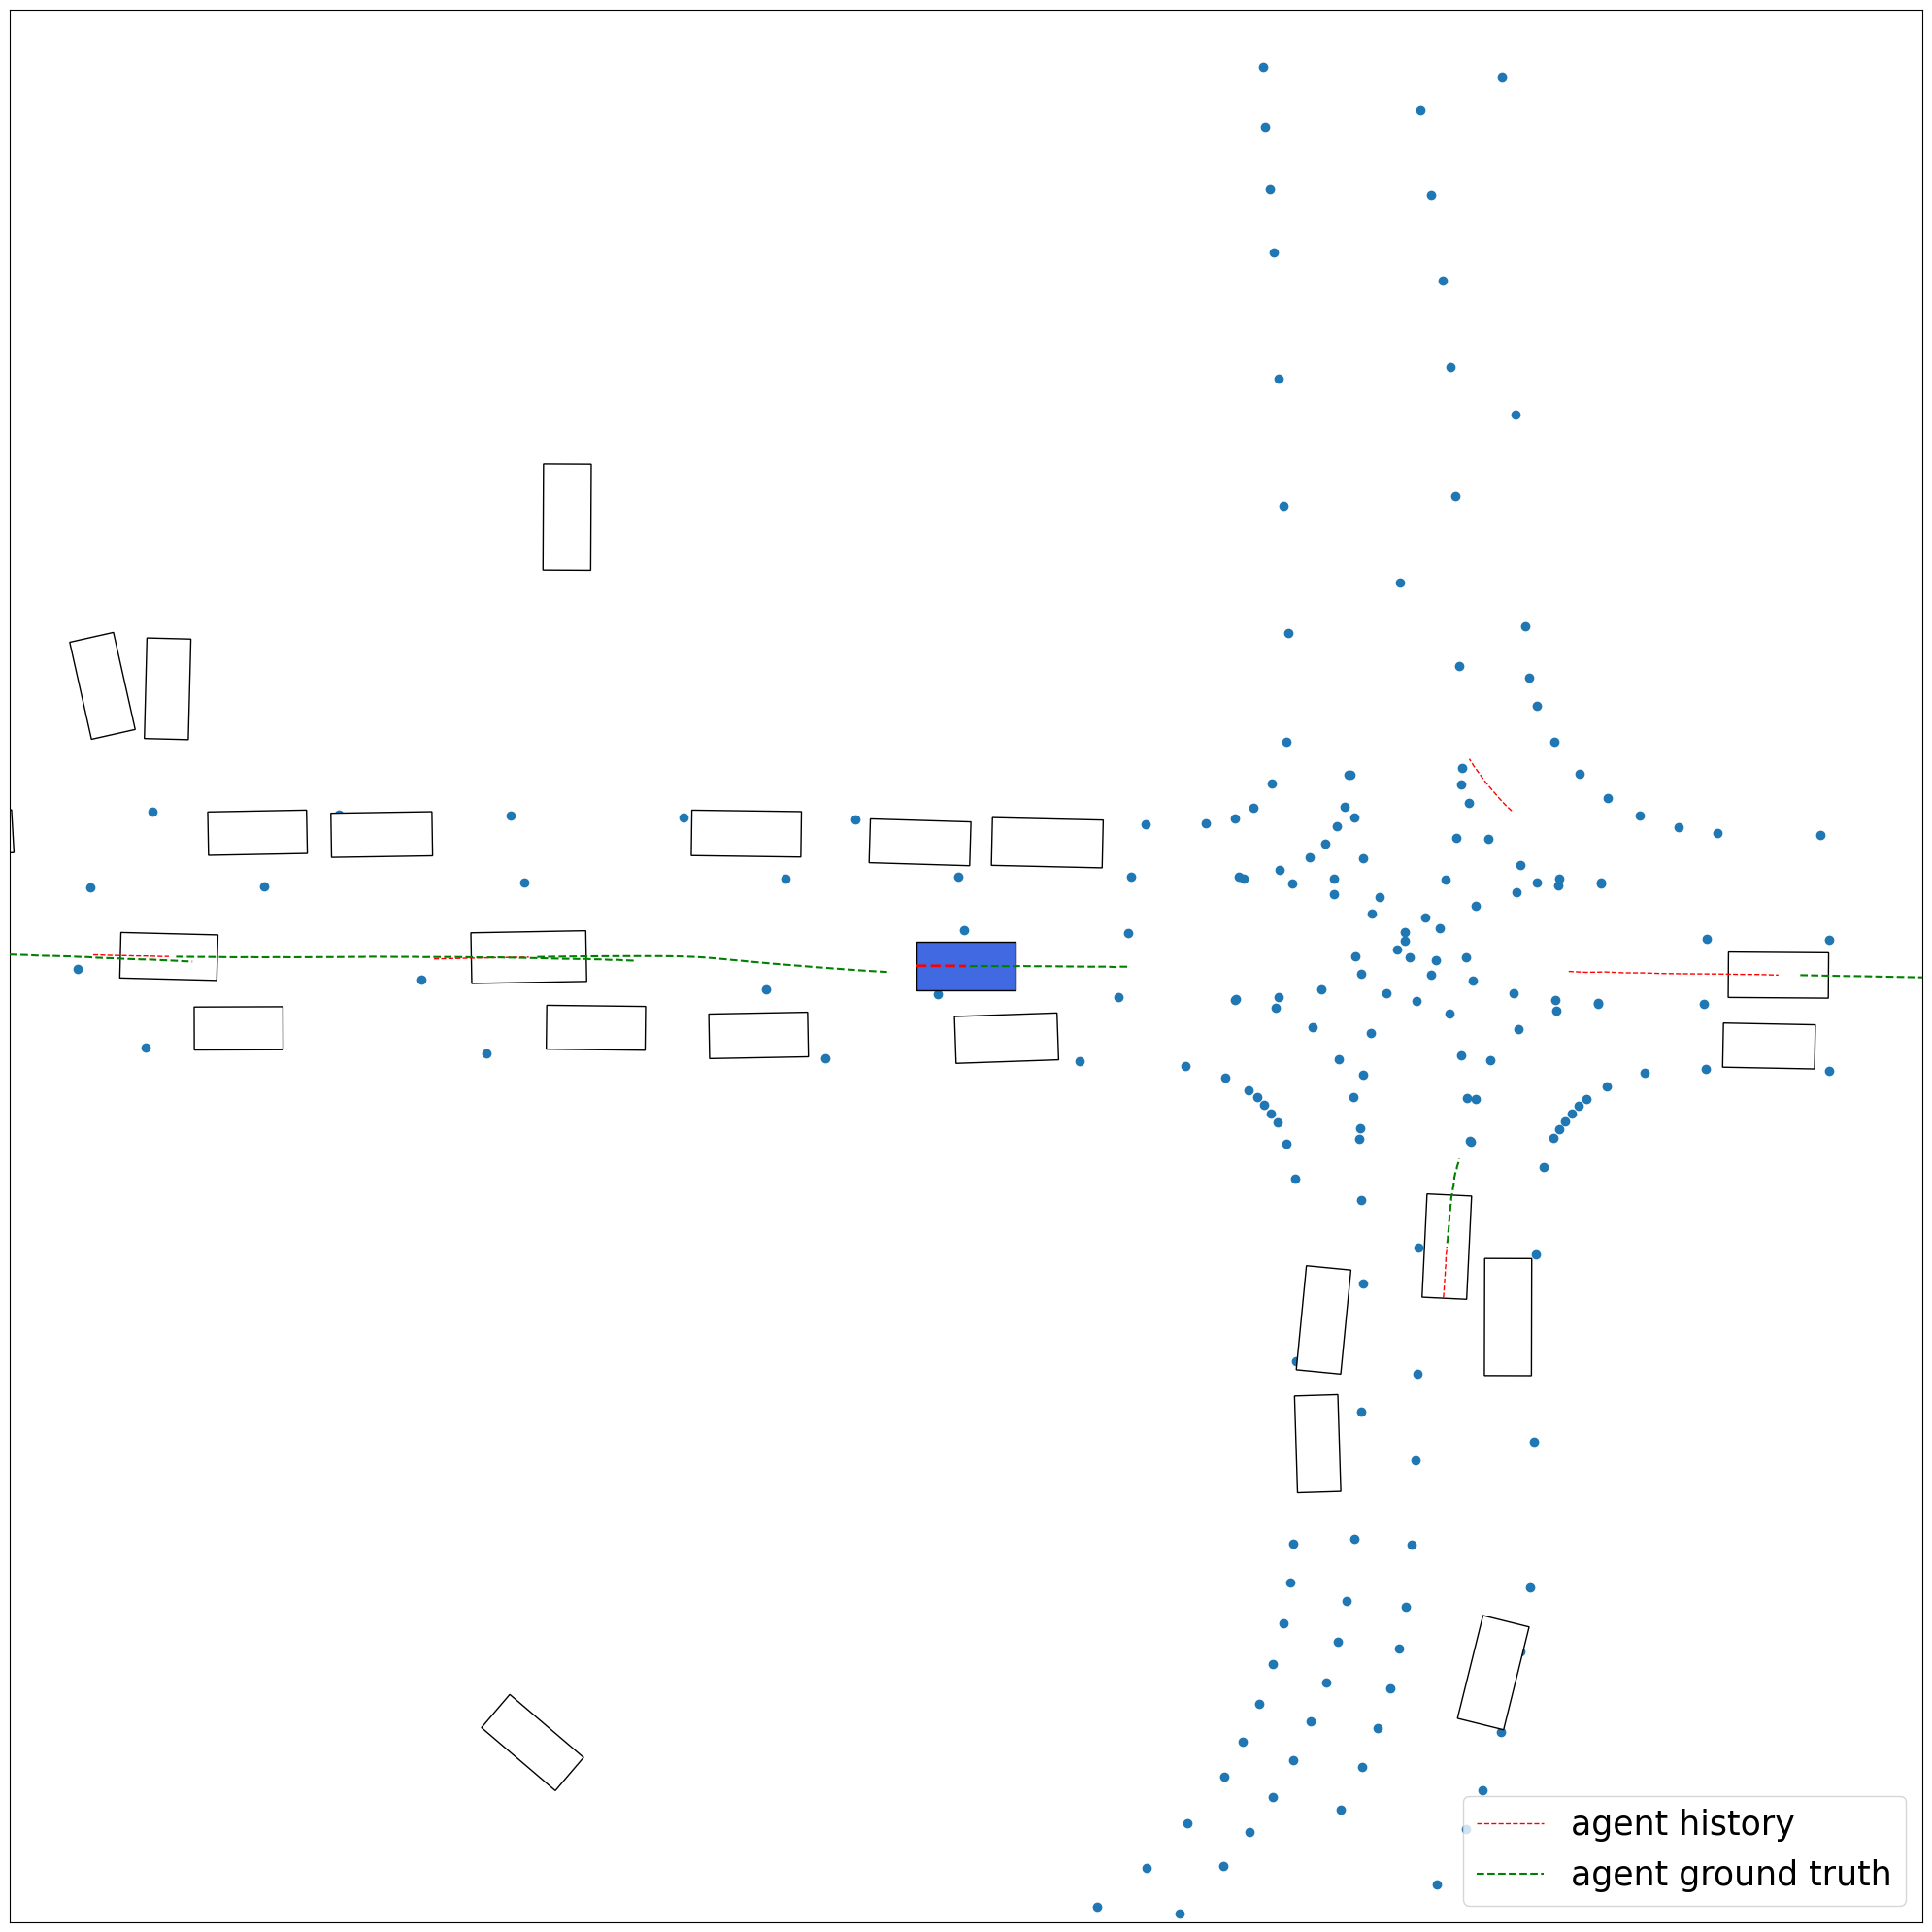

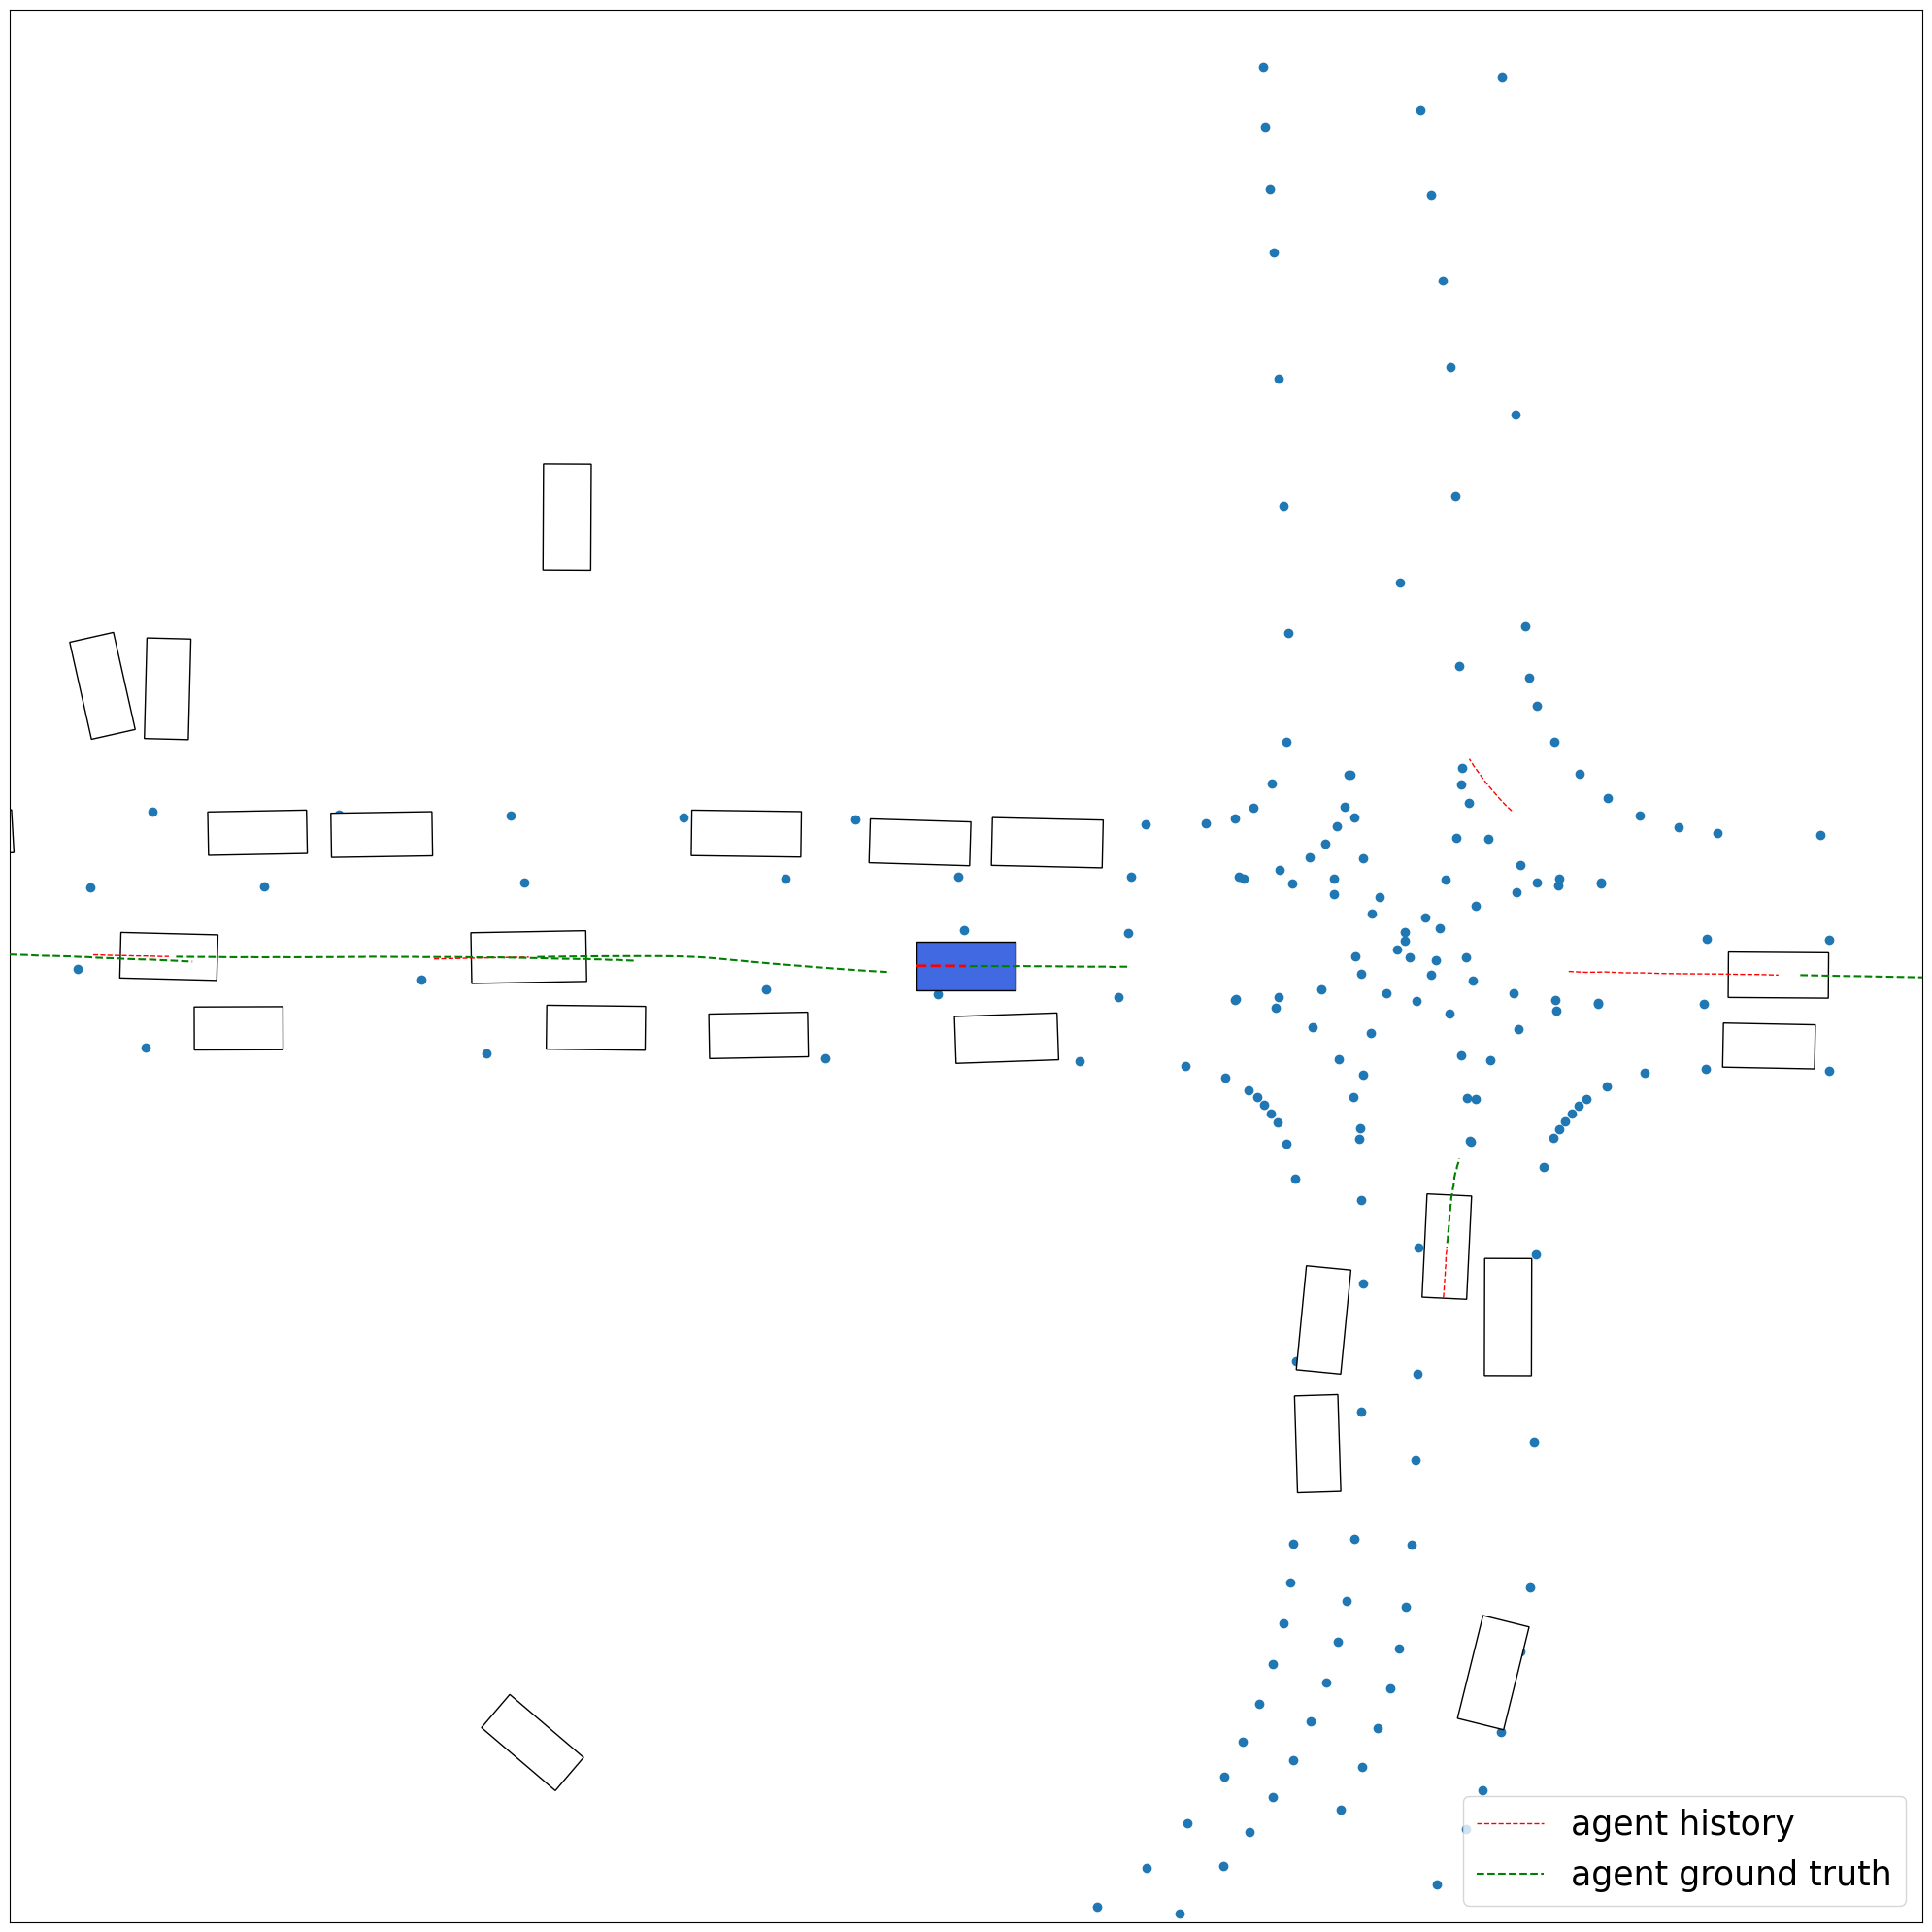

In [16]:
pred_info = generate_state_action_pairs(env=env,
                            device="cuda",
                            action_space_type="continuous", 
                            use_action_indices=True,  
                            make_video=False,
                            render_index=[2, 0],
                            save_path="use_discr_actions_fix",
                            CMTR=True, 
                            waymo_dataset=waymo_dataset,
                            prior_frame=40,
                            future_frame=40,
                            simple=True
)[0][0]
# true_info_dict = waymo_dataset.create_scene_level_data(0, None)

plot_scenario(
    input_dict=pred_info,
    forward_ret_dict=None,
    num_samples=1,
    plot_object_history=True, 
    plot_object_gt_future=True,
)

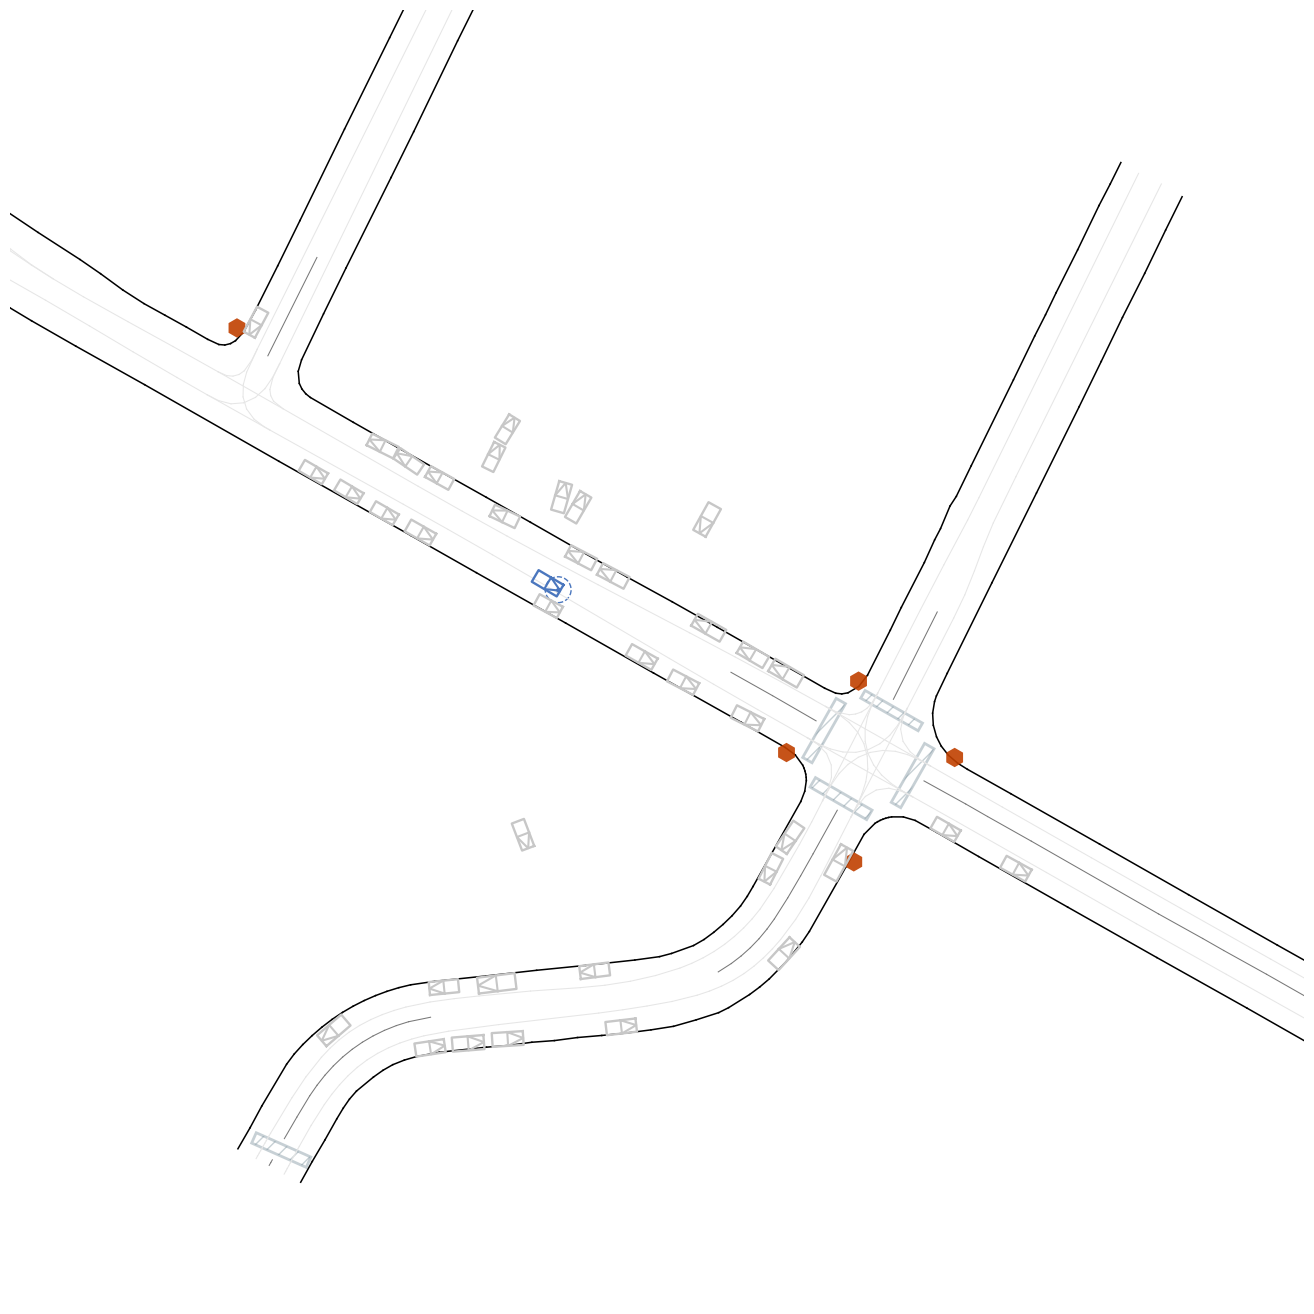

In [17]:
# Gpudrive's visualization script
time_idx = 11
env_image = env.vis.plot_simulator_state(
    env_indices=[0, 1],
    time_steps=[time_idx]*2,
    zoom_radius=100,
)
env_image[0]

In [18]:
sample_batch_dict[0]['input_dict']['obj_trajs'].shape

torch.Size([7, 47, 12, 30])

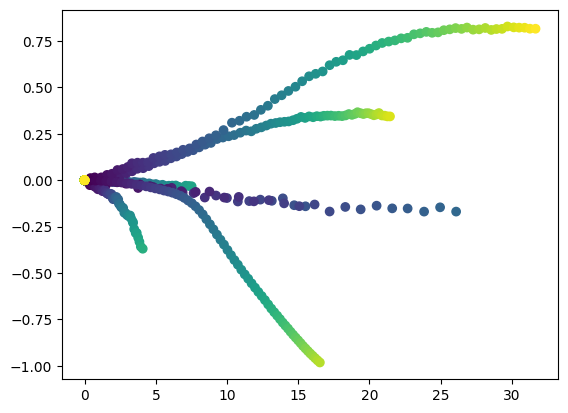

In [26]:
for obj_idx in range(len(sample_batch_dict[0]['input_dict']['center_gt_trajs'])): 
    plt.scatter(sample_batch_dict[0]['input_dict']['center_gt_trajs'][obj_idx, :, 0], sample_batch_dict[0]['input_dict']['center_gt_trajs'][obj_idx, :, 1], c=np.linspace(0, 1, sample_batch_dict[0]['input_dict']['center_gt_trajs'].shape[1]))
plt.show()

In [30]:
model.set_epoch(0)
torch.cuda.set_device(1)
model.train()
loss, tb_dict, disp_dict, batch_dict = model(sample_batch_dict[0])

In [31]:
print(batch_dict['input_dict']['center_gt_trajs'].shape, batch_dict['forward_ret_dict']['pred_list'][-1][1].shape)
print(batch_dict['input_dict']['center_gt_trajs'].device, batch_dict['pred_list'][-1][1].device)

torch.Size([7, 73, 4]) (7, 64, 73, 7)
cpu cuda:1


In [32]:
batch_dict.keys()

dict_keys(['batch_size', 'index', 'input_dict', 'batch_sample_count', 'input_grad_dict', 'ego2obj_attn_mask', 'center_objects_feature', 'obj_feature', 'map_feature', 'obj_mask', 'map_mask', 'obj_pos', 'map_pos', 'forward_ret_dict', 'pred_scores', 'pred_trajs', 'pred_list'])

INFO:root:Epoch: 1, Last loss: 0.29903873801231384


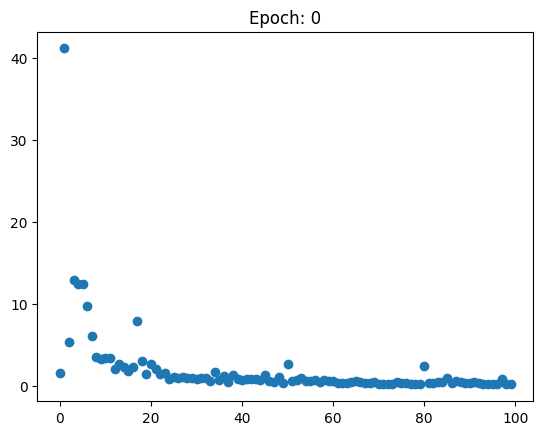

INFO:root:Epoch: 2, Last loss: 0.11877036839723587


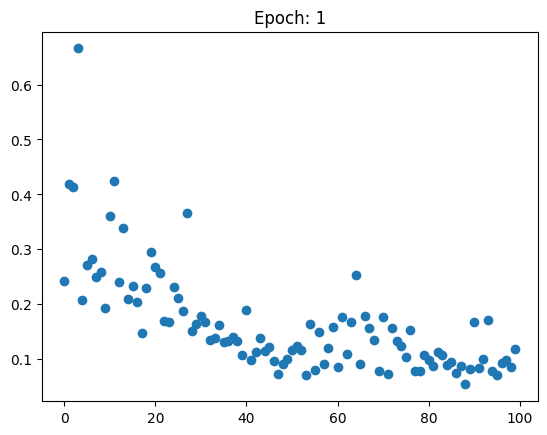

INFO:root:Epoch: 3, Last loss: 0.18954402208328247


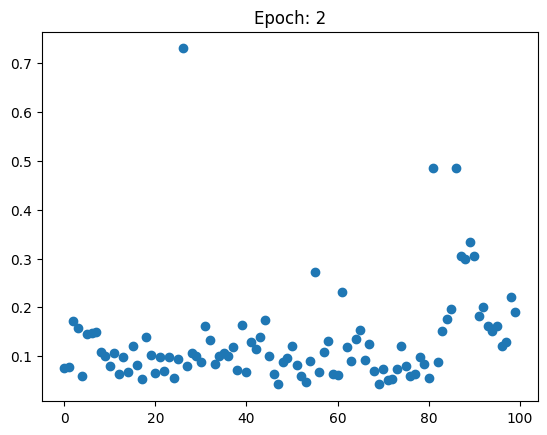

INFO:root:Epoch: 4, Last loss: 0.039514318108558655


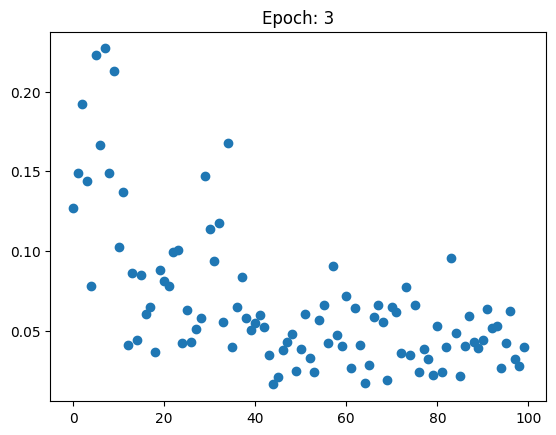

INFO:root:Epoch: 5, Last loss: 0.03810917213559151


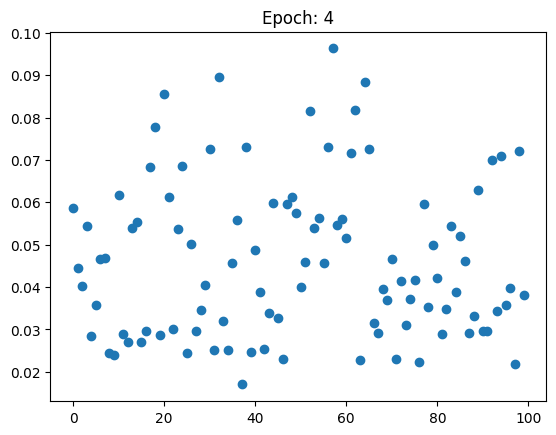

INFO:root:Epoch: 6, Last loss: 0.011860215105116367


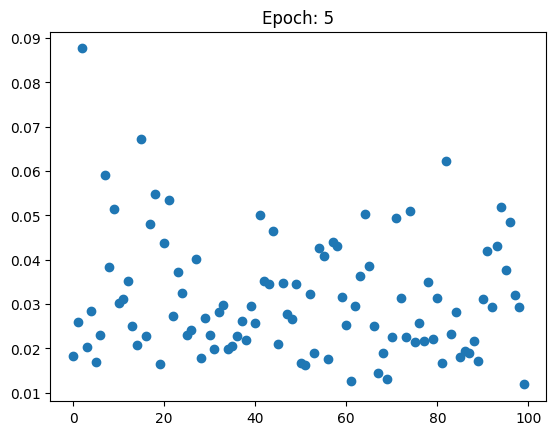

INFO:root:Epoch: 7, Last loss: 0.055138058960437775


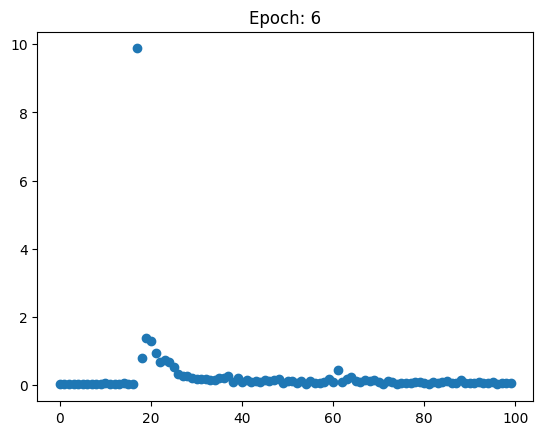

INFO:root:Epoch: 8, Last loss: 0.018863001838326454


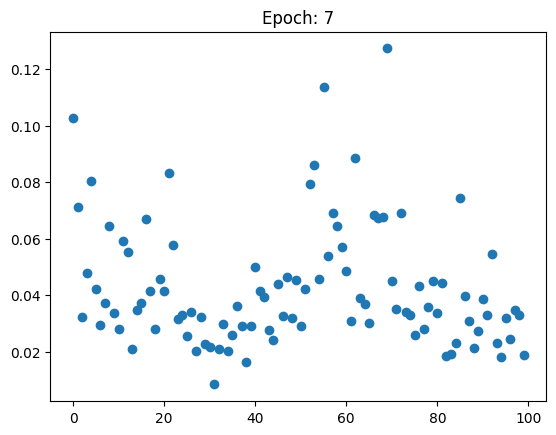

INFO:root:Epoch: 9, Last loss: 1.3711457252502441


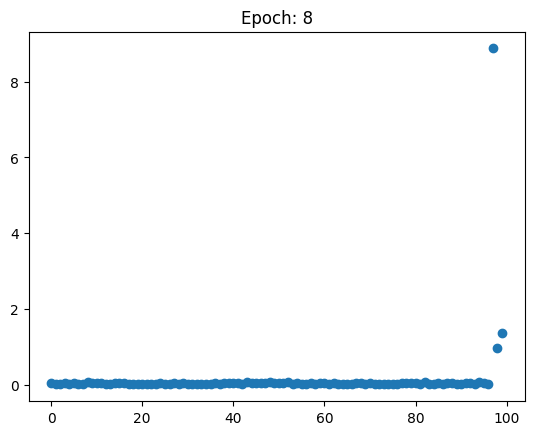

INFO:root:Epoch: 10, Last loss: 0.04119683802127838


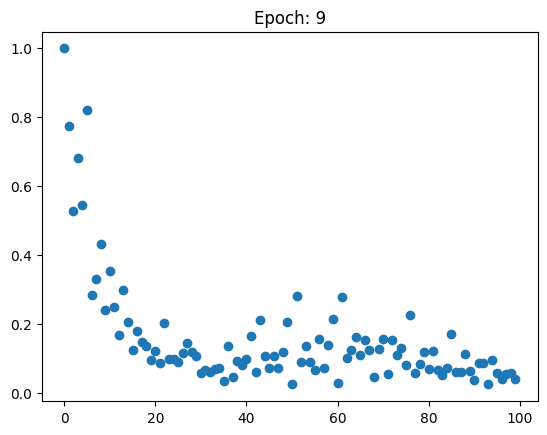

In [56]:
NUM_BATCH = 100
NUM_EPOCH = 10
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()
batch_dicts = []

# Reset the iterators
traj_data_loader = TrajectoryIterator(env, data_loader, cmtr=True, waymo_dataset=waymo_dataset, prior_frame=4, future_frame=30, simple=True)
train_iterator = iter(DataLoader(traj_data_loader, batch_size=2, collate_fn=traj_data_loader.collate_batch))

for epoch in range(NUM_EPOCH): 
    model.set_epoch(epoch)
    for batch_idx in range(NUM_BATCH): 
        batch_dict, actions, _, _ = next(train_iterator)
        loss, tb_dict, disp_dict, batch_dict = model(batch_dict)
        loss = loss_fn(batch_dict['pred_list'][-1][1][:, 0, :, :2], batch_dict['input_dict']['center_gt_trajs'][..., :2].cuda())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_dicts.append((loss.detach(), [batch_dict['pred_list'][-1][1][:, 0, :, :2].detach(), batch_dict['input_dict']['center_gt_trajs'][..., :2]]))
    logging.info(f"Epoch: {epoch + 1}, Last loss: {batch_dicts[-1][0].item()}")
    plt.title(f"Epoch: {epoch}")
    plt.scatter(np.arange(NUM_BATCH), [i[0].cpu() for i in batch_dicts[-NUM_BATCH:]])
    plt.show()

In [71]:
batch_dict_idx = -1
pred_trajs = batch_dicts[batch_dict_idx][1][0].cpu()
true_trajs = batch_dicts[batch_dict_idx][1][1]

In [72]:
print(pred_trajs.shape, true_trajs.shape)

torch.Size([12, 73, 2]) torch.Size([12, 73, 2])


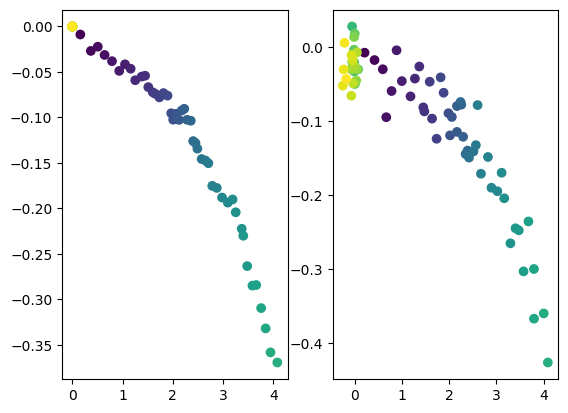

In [73]:
# plot obj 1 first
obj_idx = 5
clip = 1_000
plt.subplot(1, 2, 1)
plt.scatter(true_trajs[obj_idx, :, 0].clip(-clip, clip), true_trajs[obj_idx, :, 1].clip(-clip, clip), c=np.linspace(0,1, pred_trajs.shape[1]))
plt.subplot(1, 2, 2)
plt.scatter(pred_trajs[obj_idx, :, 0].clip(-clip, clip), pred_trajs[obj_idx, :, 1].clip(-clip, clip), c=np.linspace(0,1, pred_trajs.shape[1]))
plt.show()

[<Figure size 2000x2000 with 1 Axes>,
 <Figure size 2000x2000 with 1 Axes>,
 <Figure size 2000x2000 with 1 Axes>,
 <Figure size 2000x2000 with 1 Axes>]

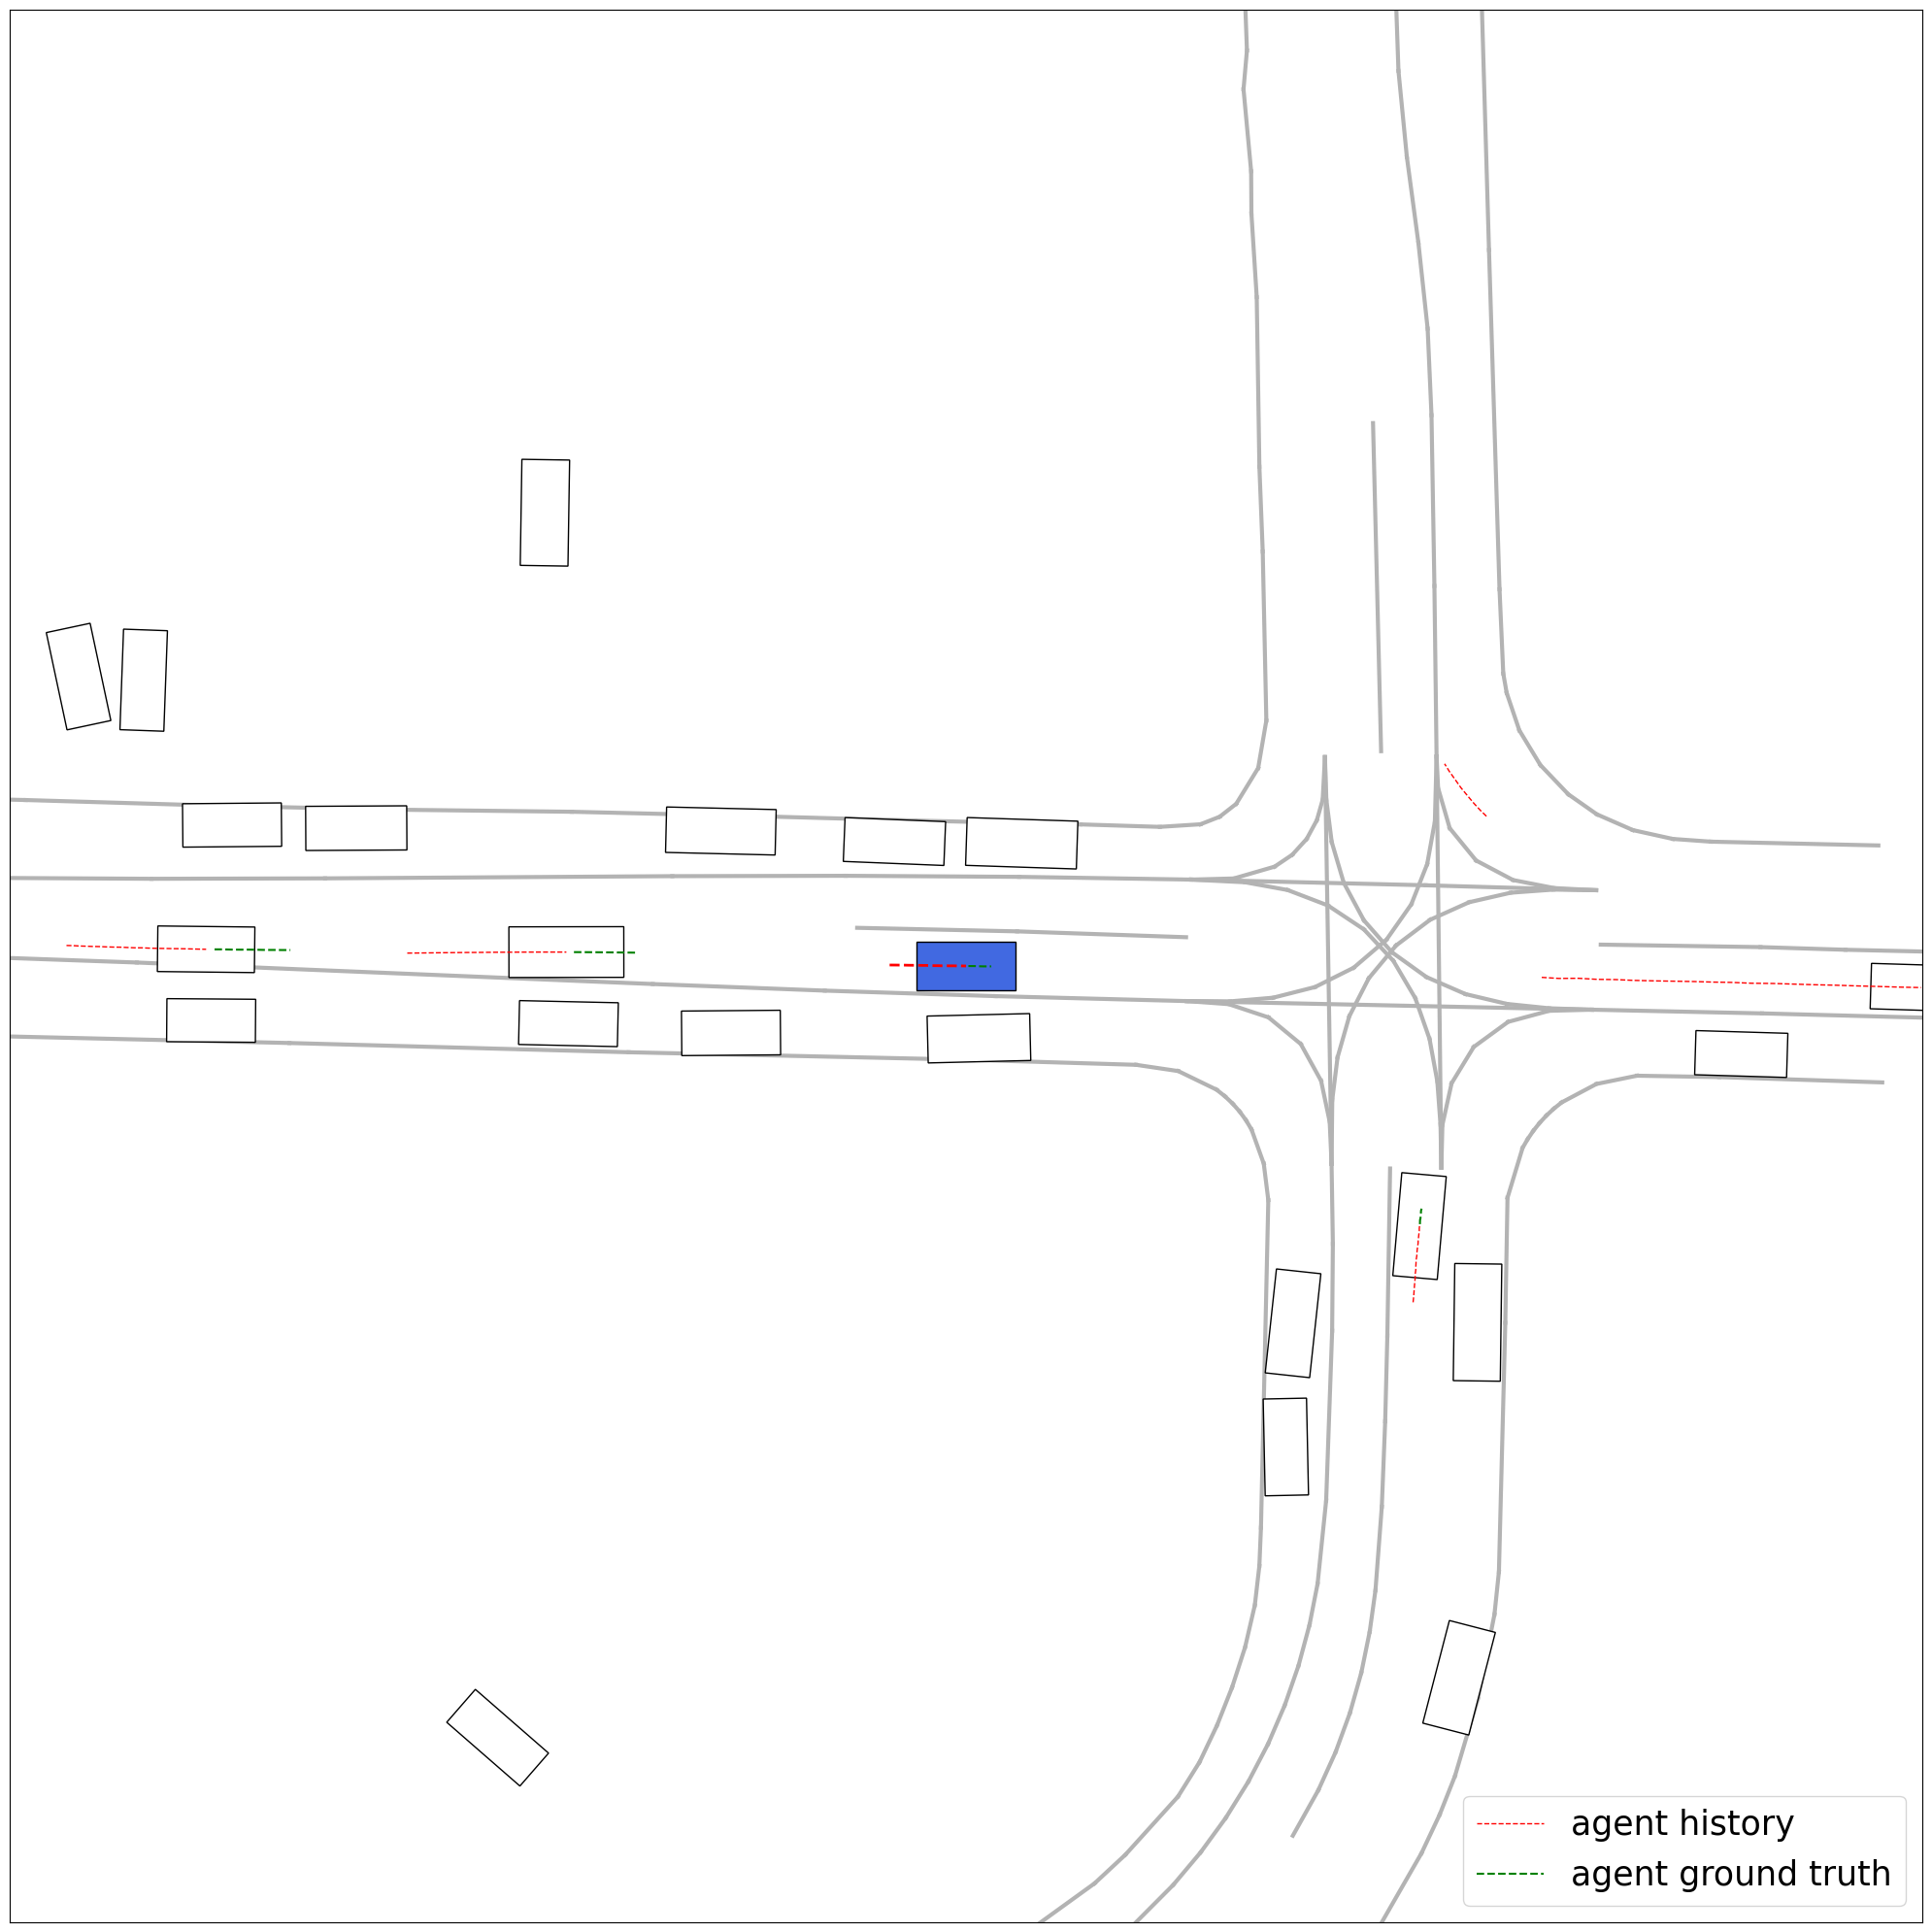

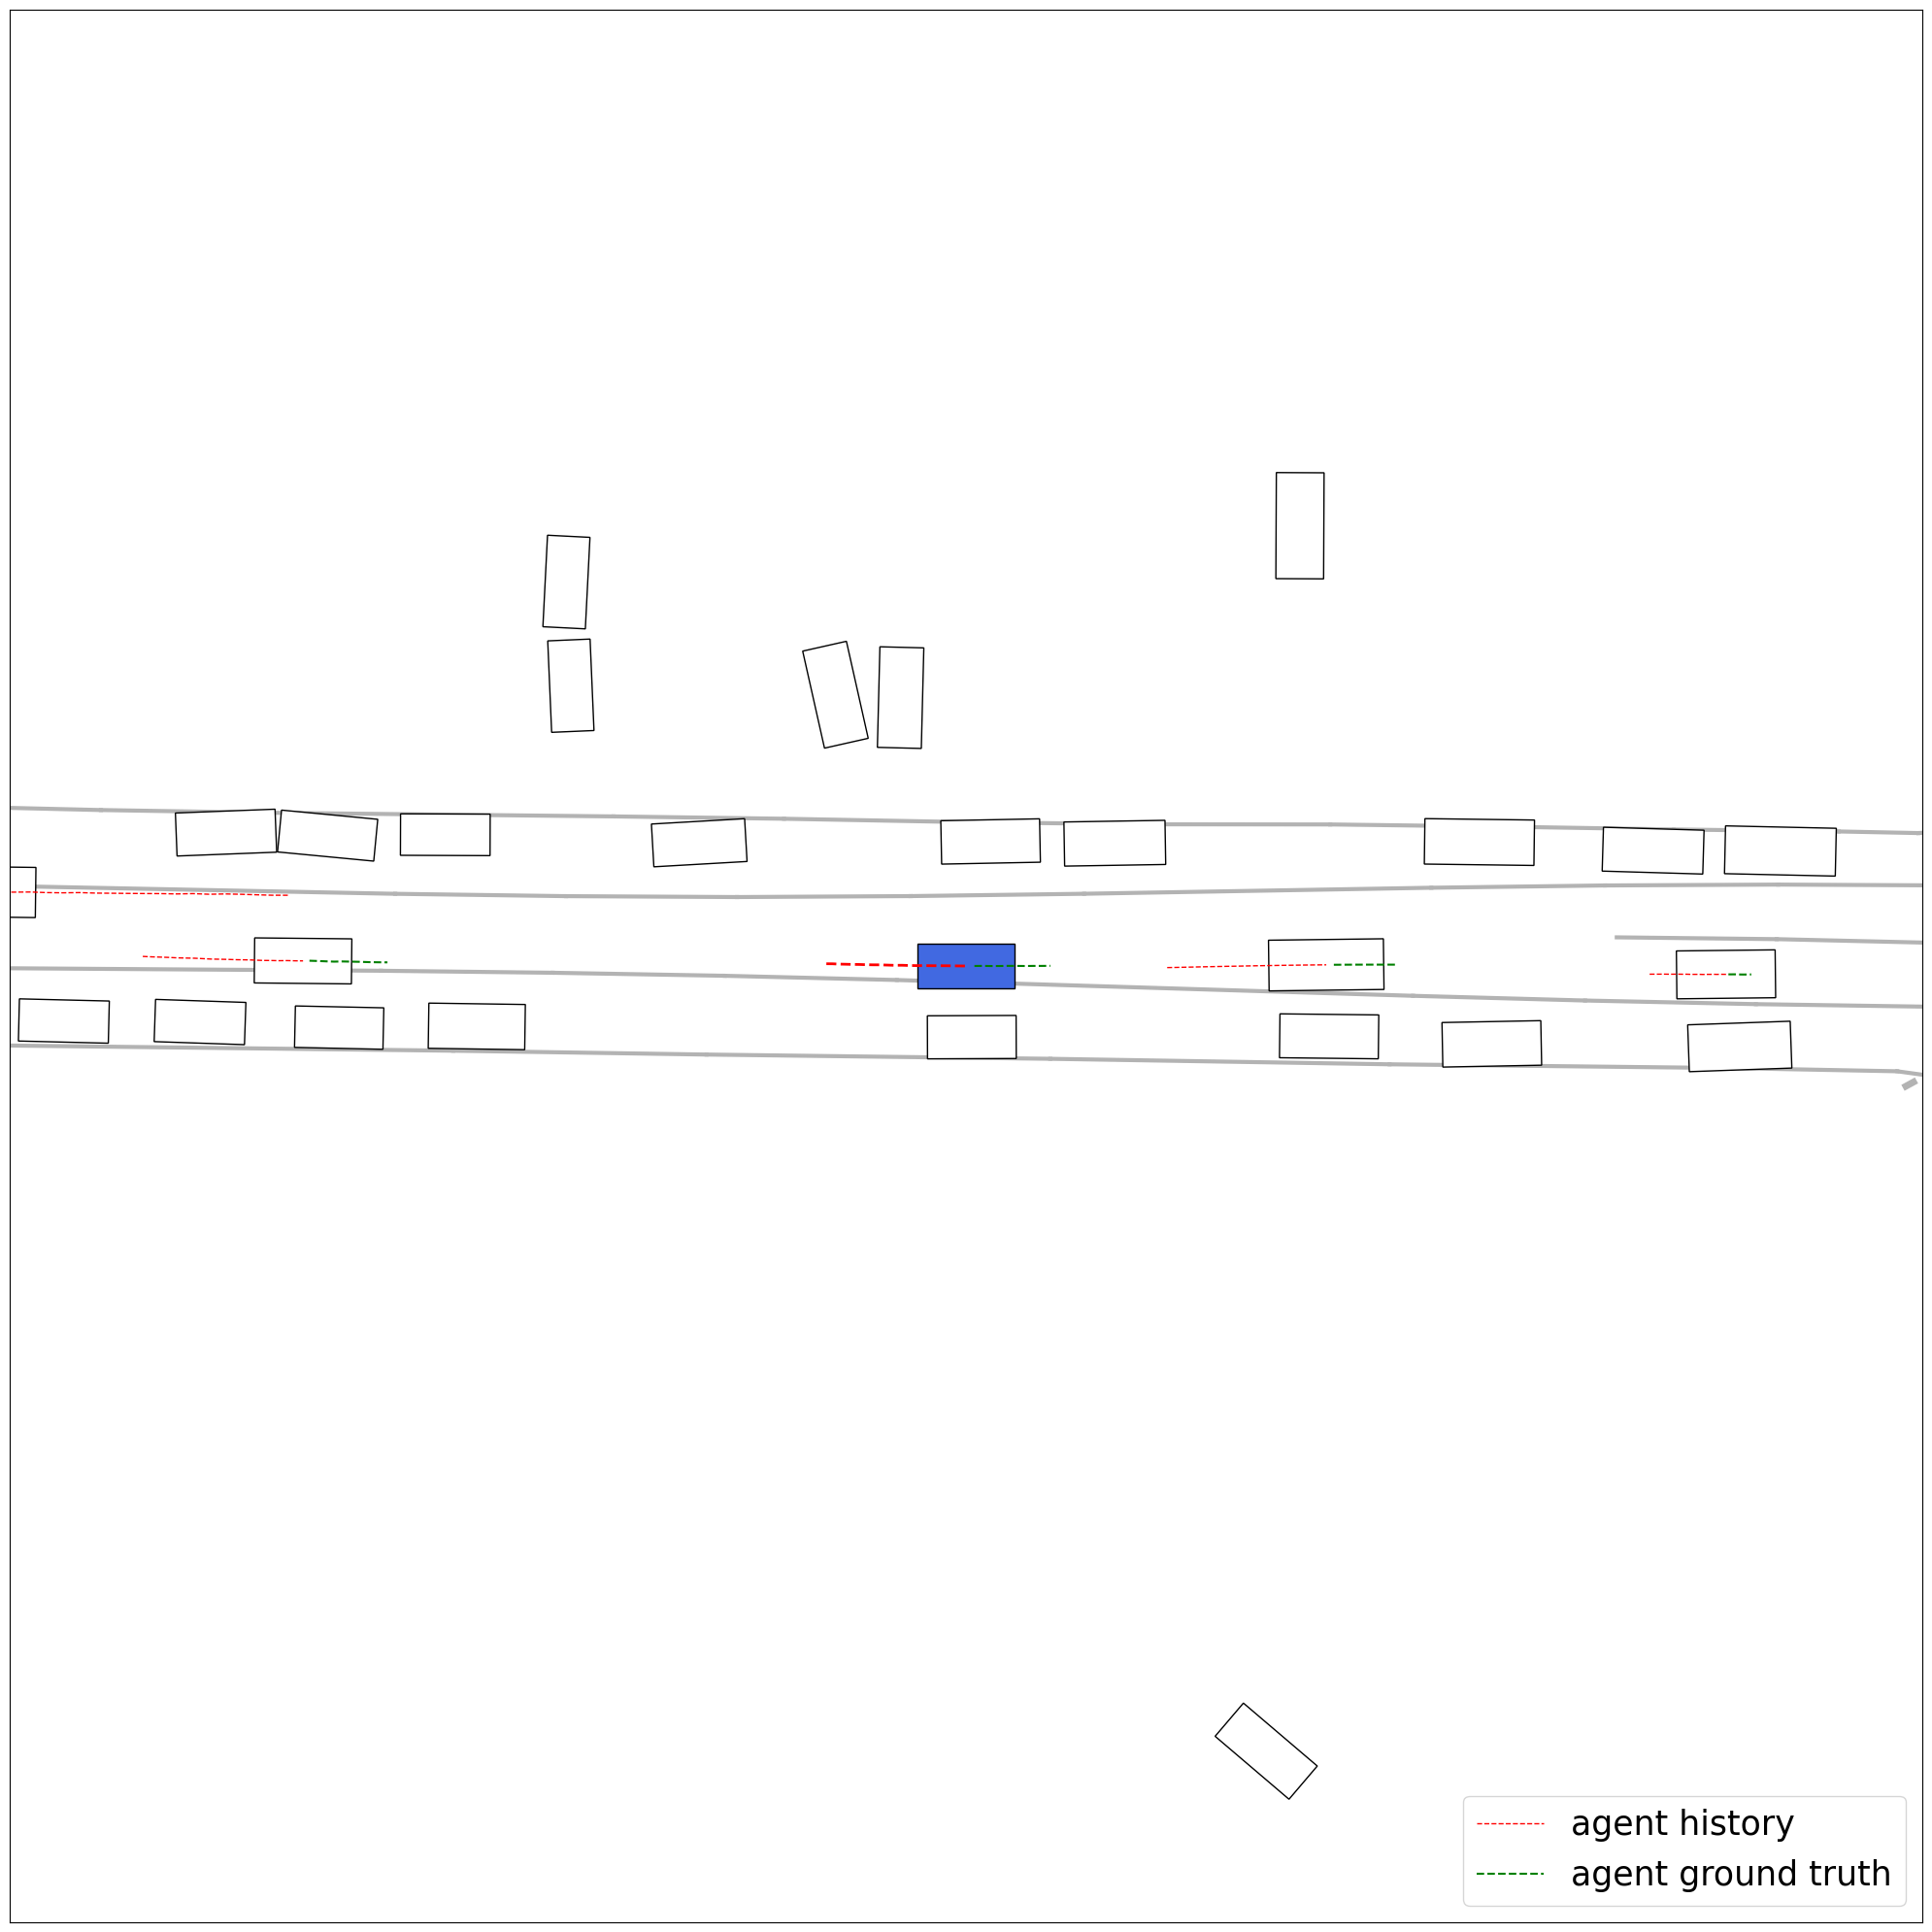

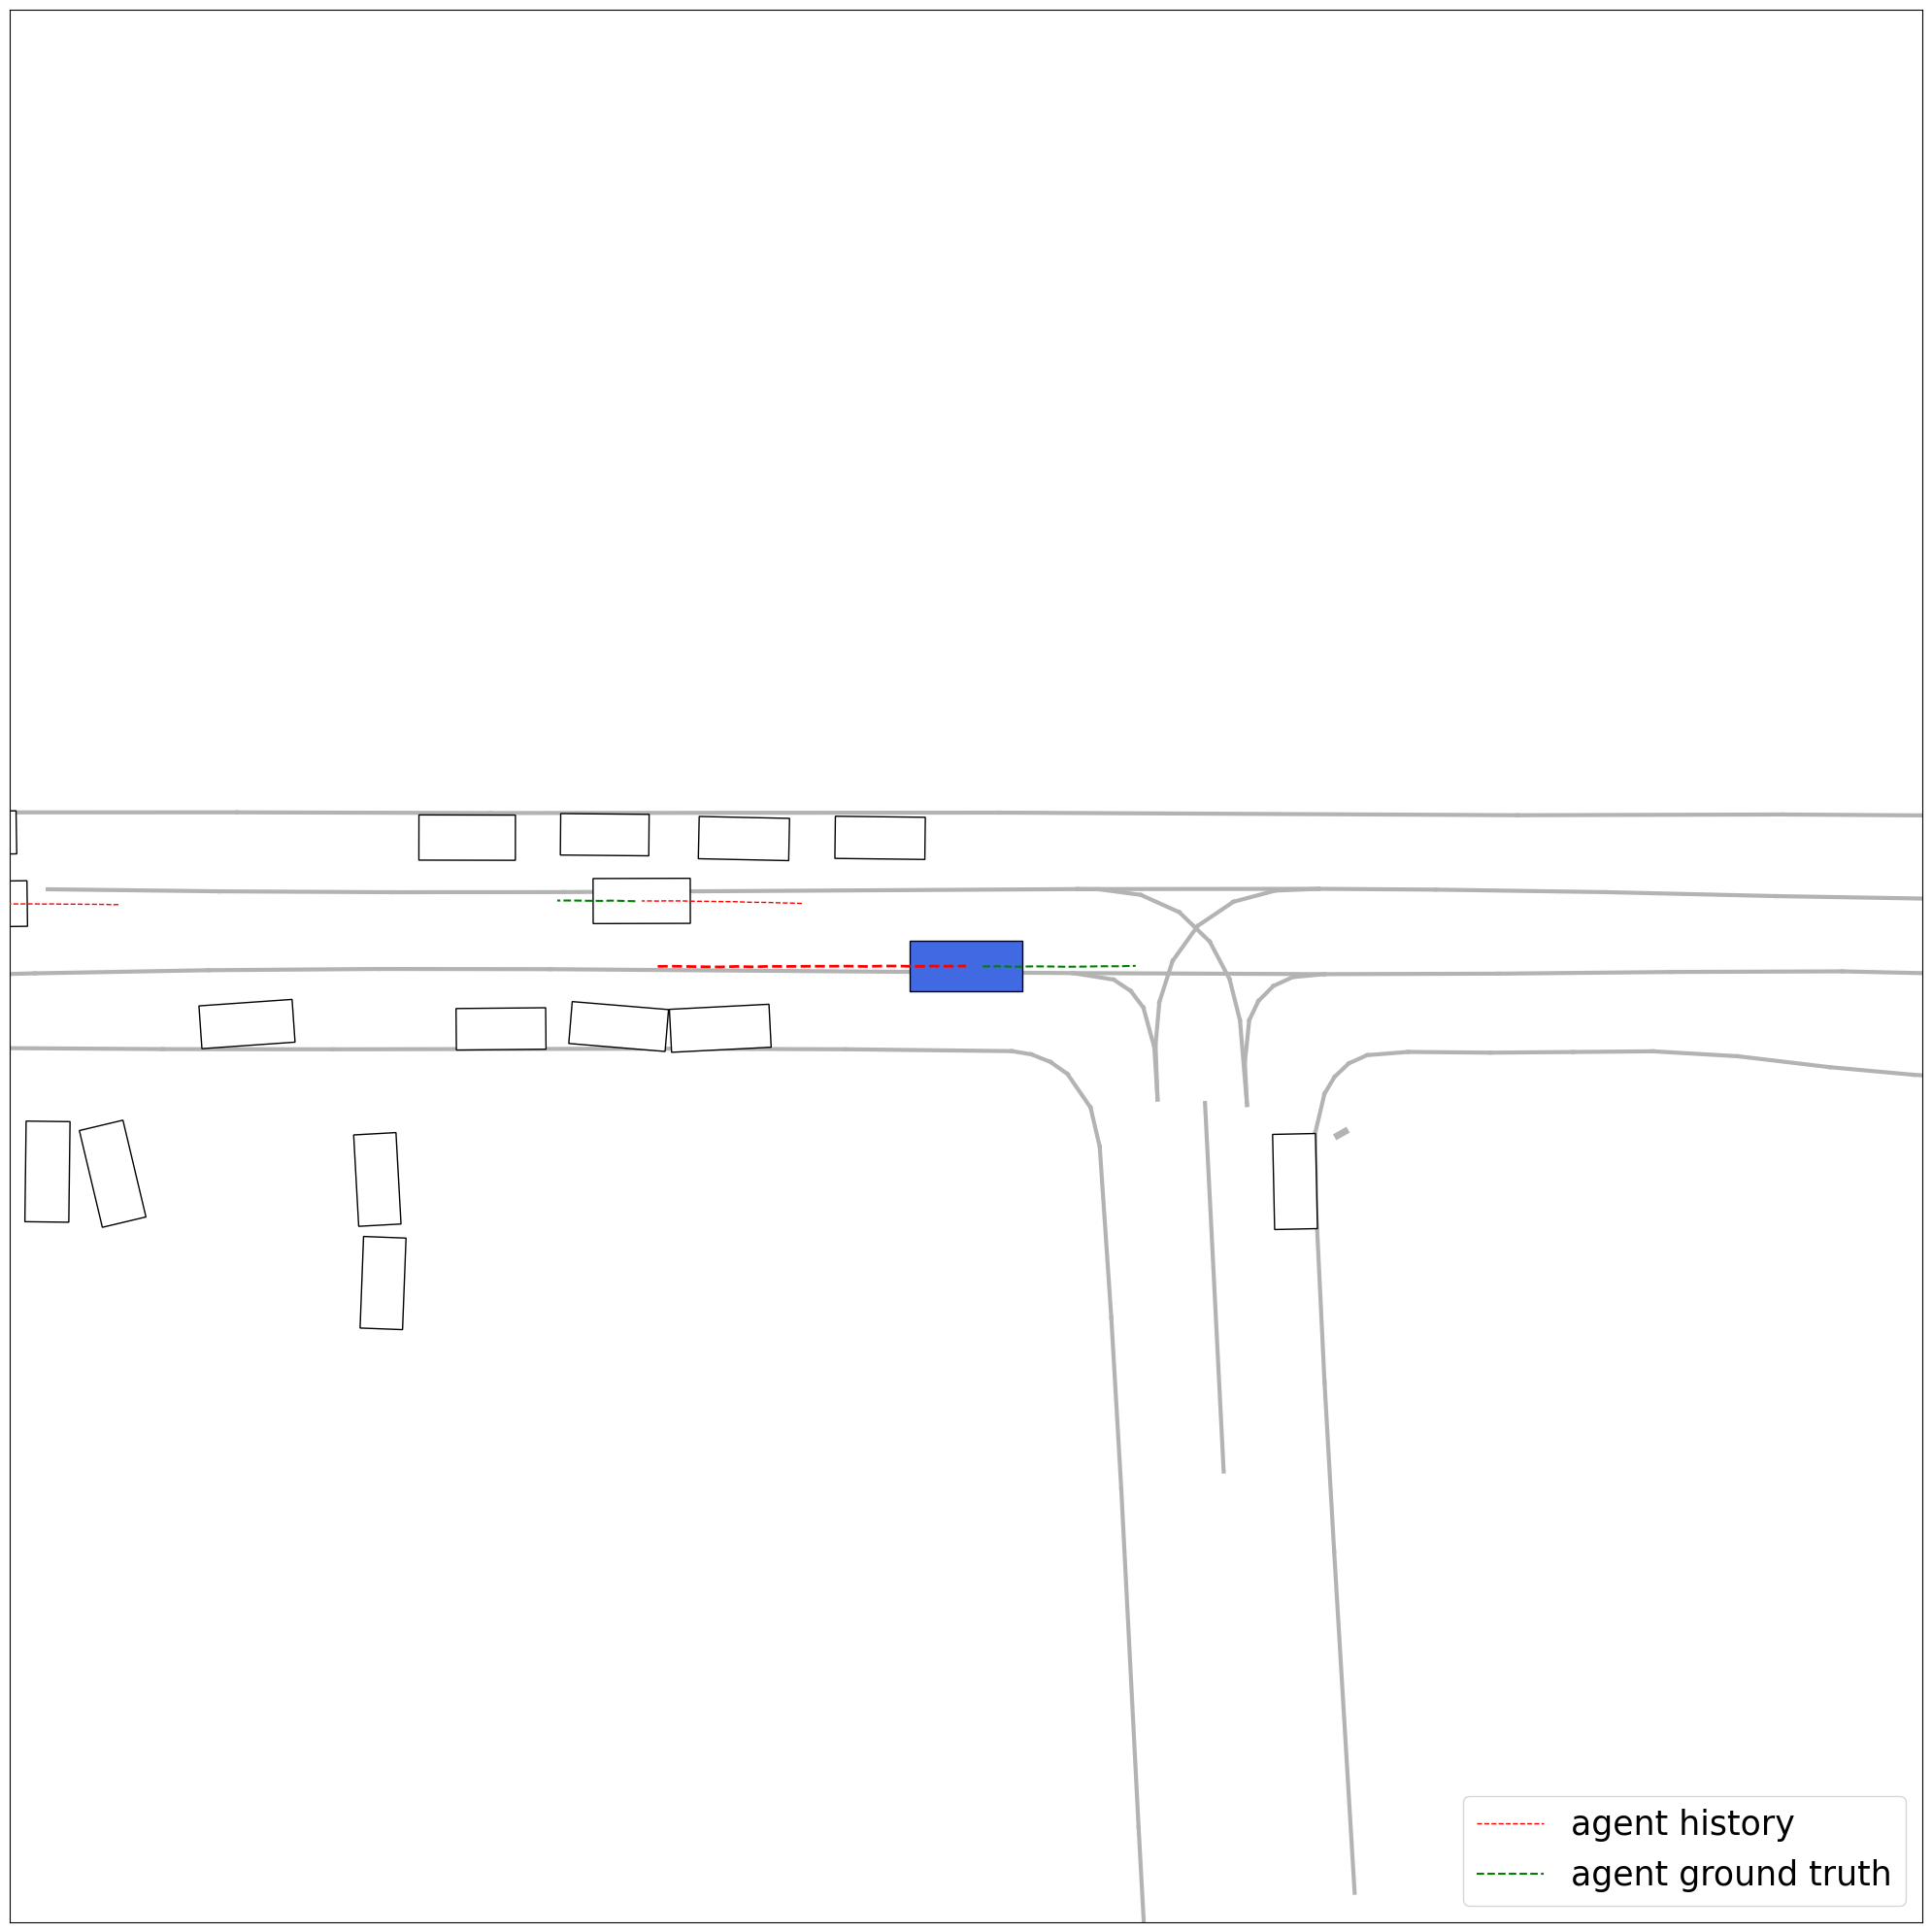

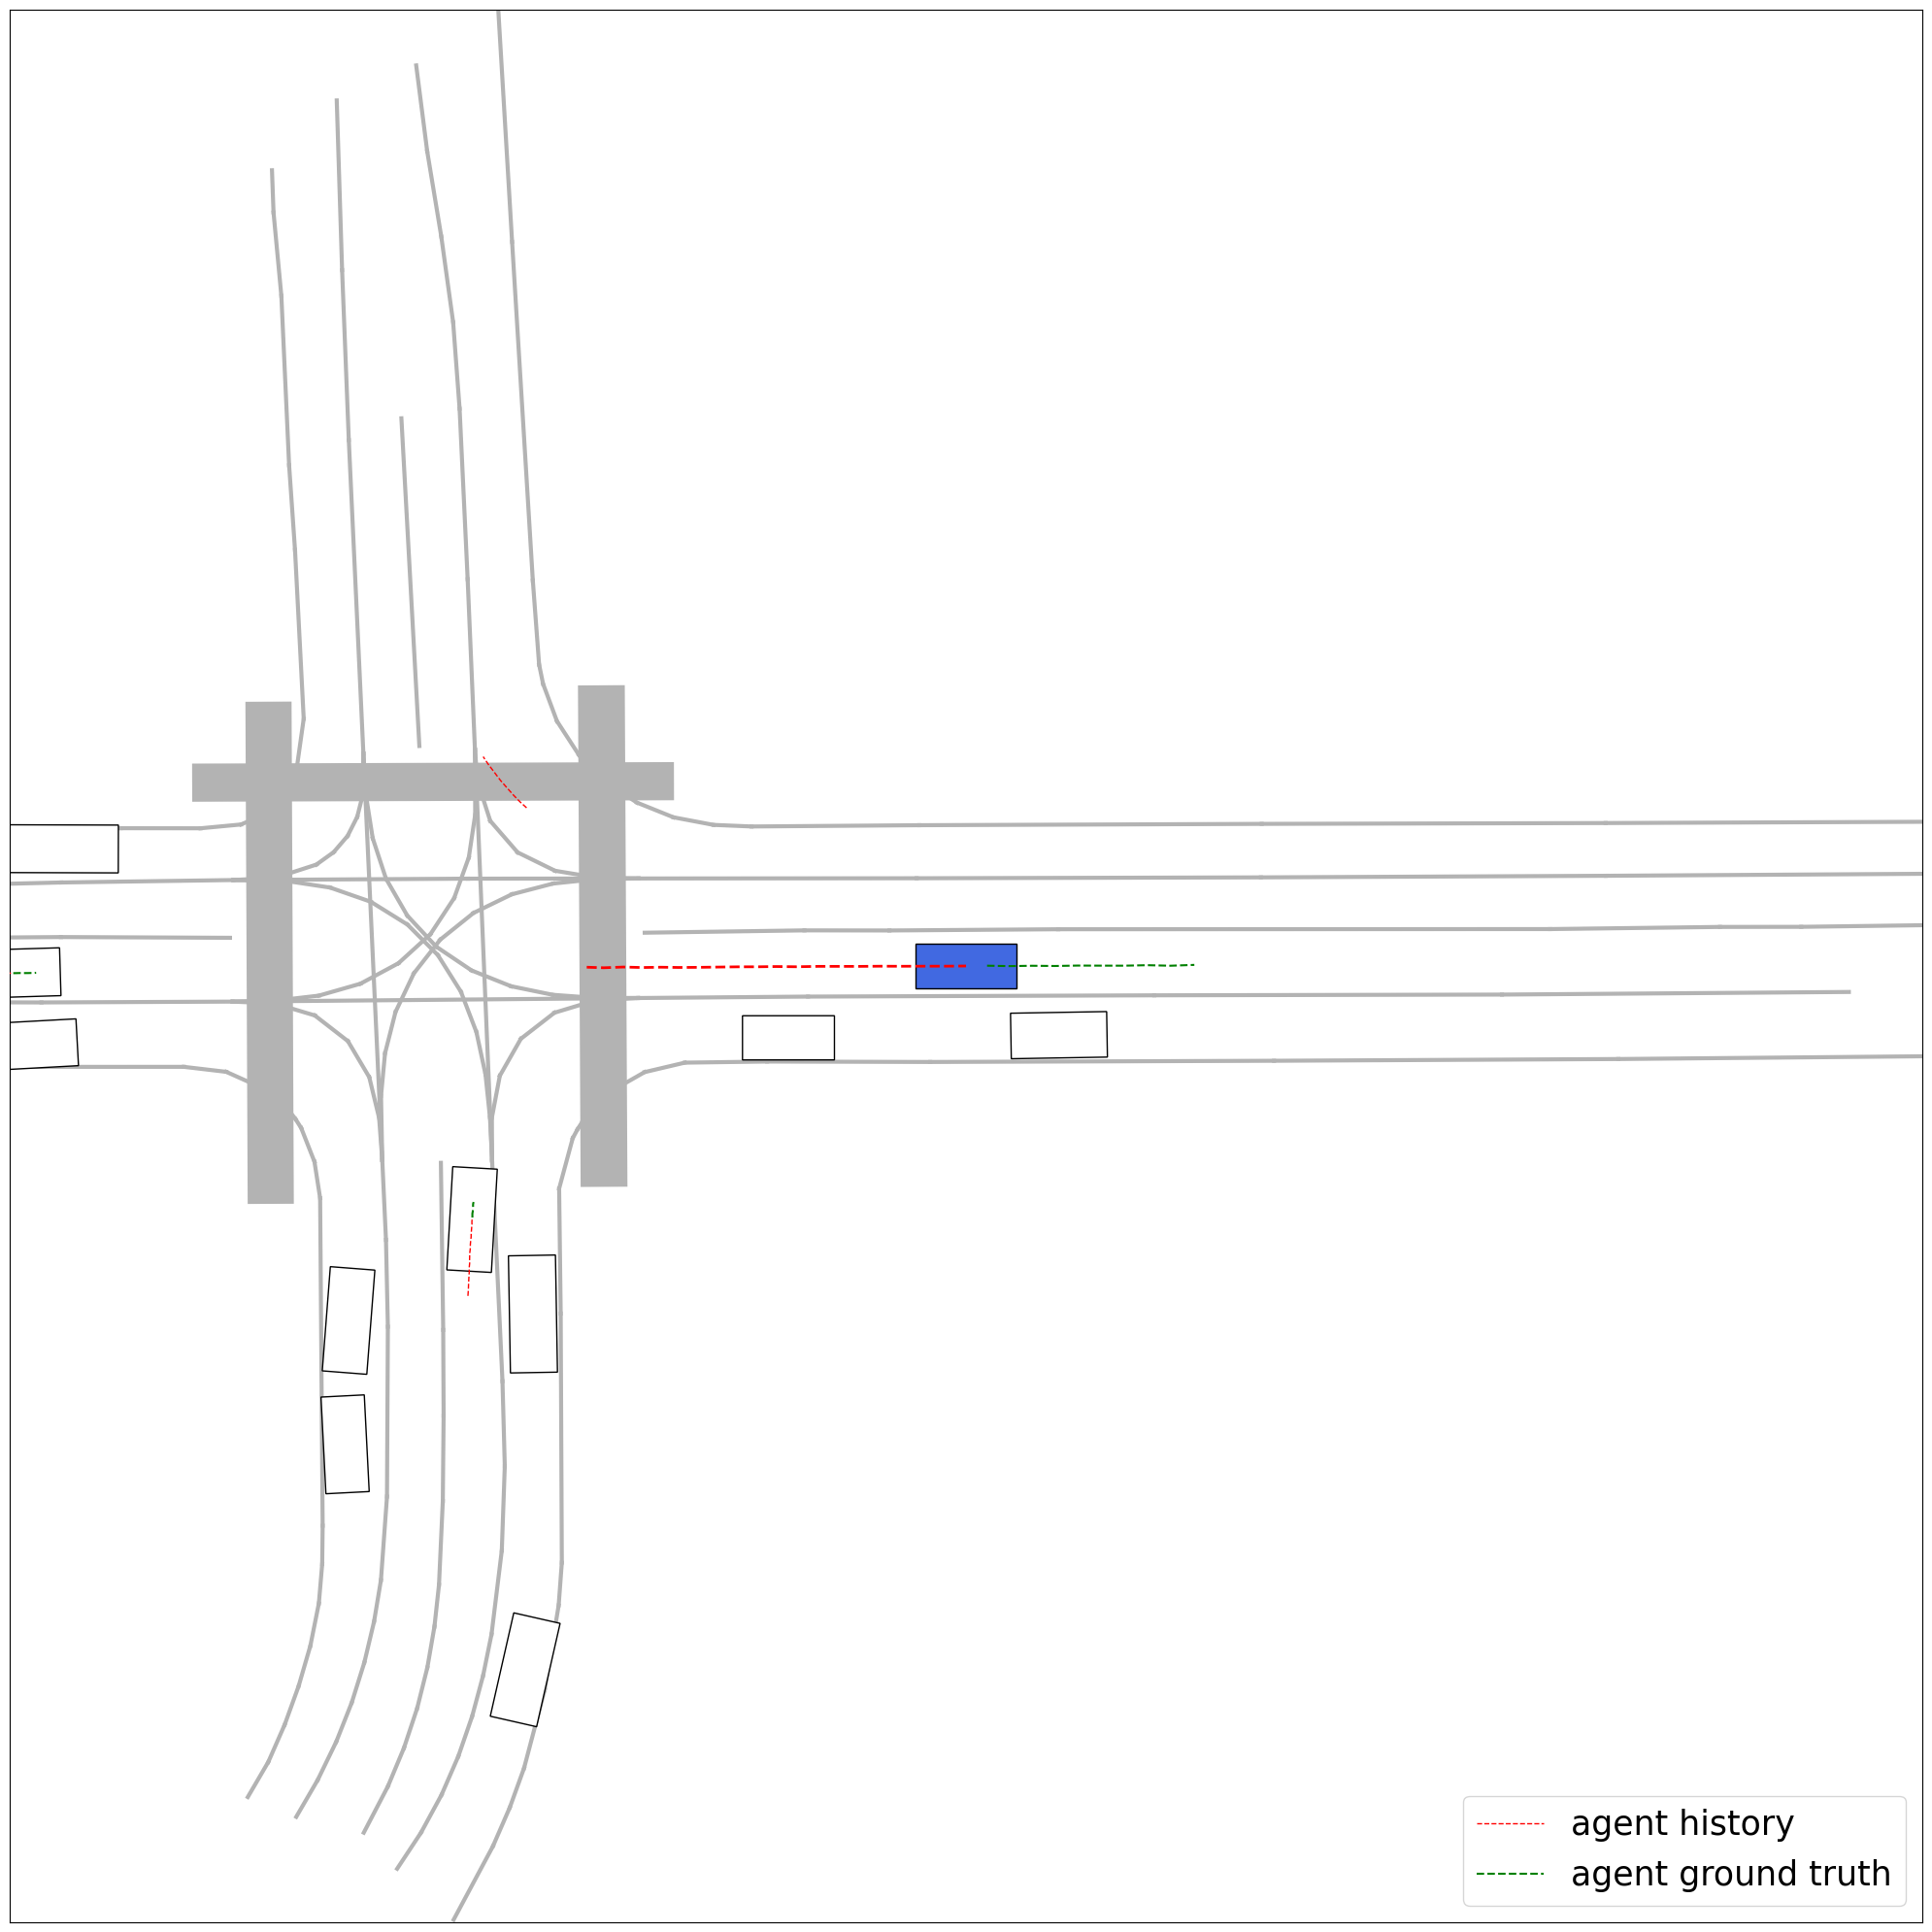

In [119]:

from cmtr_bc.batch_dict_visualization import plot_scenario
pred_info = generate_state_action_pairs(env=env,
                            device="cuda",
                            action_space_type="continuous", 
                            use_action_indices=True,  
                            make_video=False,
                            render_index=[2, 0],
                            save_path="use_discr_actions_fix",
                            CMTR=True, 
                            waymo_dataset=waymo_dataset,
                            prior_frame=20,
                            future_frame=10,
                            simple=False
)[0][0]
# true_info_dict = waymo_dataset.create_scene_level_data(0, None)

plot_scenario(
    input_dict=pred_info,
    forward_ret_dict=None,
    num_samples=4,
    plot_object_history=True, 
    plot_object_gt_future=True,
)

In [149]:
from tqdm import tqdm
from cmtr_bc.batch_dict_visualization import plot_scenario

  0%|          | 0/100 [00:00<?, ?it/s]

 99%|█████████▉| 99/100 [00:07<00:00, 17.35it/s]

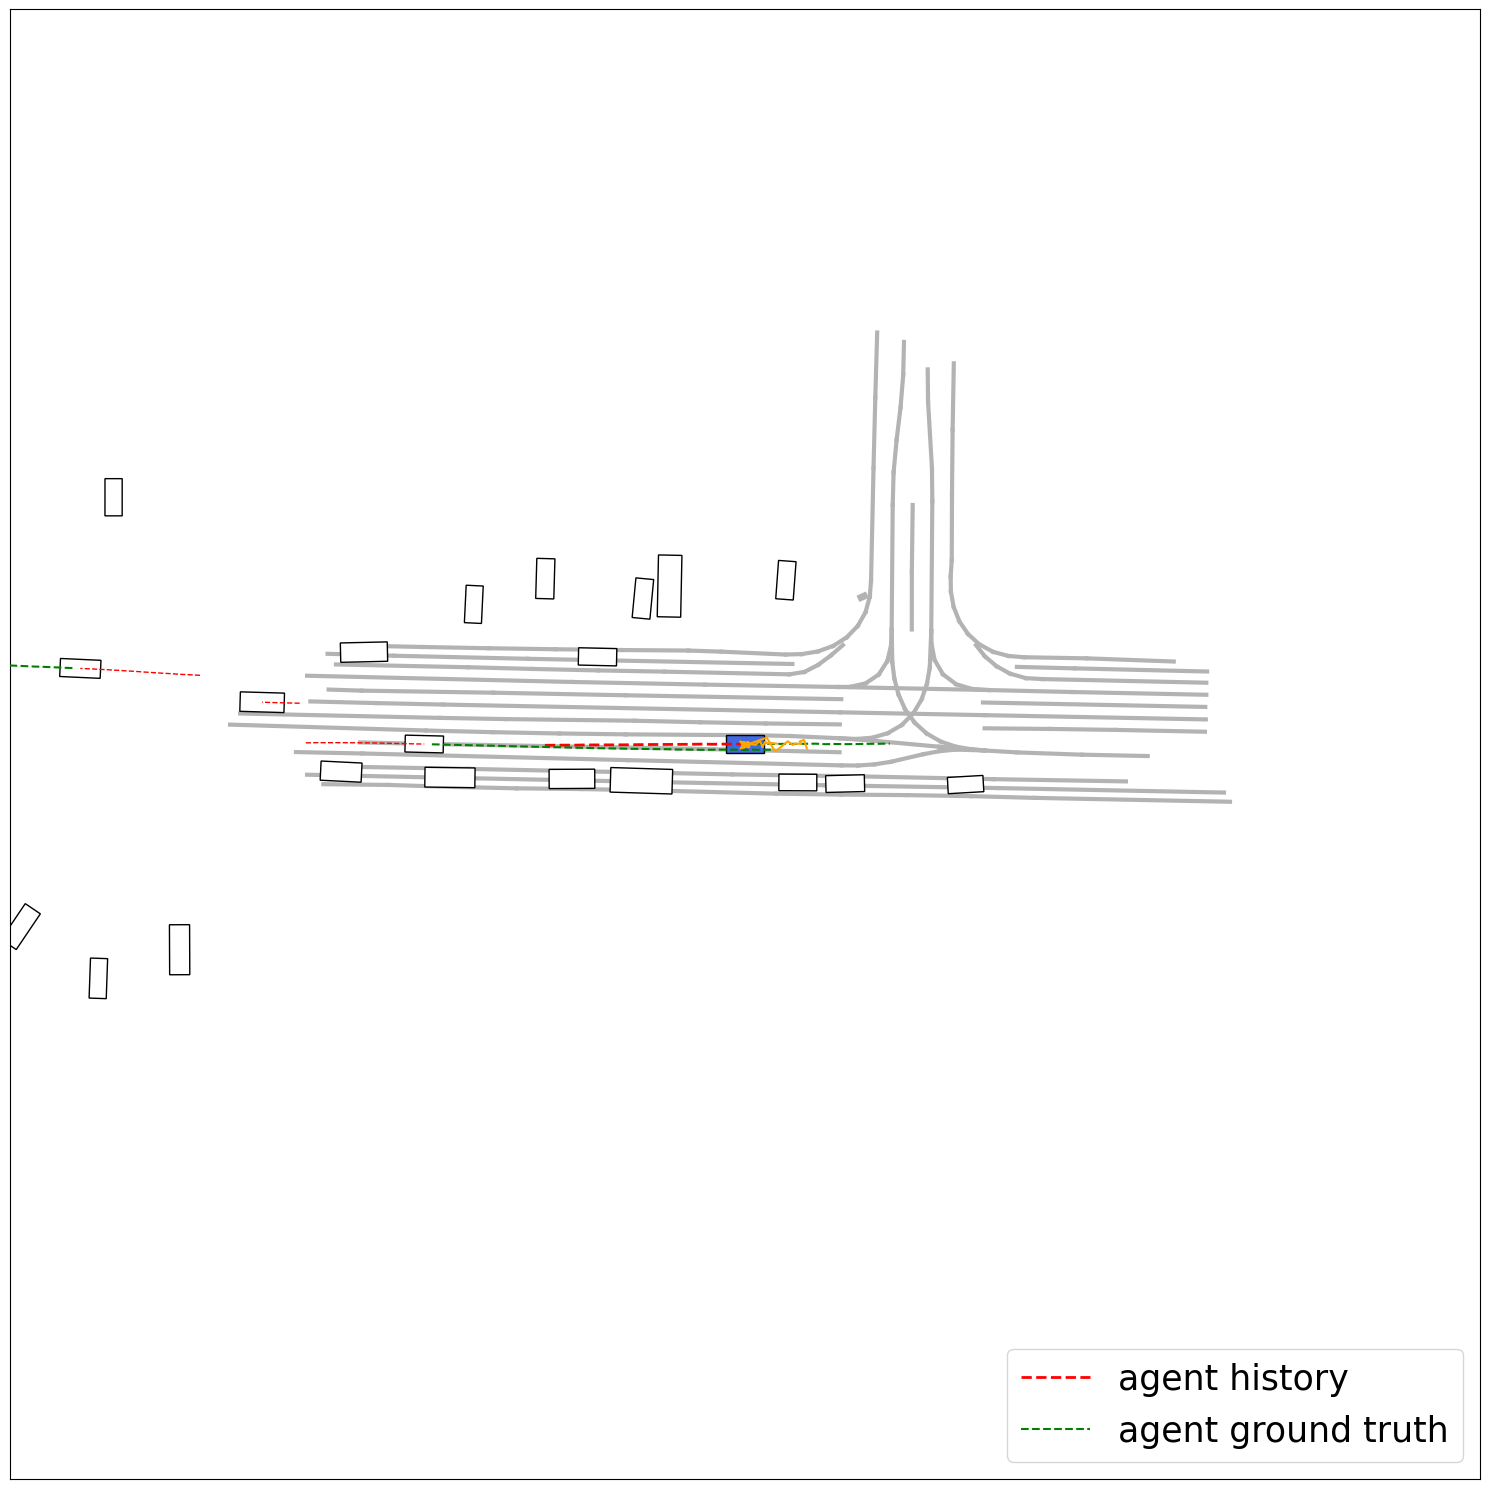

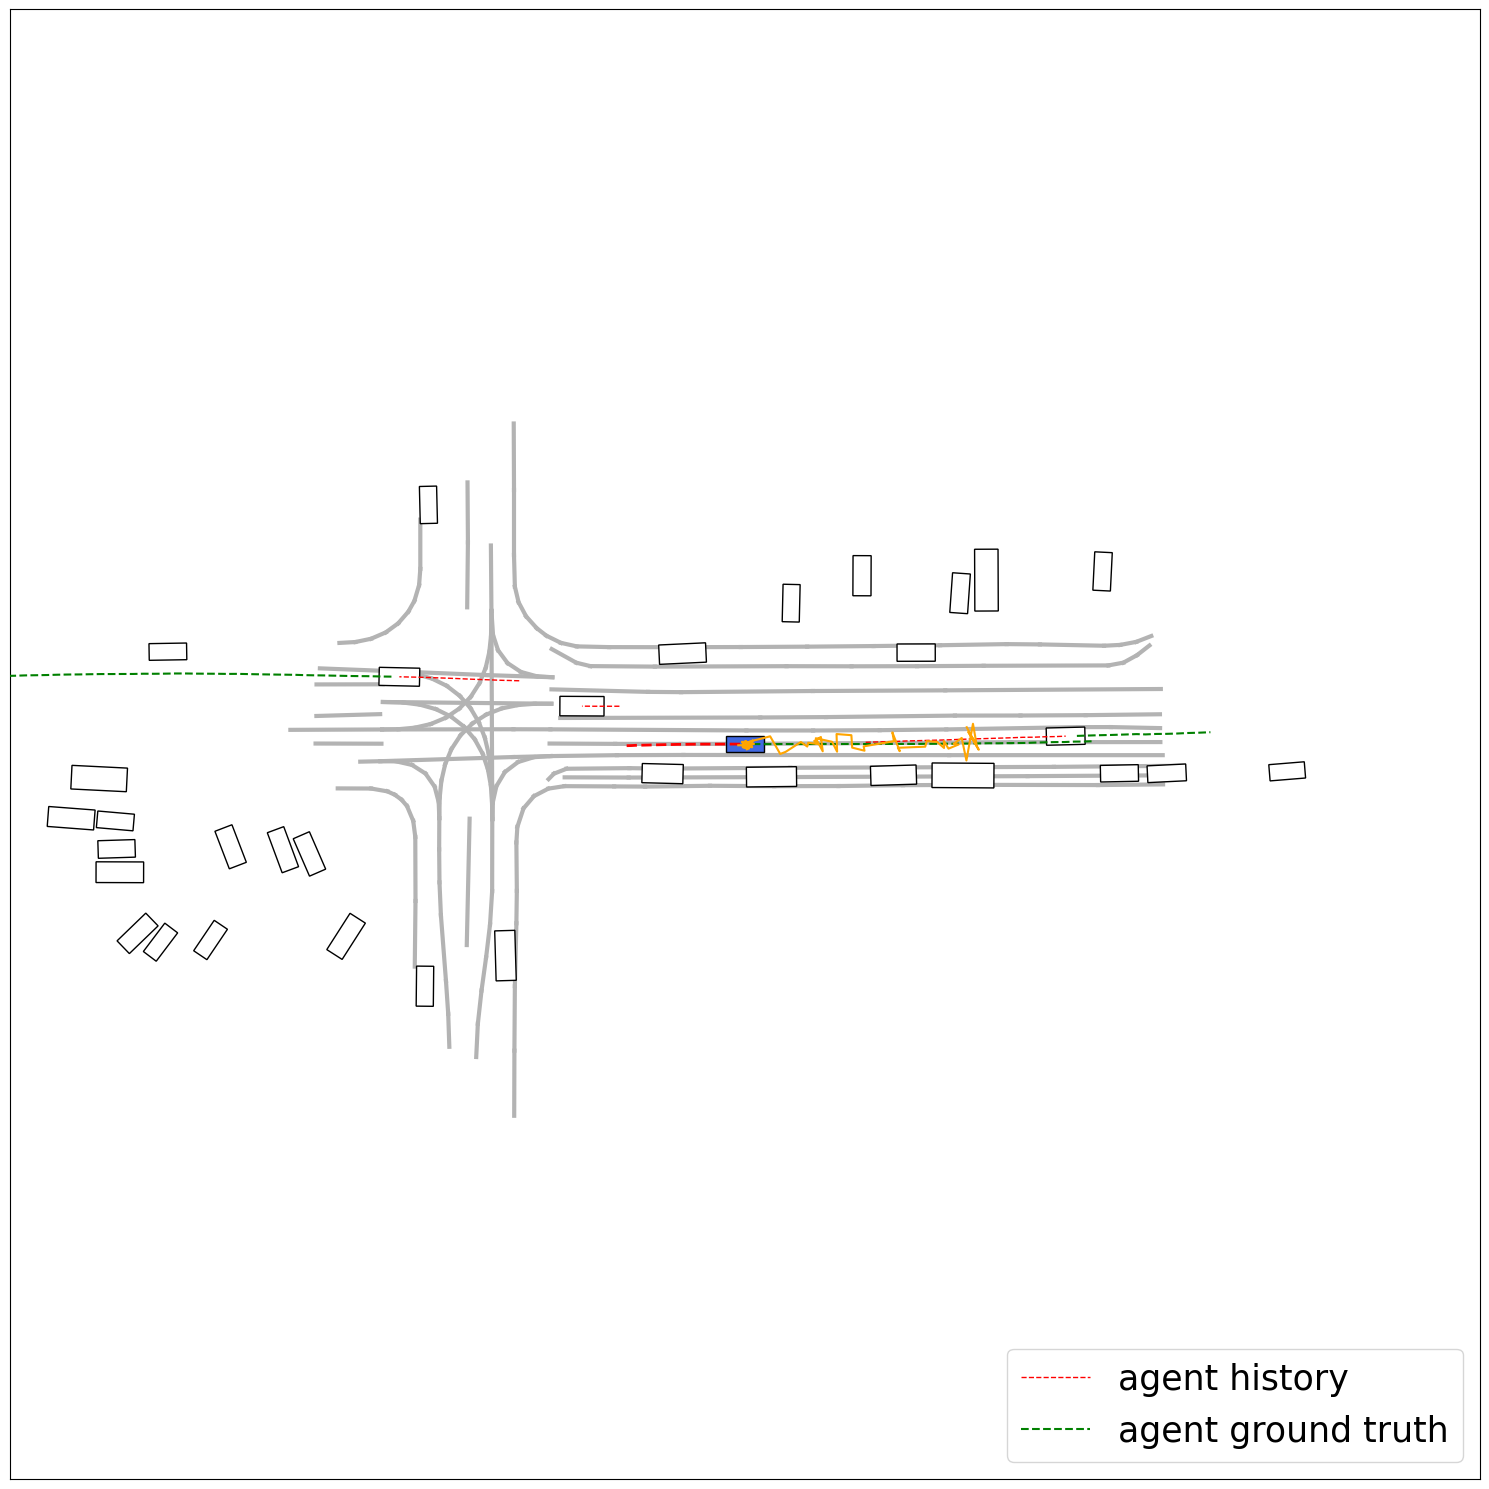

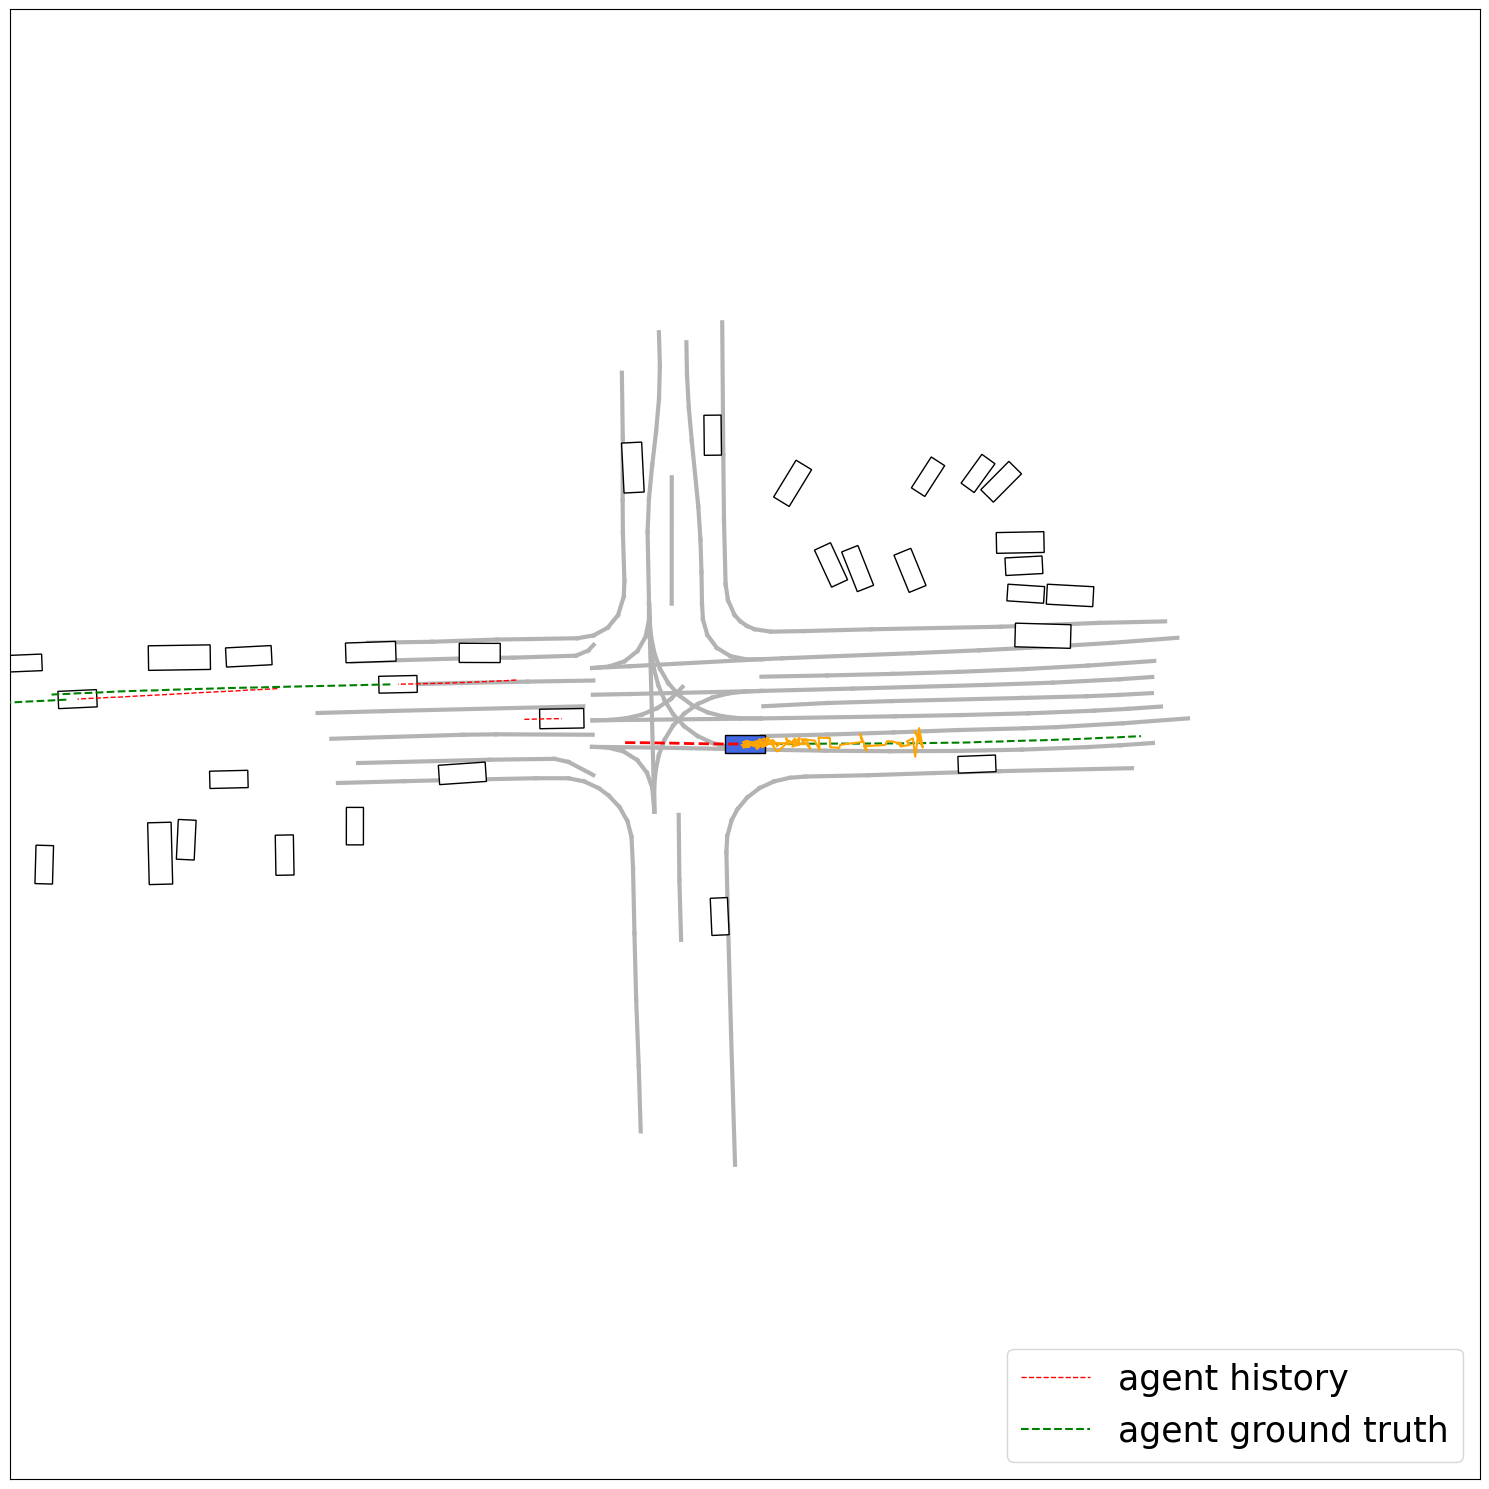

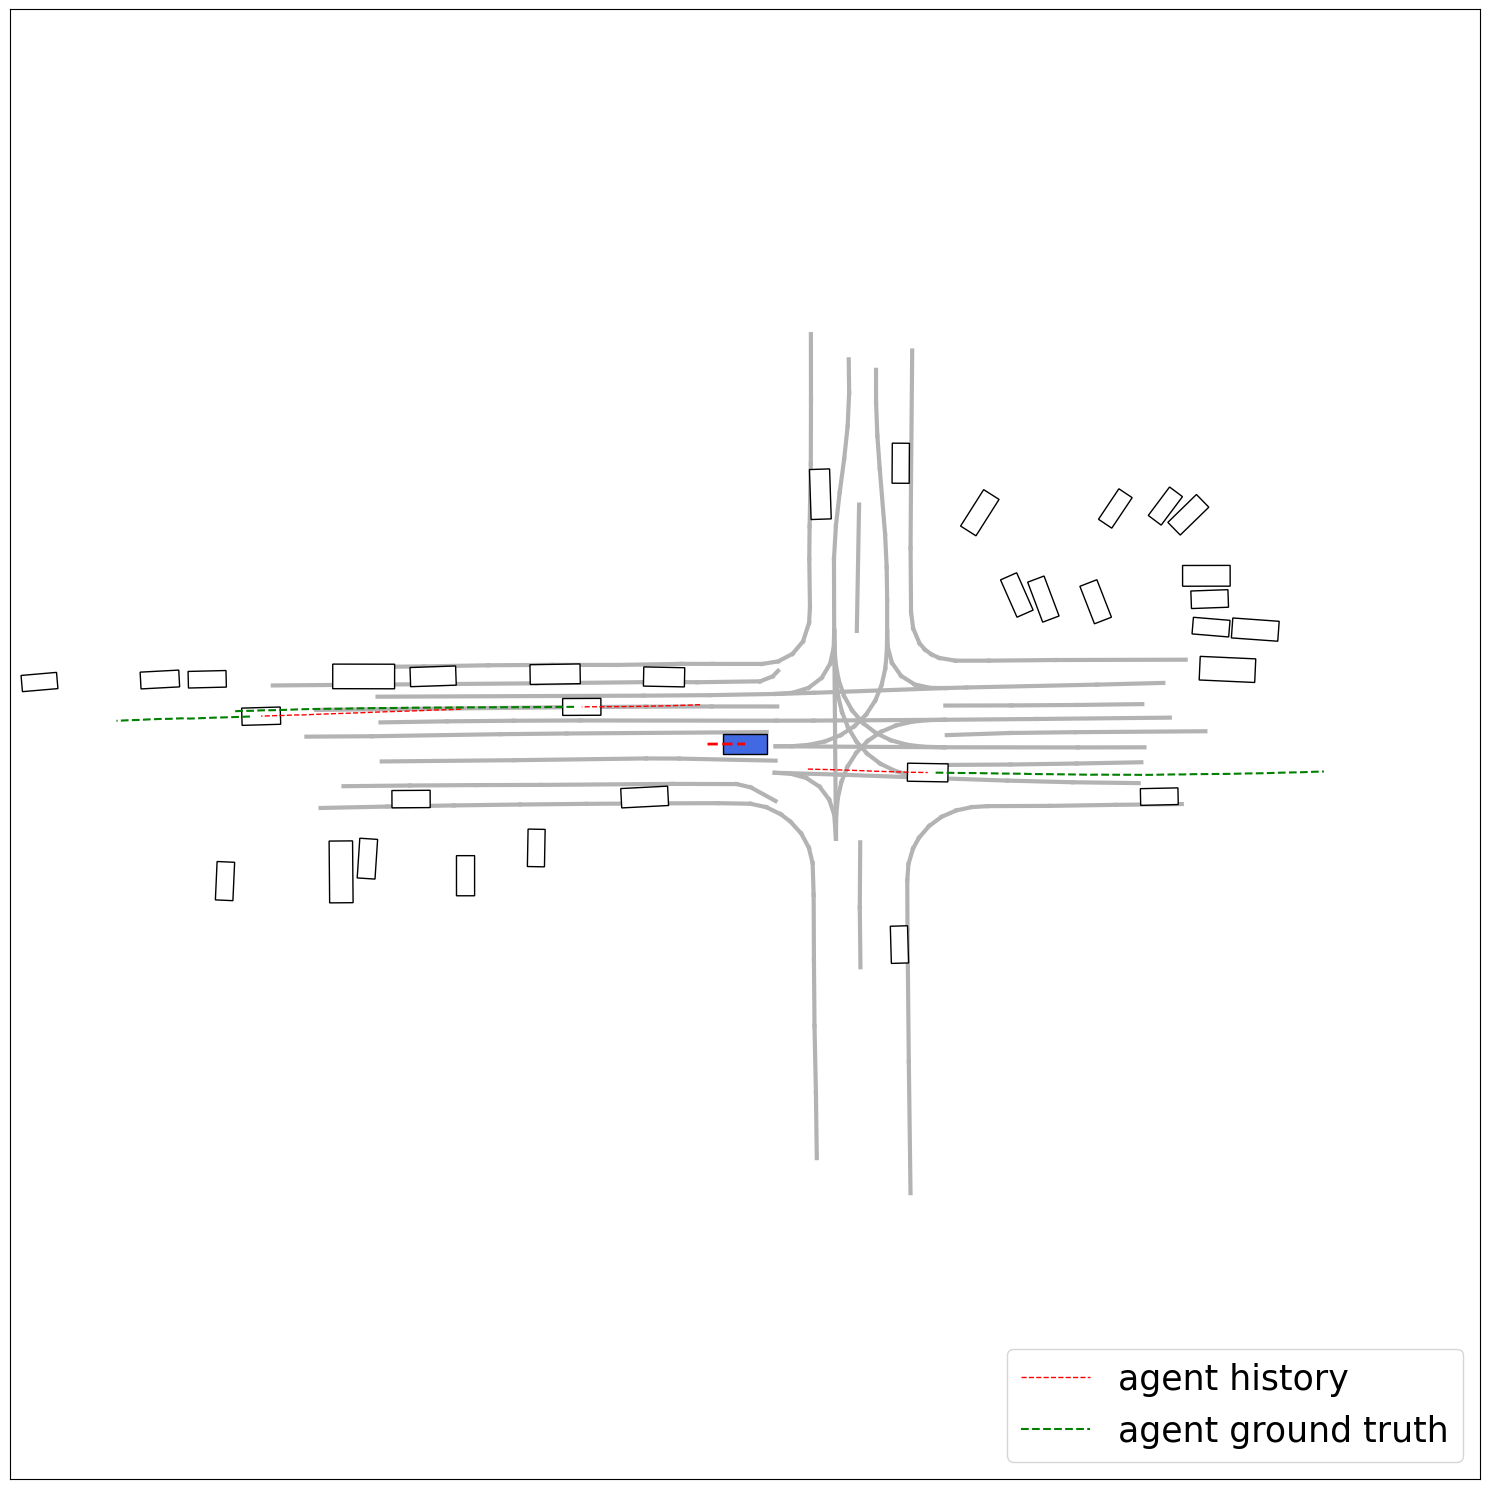

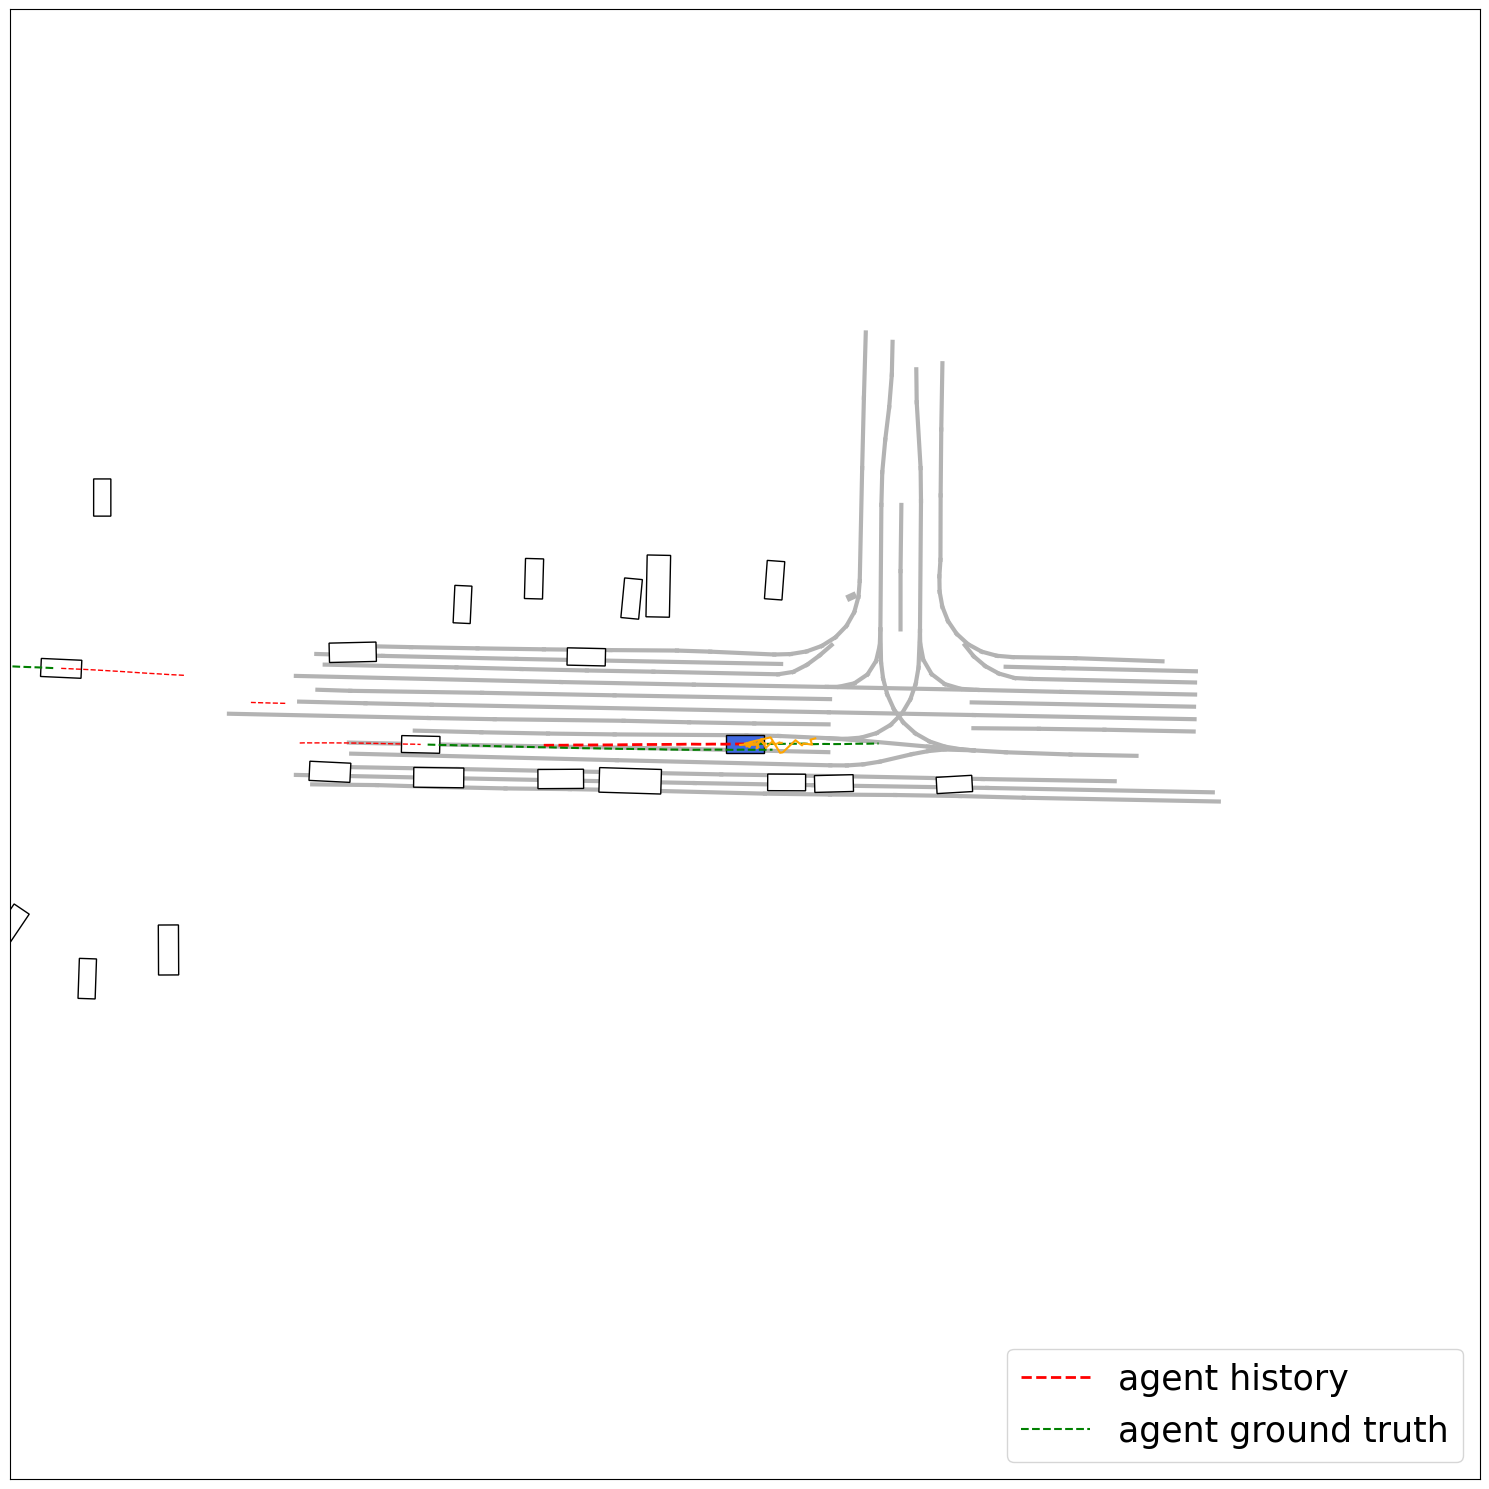

100%|██████████| 100/100 [00:08<00:00, 11.16it/s]
INFO:root:Epoch: 1, Last loss: 66.52911376953125


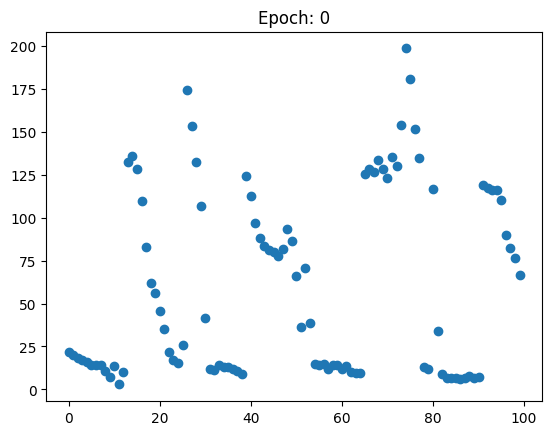

 98%|█████████▊| 98/100 [00:07<00:00, 16.56it/s]

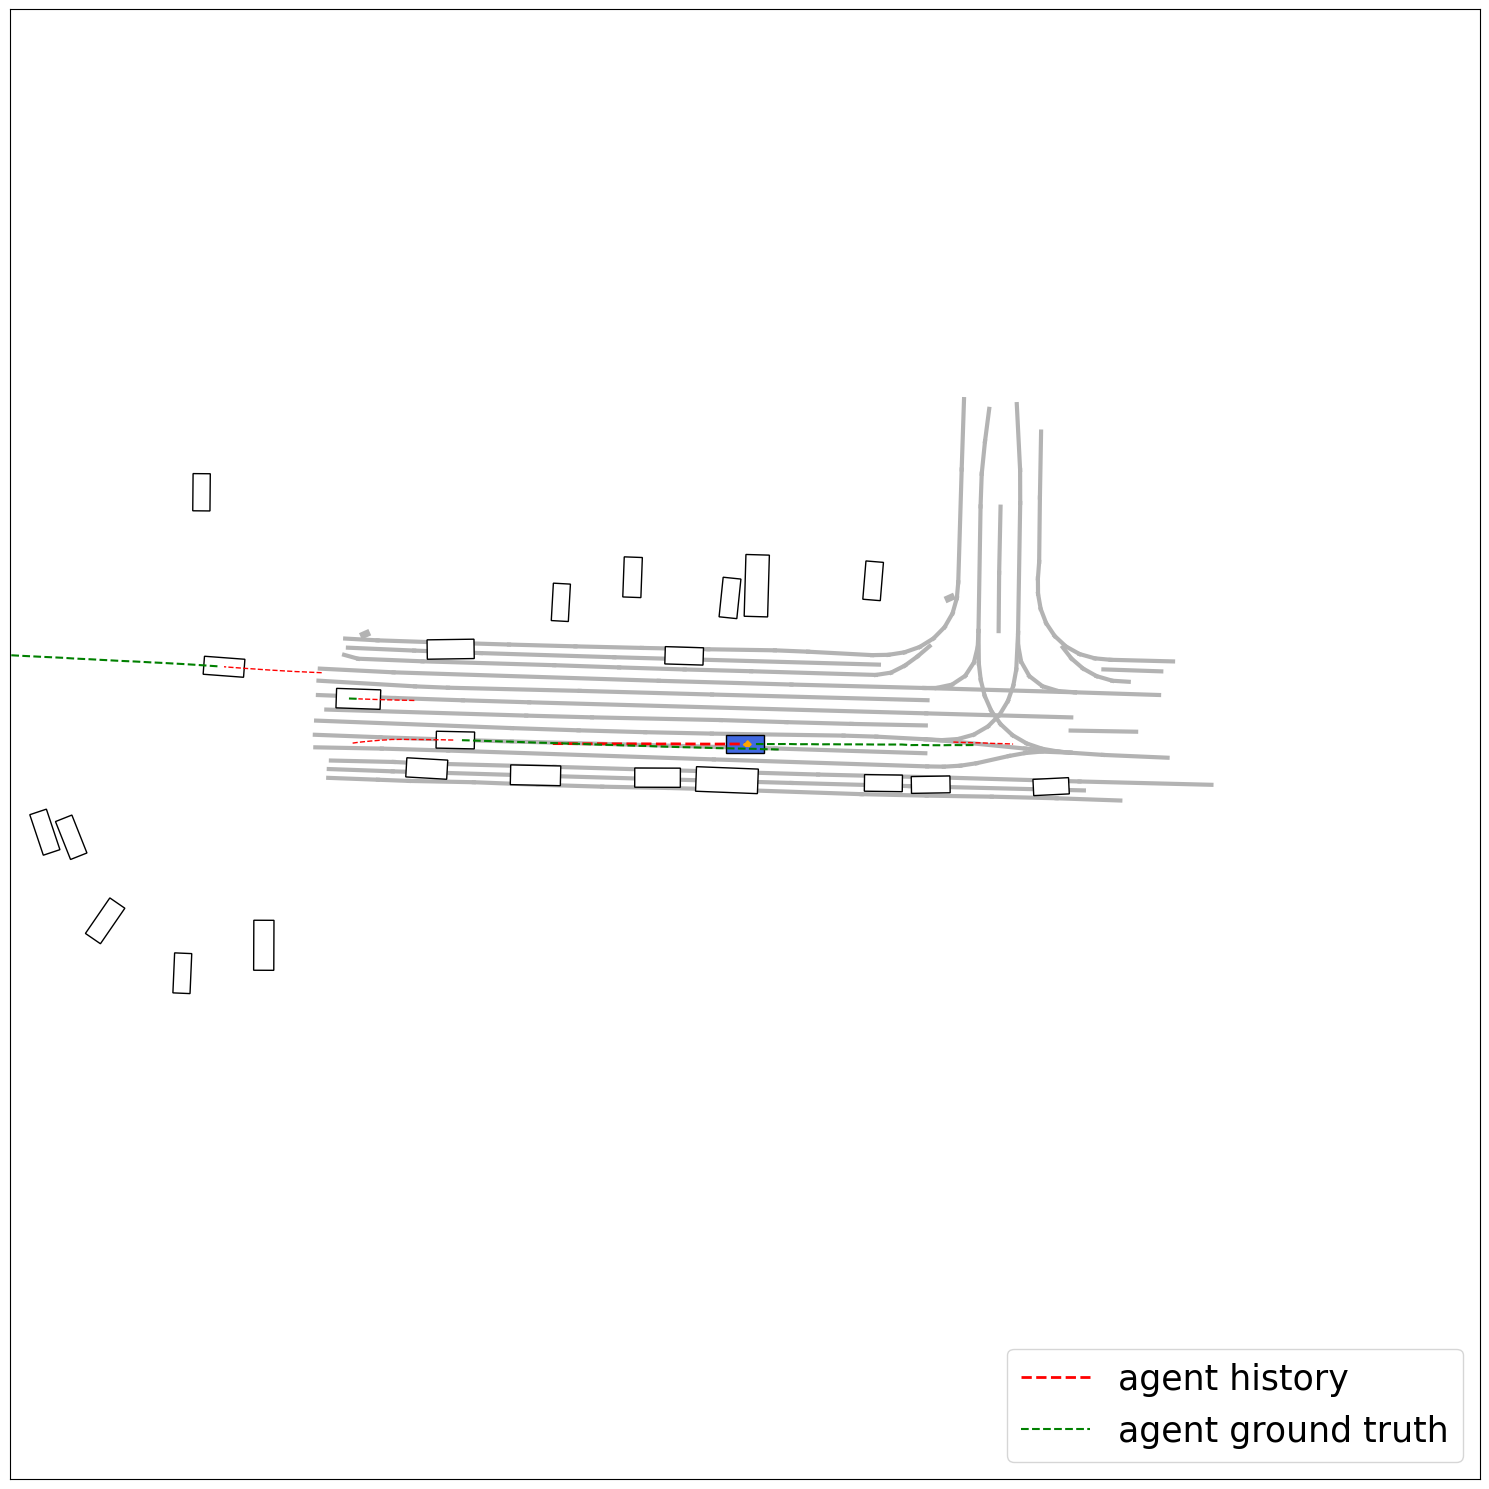

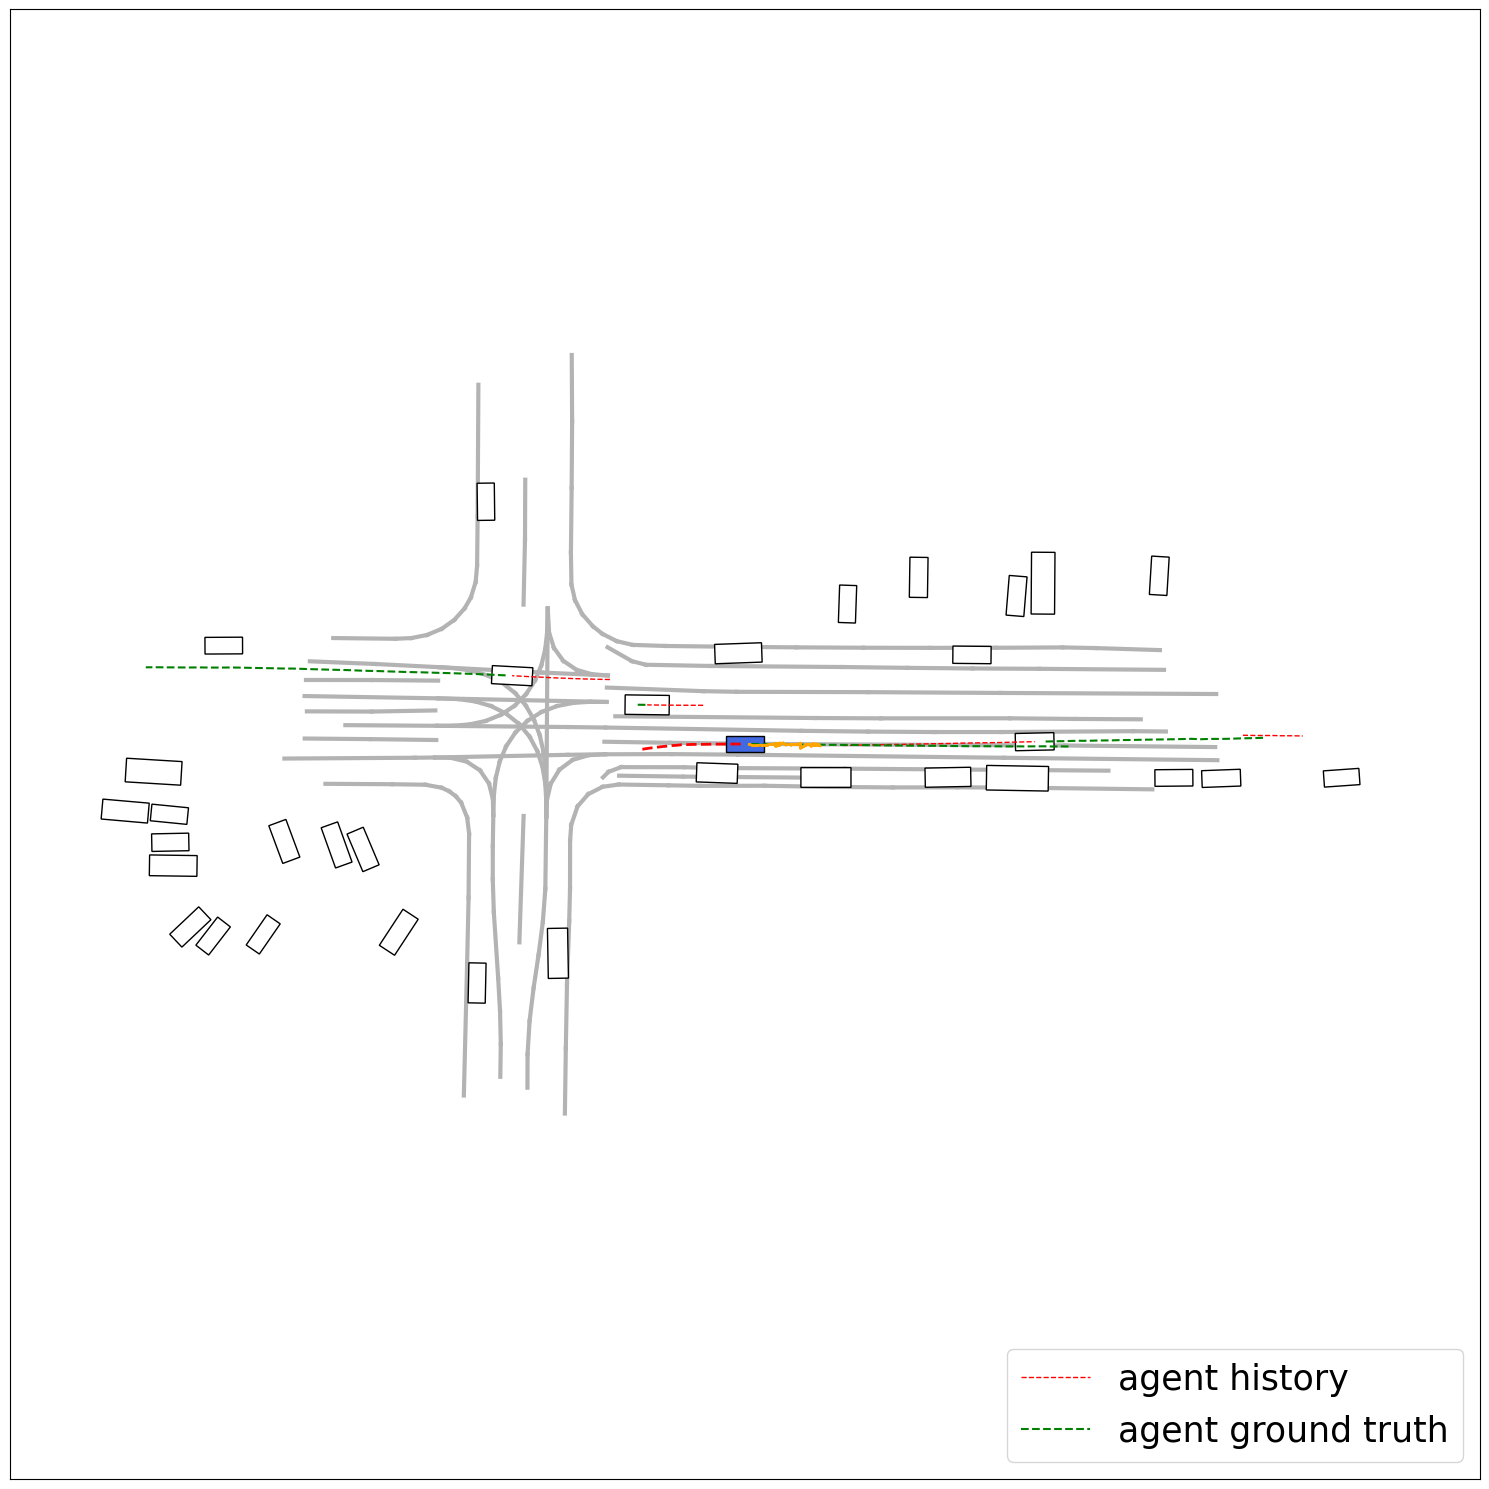

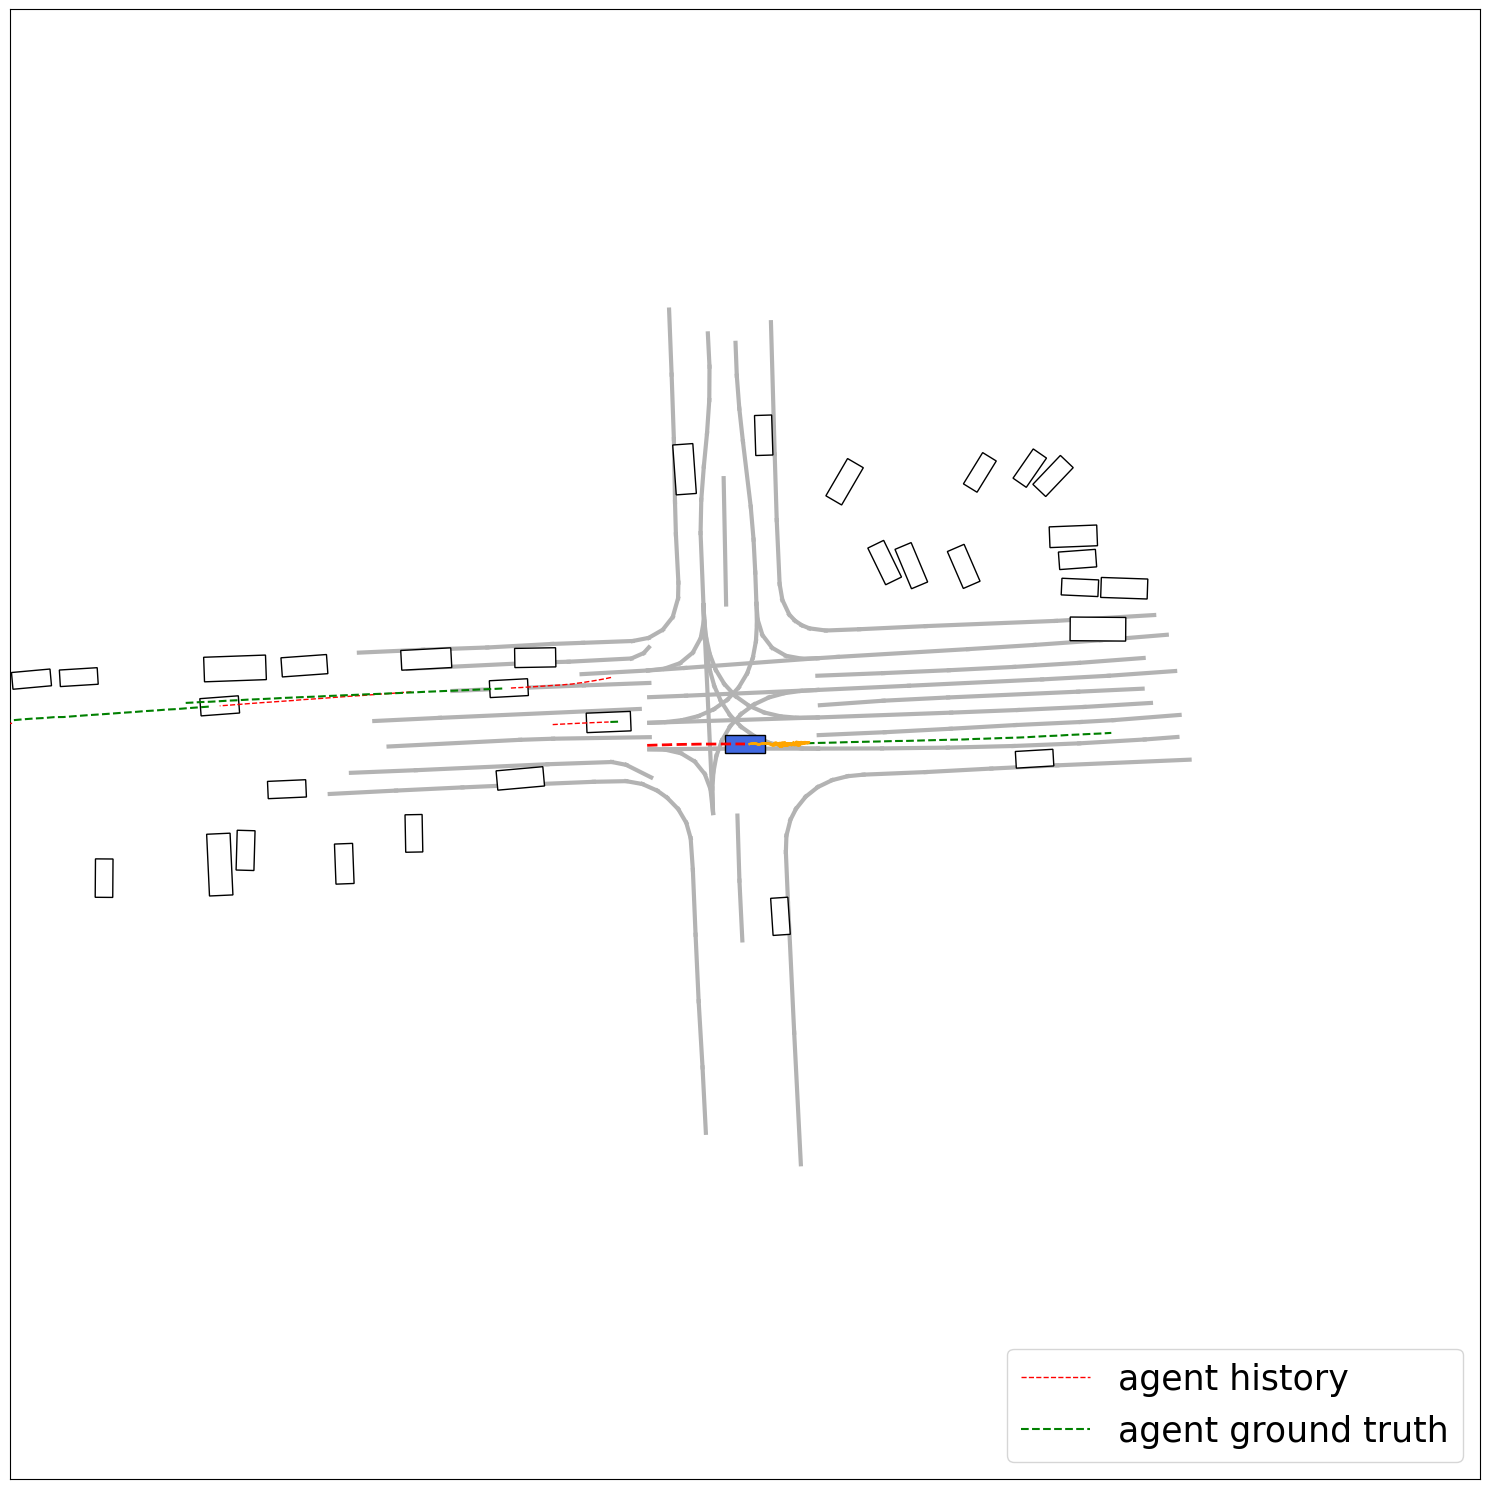

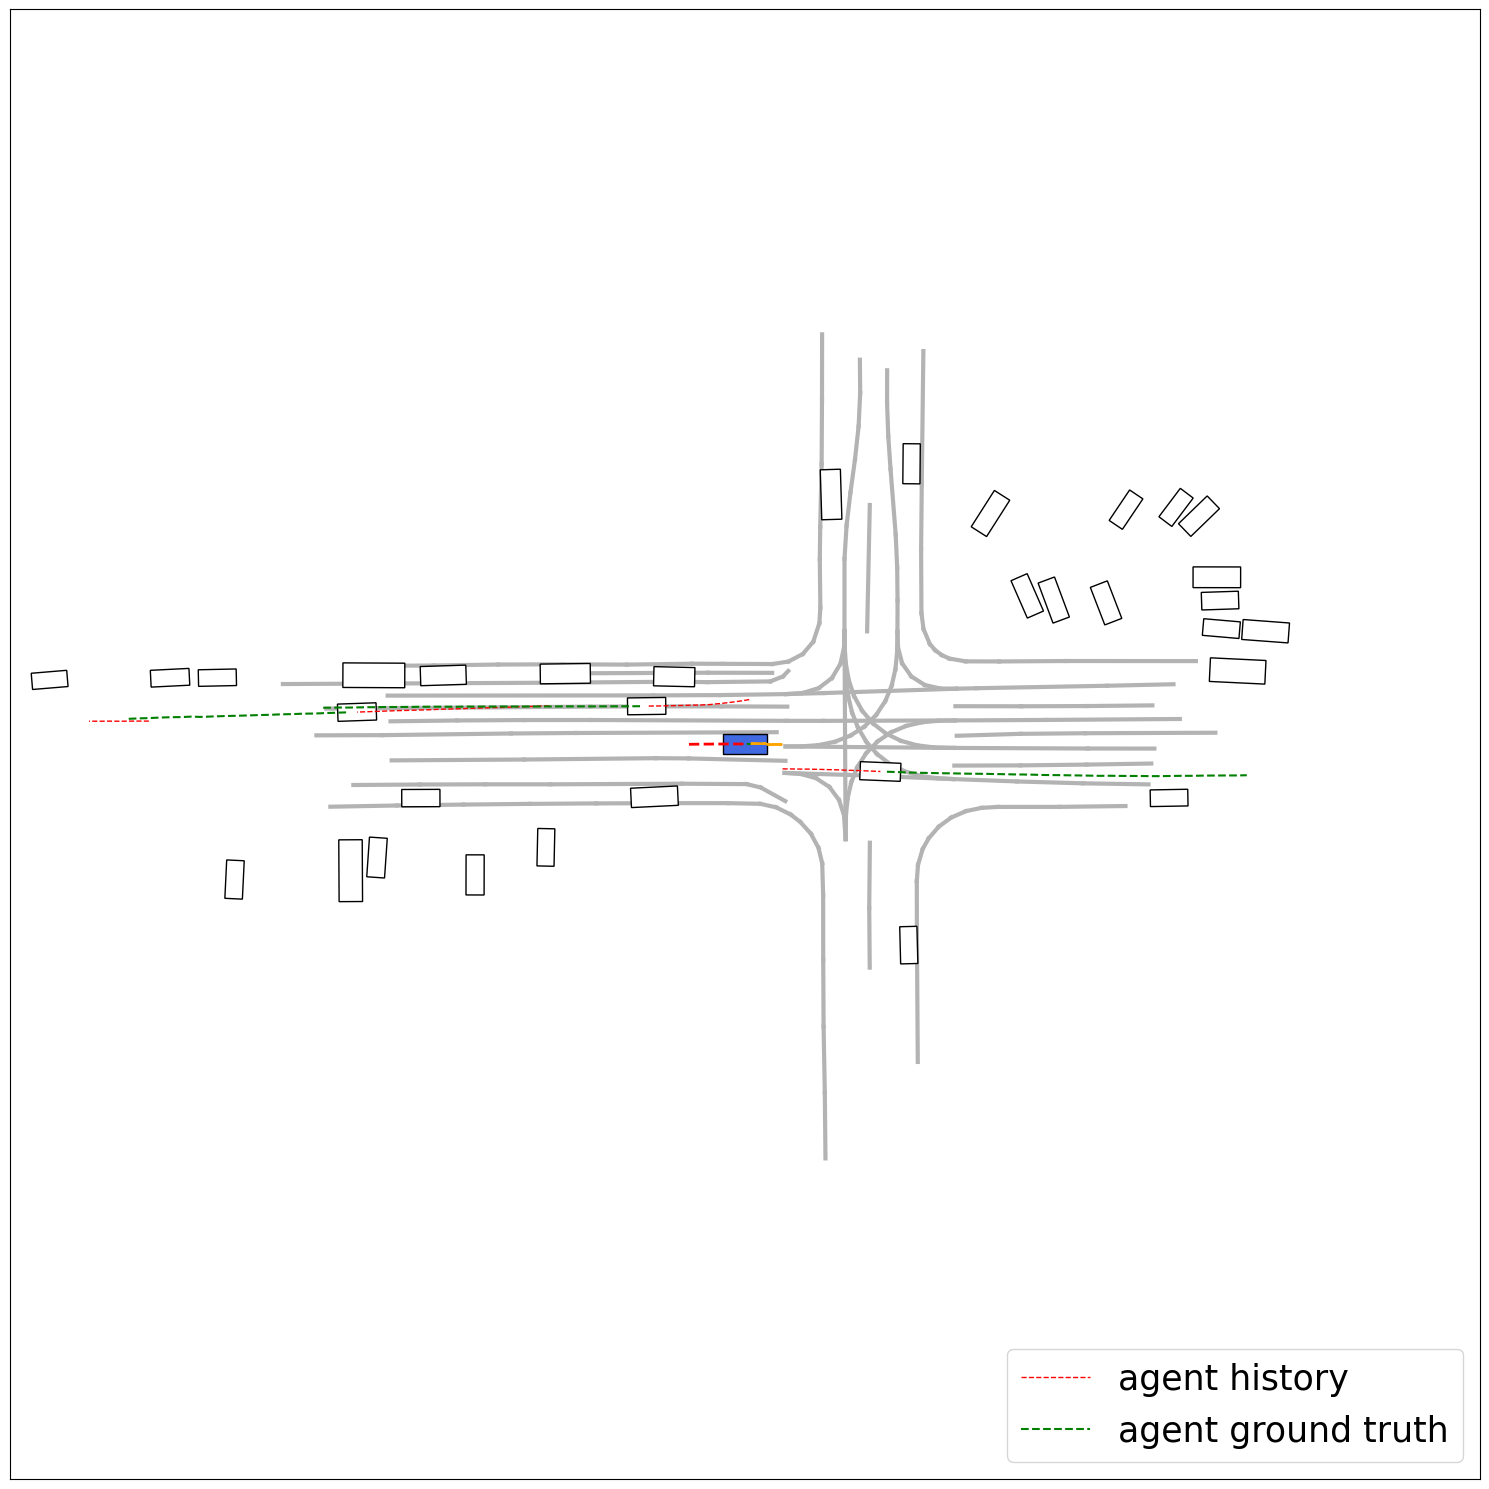

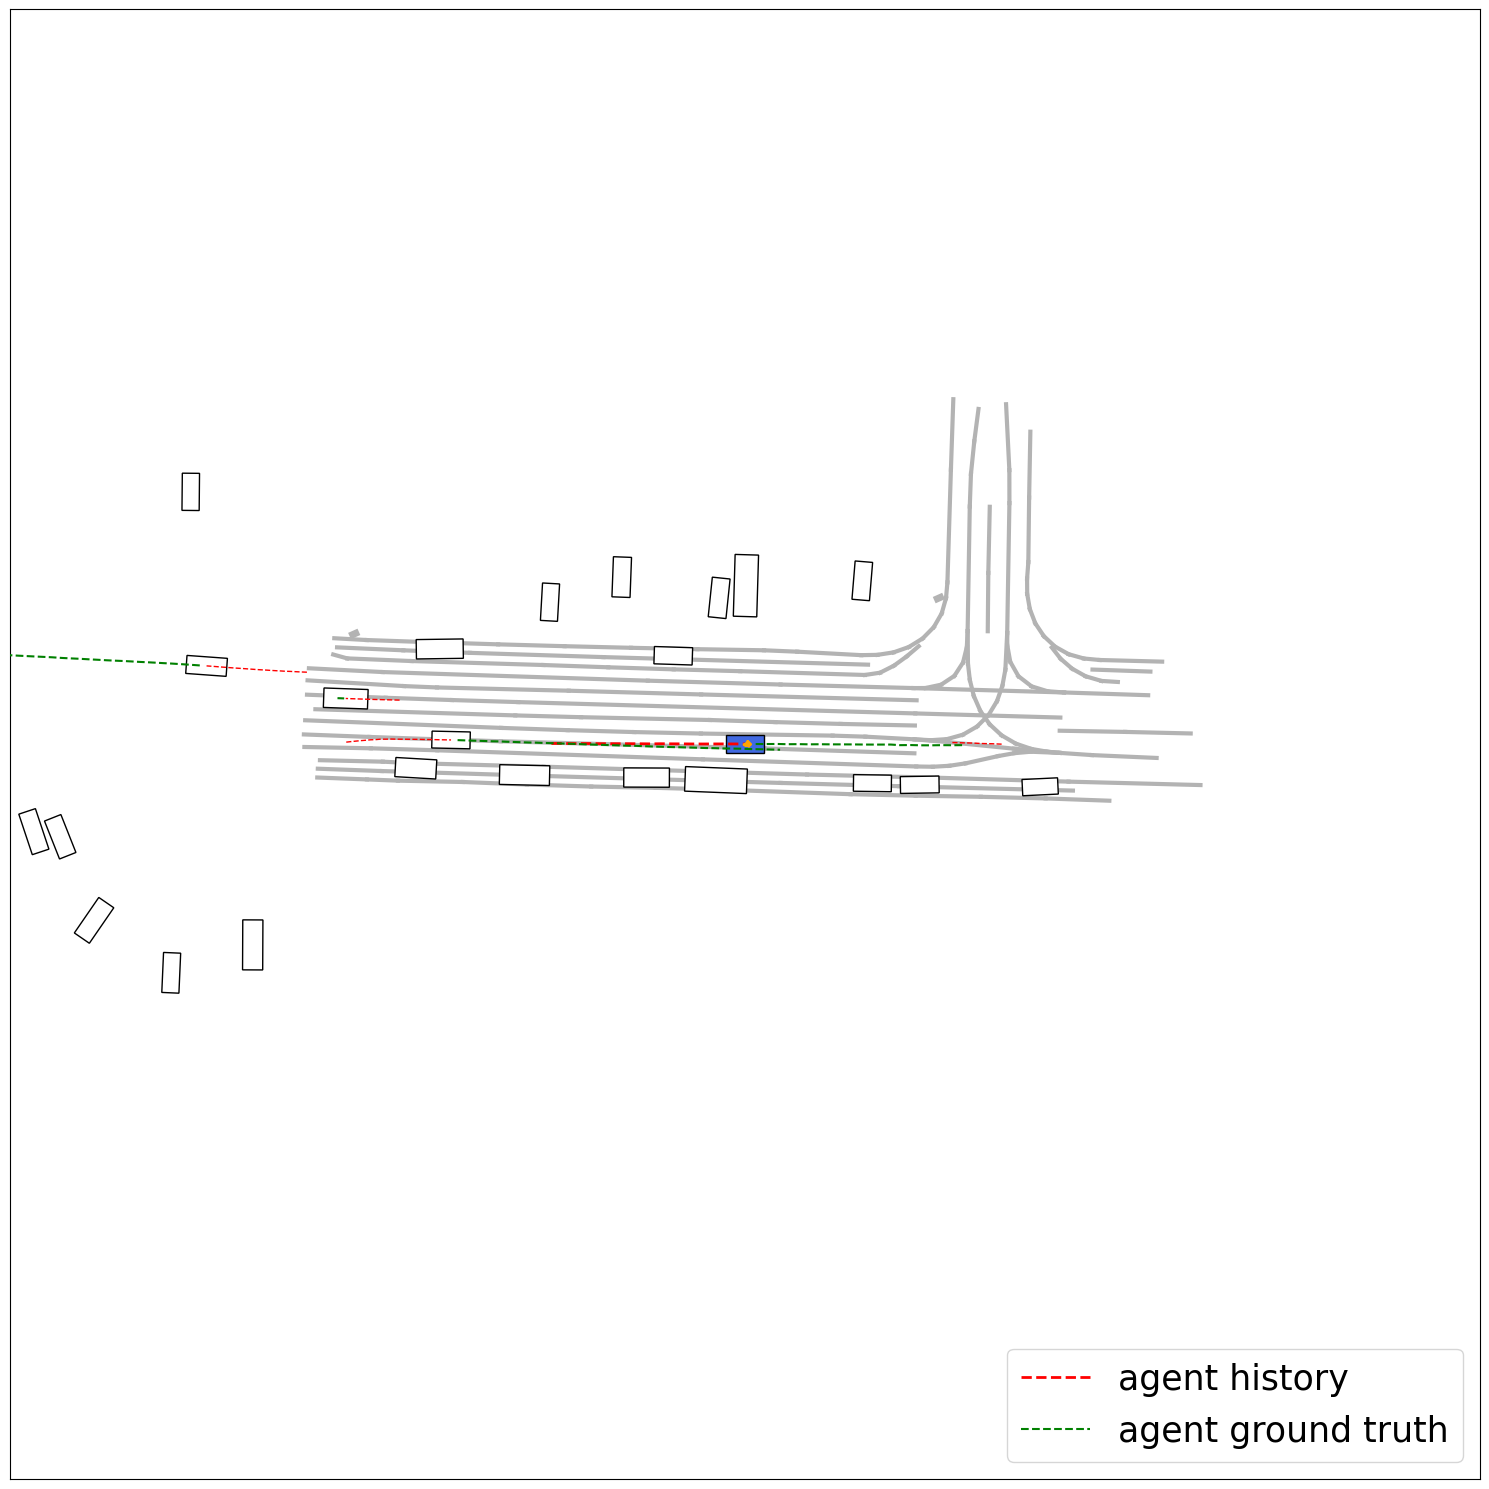

100%|██████████| 100/100 [00:10<00:00,  9.87it/s]
INFO:root:Epoch: 2, Last loss: 96.45218658447266


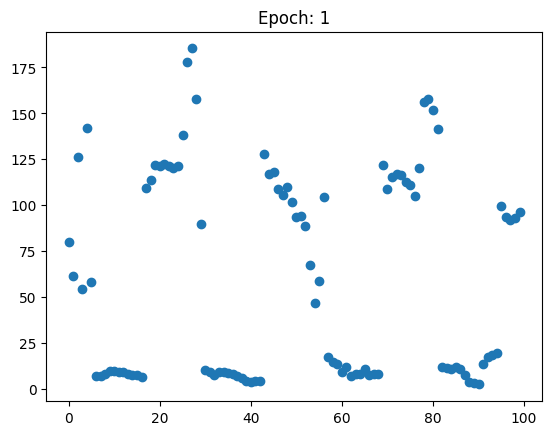

 99%|█████████▉| 99/100 [00:07<00:00, 14.70it/s]

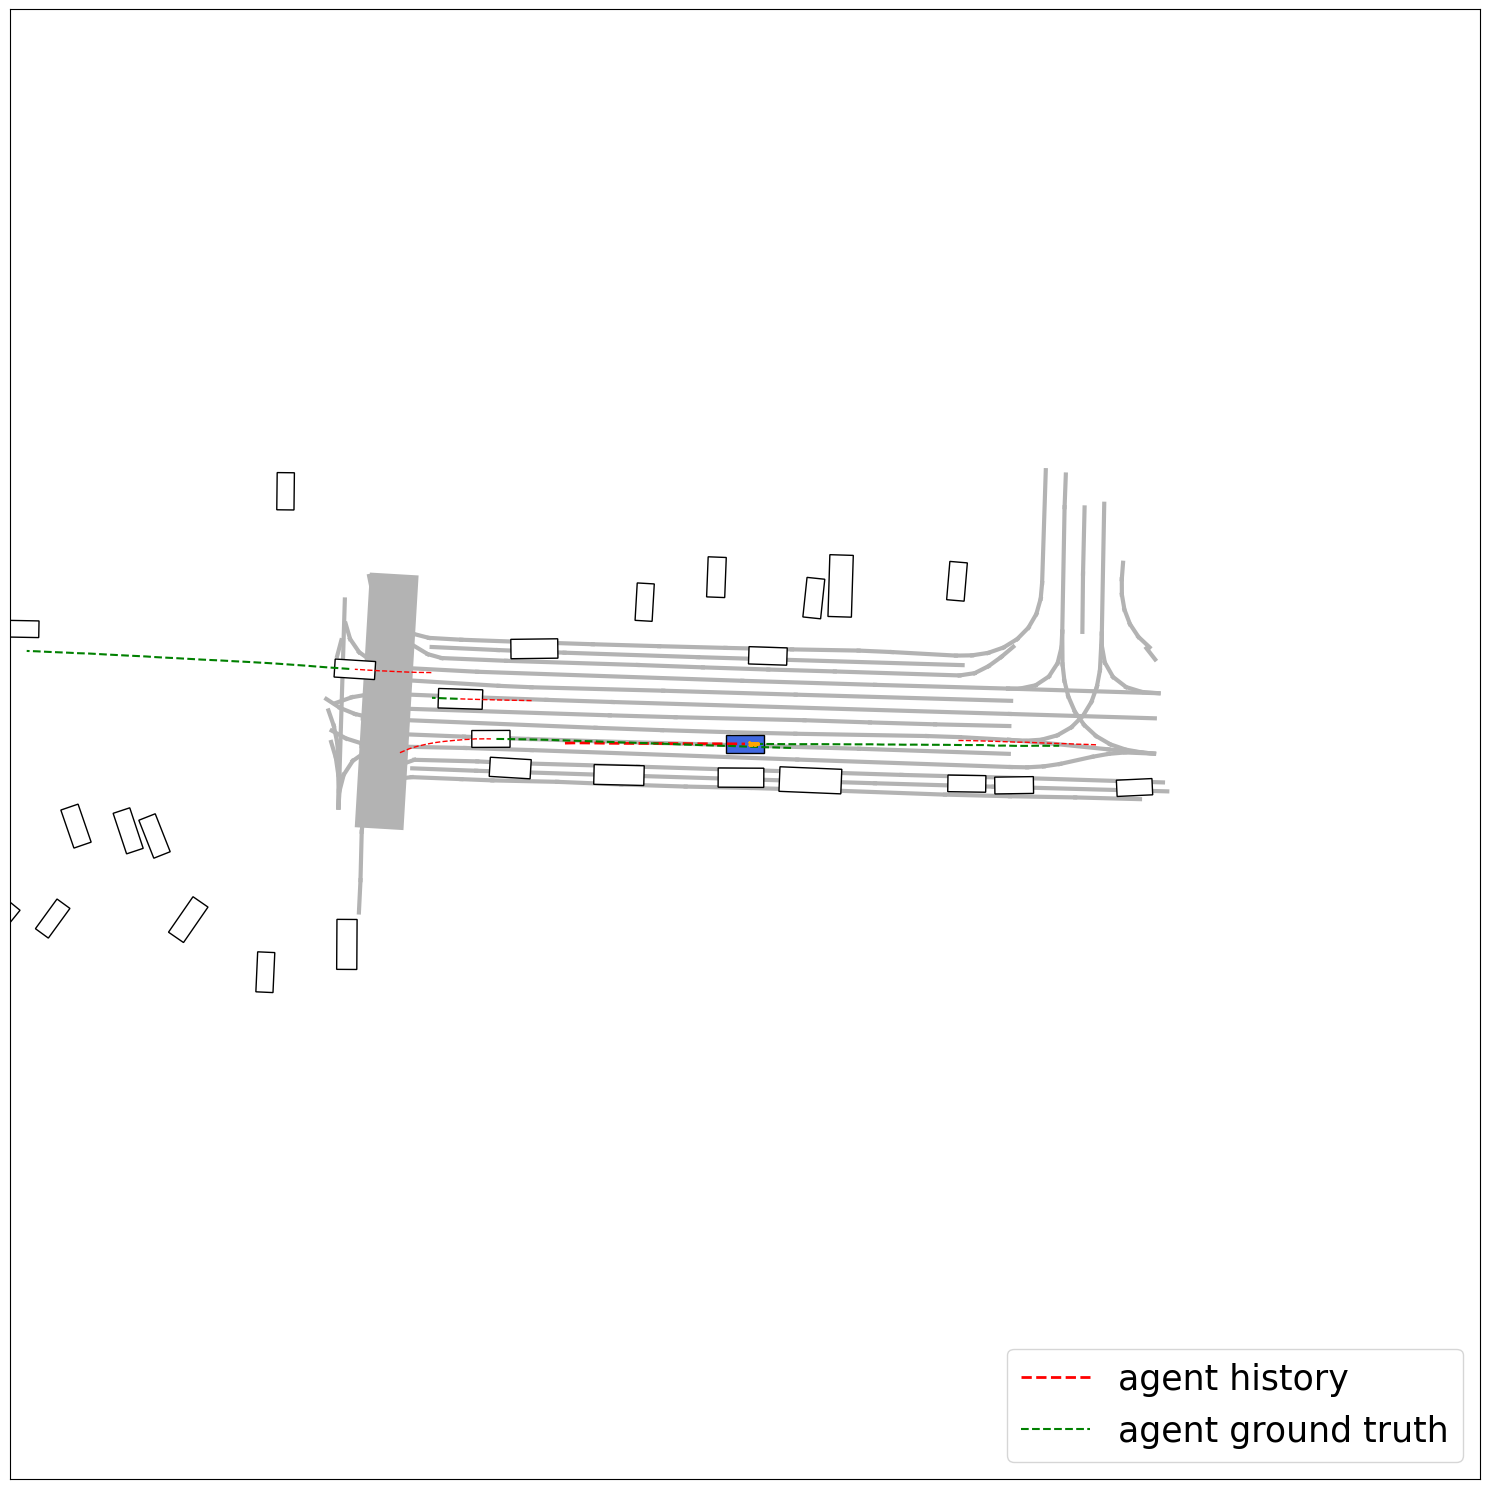

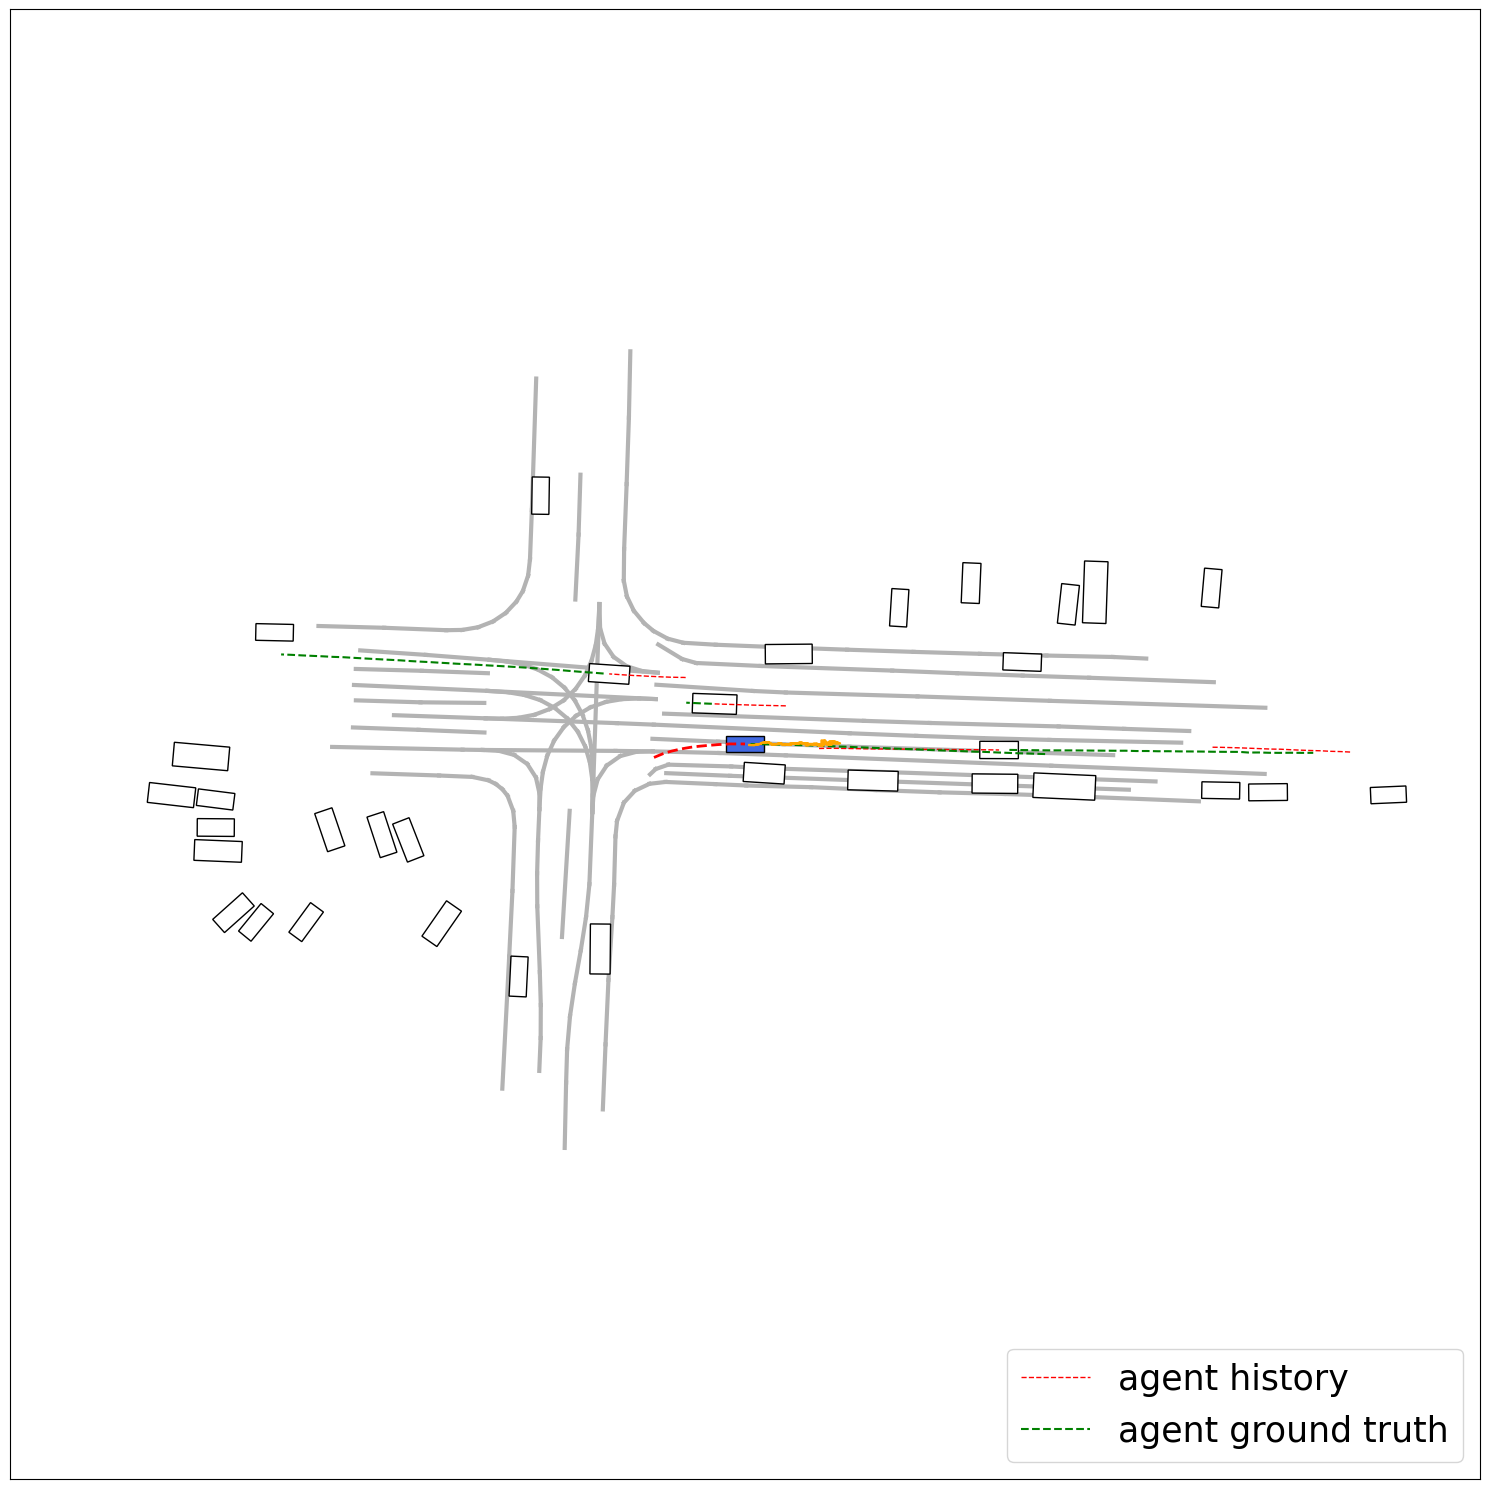

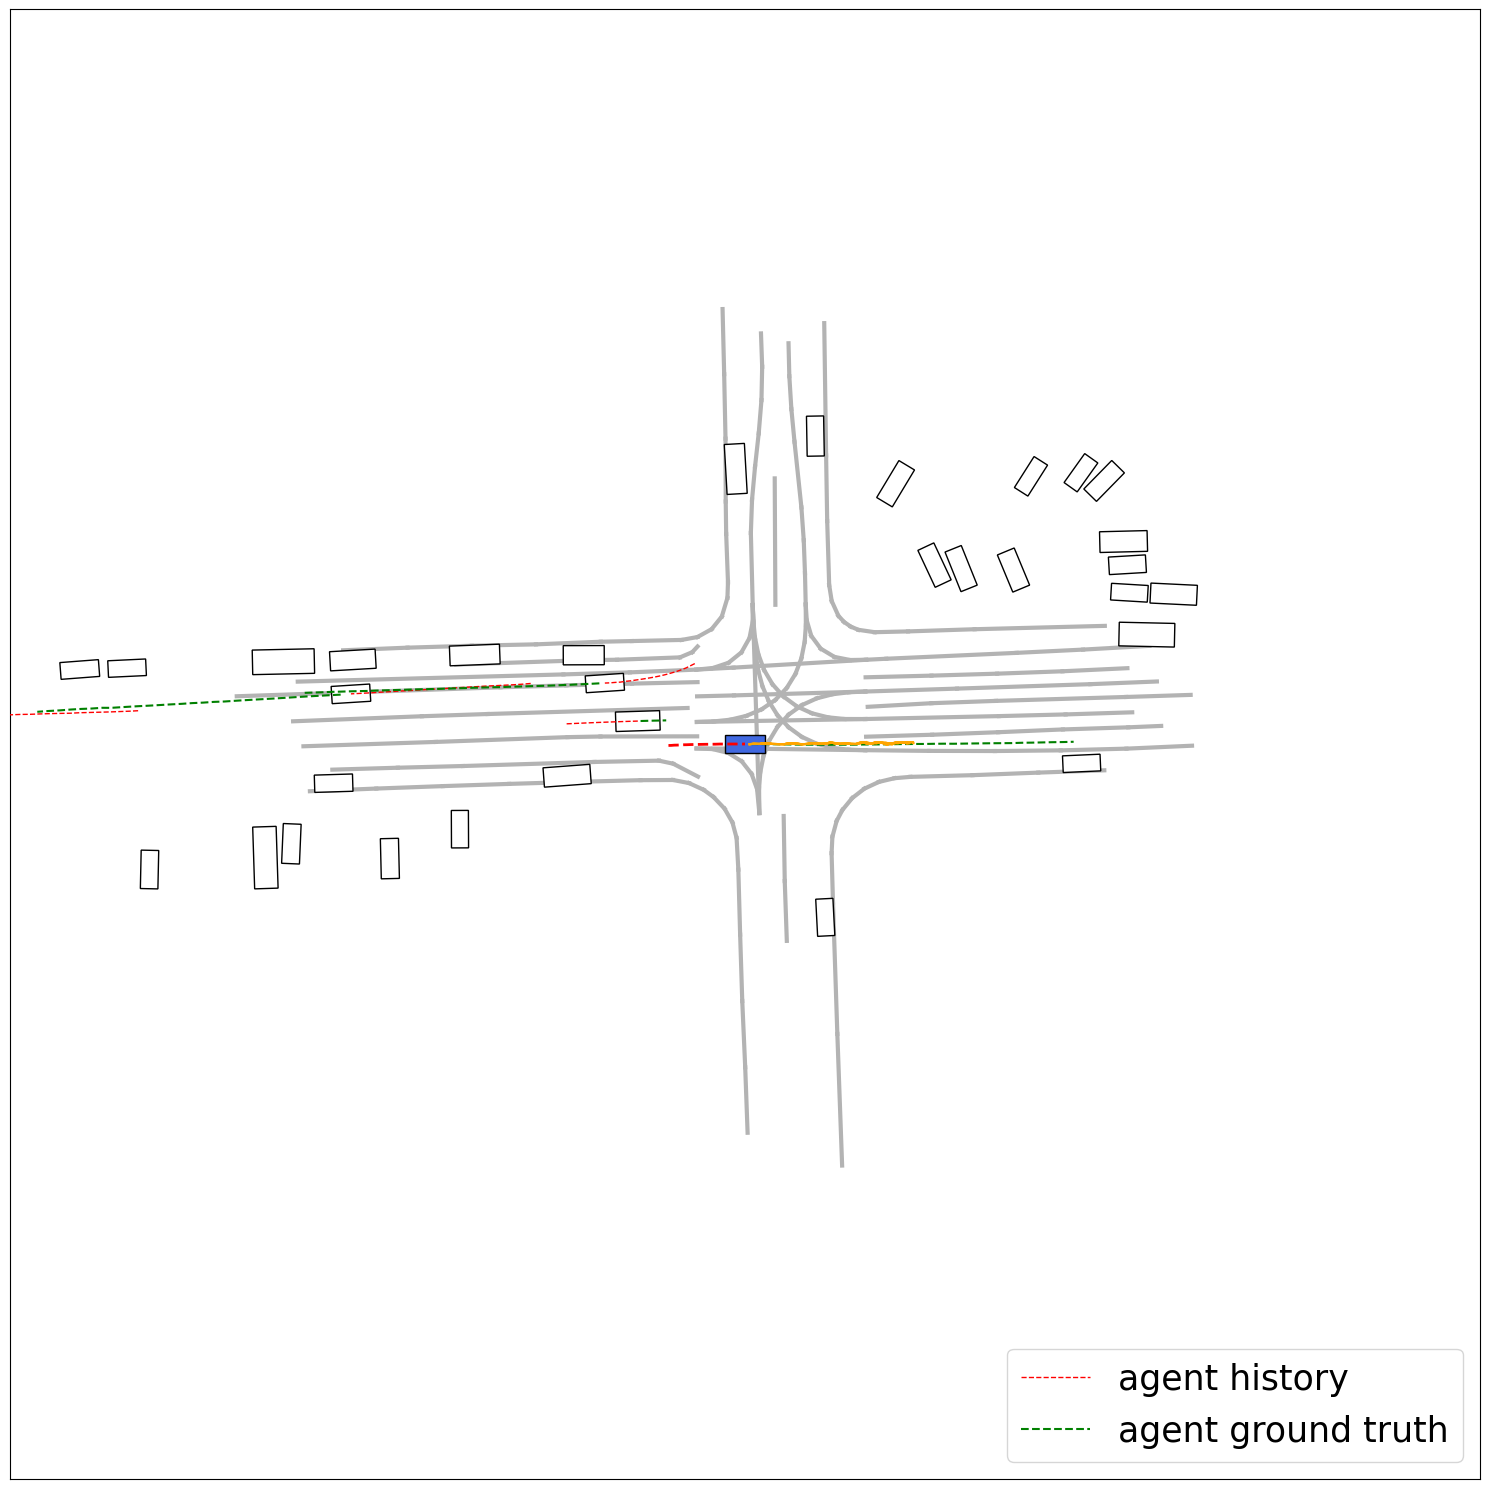

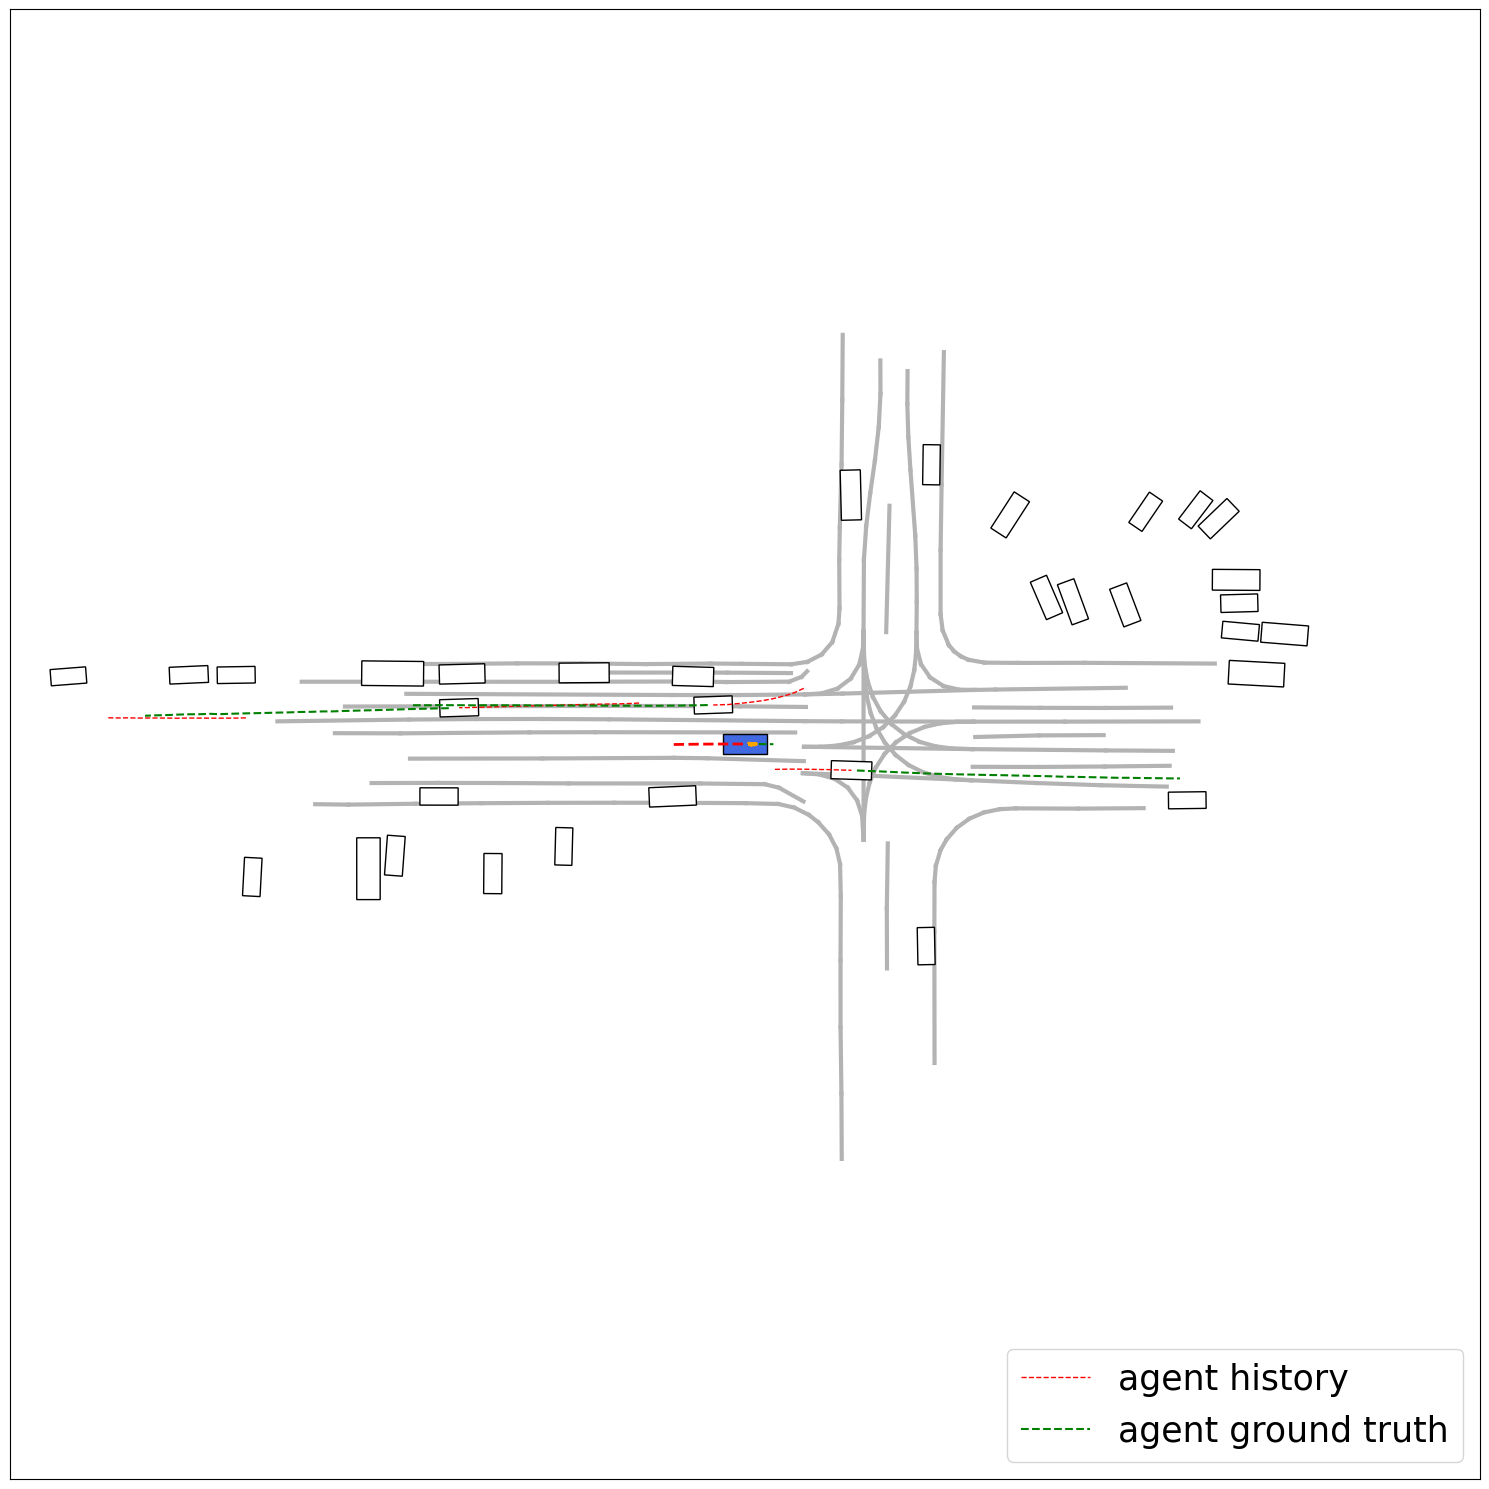

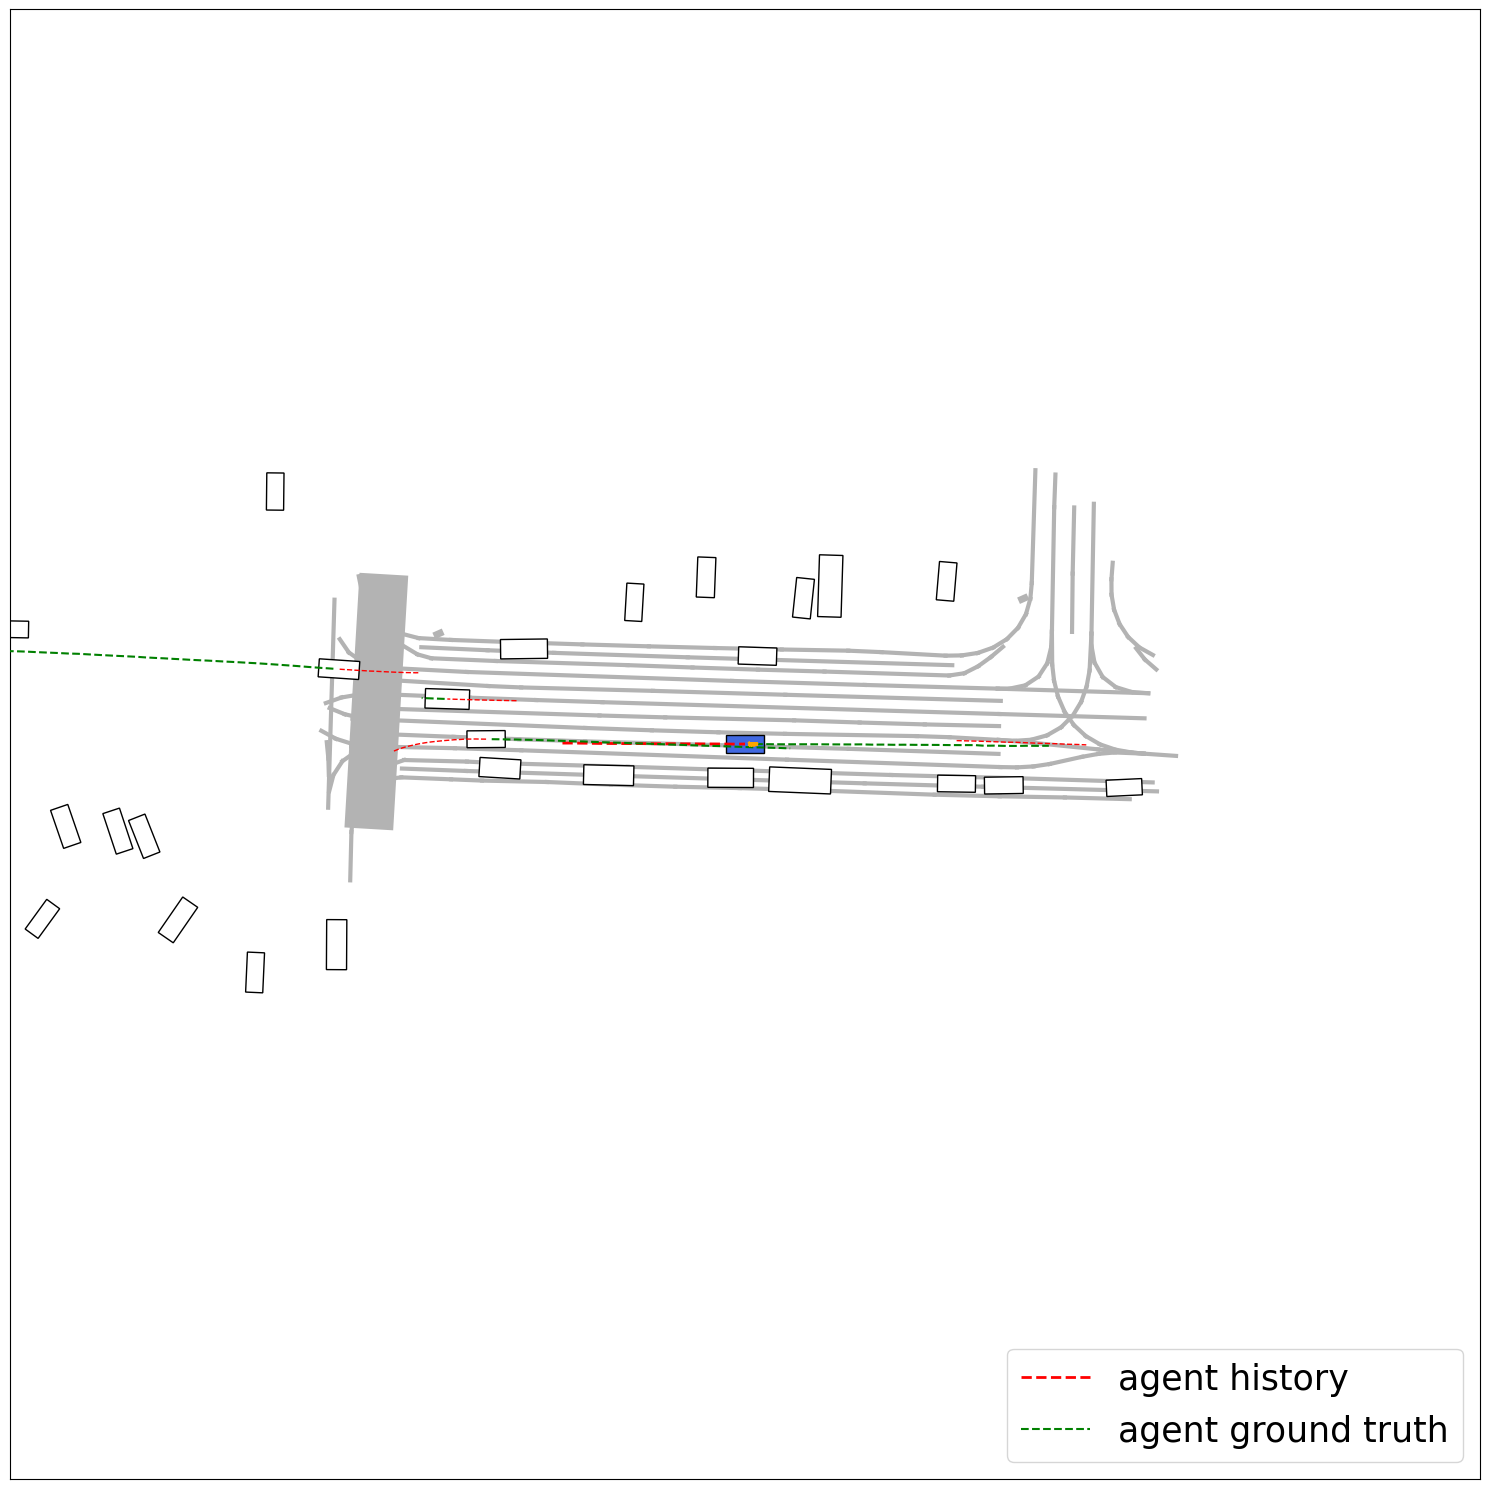

100%|██████████| 100/100 [00:08<00:00, 11.19it/s]
INFO:root:Epoch: 3, Last loss: 64.10200500488281


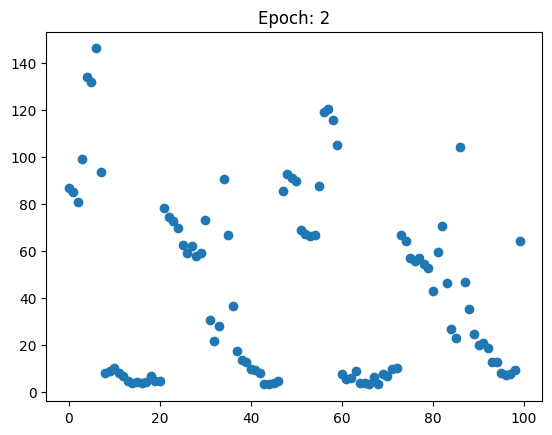

 99%|█████████▉| 99/100 [00:07<00:00, 12.68it/s]

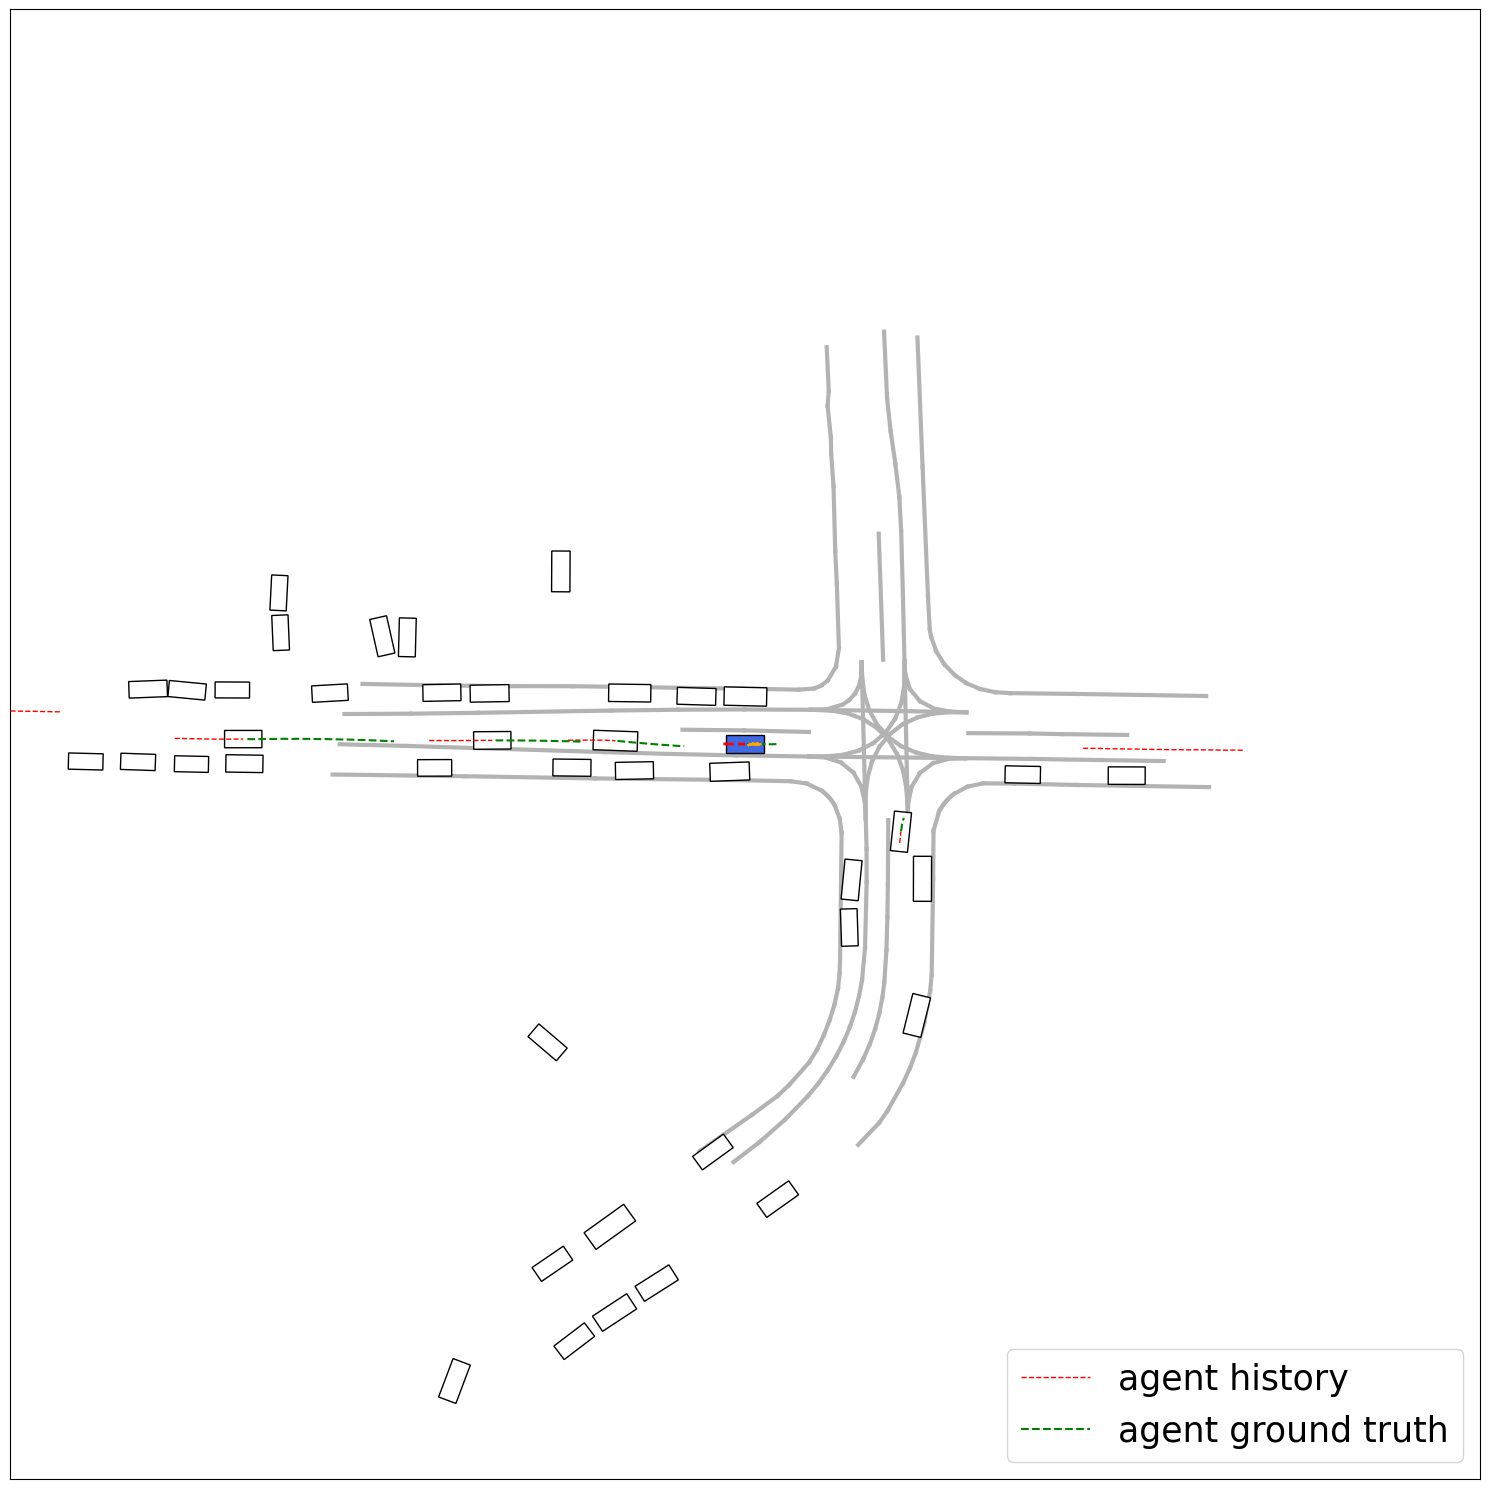

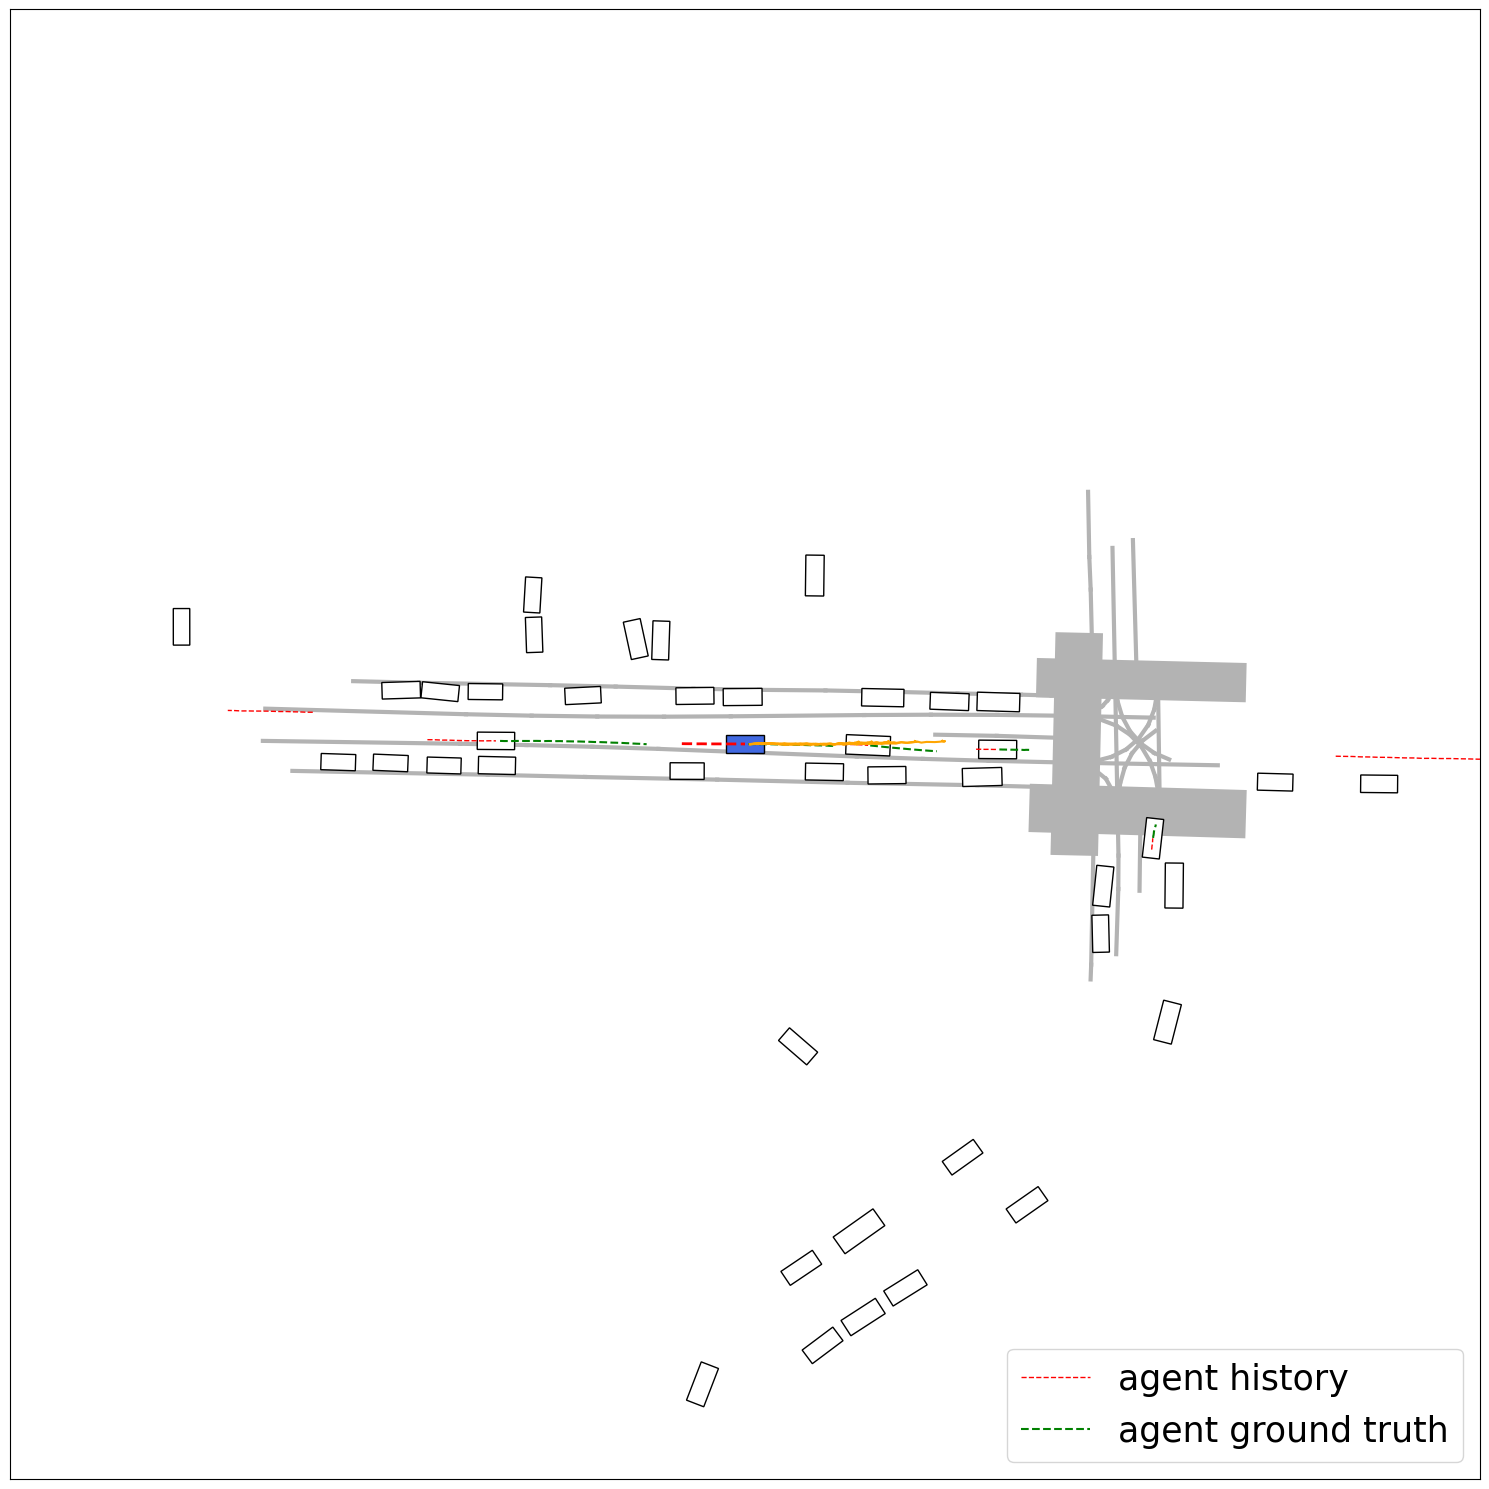

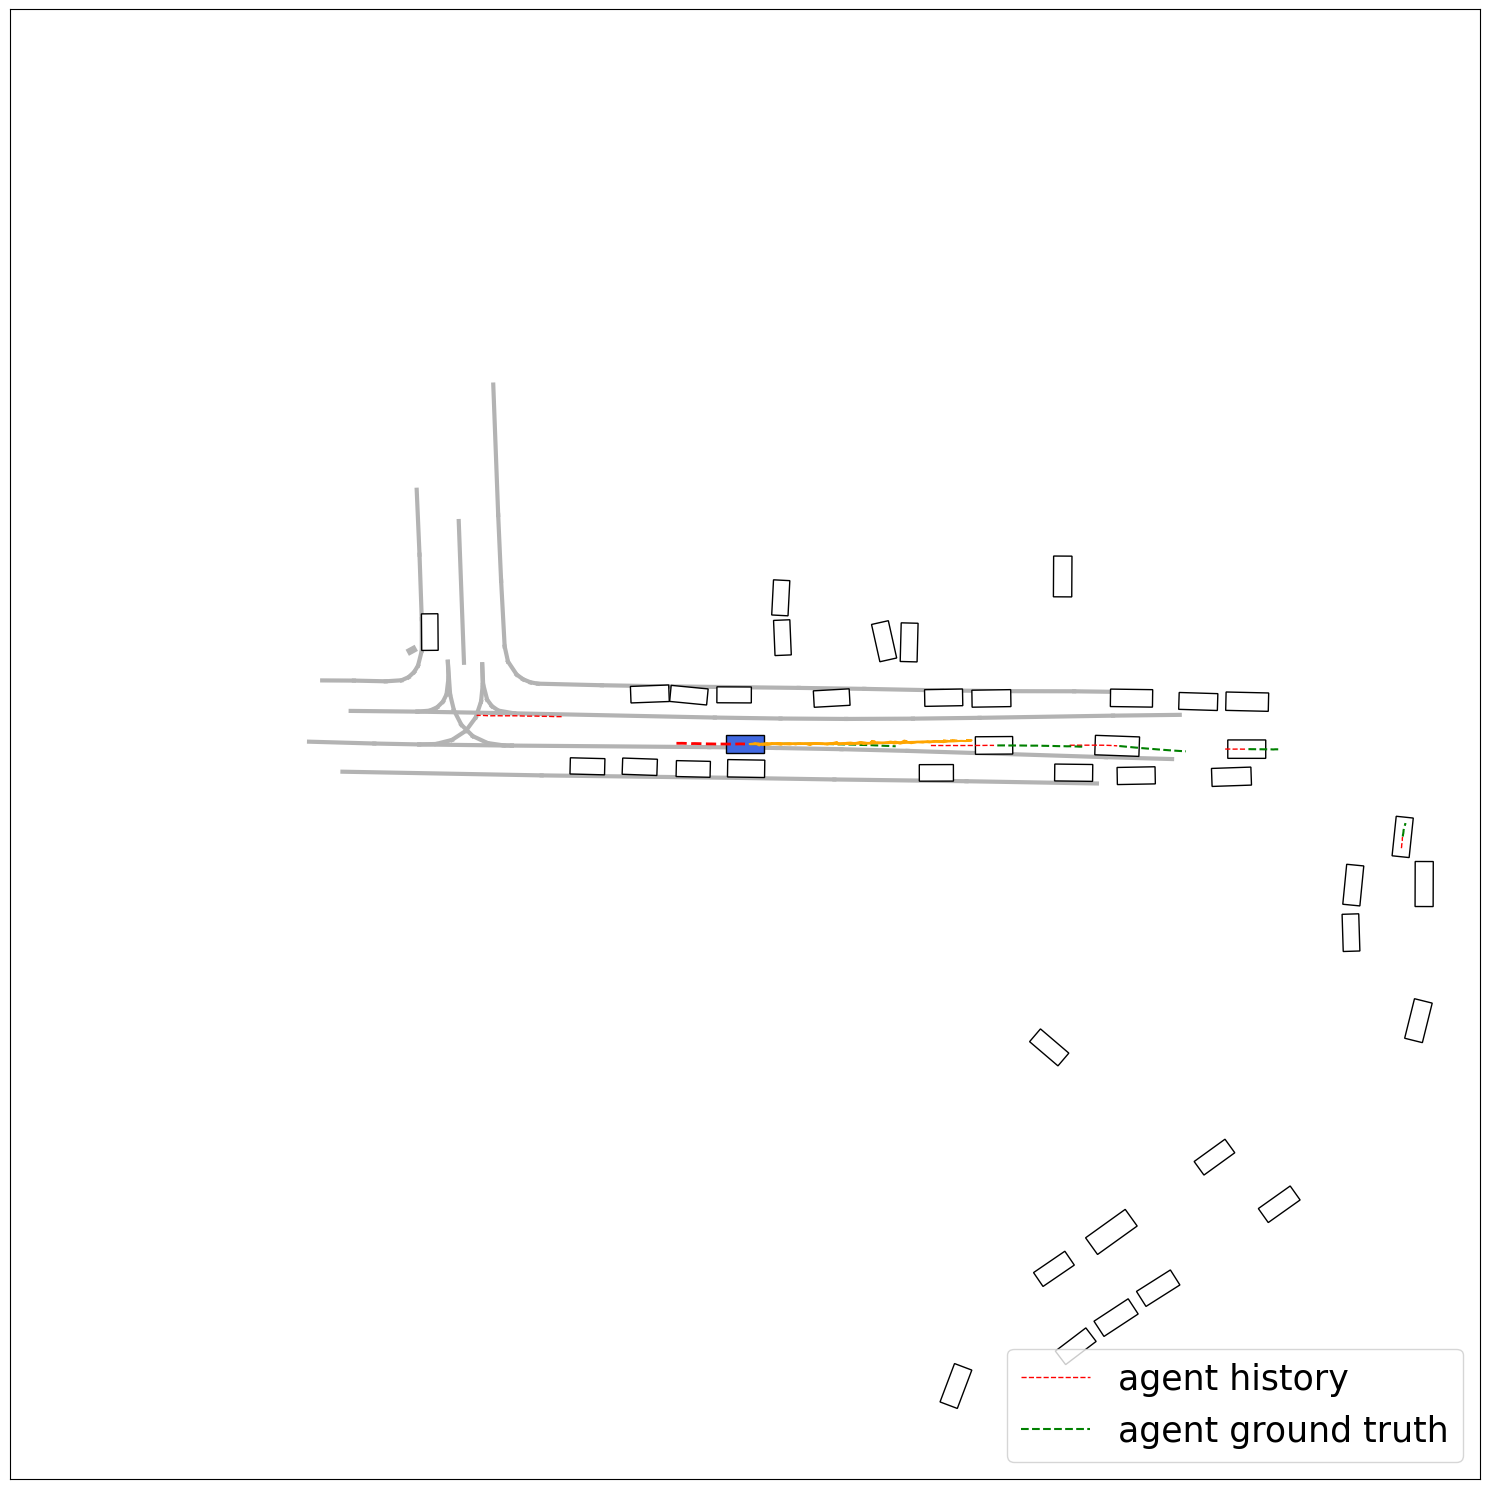

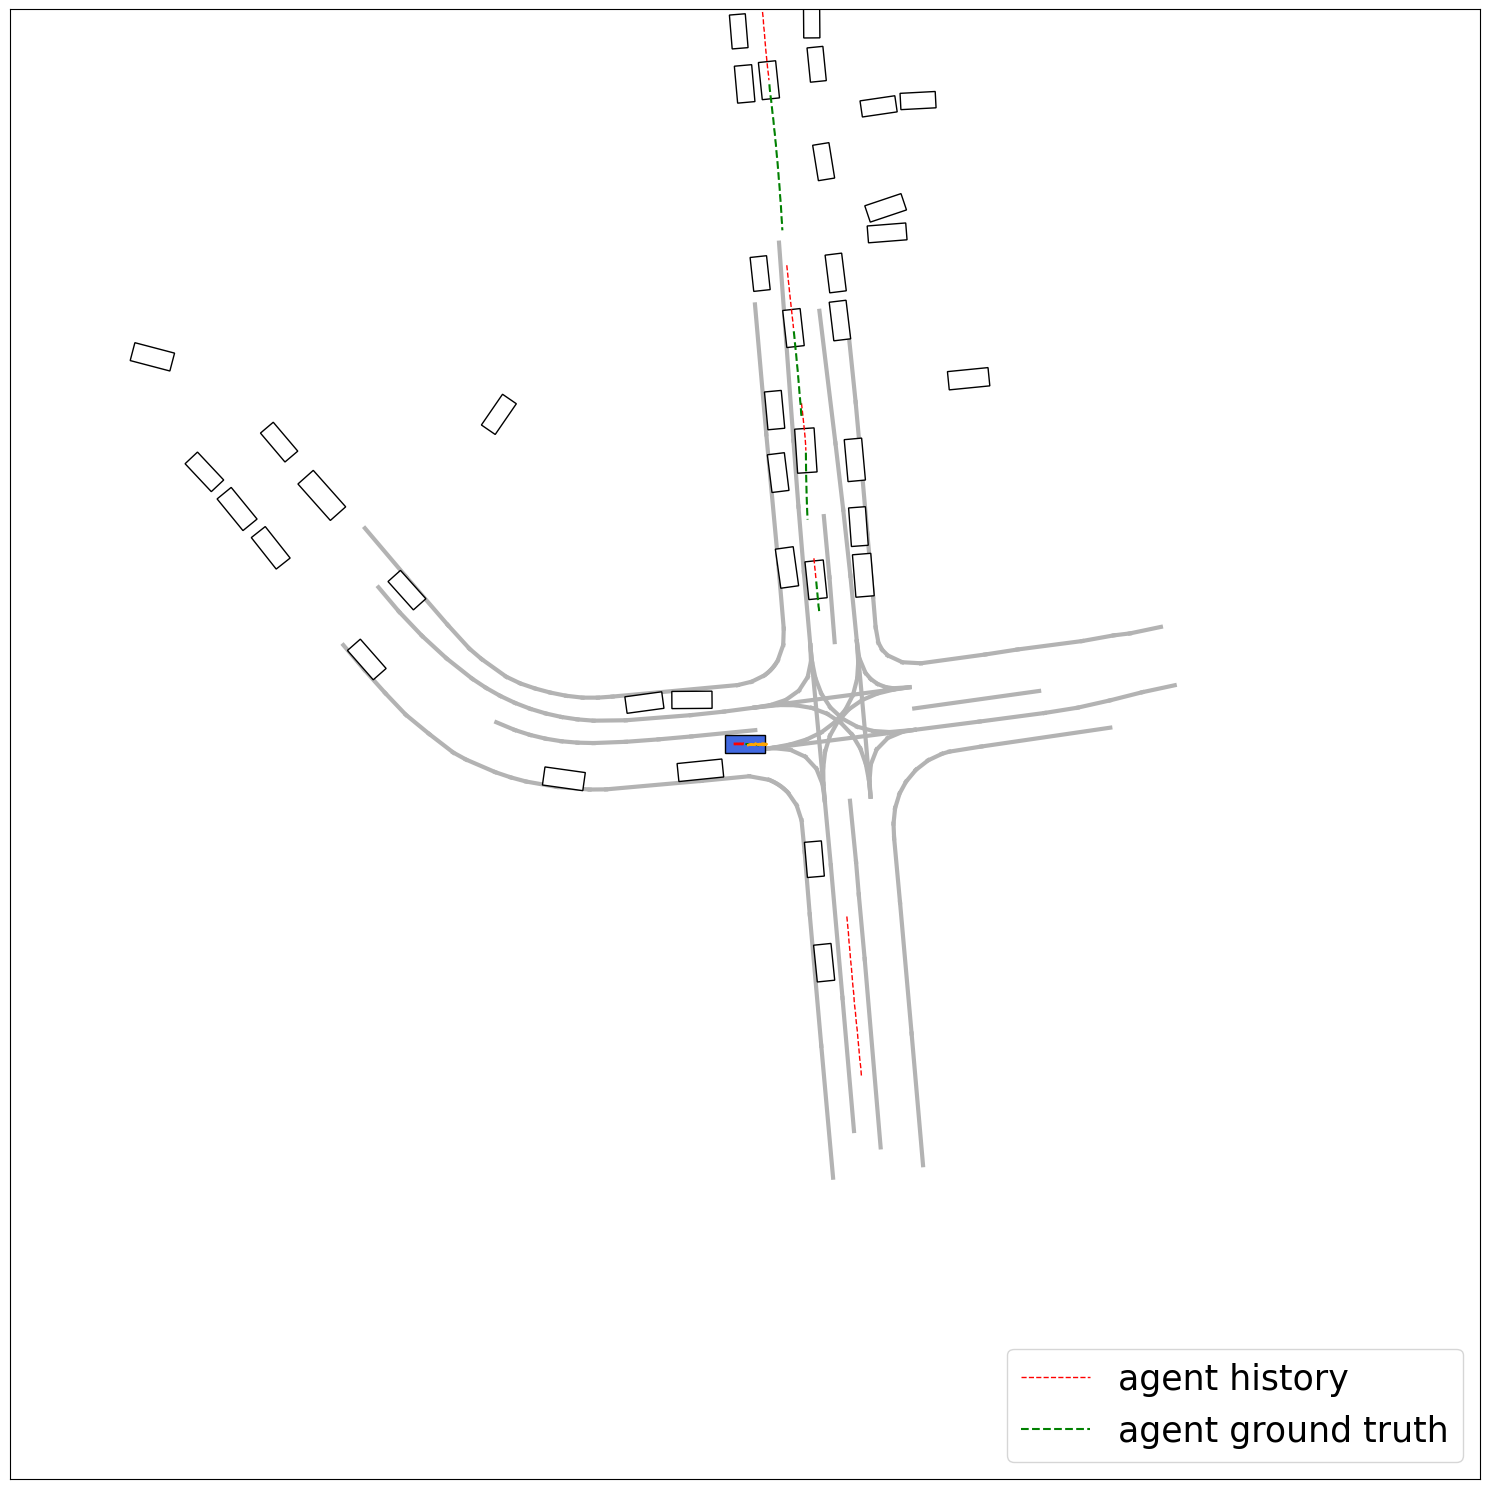

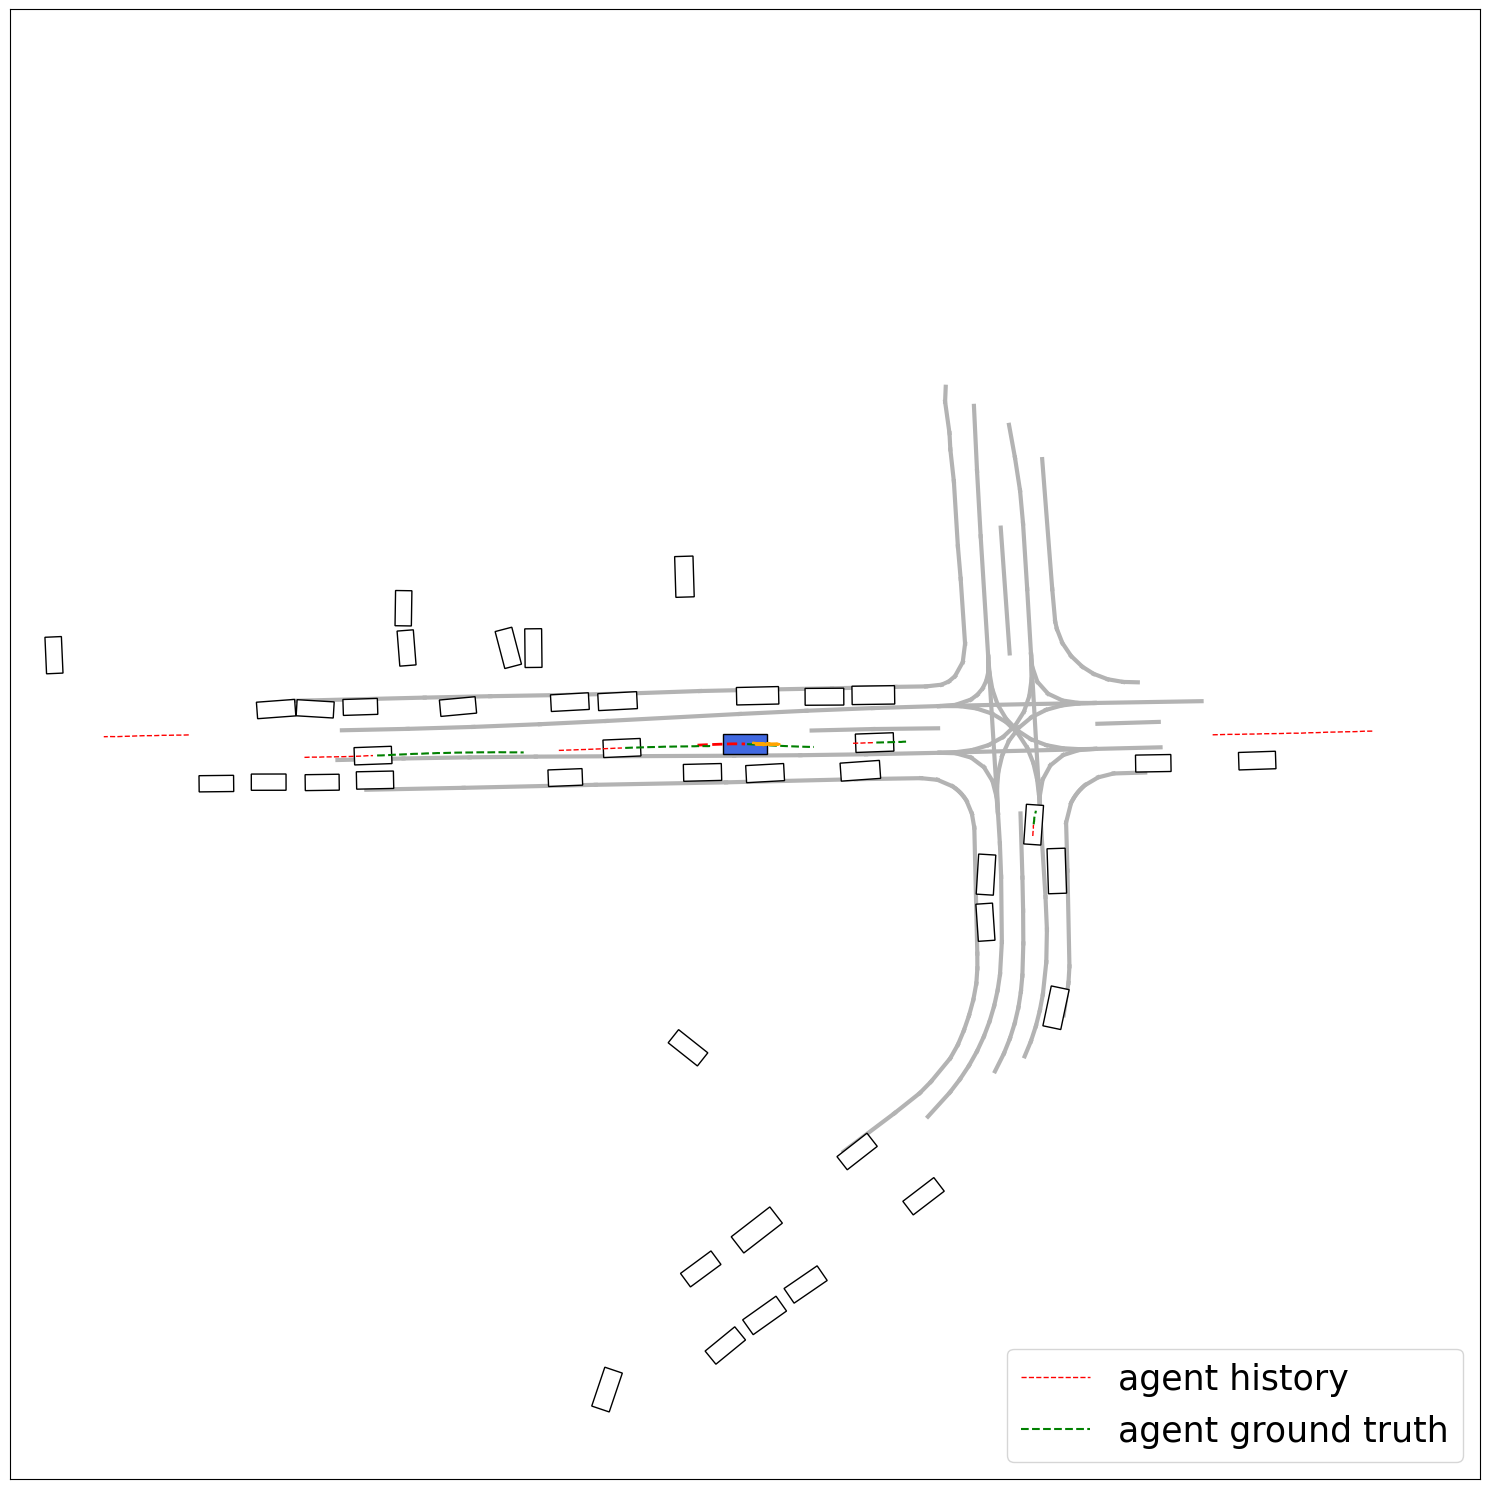

100%|██████████| 100/100 [00:09<00:00, 10.99it/s]
INFO:root:Epoch: 4, Last loss: 11.236801147460938


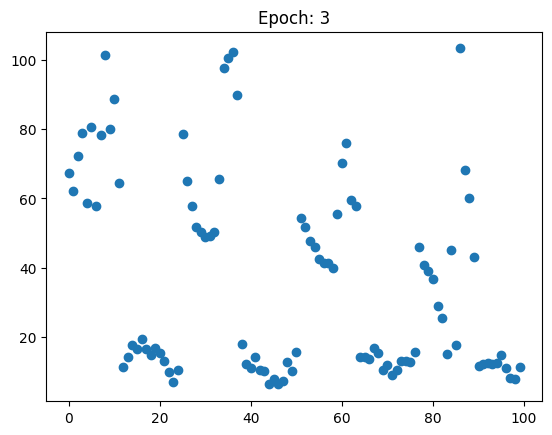

 99%|█████████▉| 99/100 [00:07<00:00,  9.88it/s]

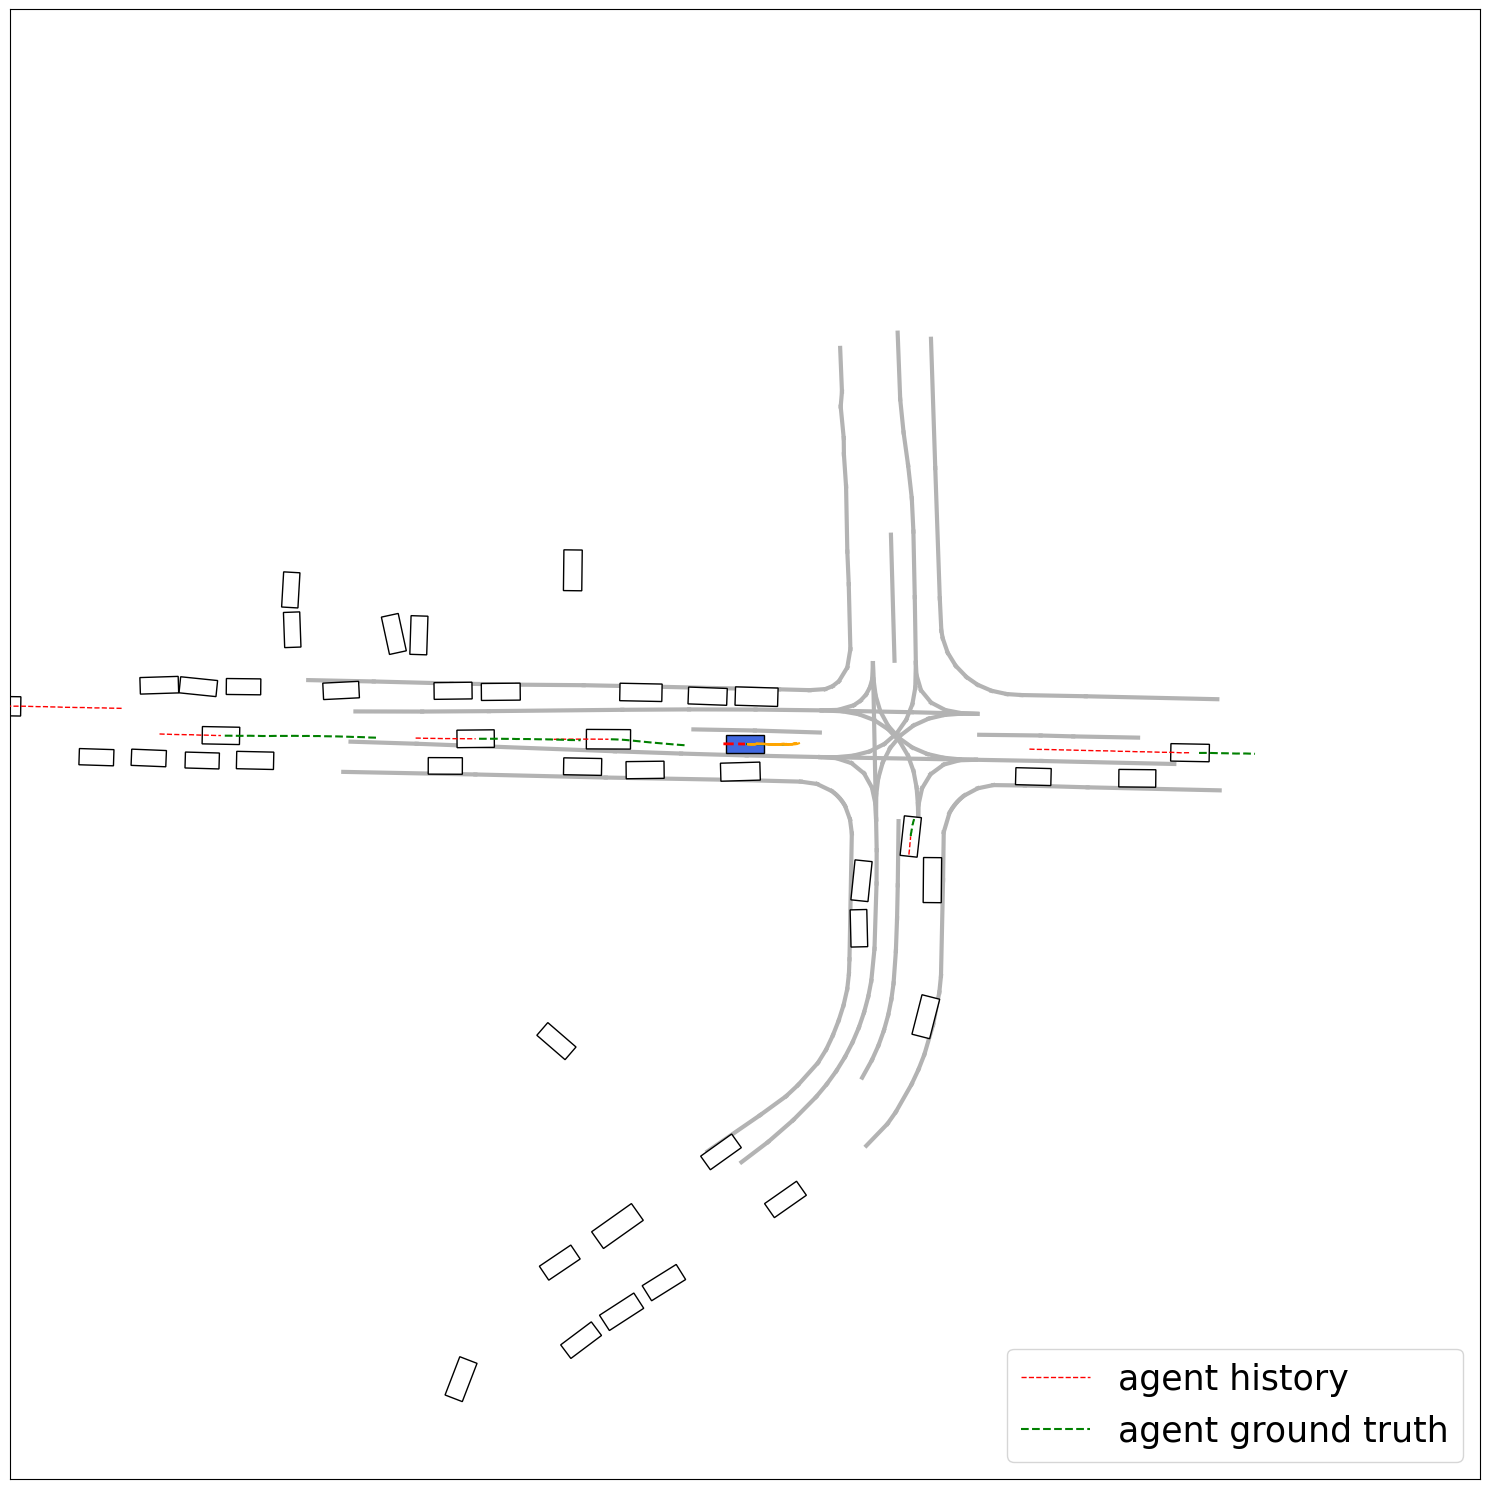

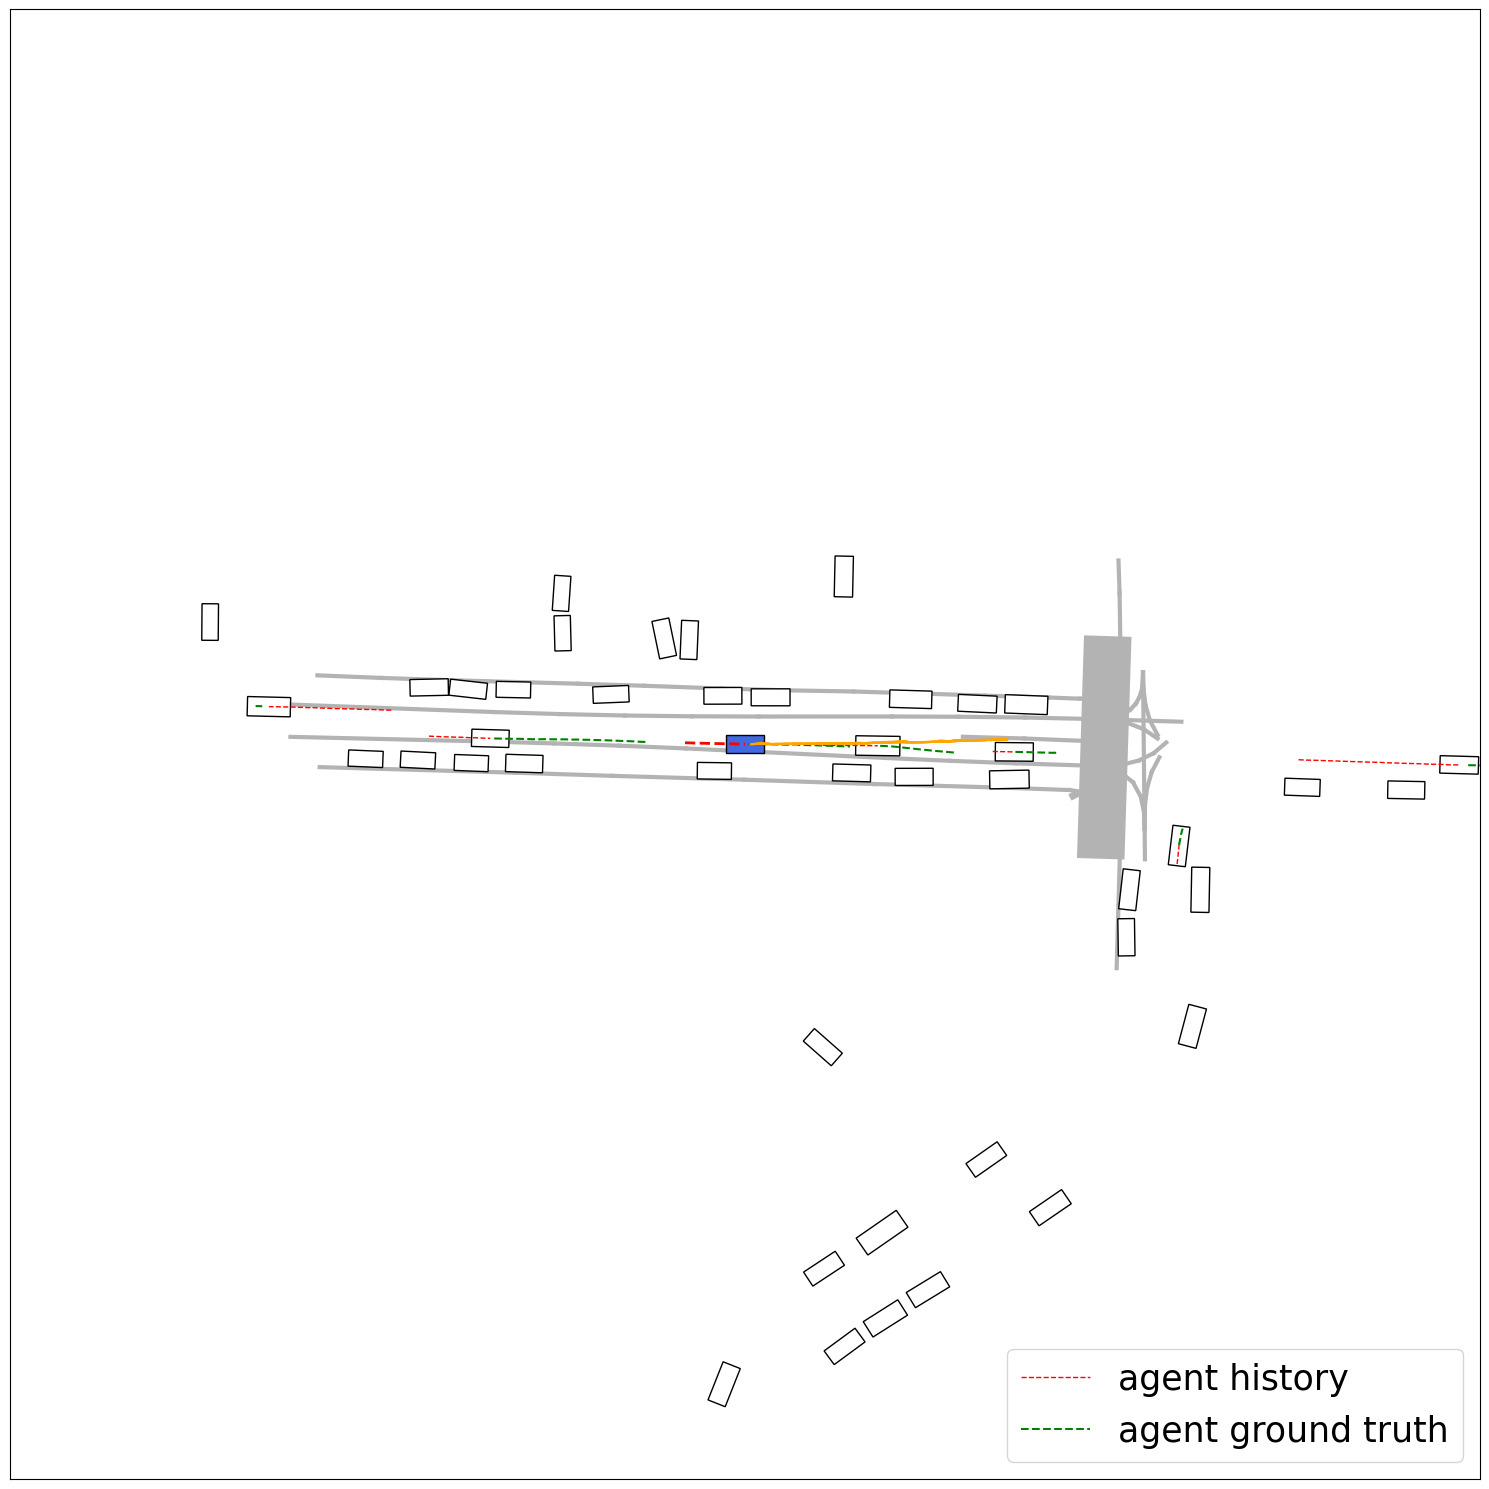

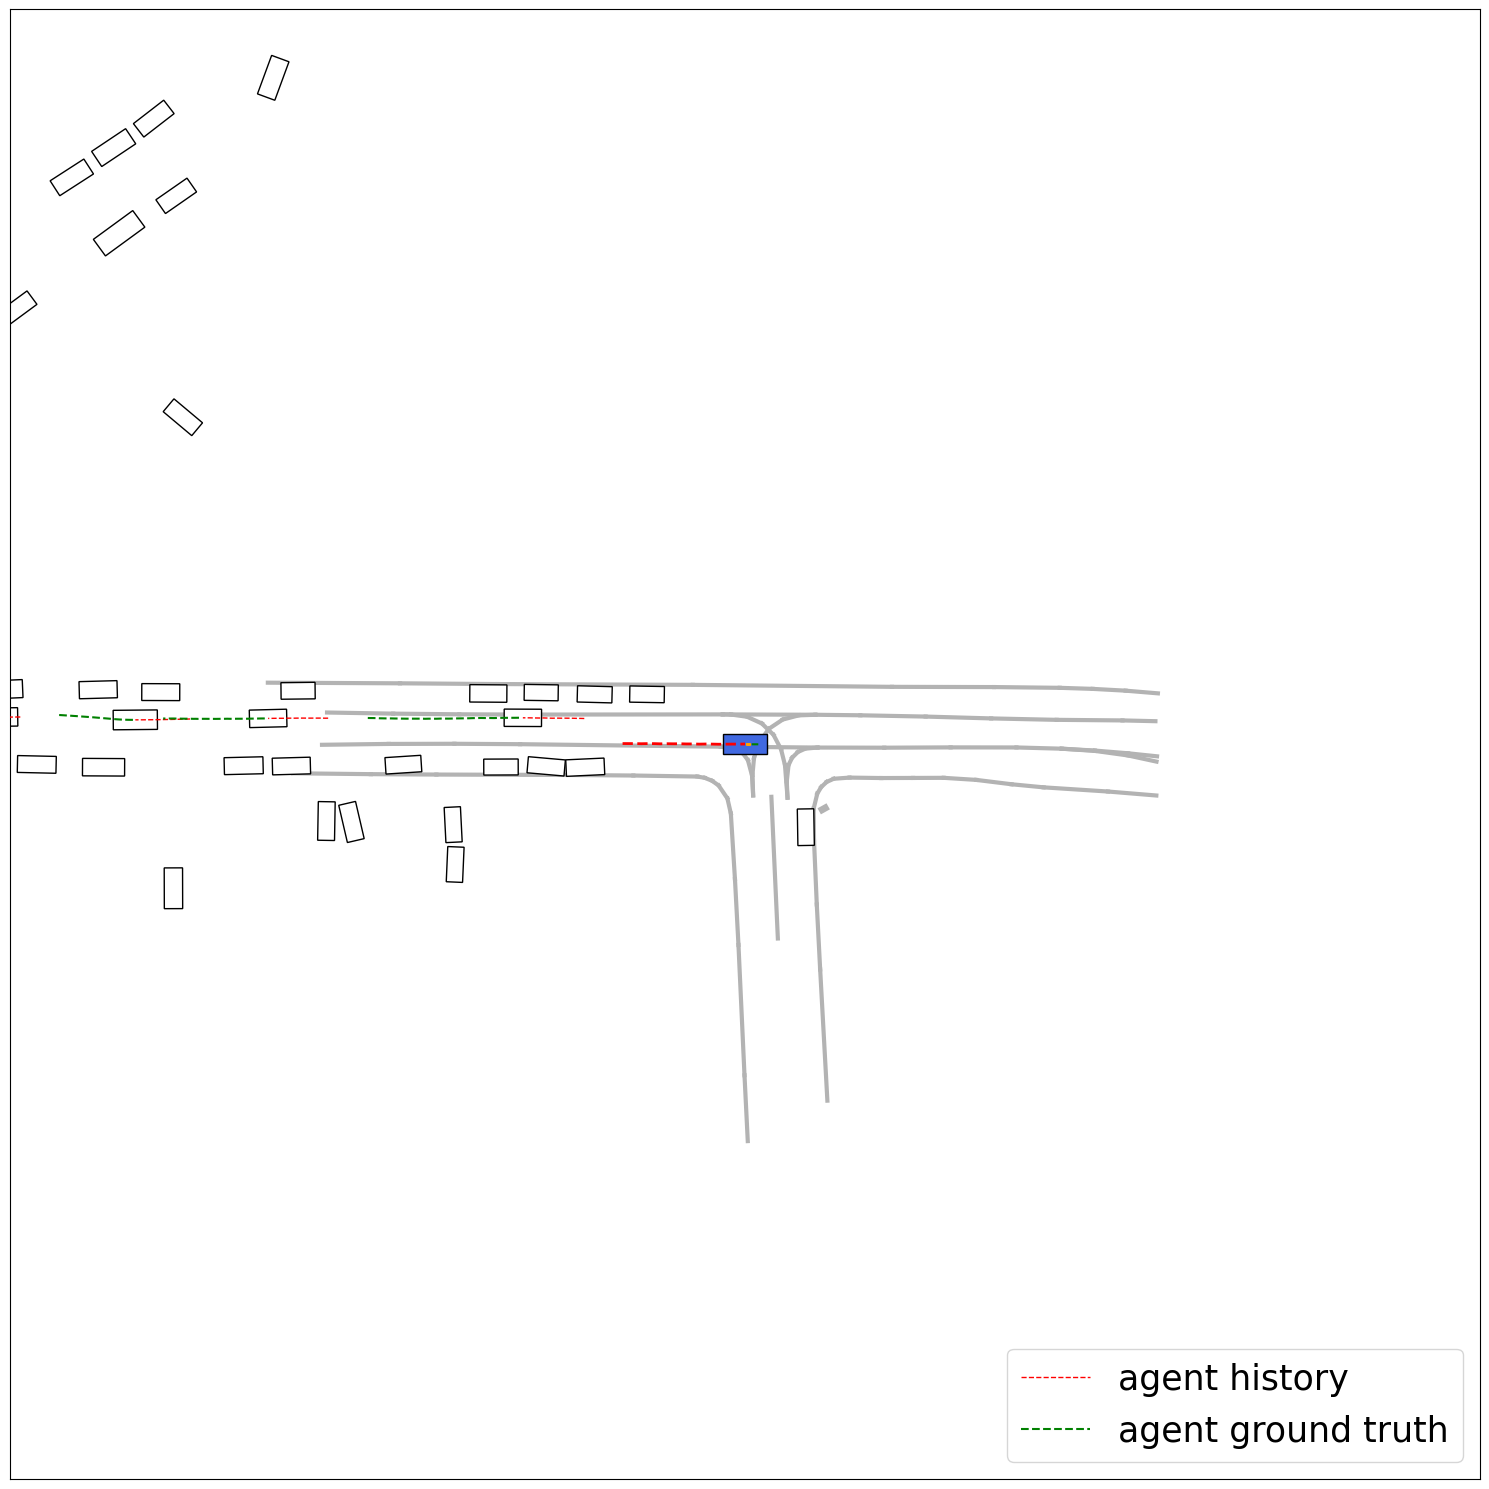

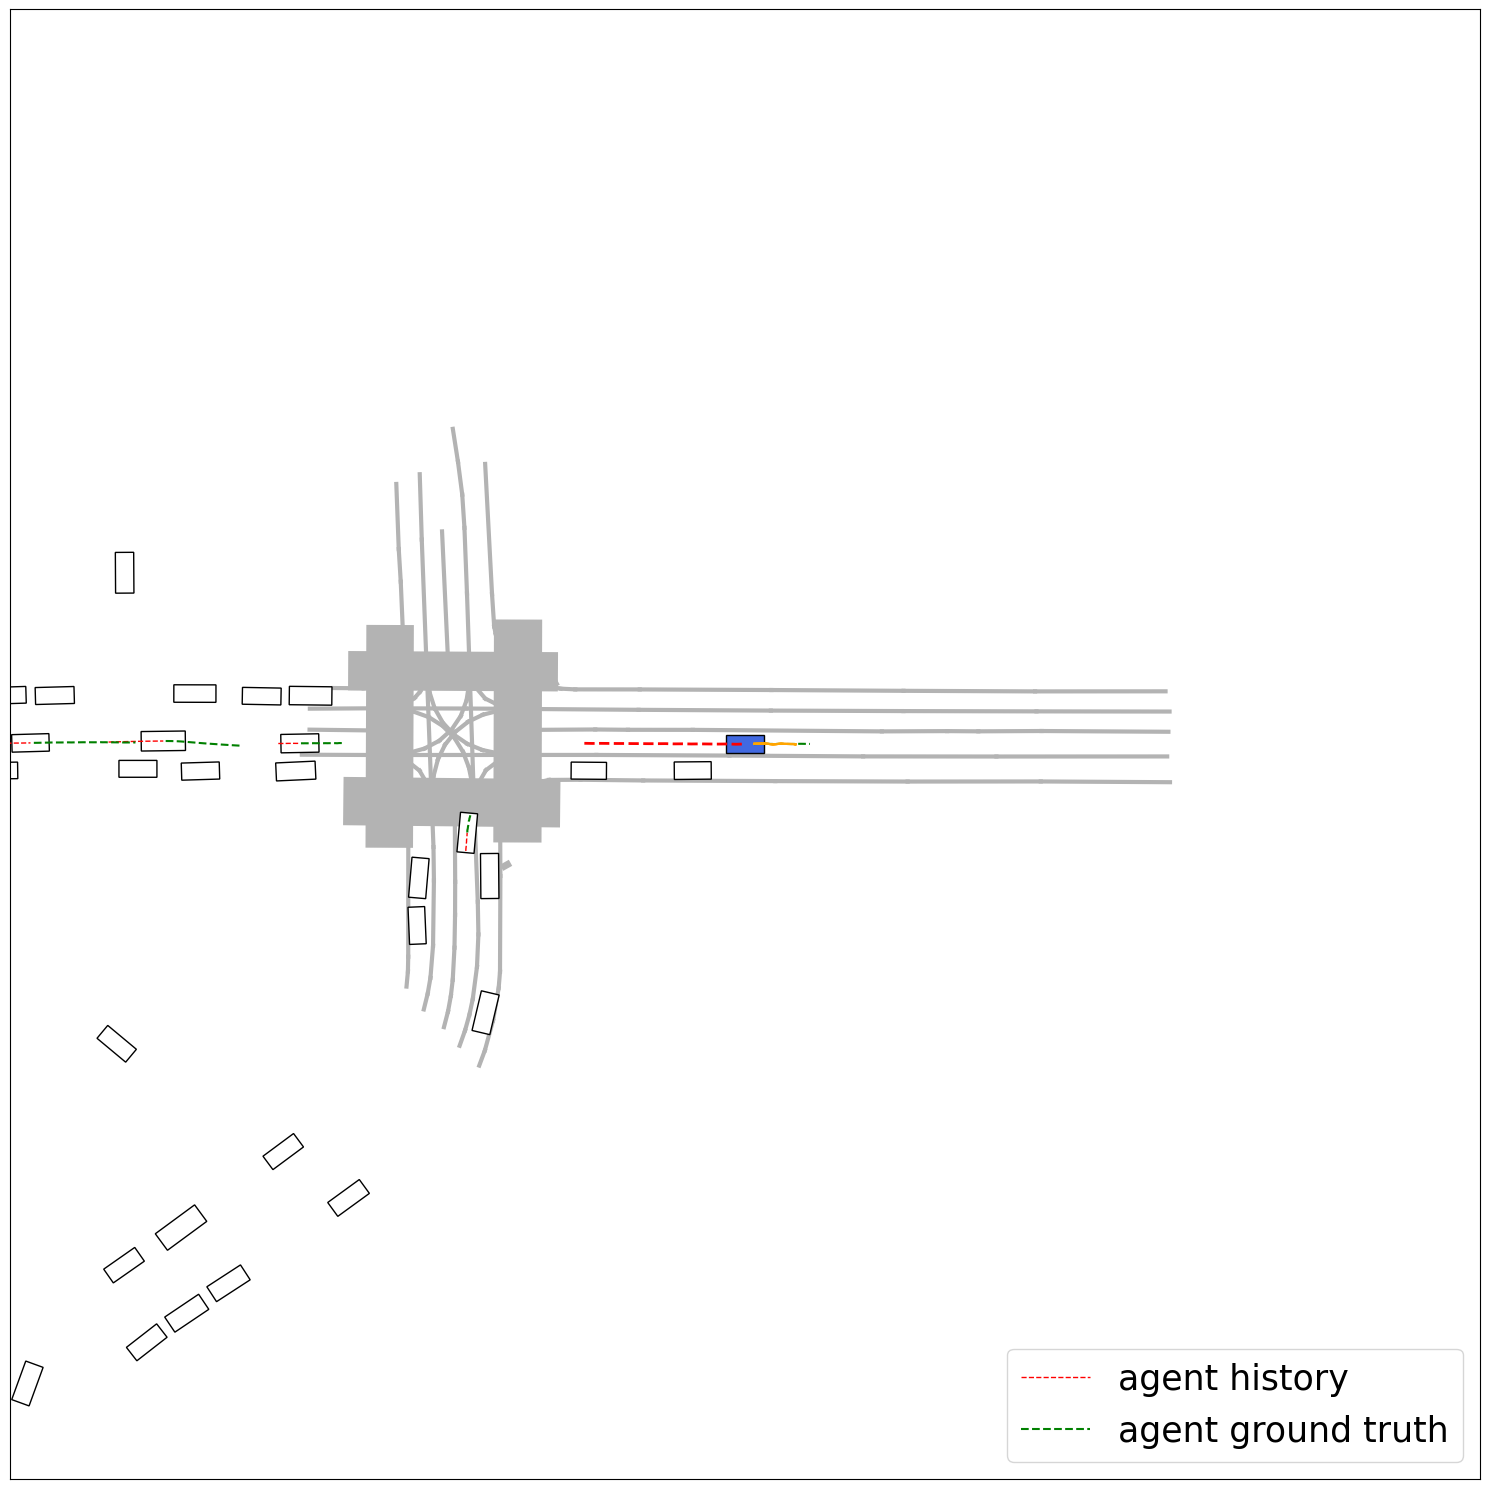

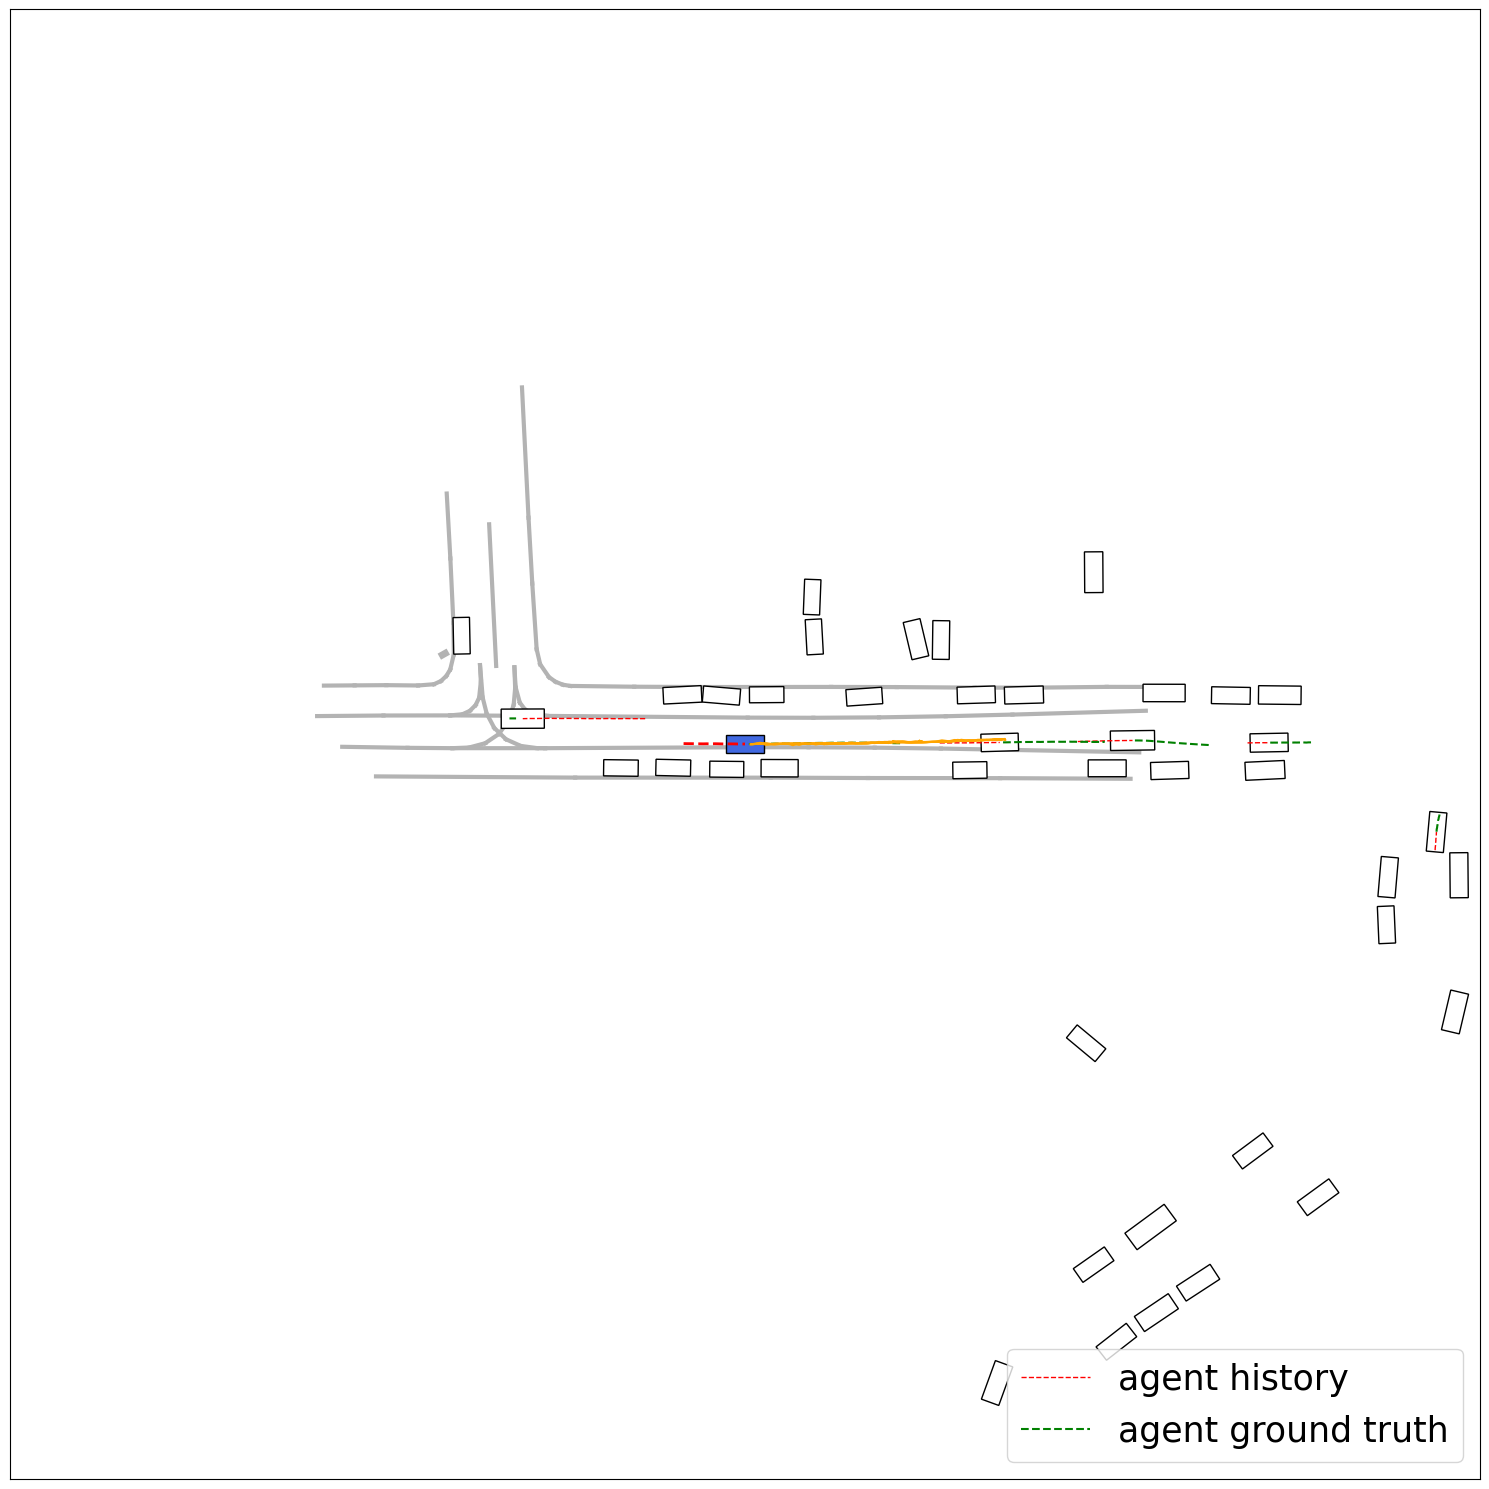

100%|██████████| 100/100 [00:08<00:00, 11.27it/s]
INFO:root:Epoch: 5, Last loss: 19.050966262817383


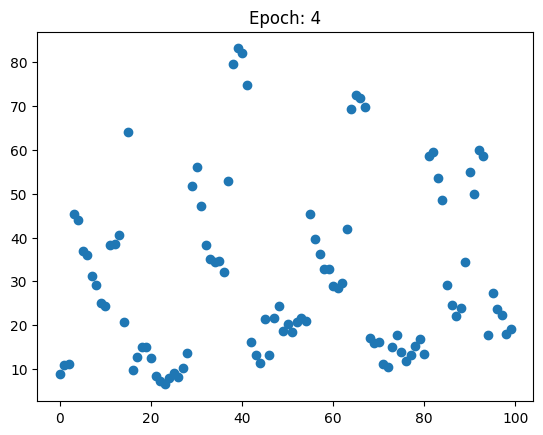

 99%|█████████▉| 99/100 [00:07<00:00,  7.21it/s]

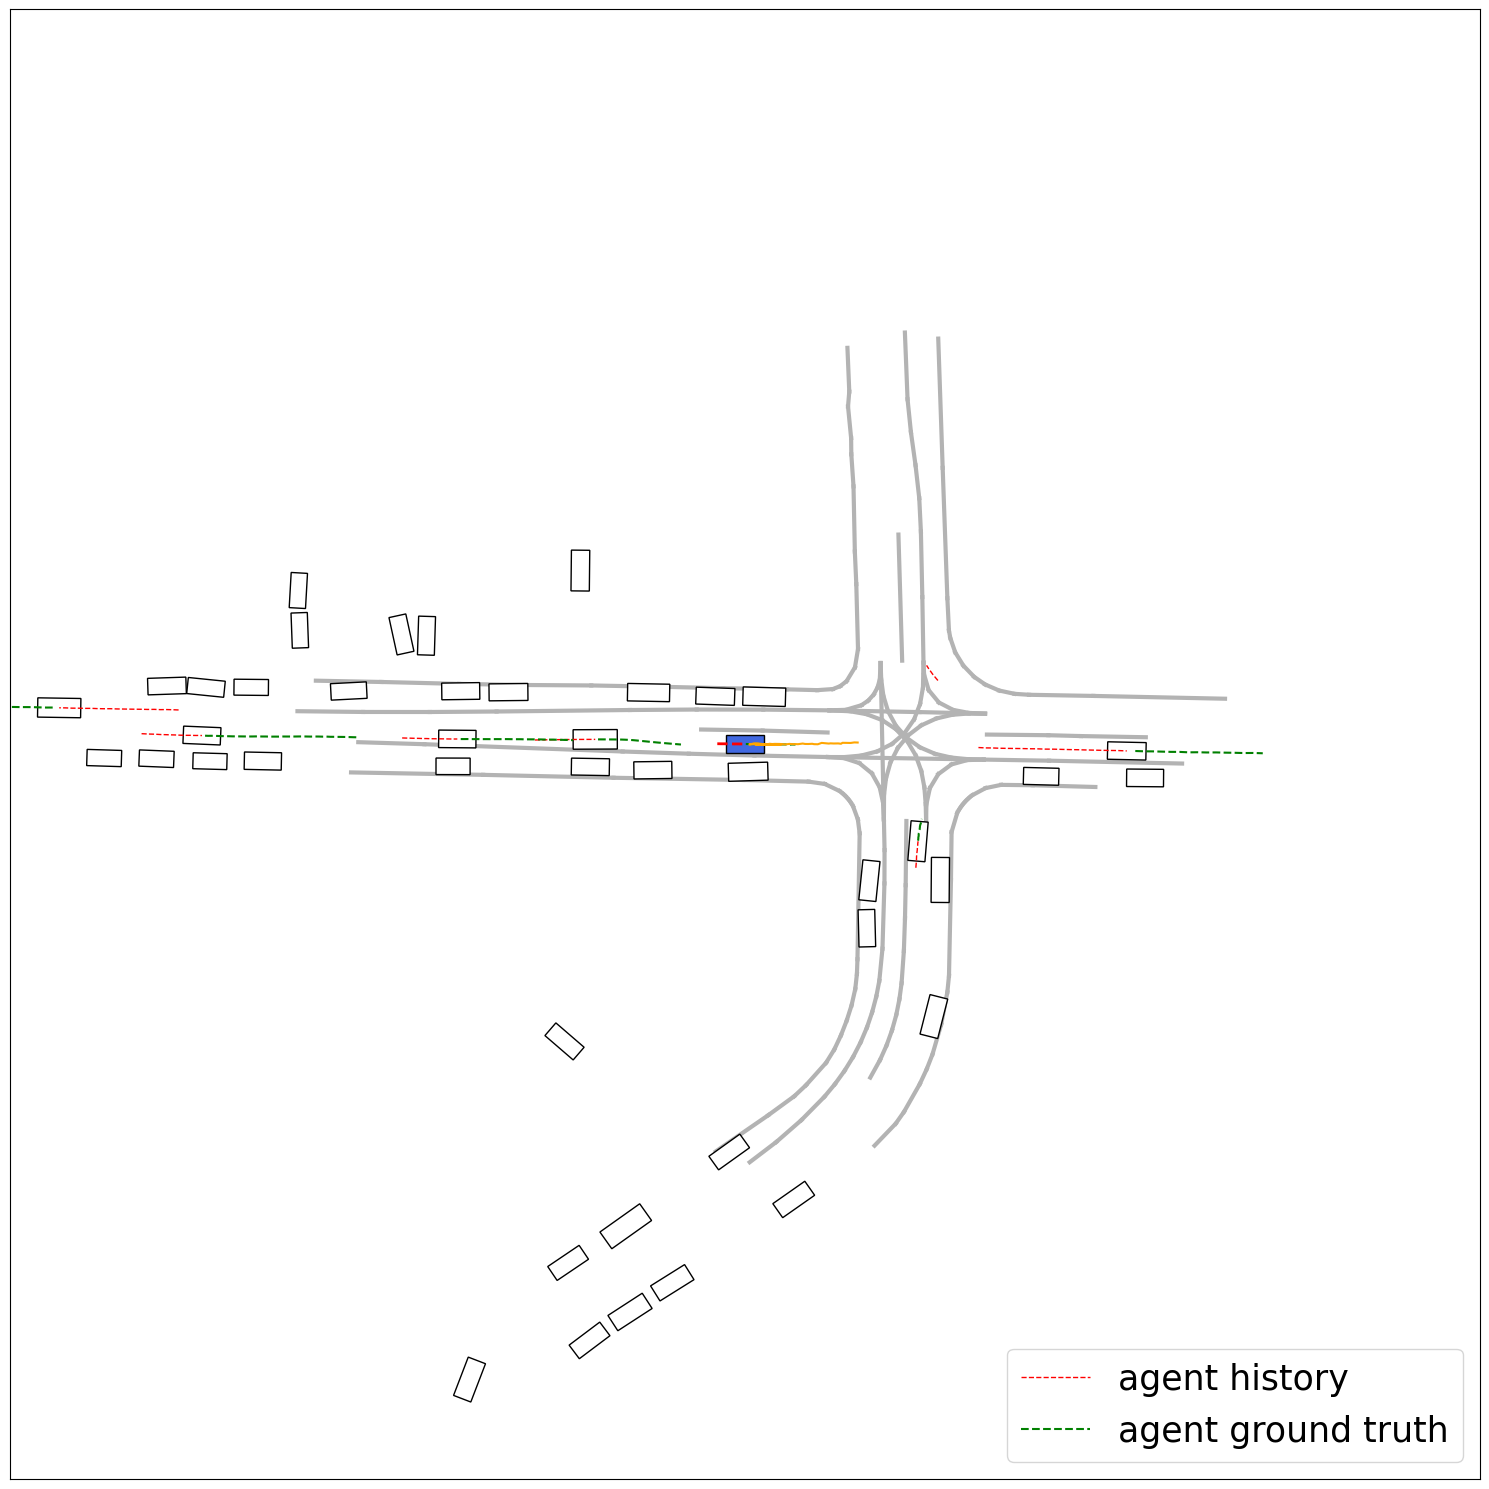

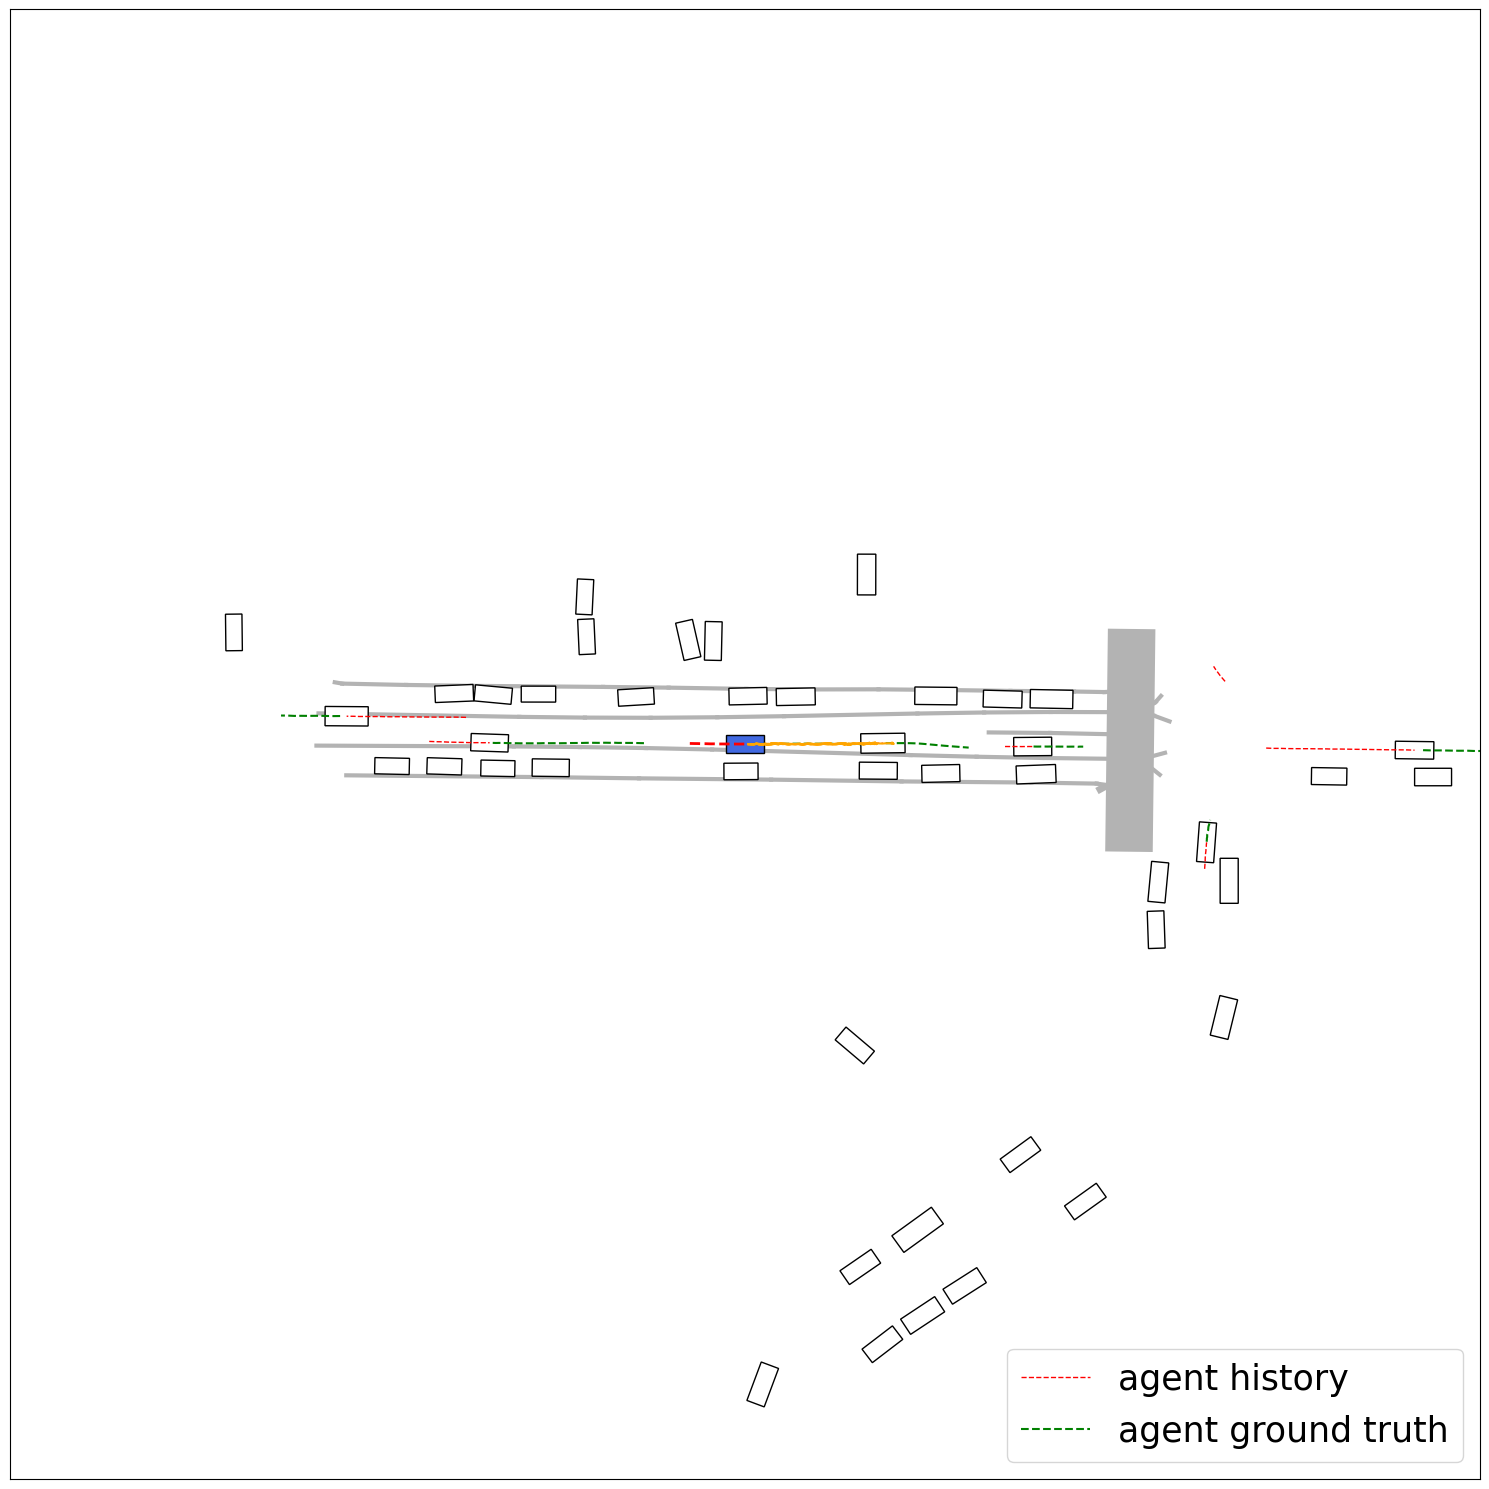

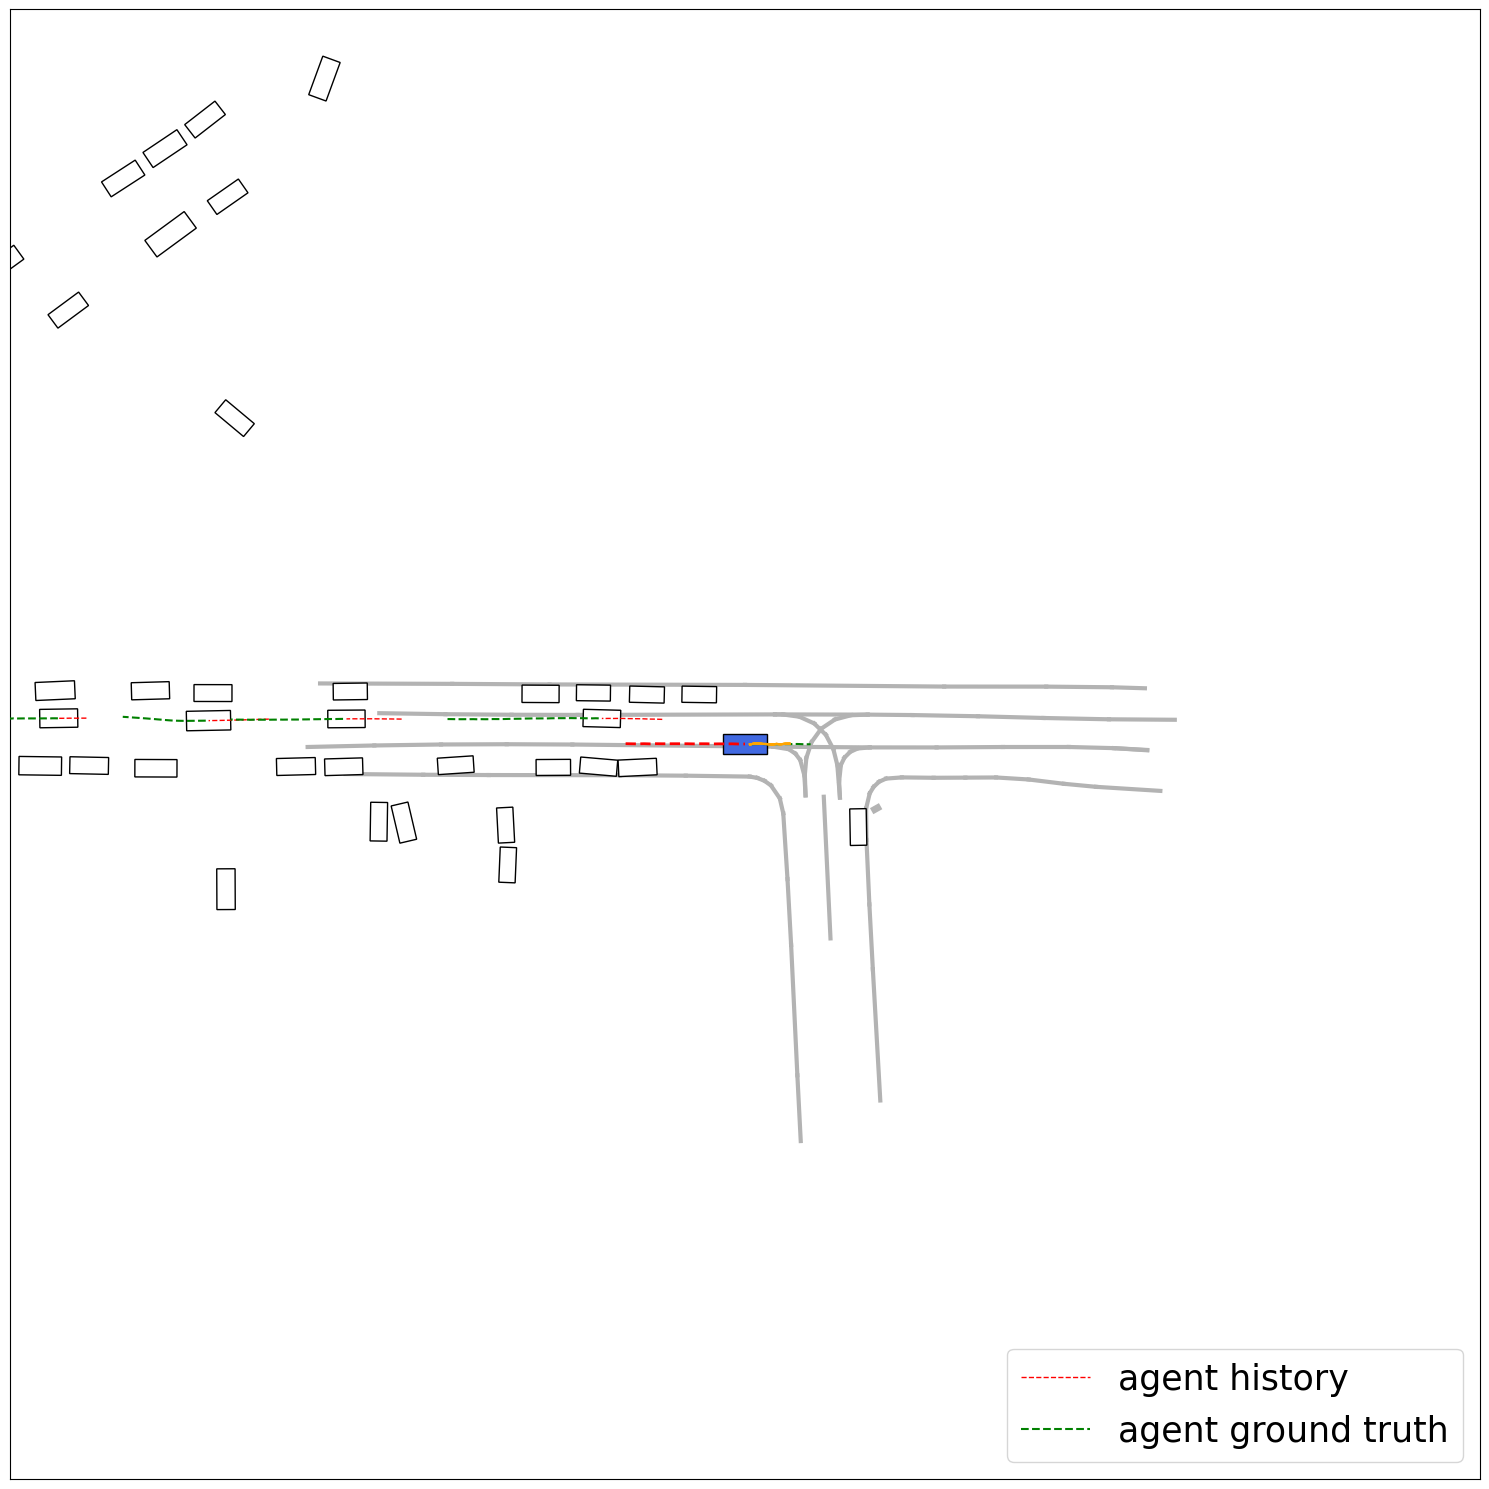

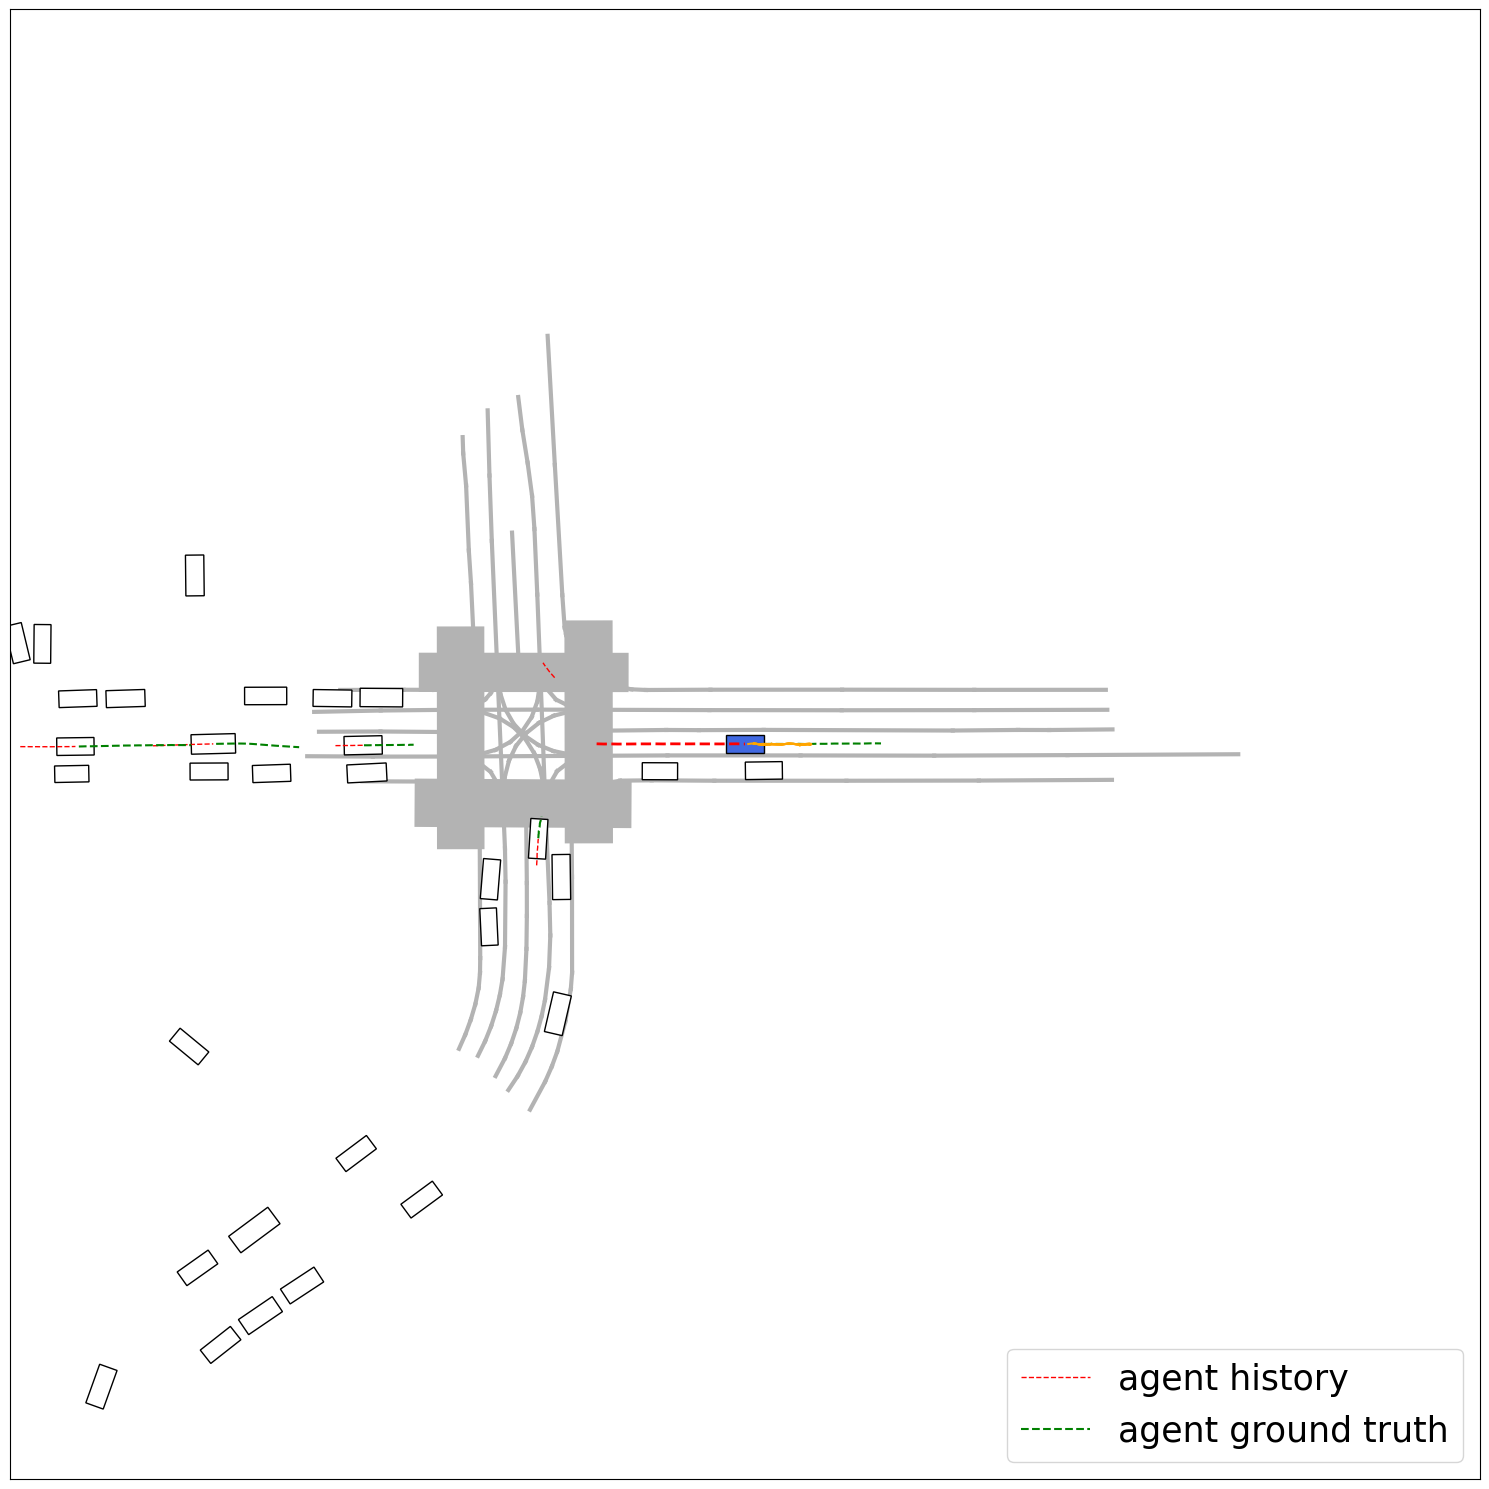

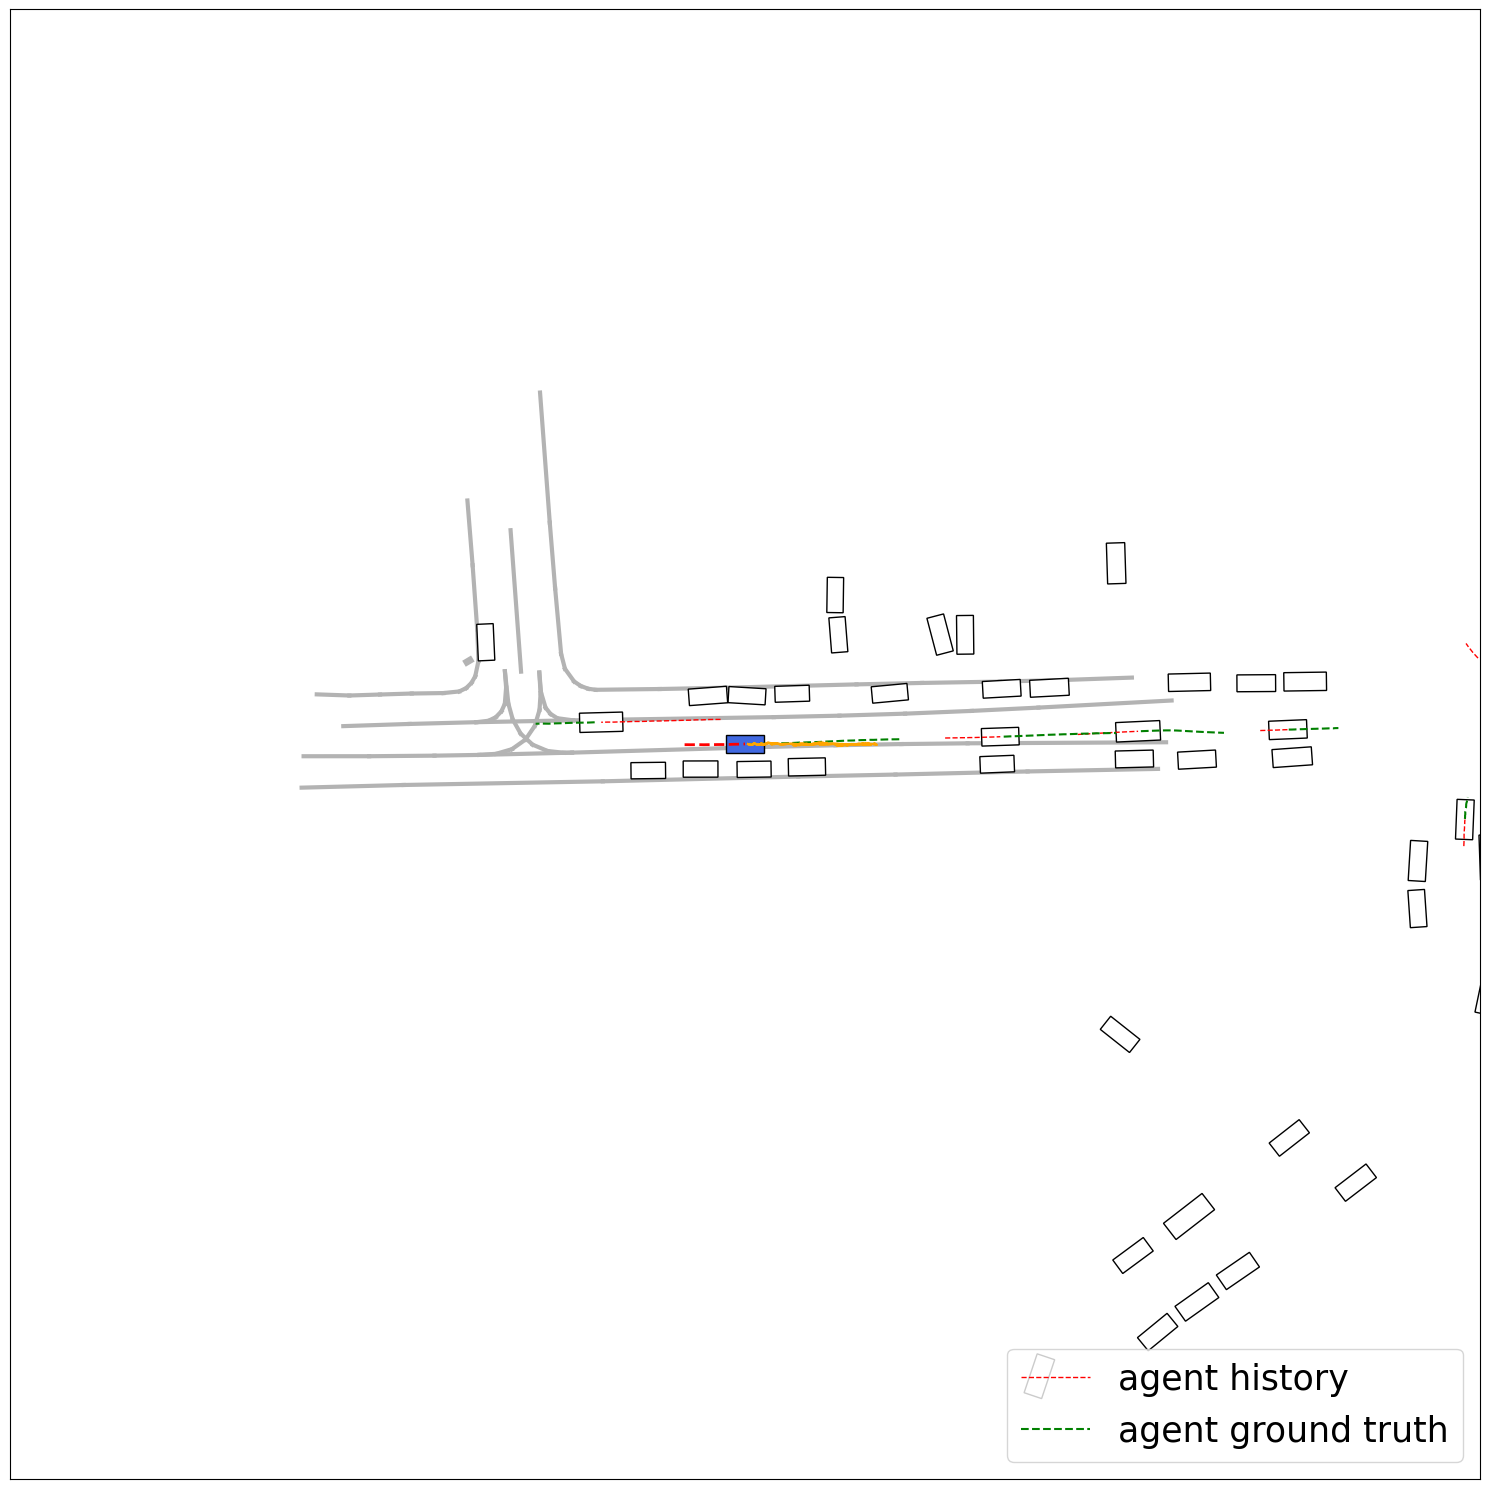

100%|██████████| 100/100 [00:08<00:00, 11.11it/s]
INFO:root:Epoch: 6, Last loss: 11.429969787597656


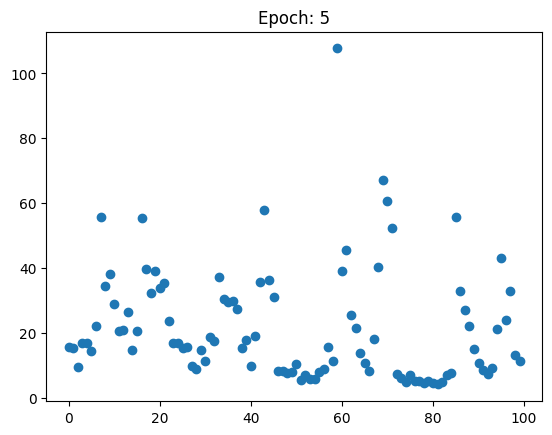

 98%|█████████▊| 98/100 [00:07<00:00, 17.83it/s]

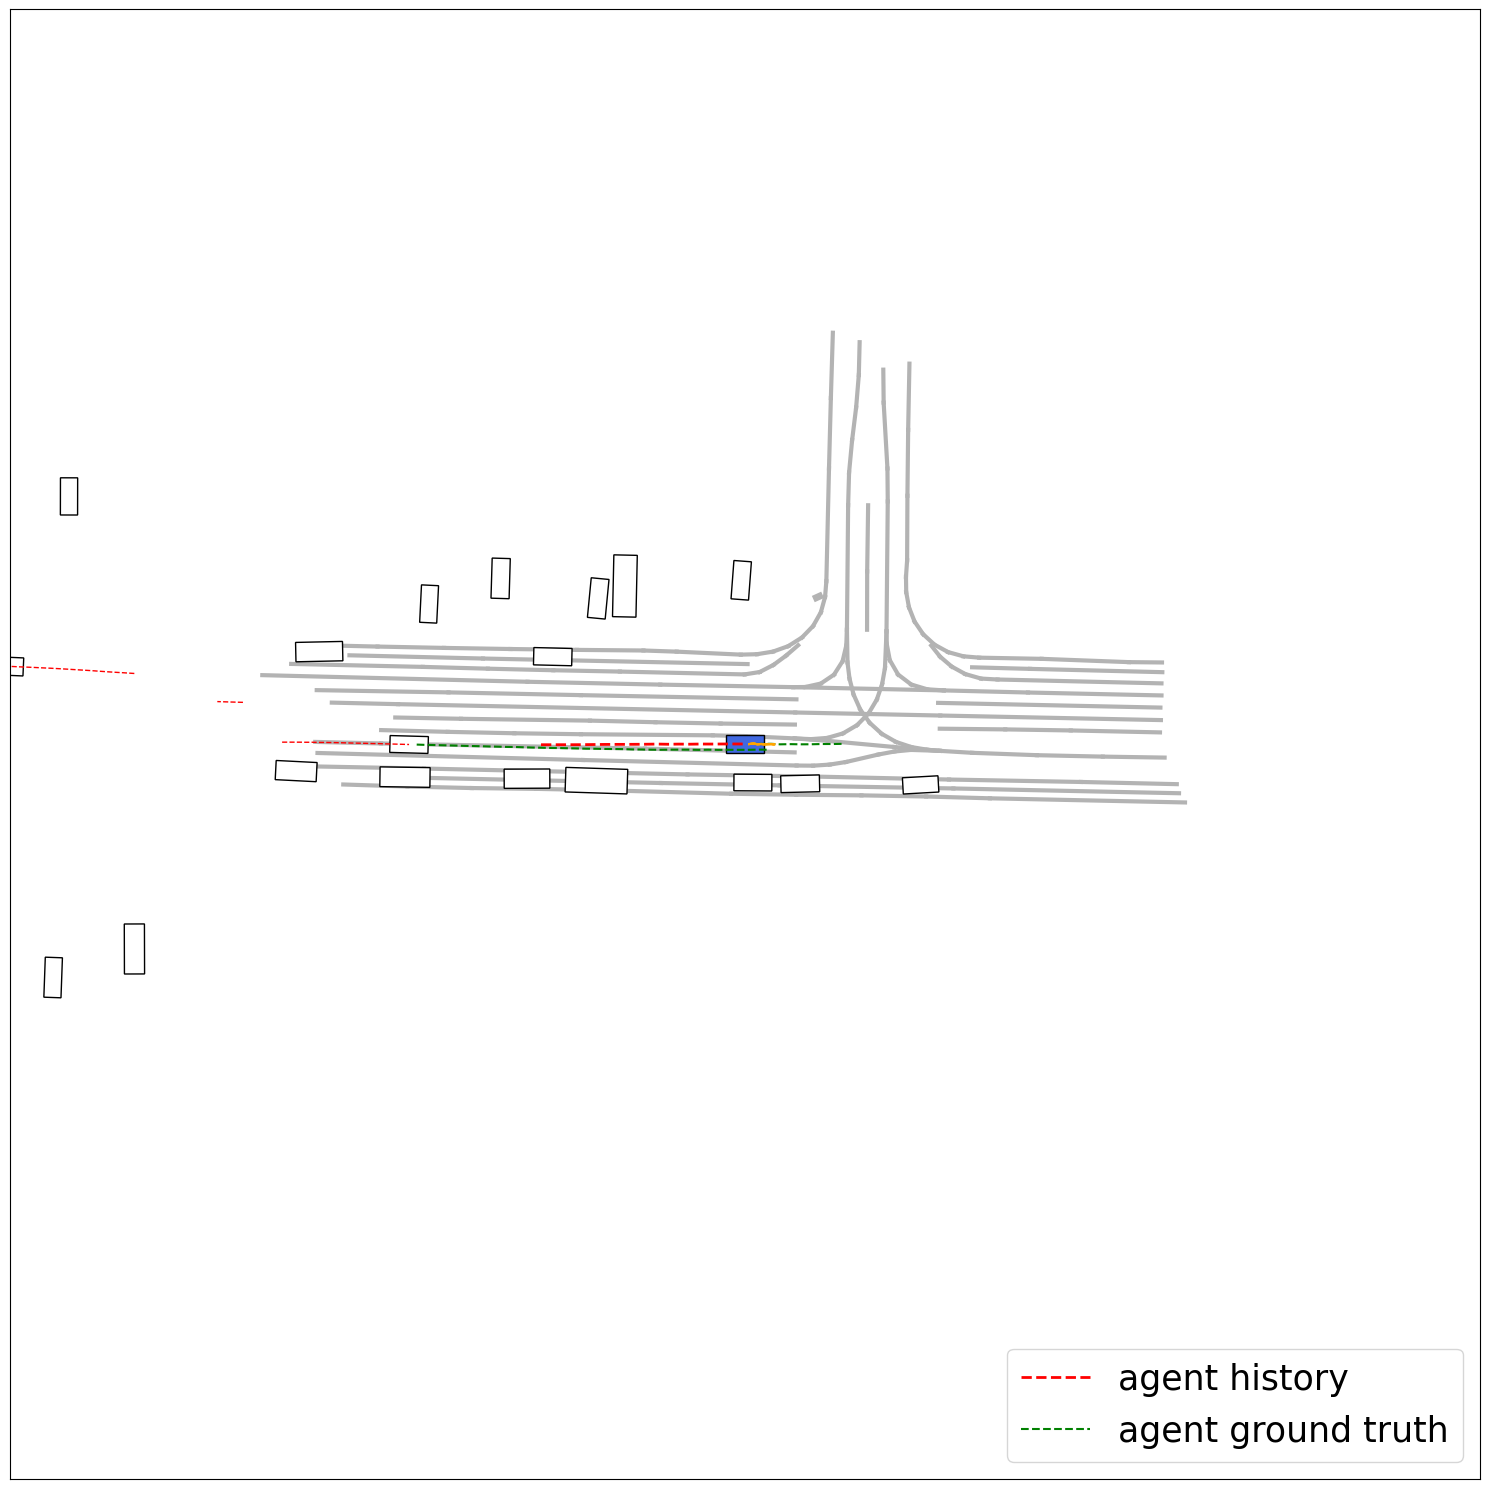

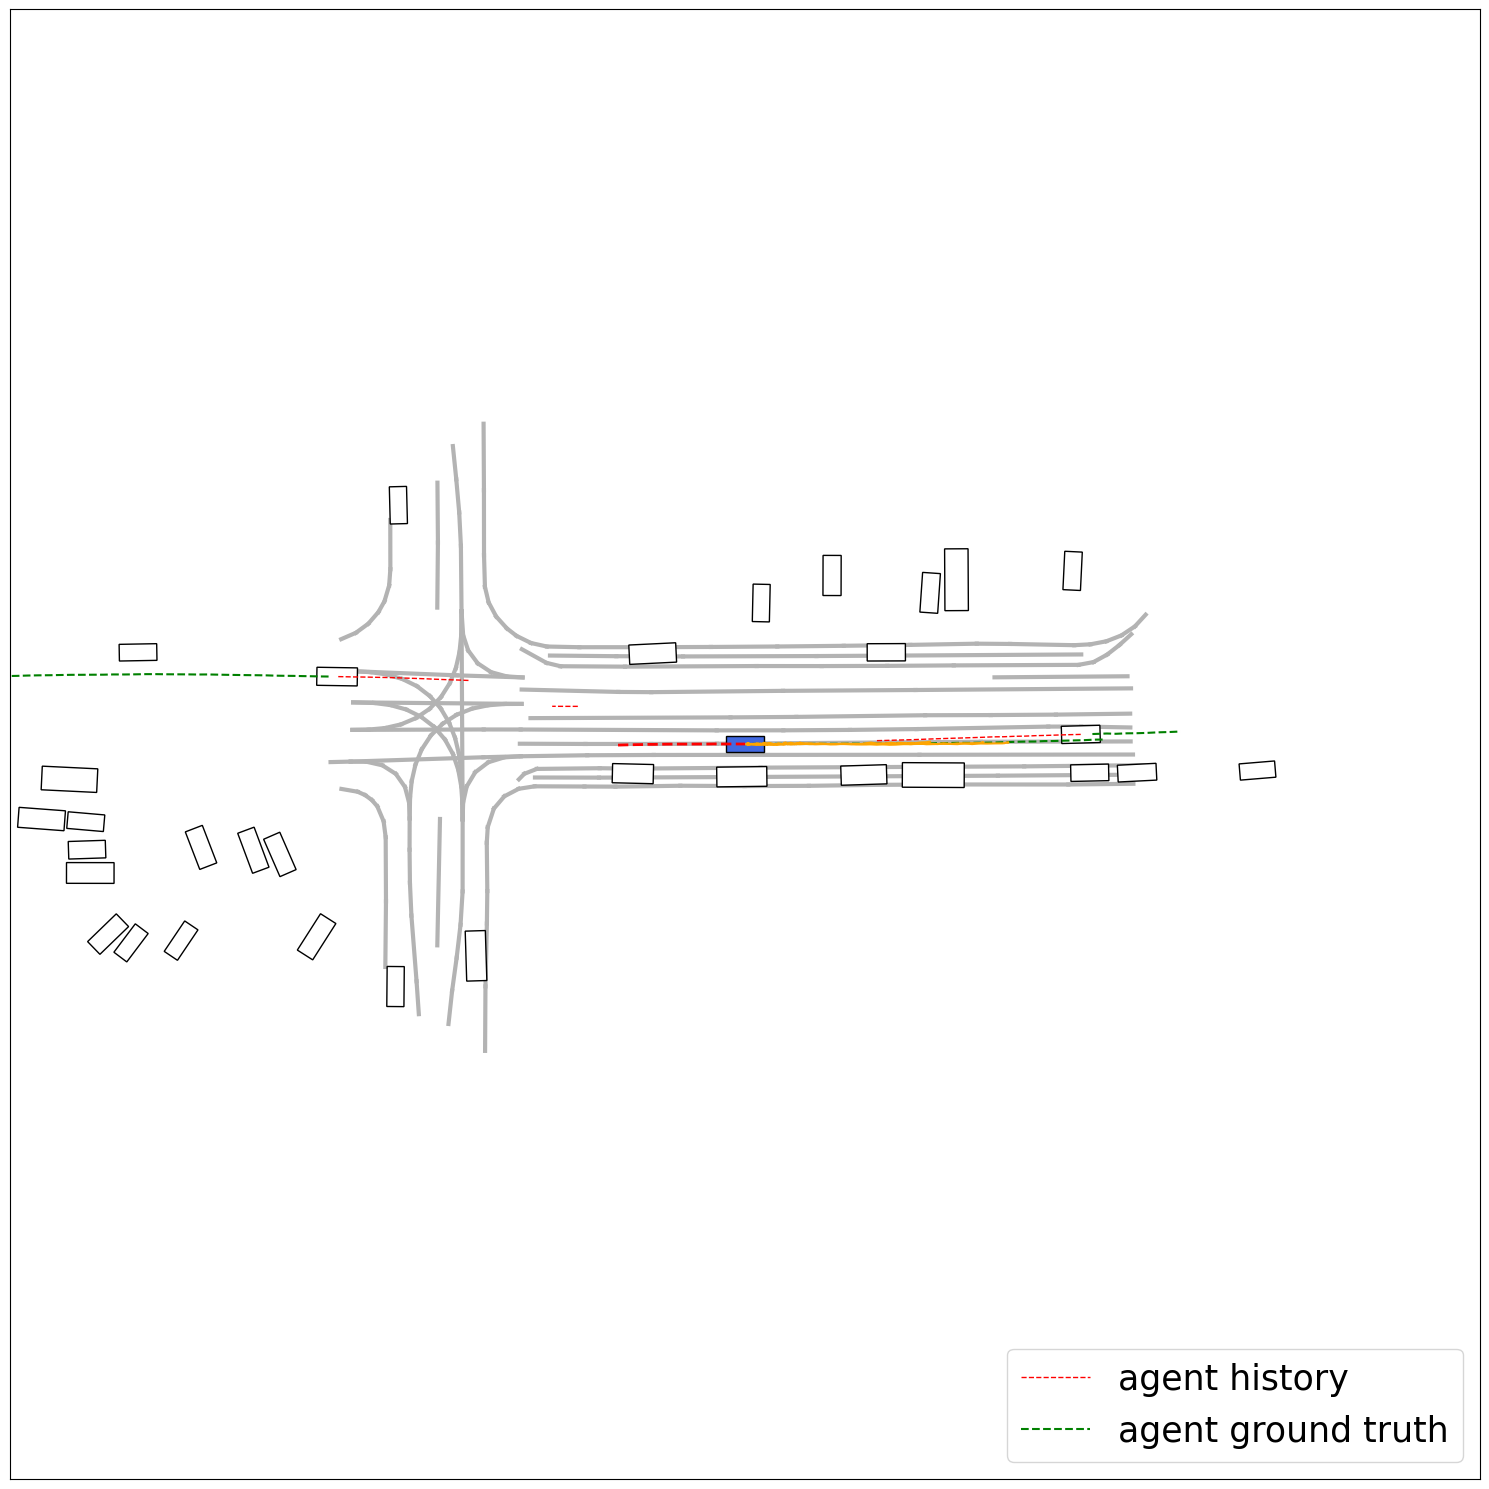

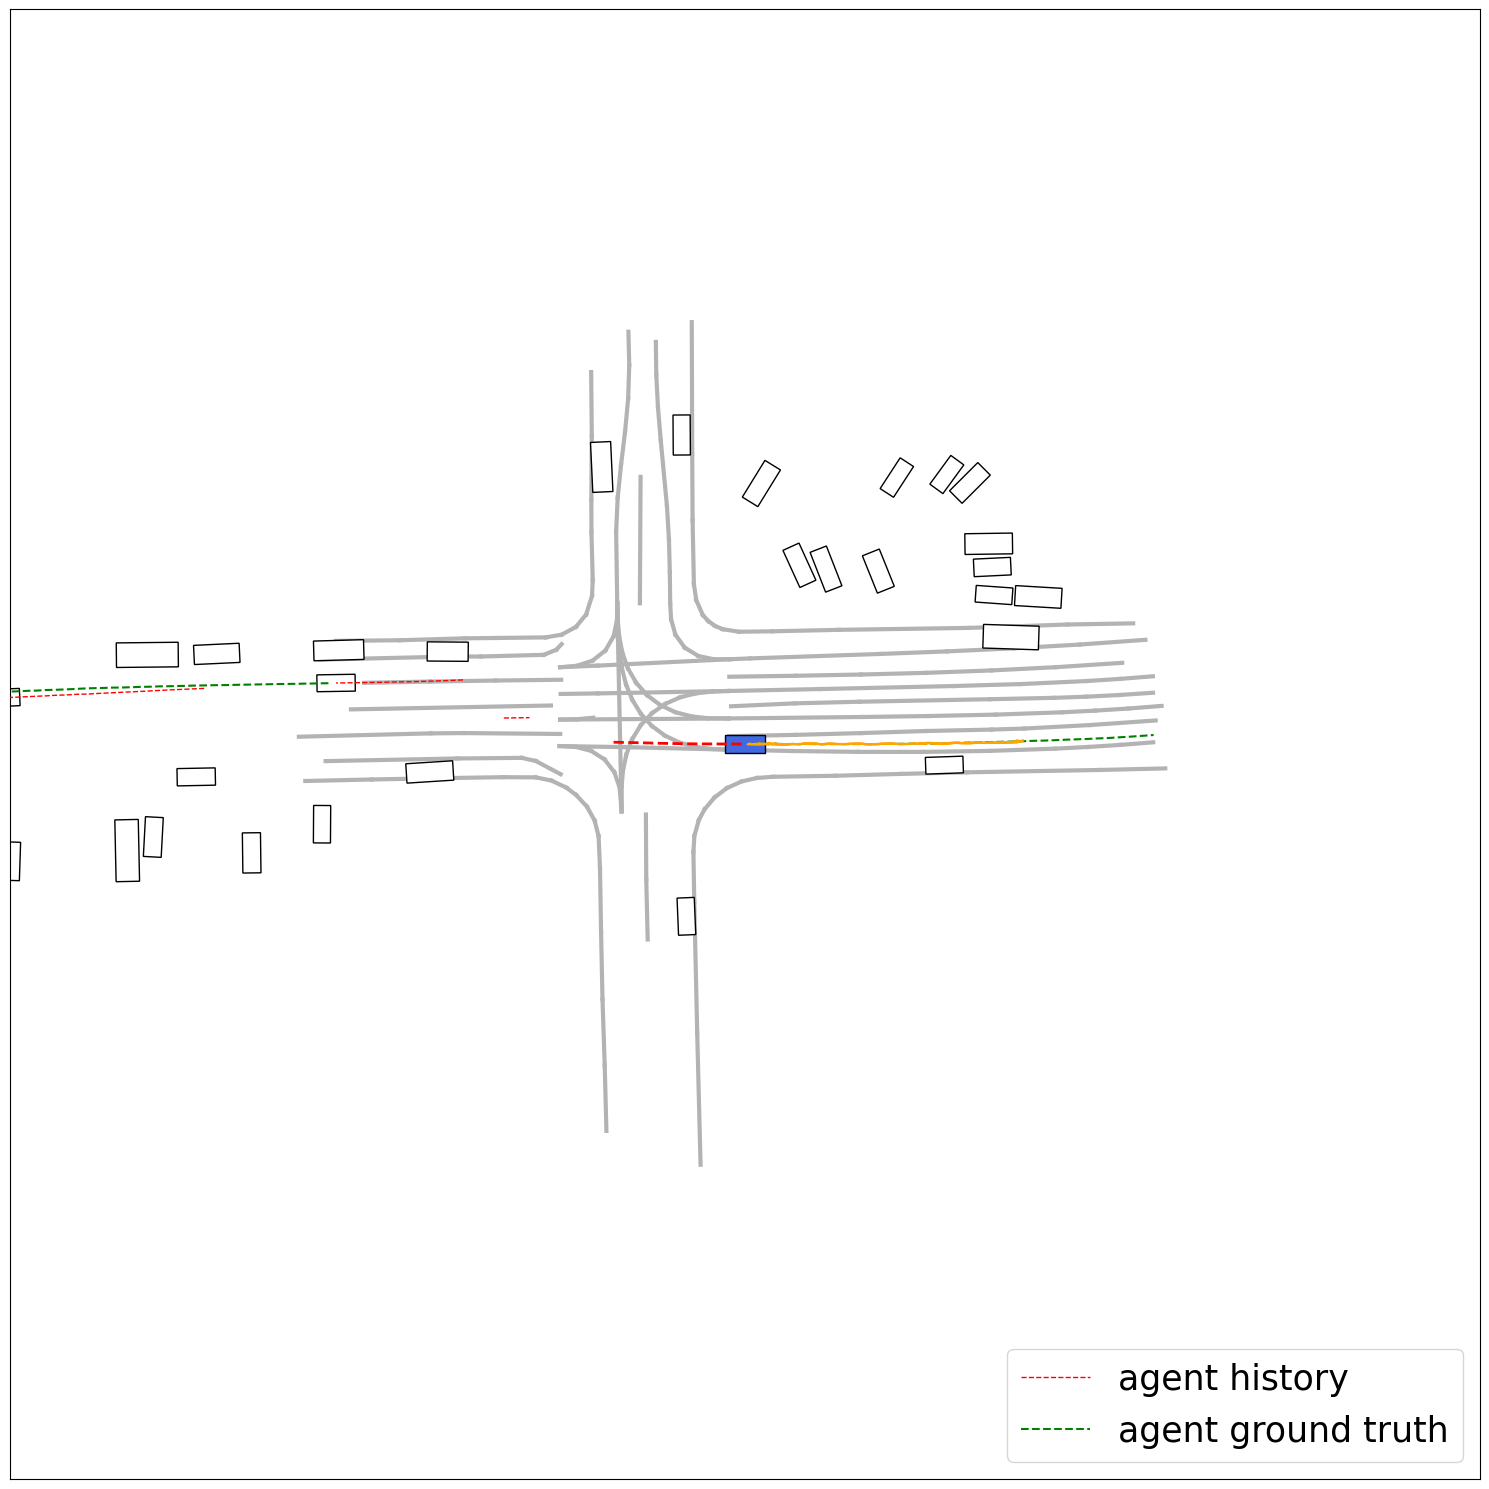

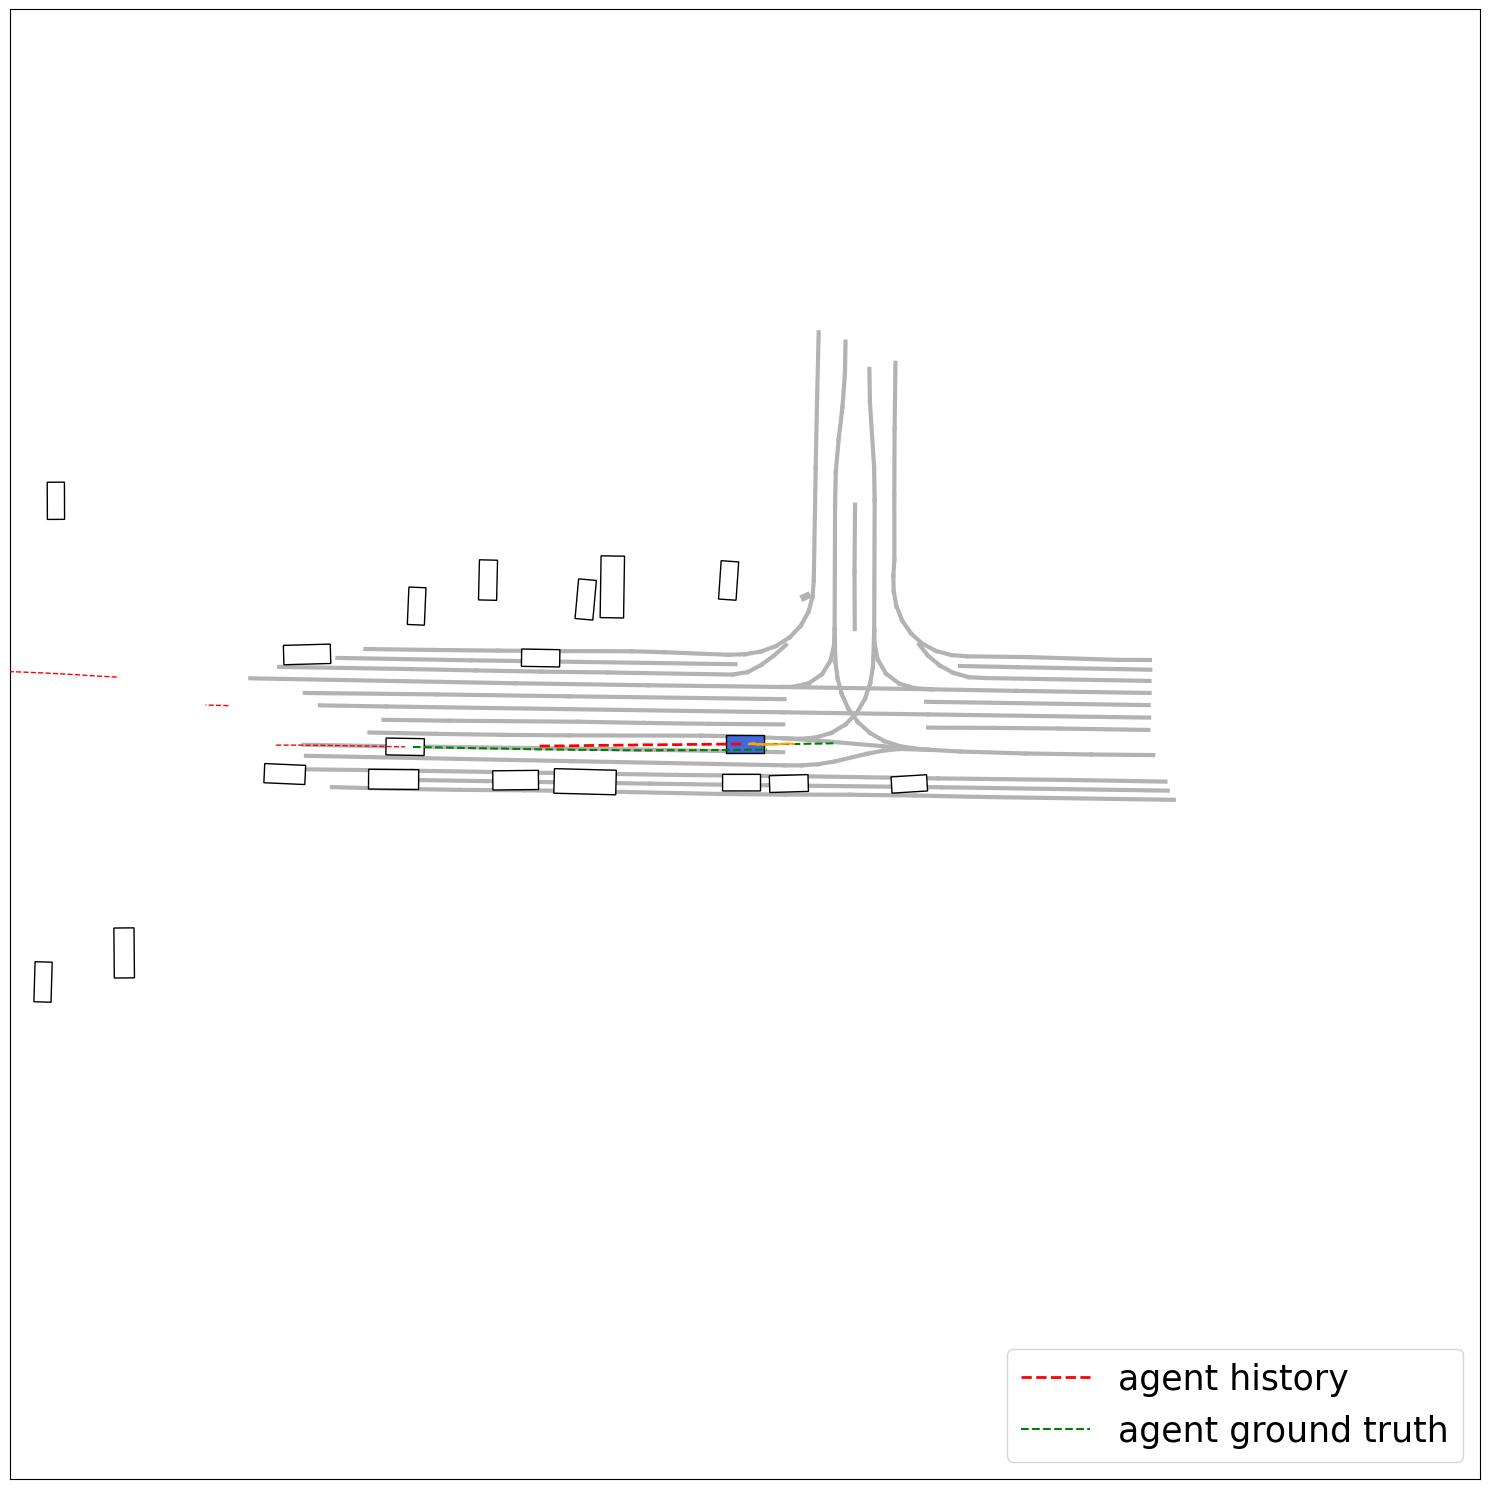

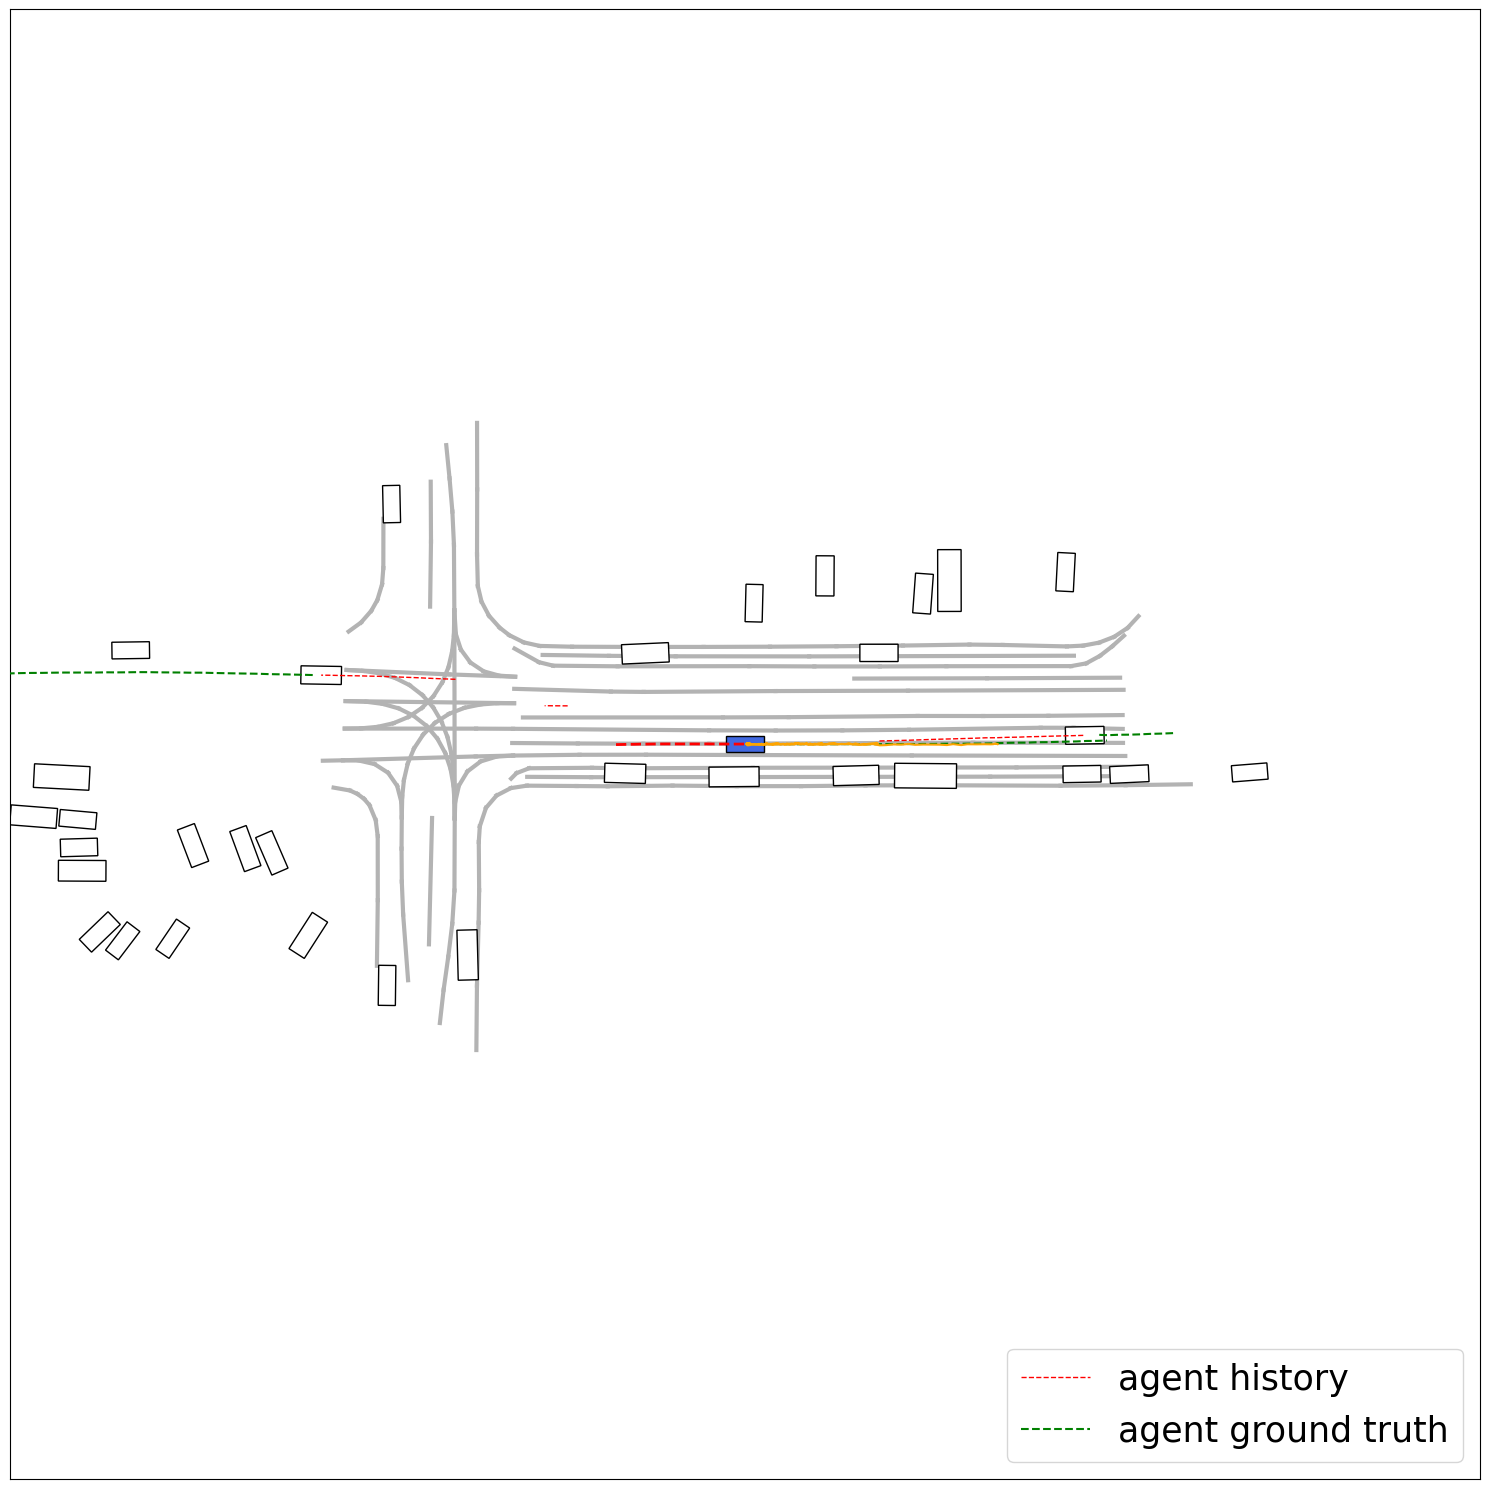

100%|██████████| 100/100 [00:08<00:00, 12.12it/s]
INFO:root:Epoch: 7, Last loss: 16.365530014038086


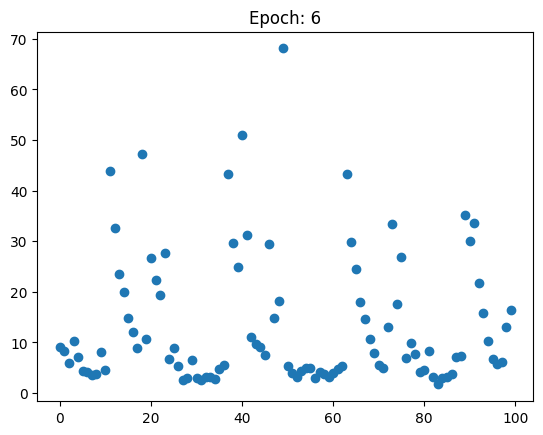

 98%|█████████▊| 98/100 [00:07<00:00, 16.68it/s]

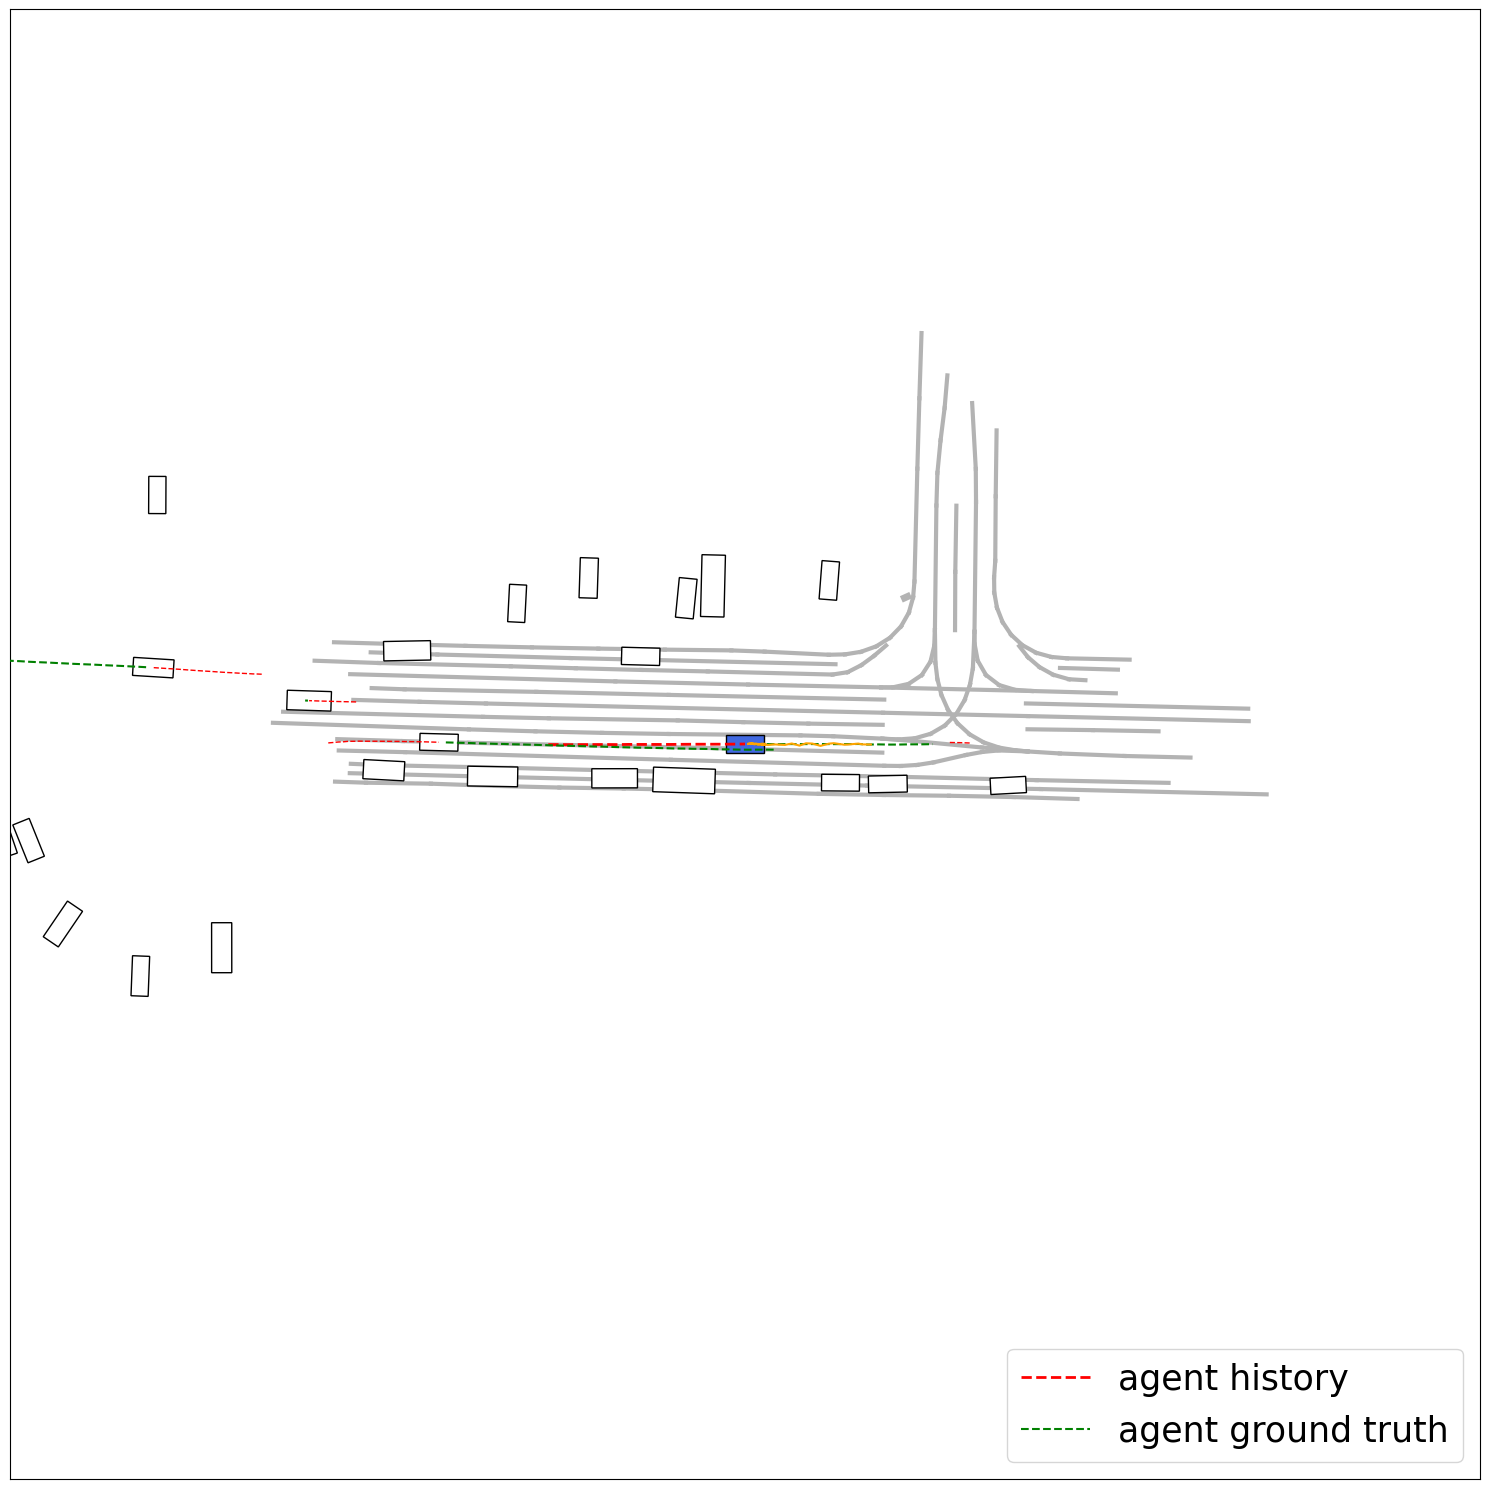

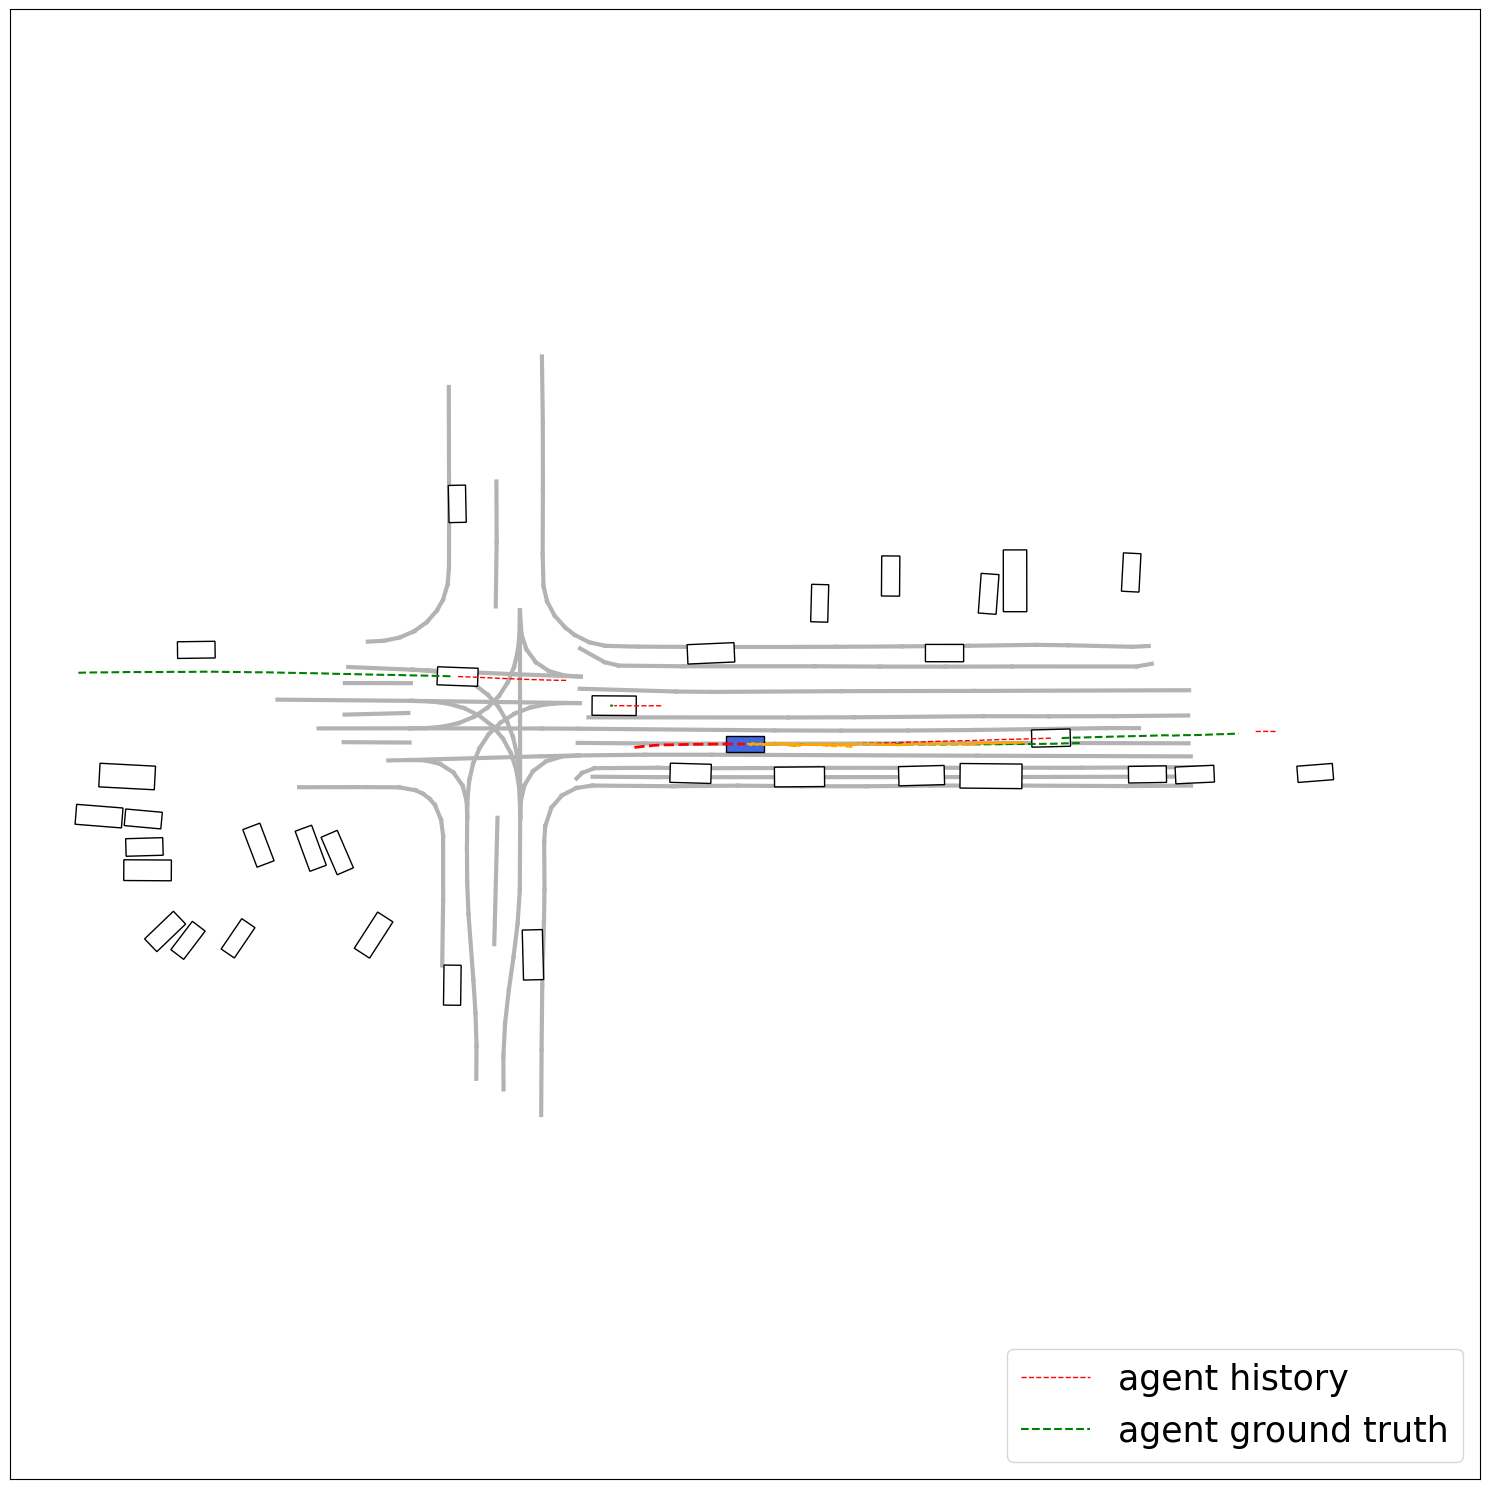

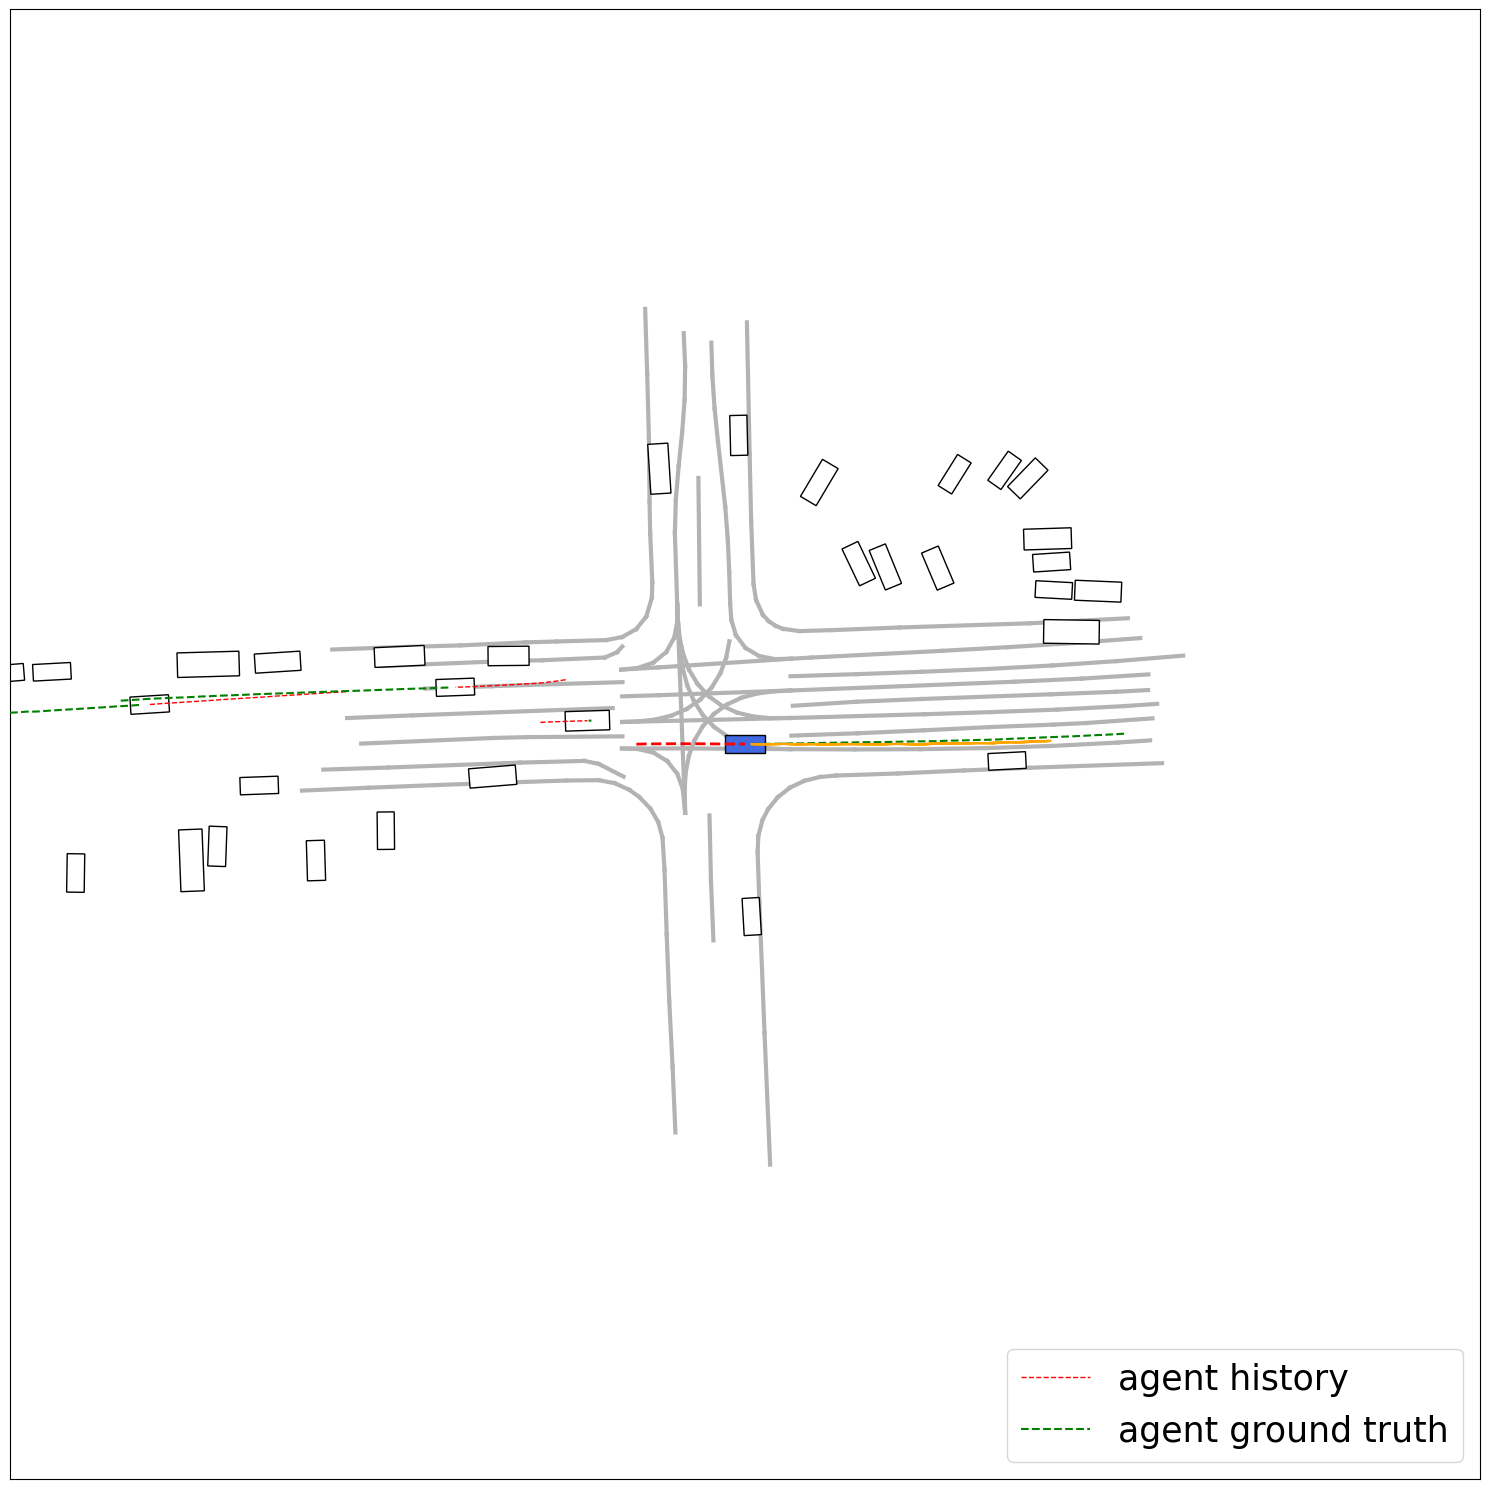

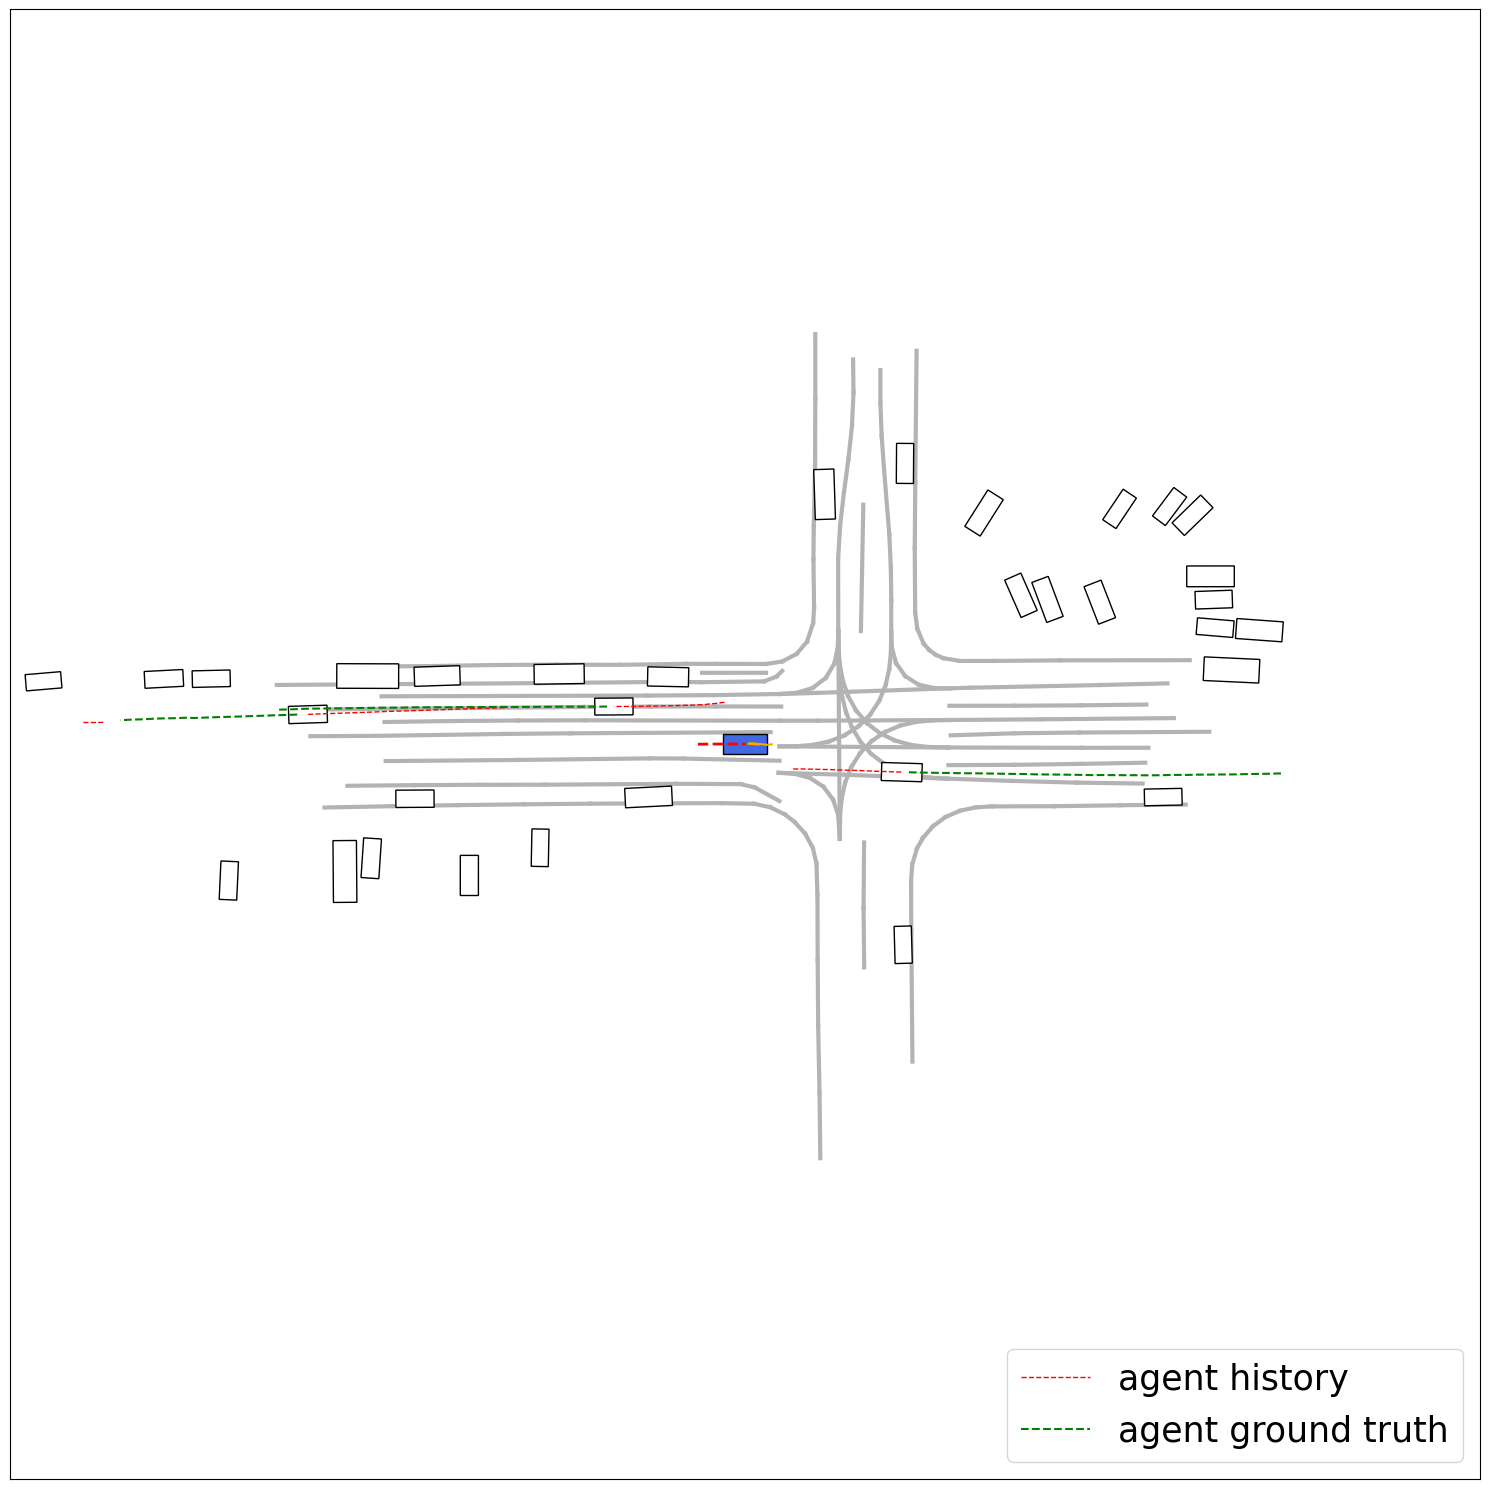

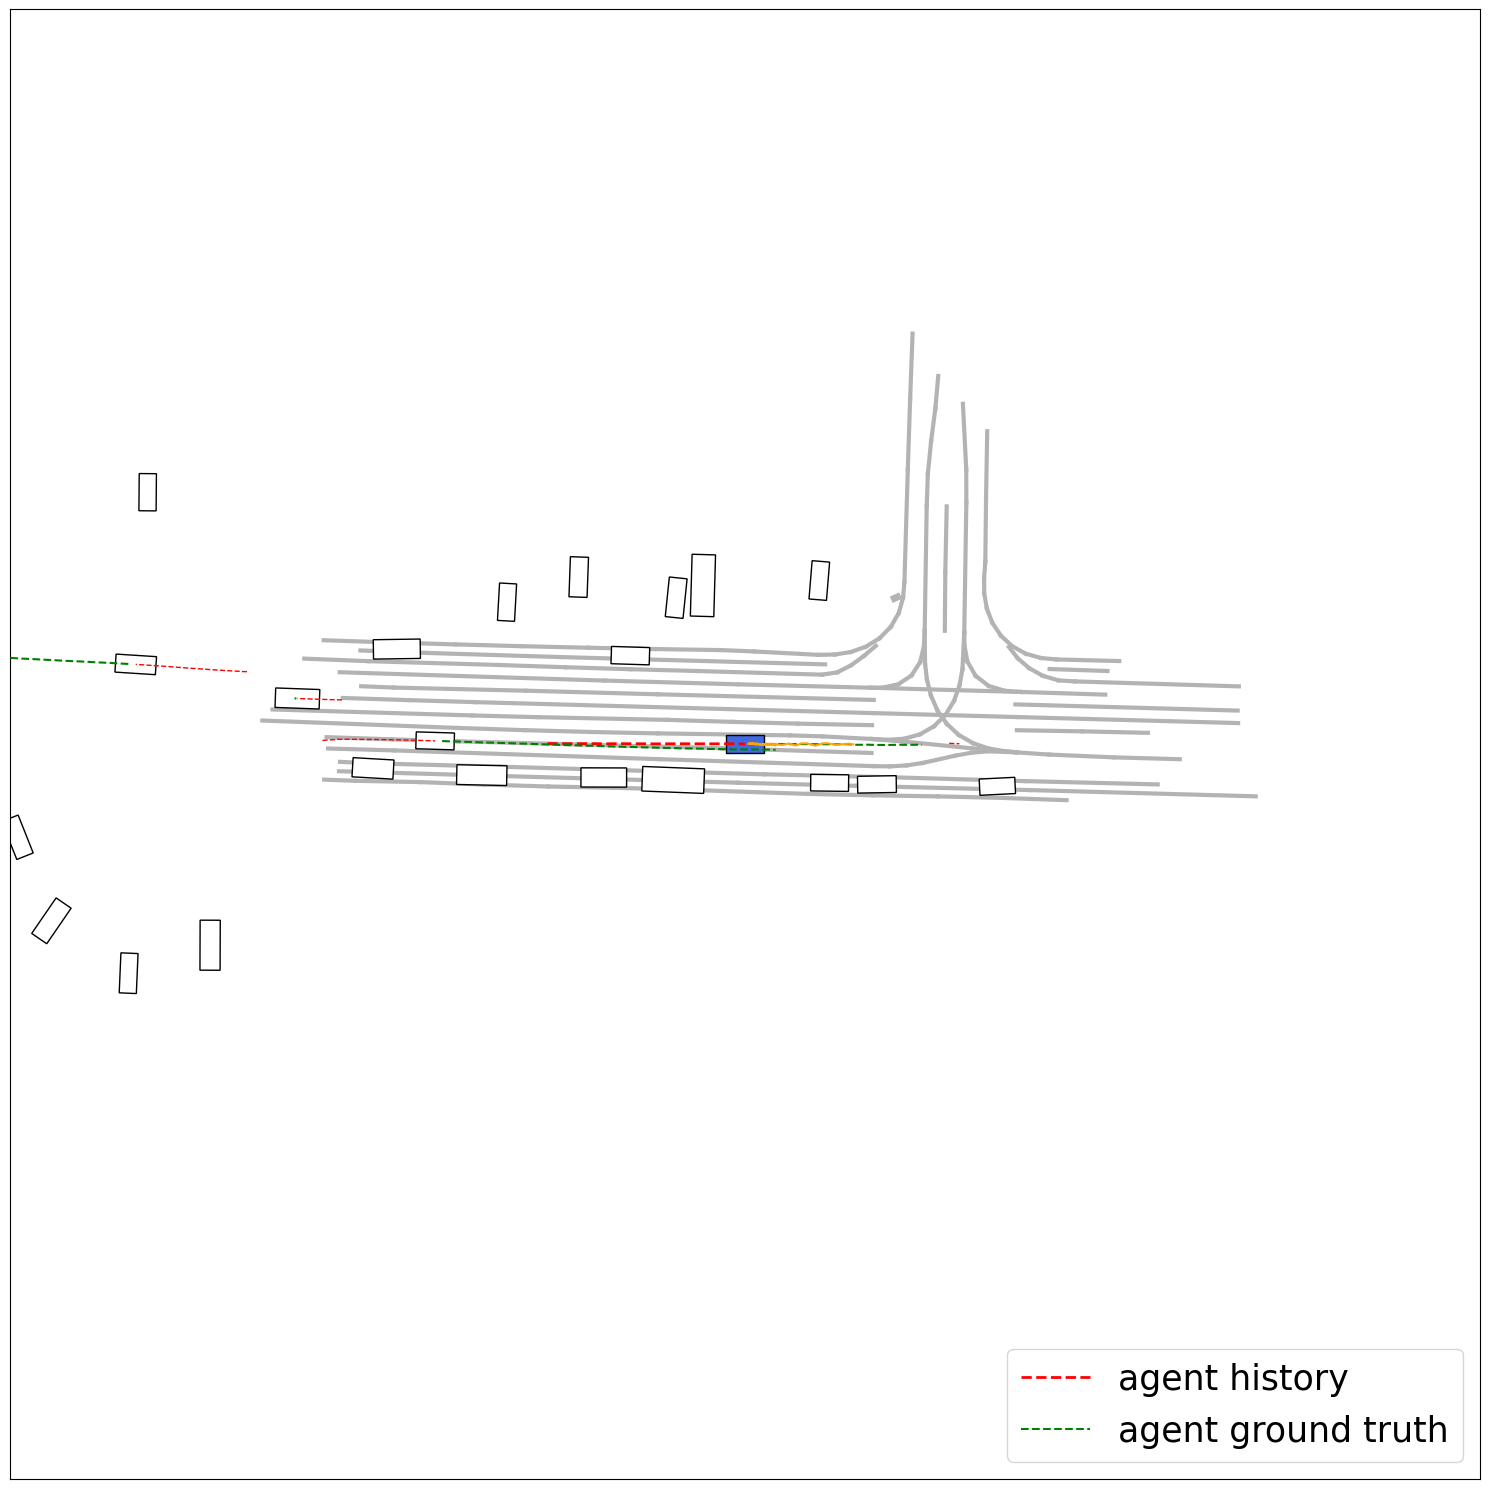

100%|██████████| 100/100 [00:08<00:00, 11.21it/s]
INFO:root:Epoch: 8, Last loss: 8.477583885192871


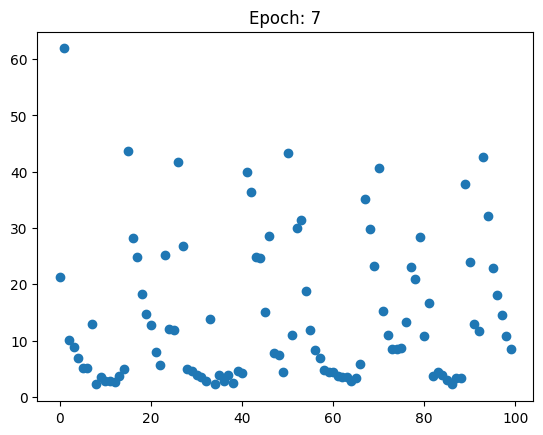

 99%|█████████▉| 99/100 [00:07<00:00, 15.49it/s]

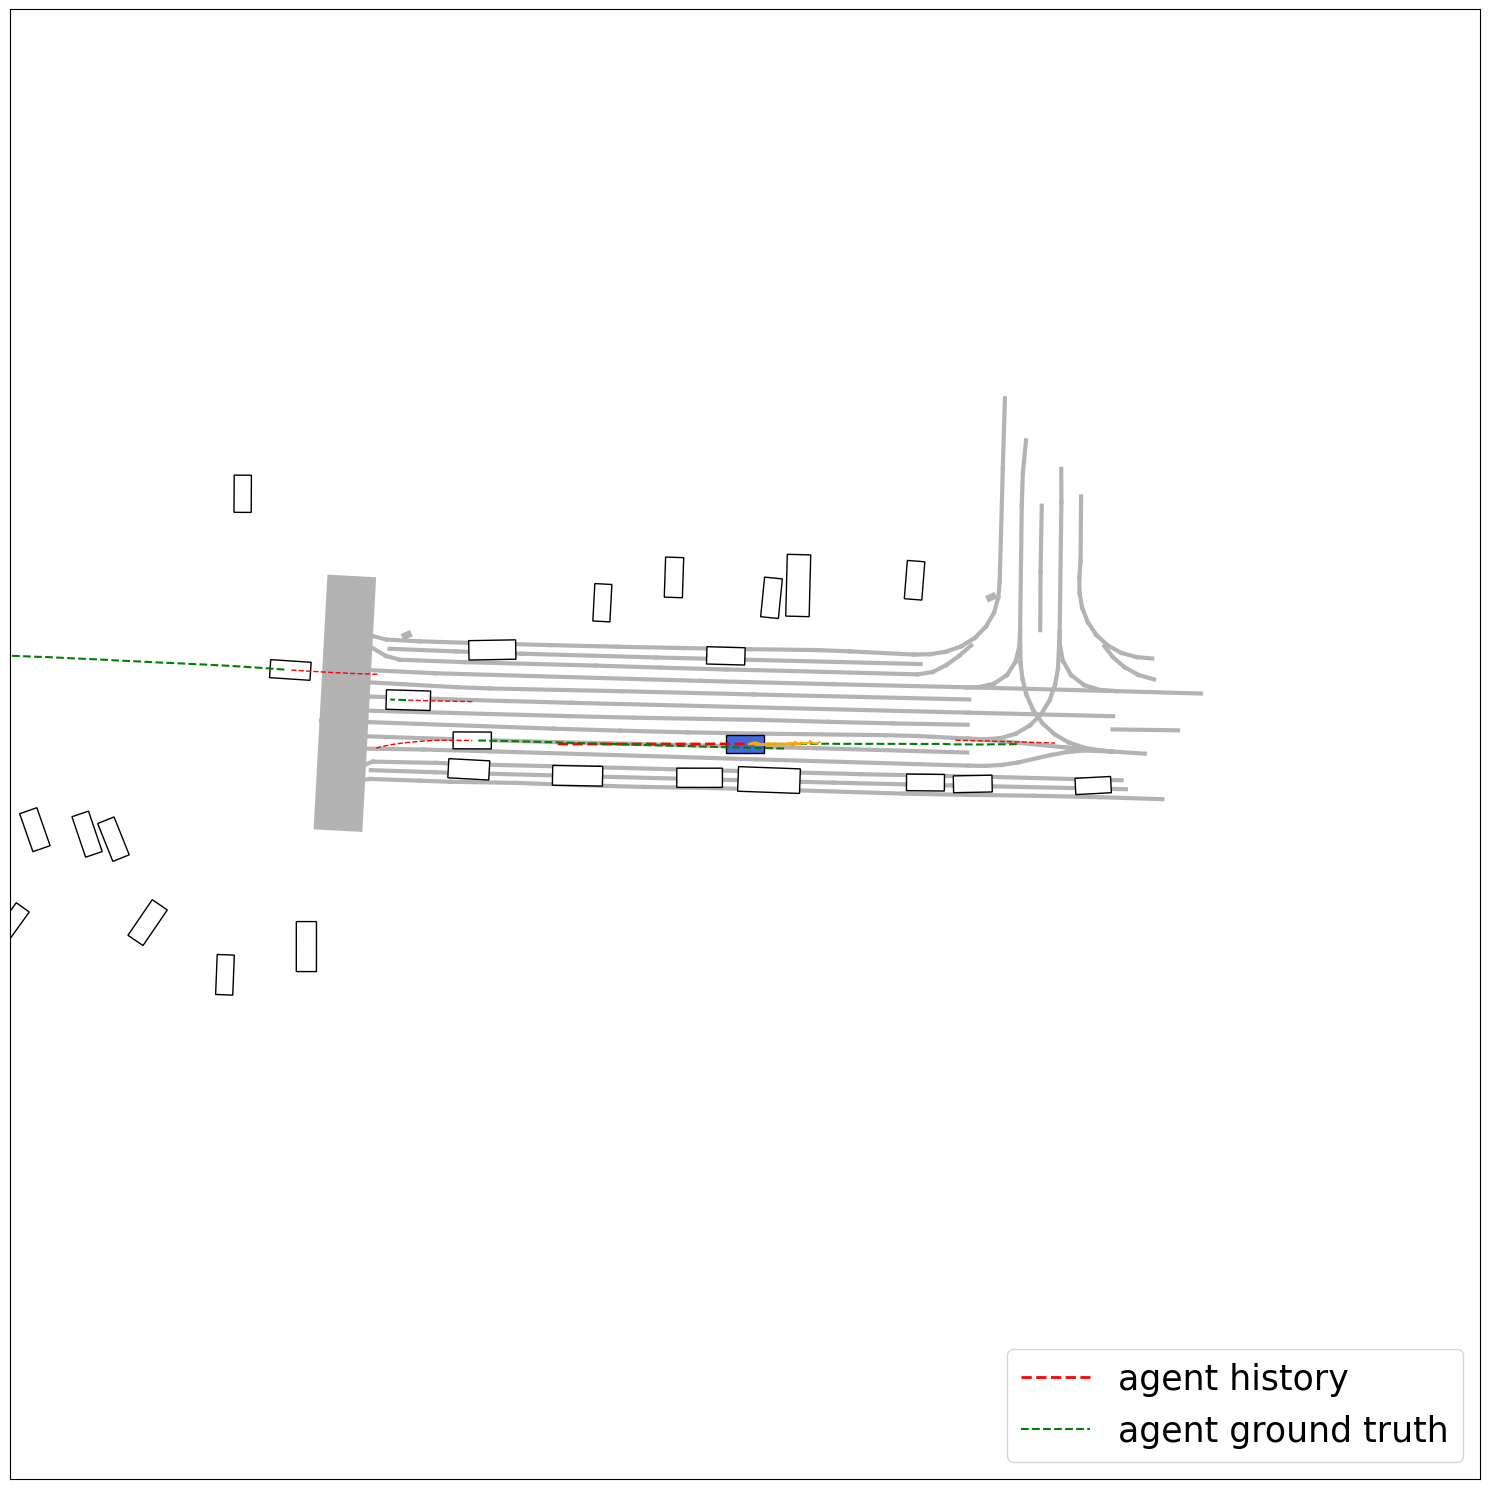

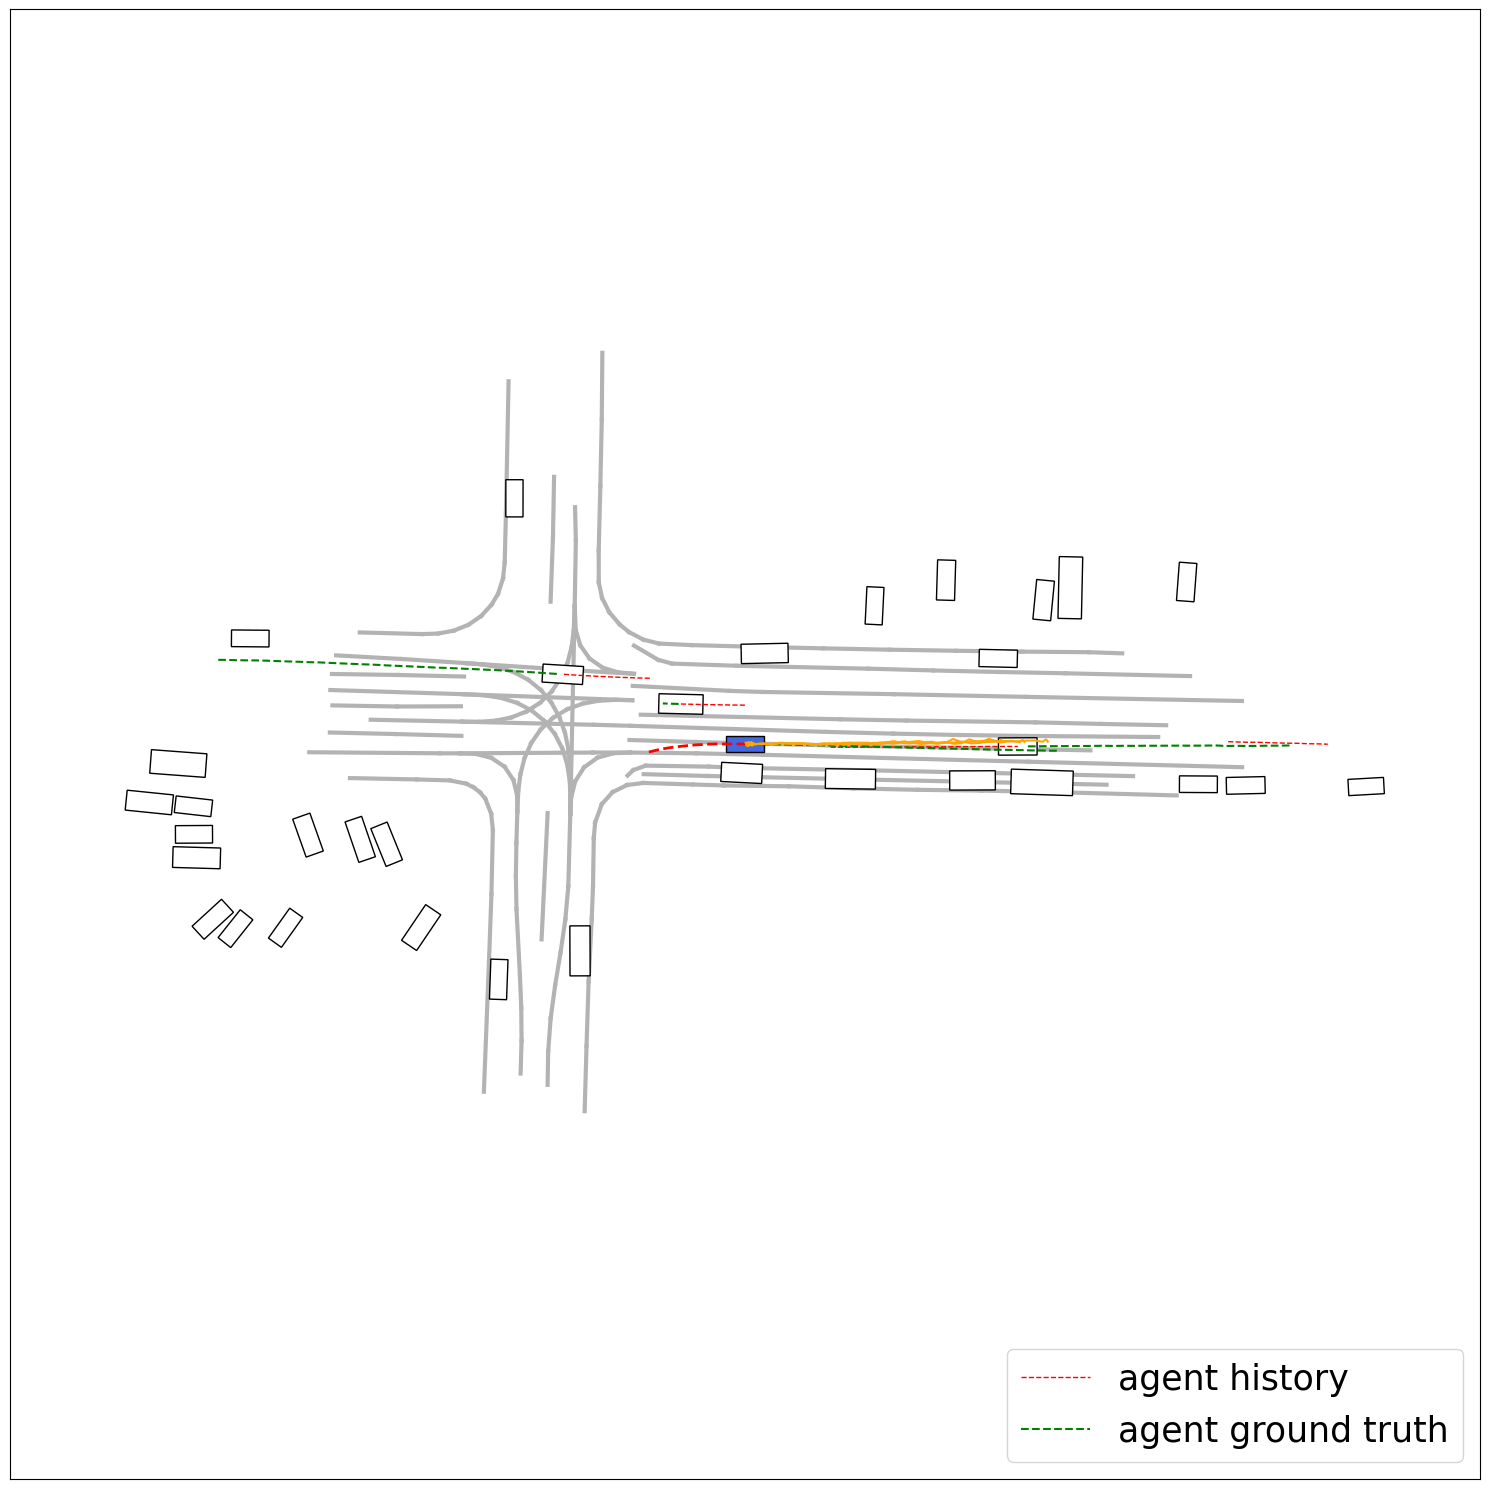

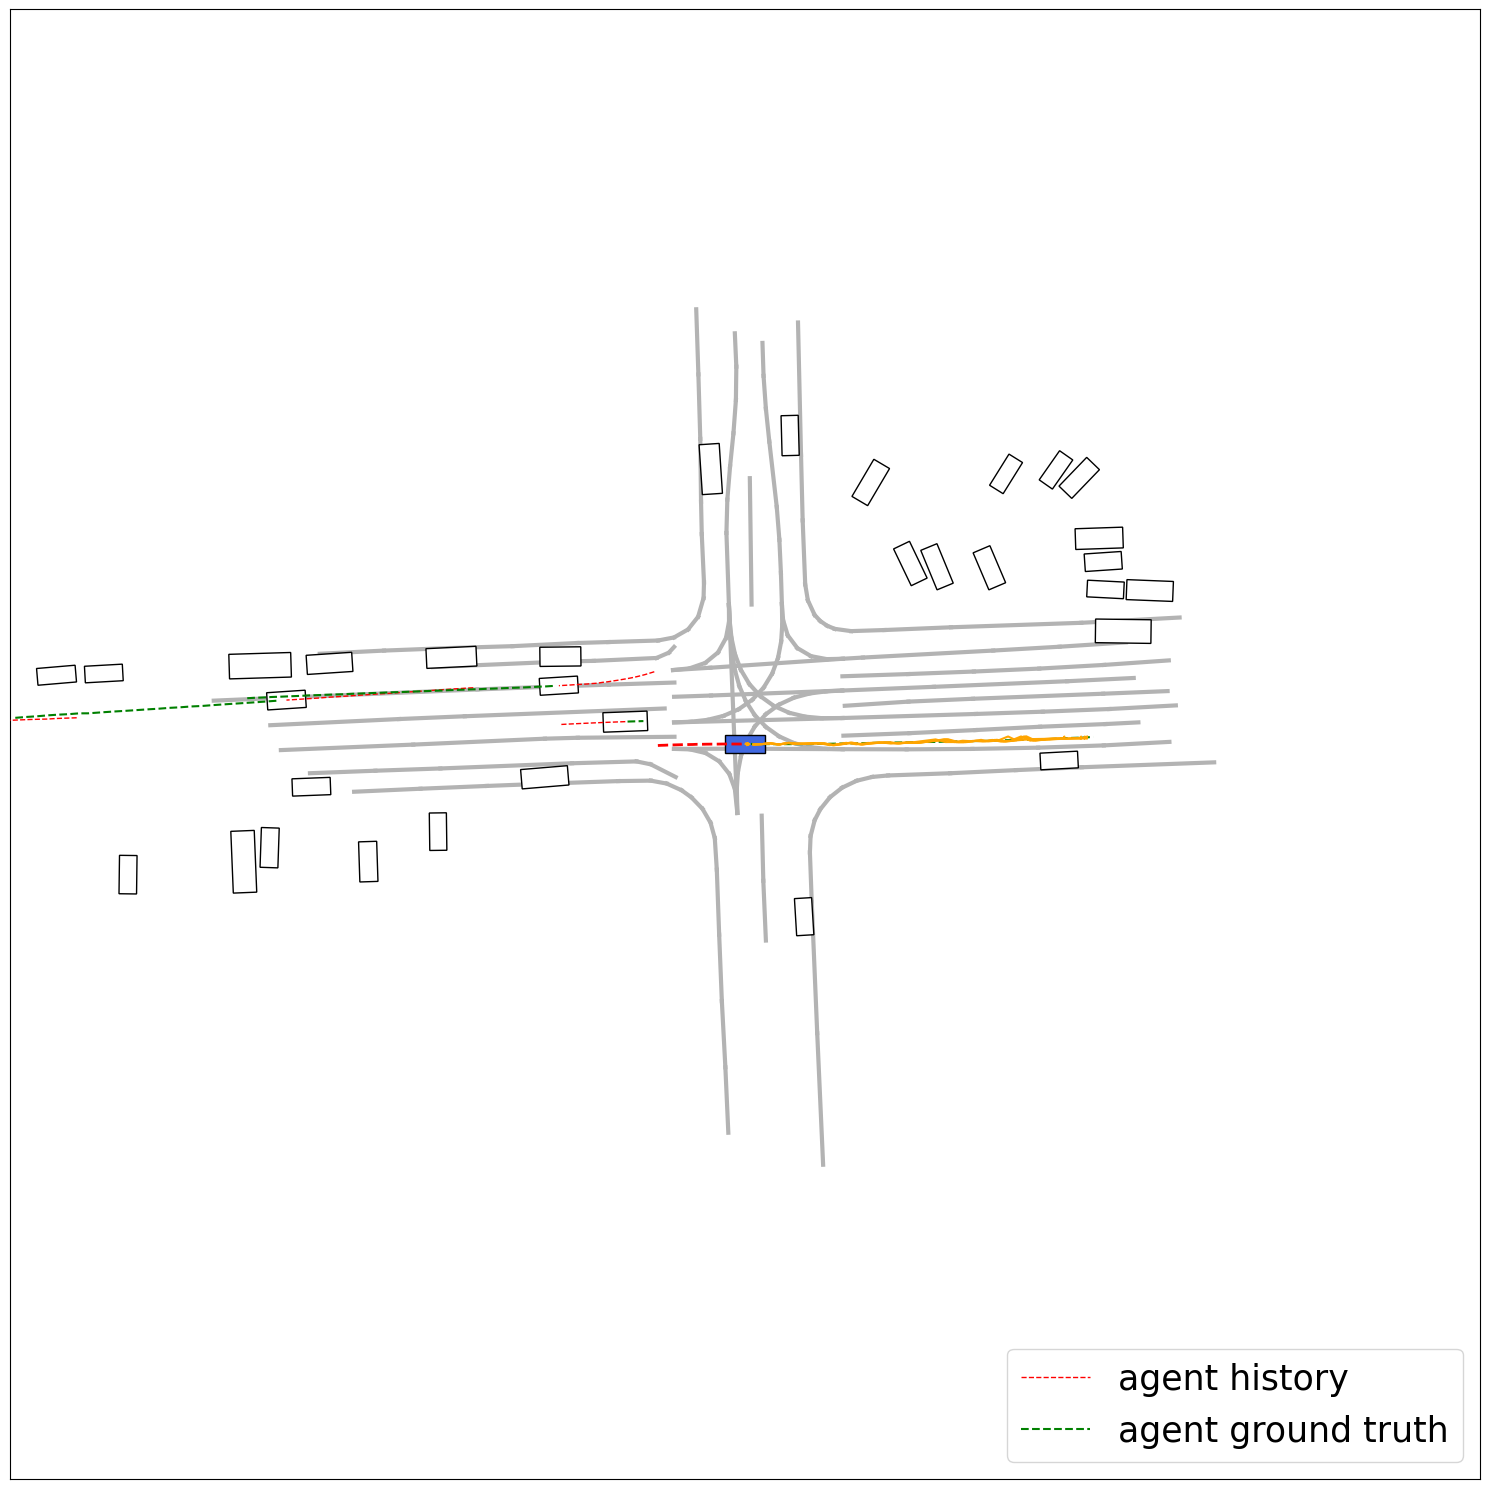

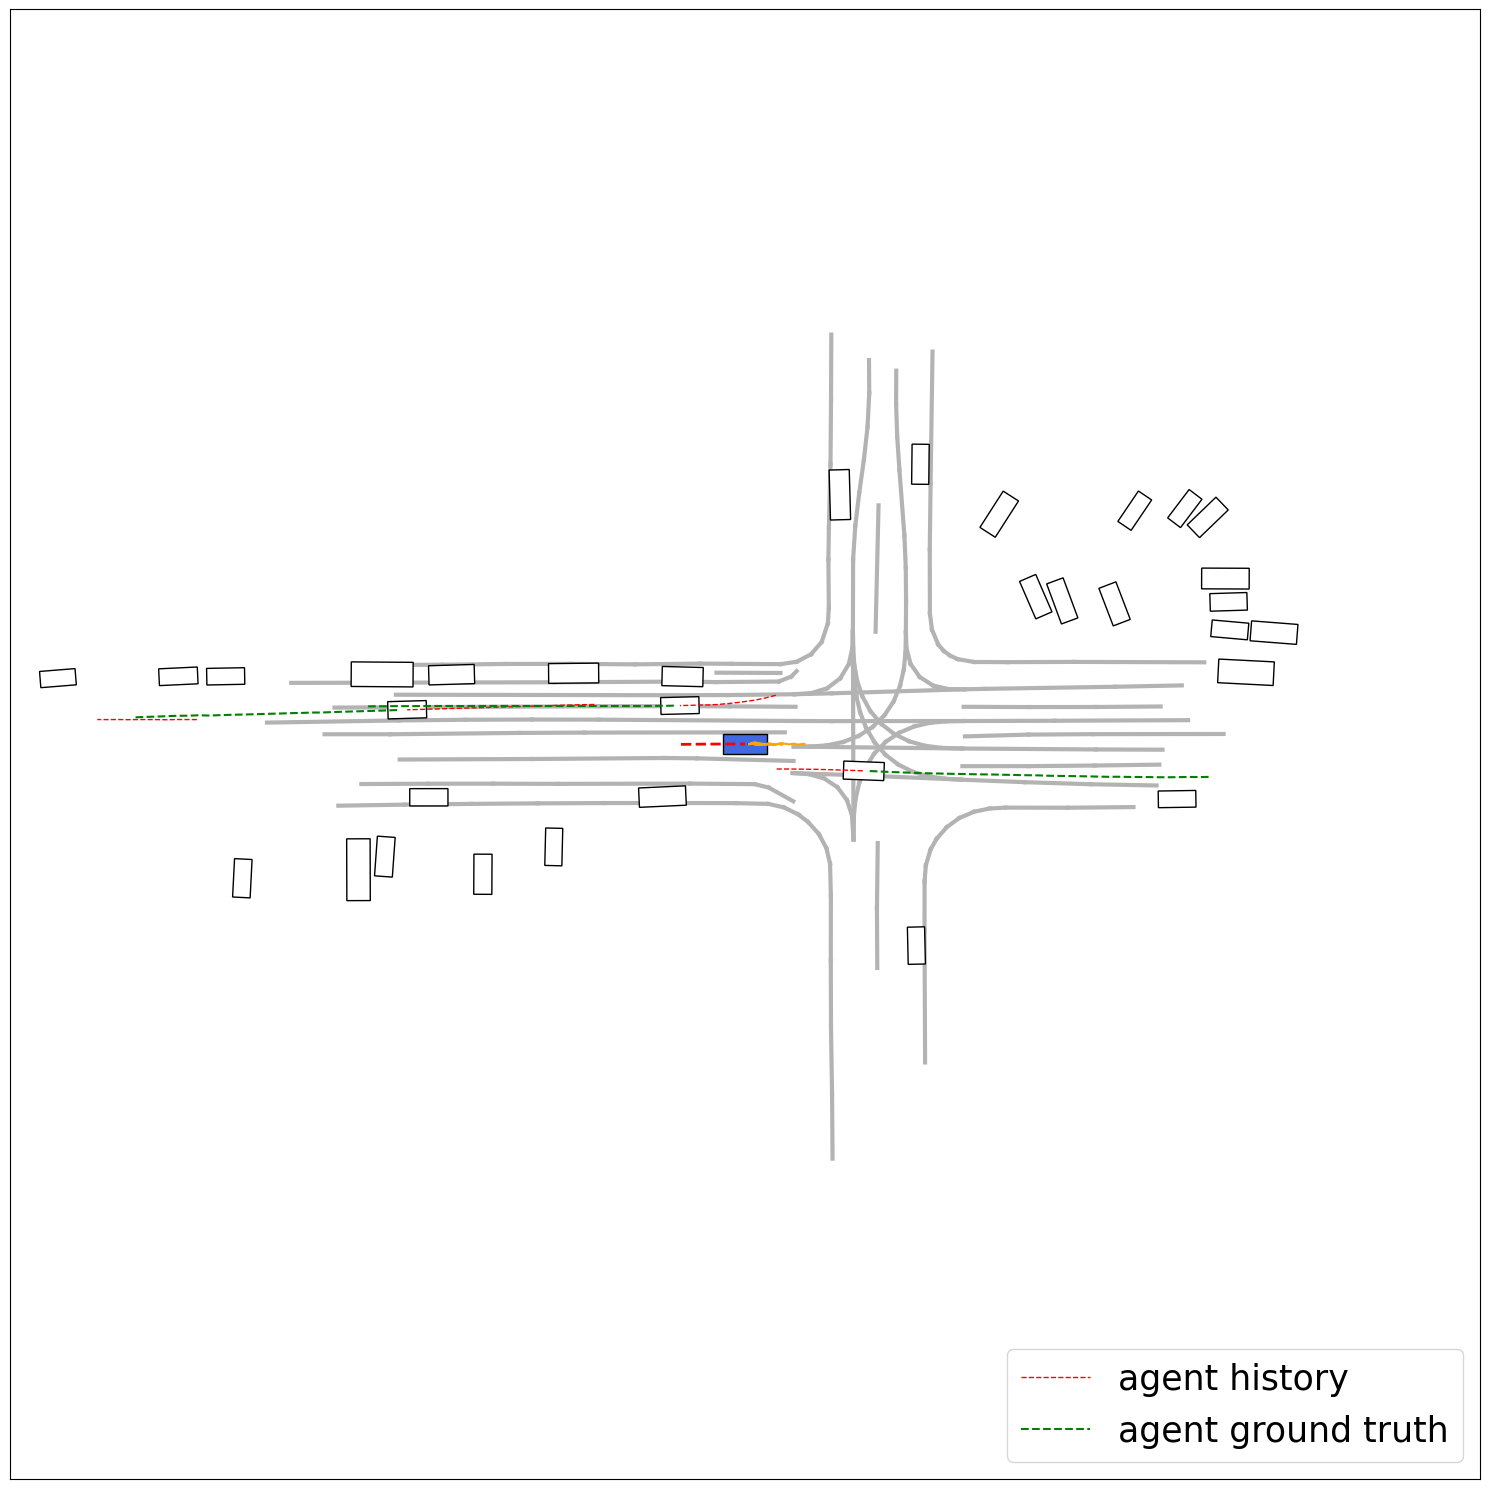

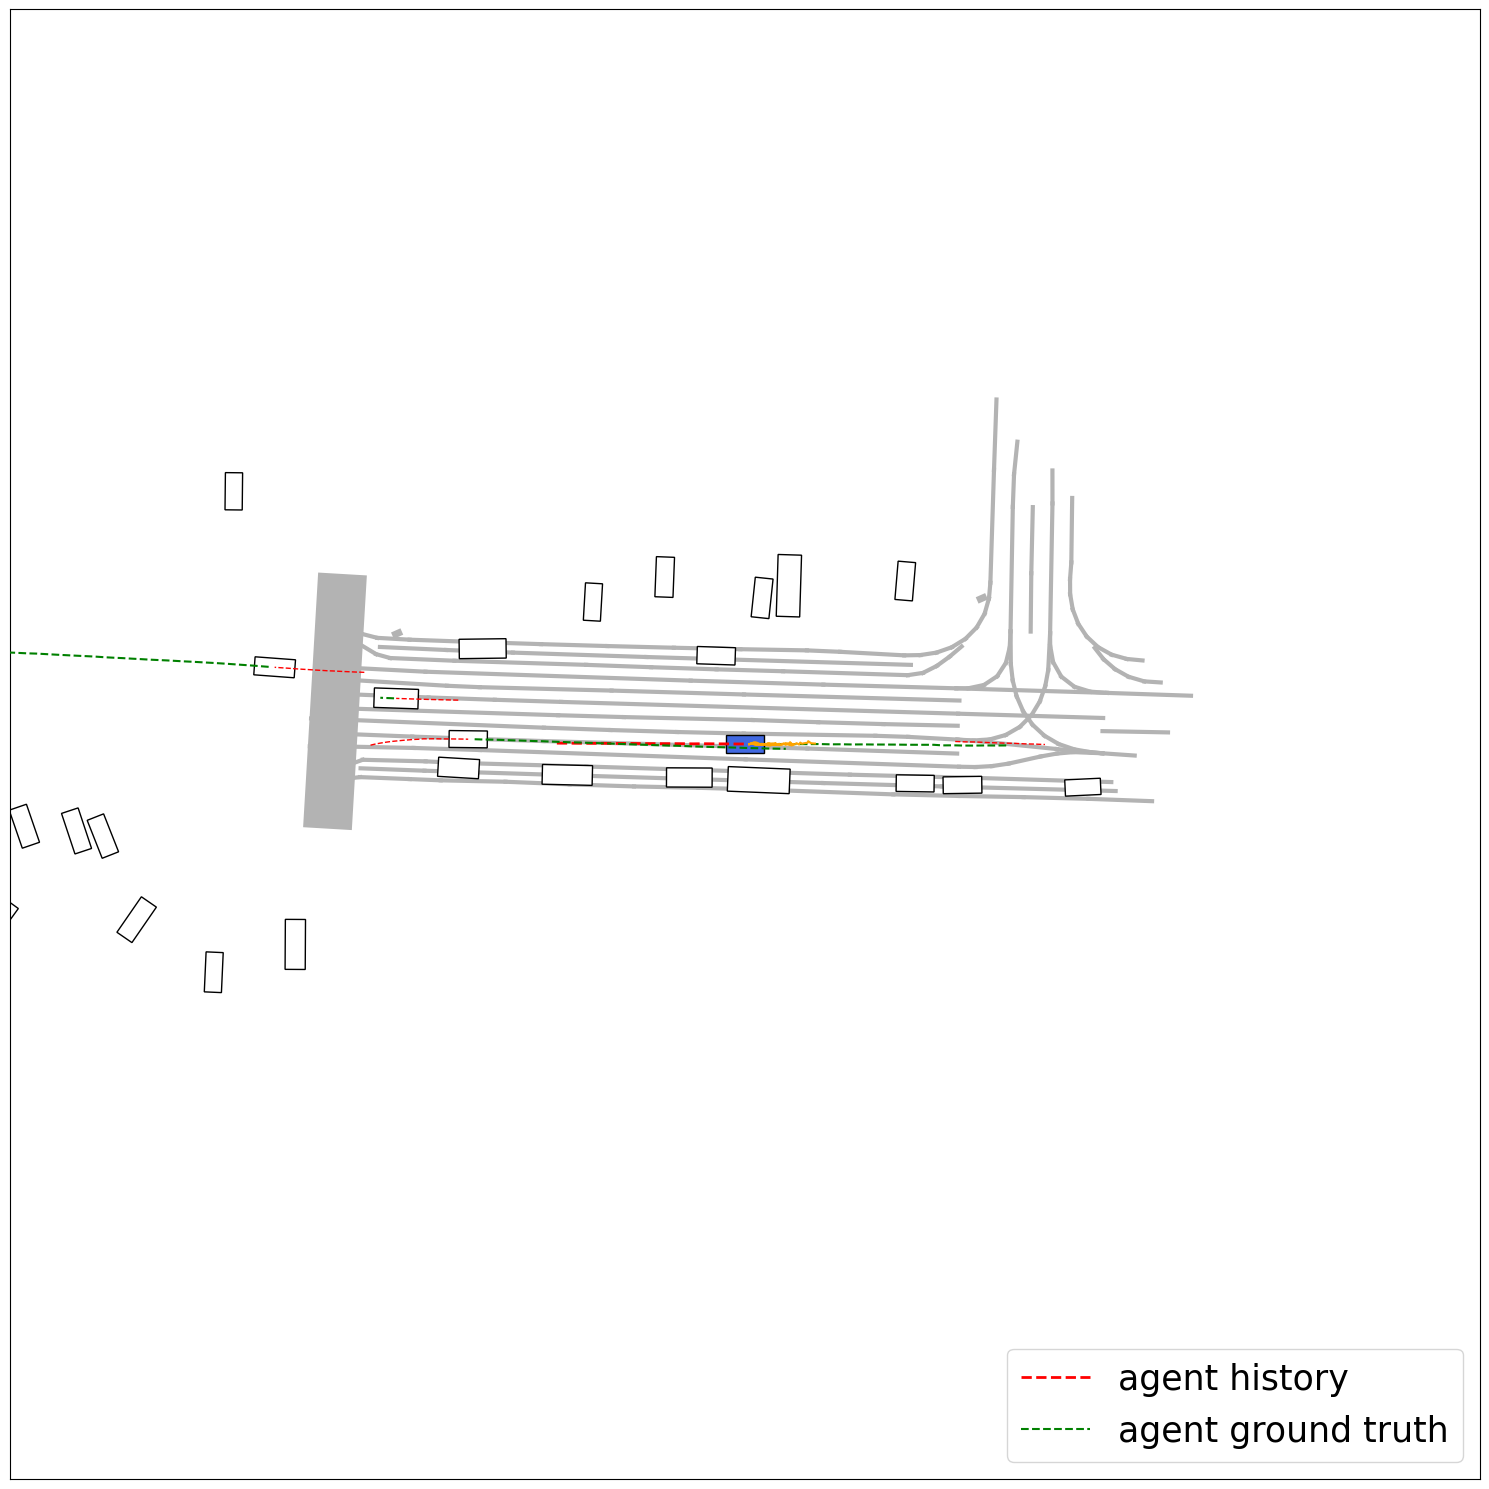

100%|██████████| 100/100 [00:09<00:00, 11.06it/s]
INFO:root:Epoch: 9, Last loss: 23.437334060668945


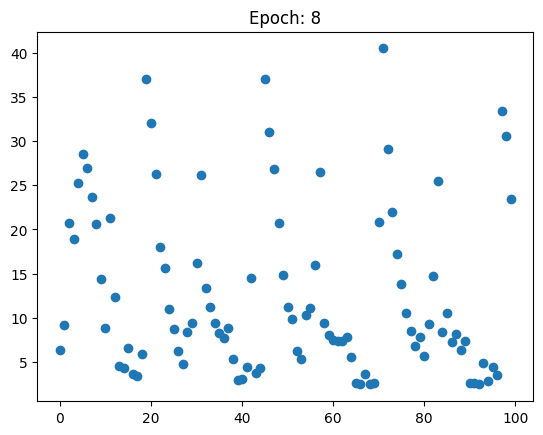

 99%|█████████▉| 99/100 [00:07<00:00, 13.25it/s]

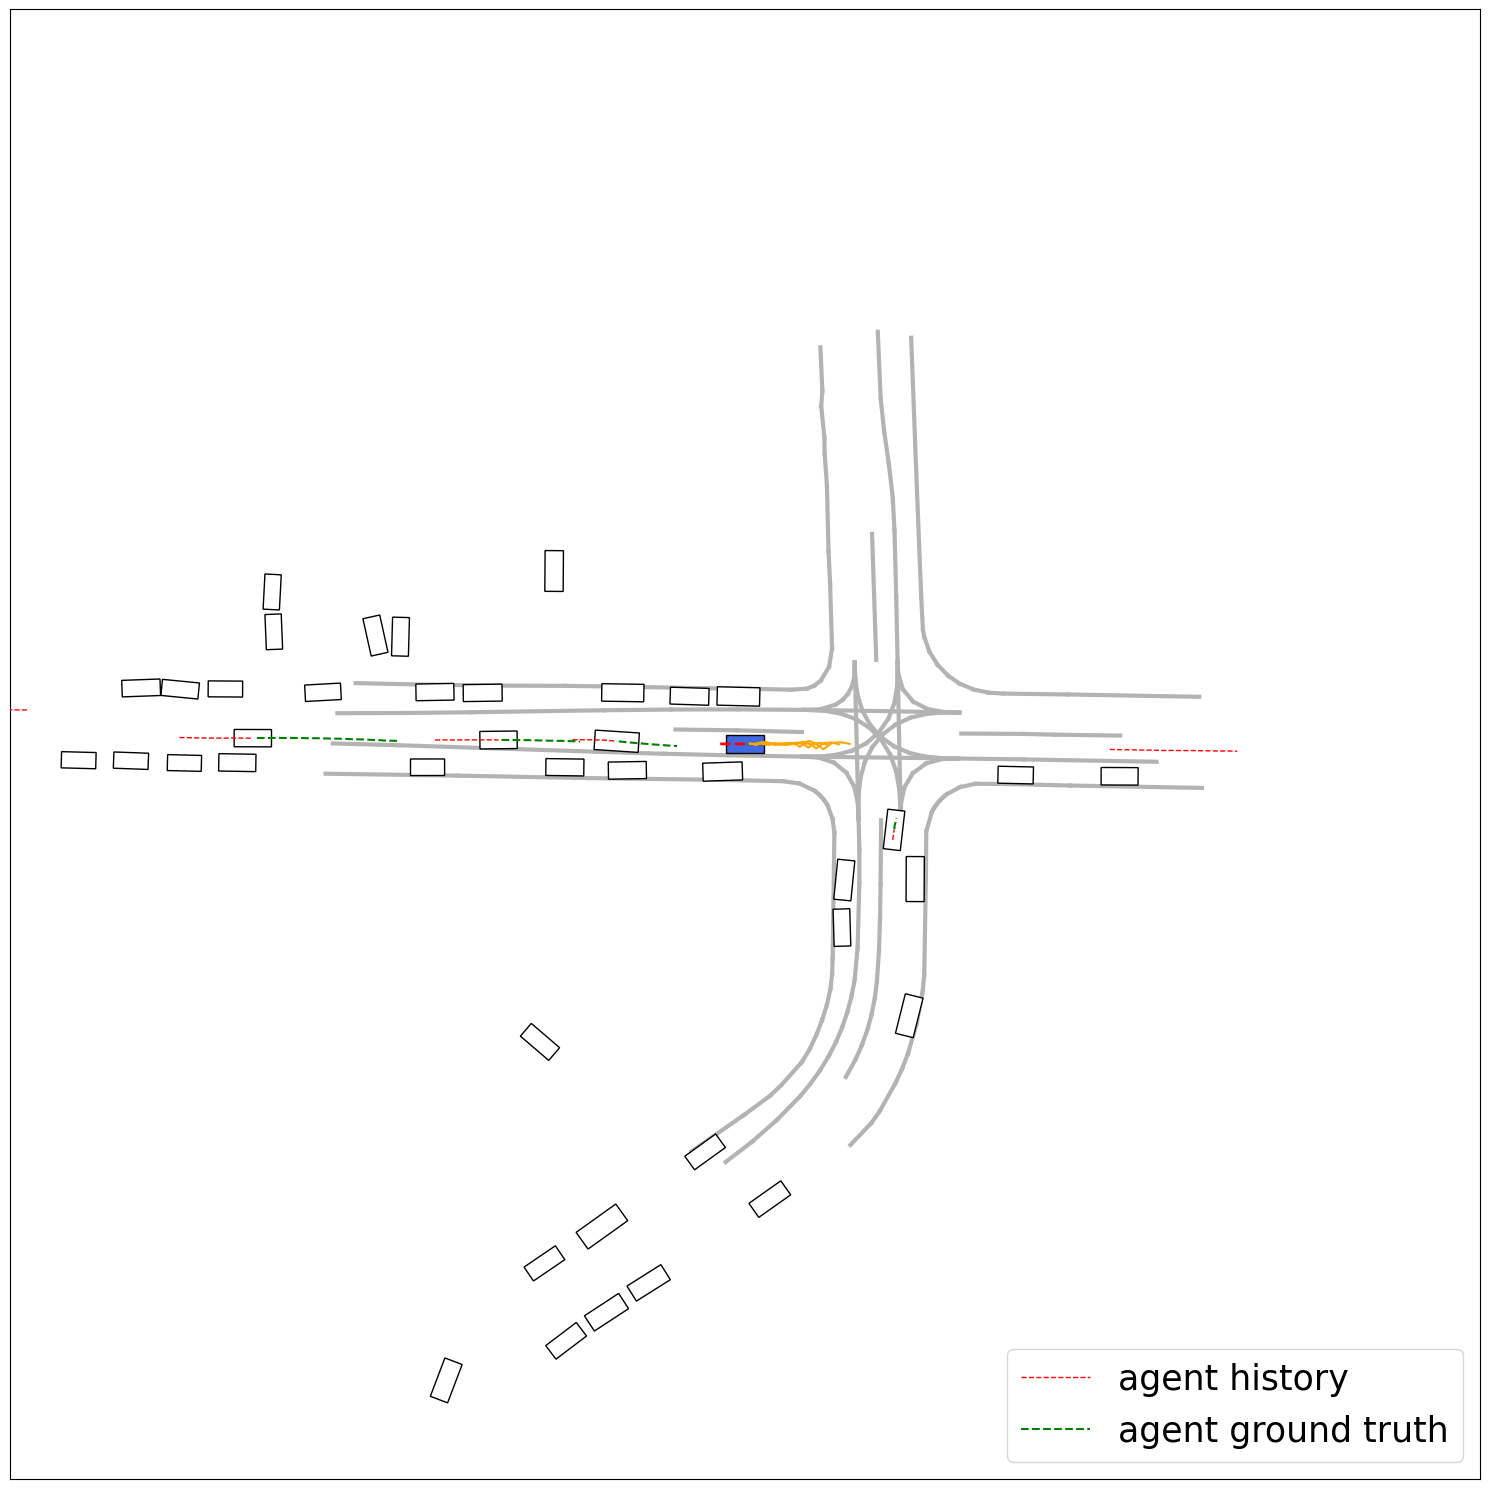

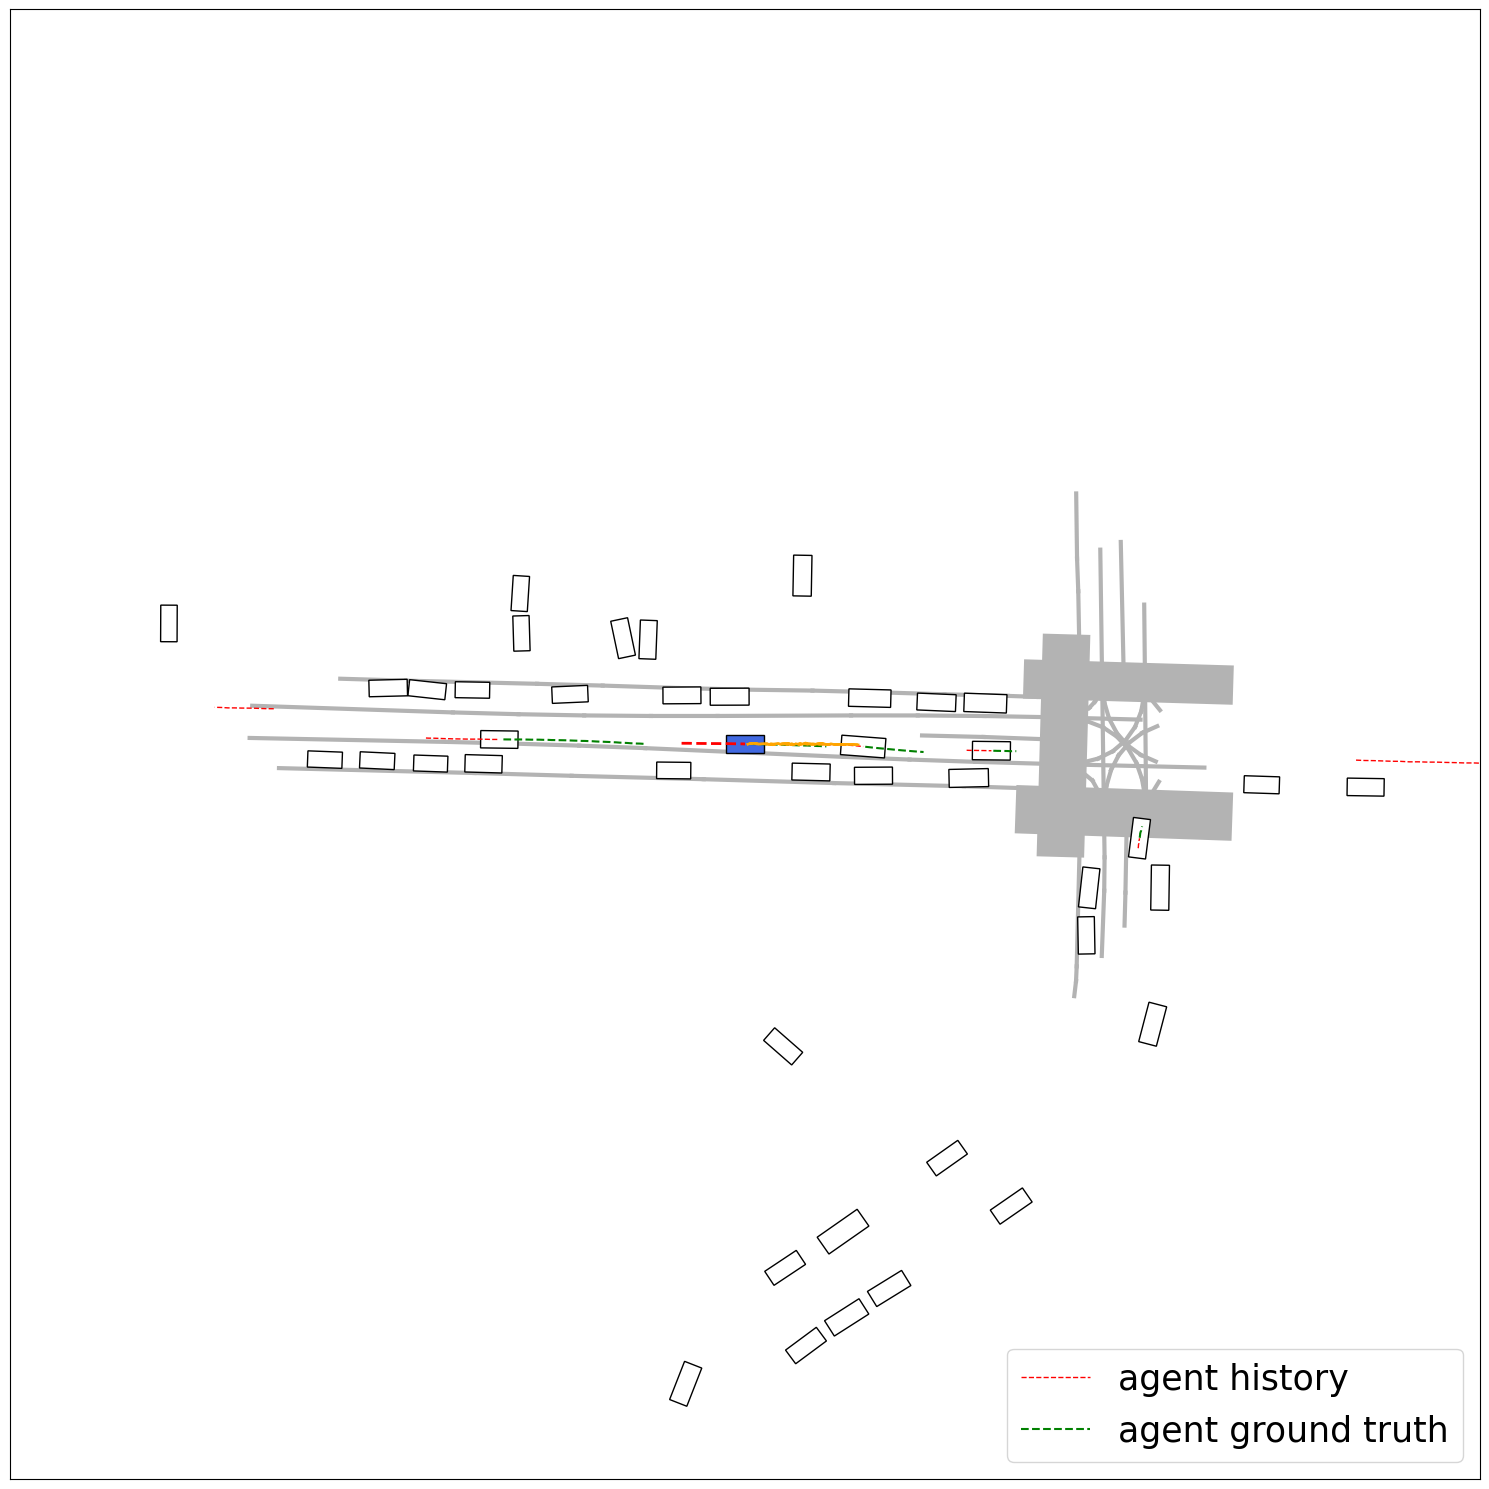

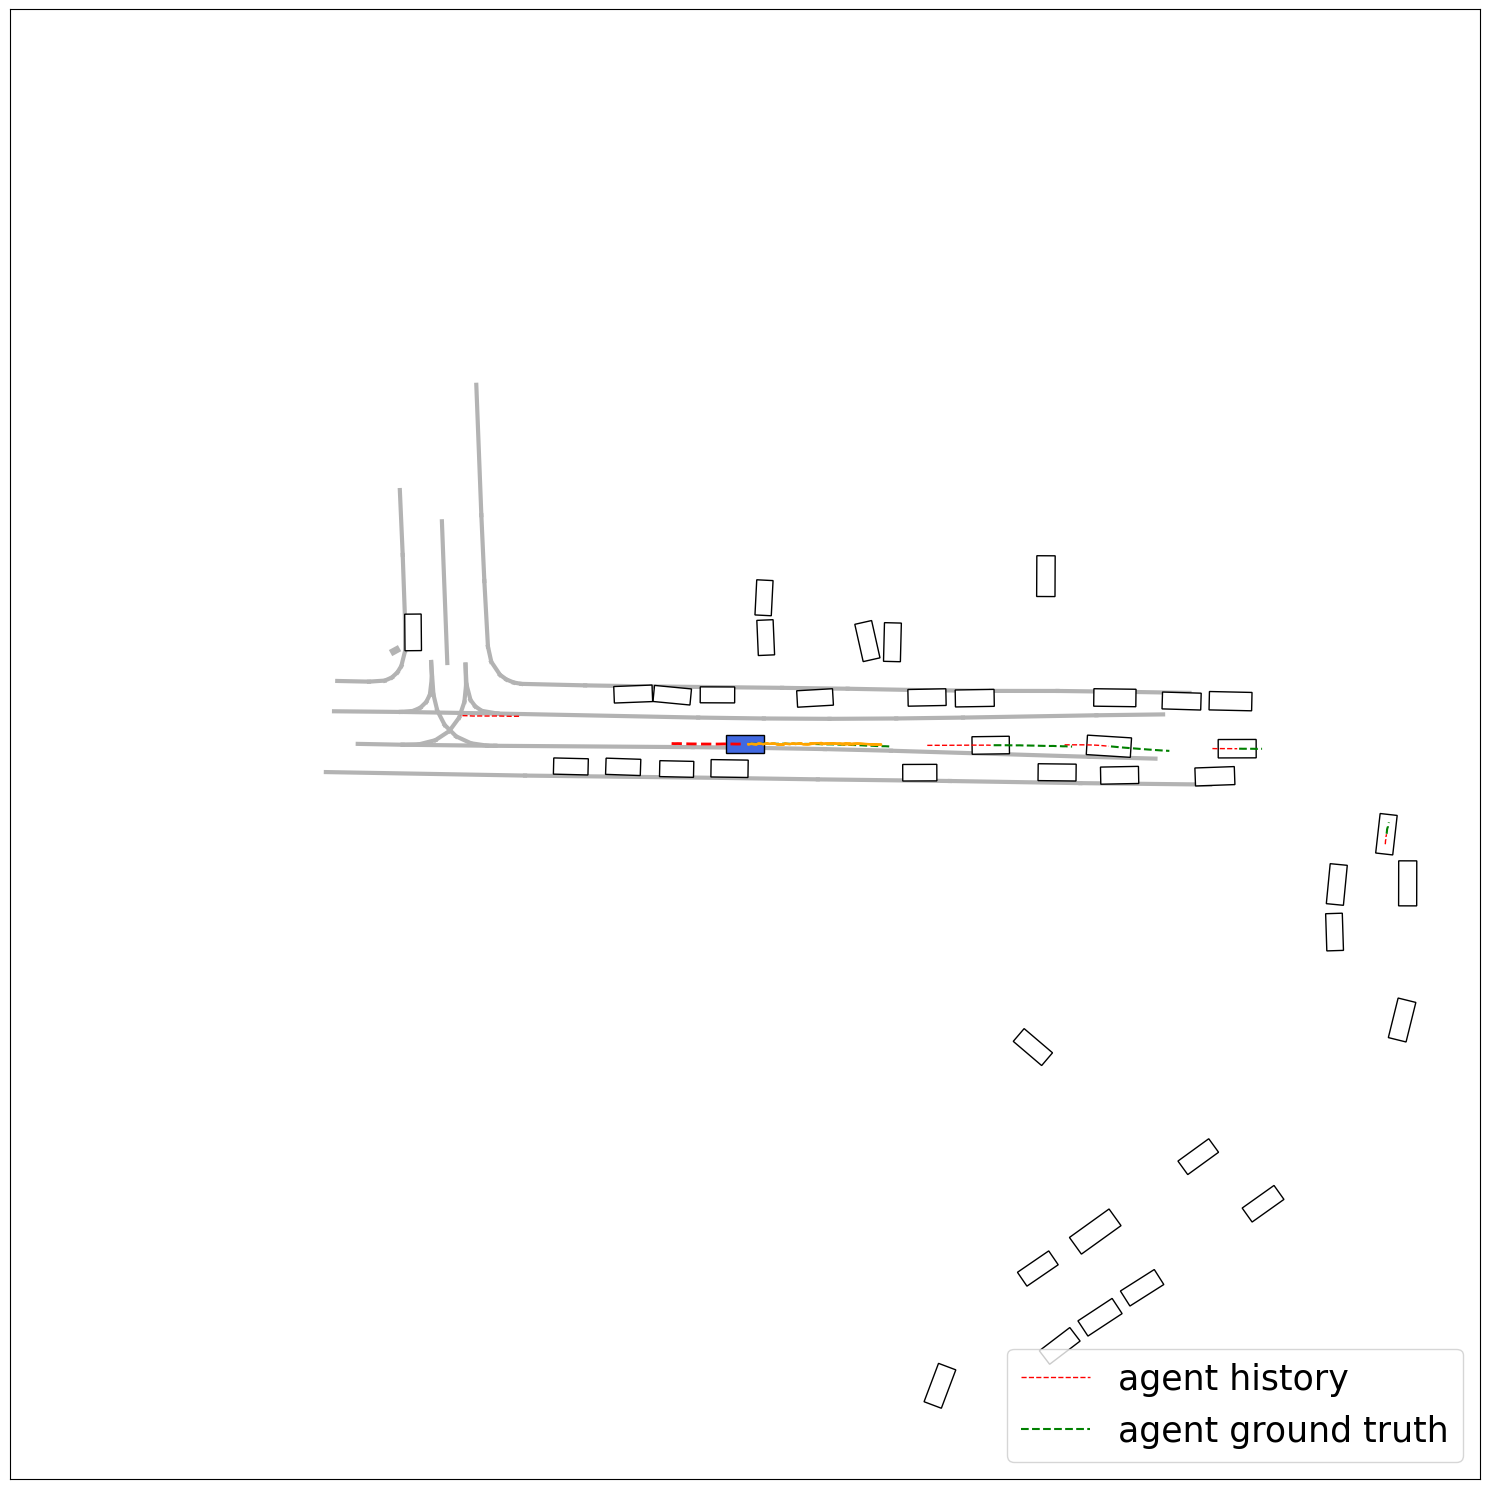

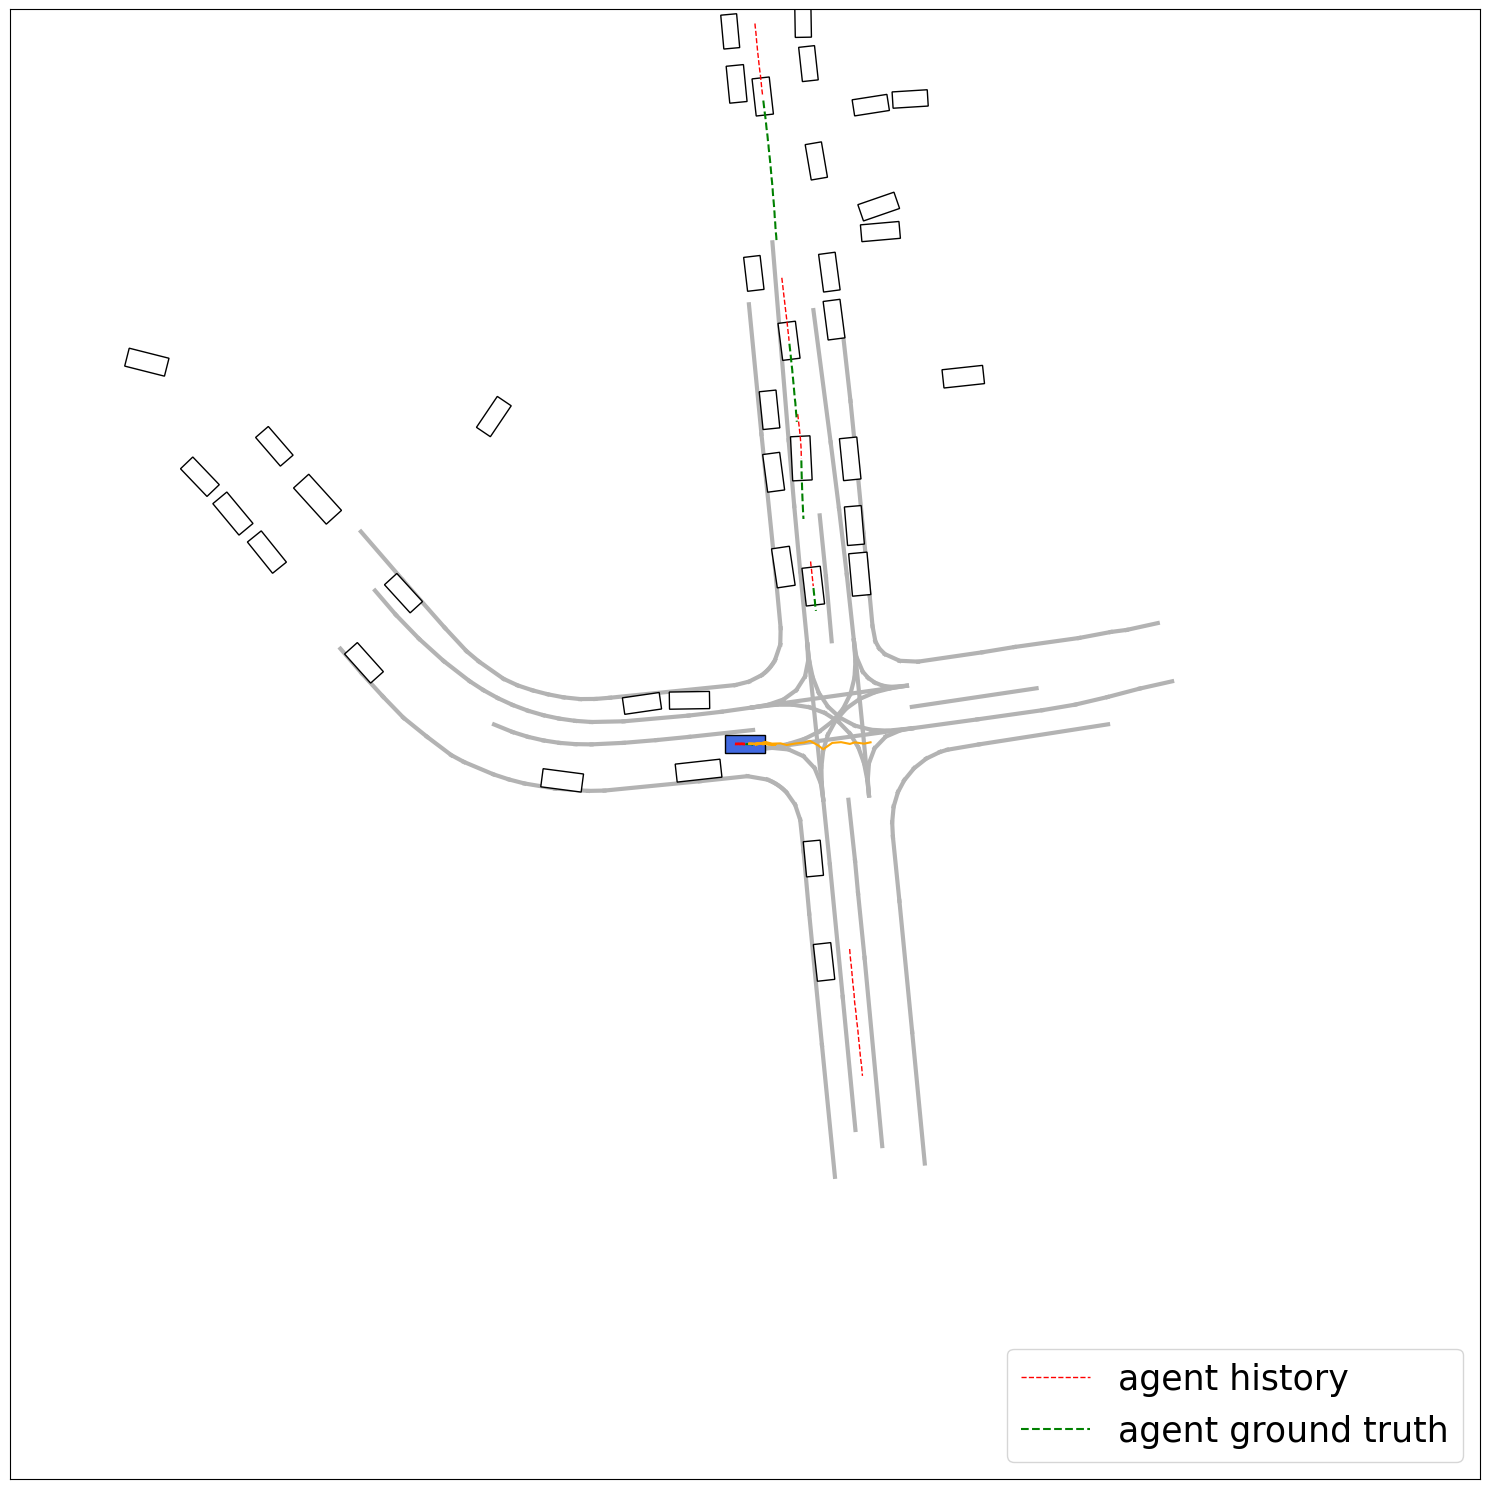

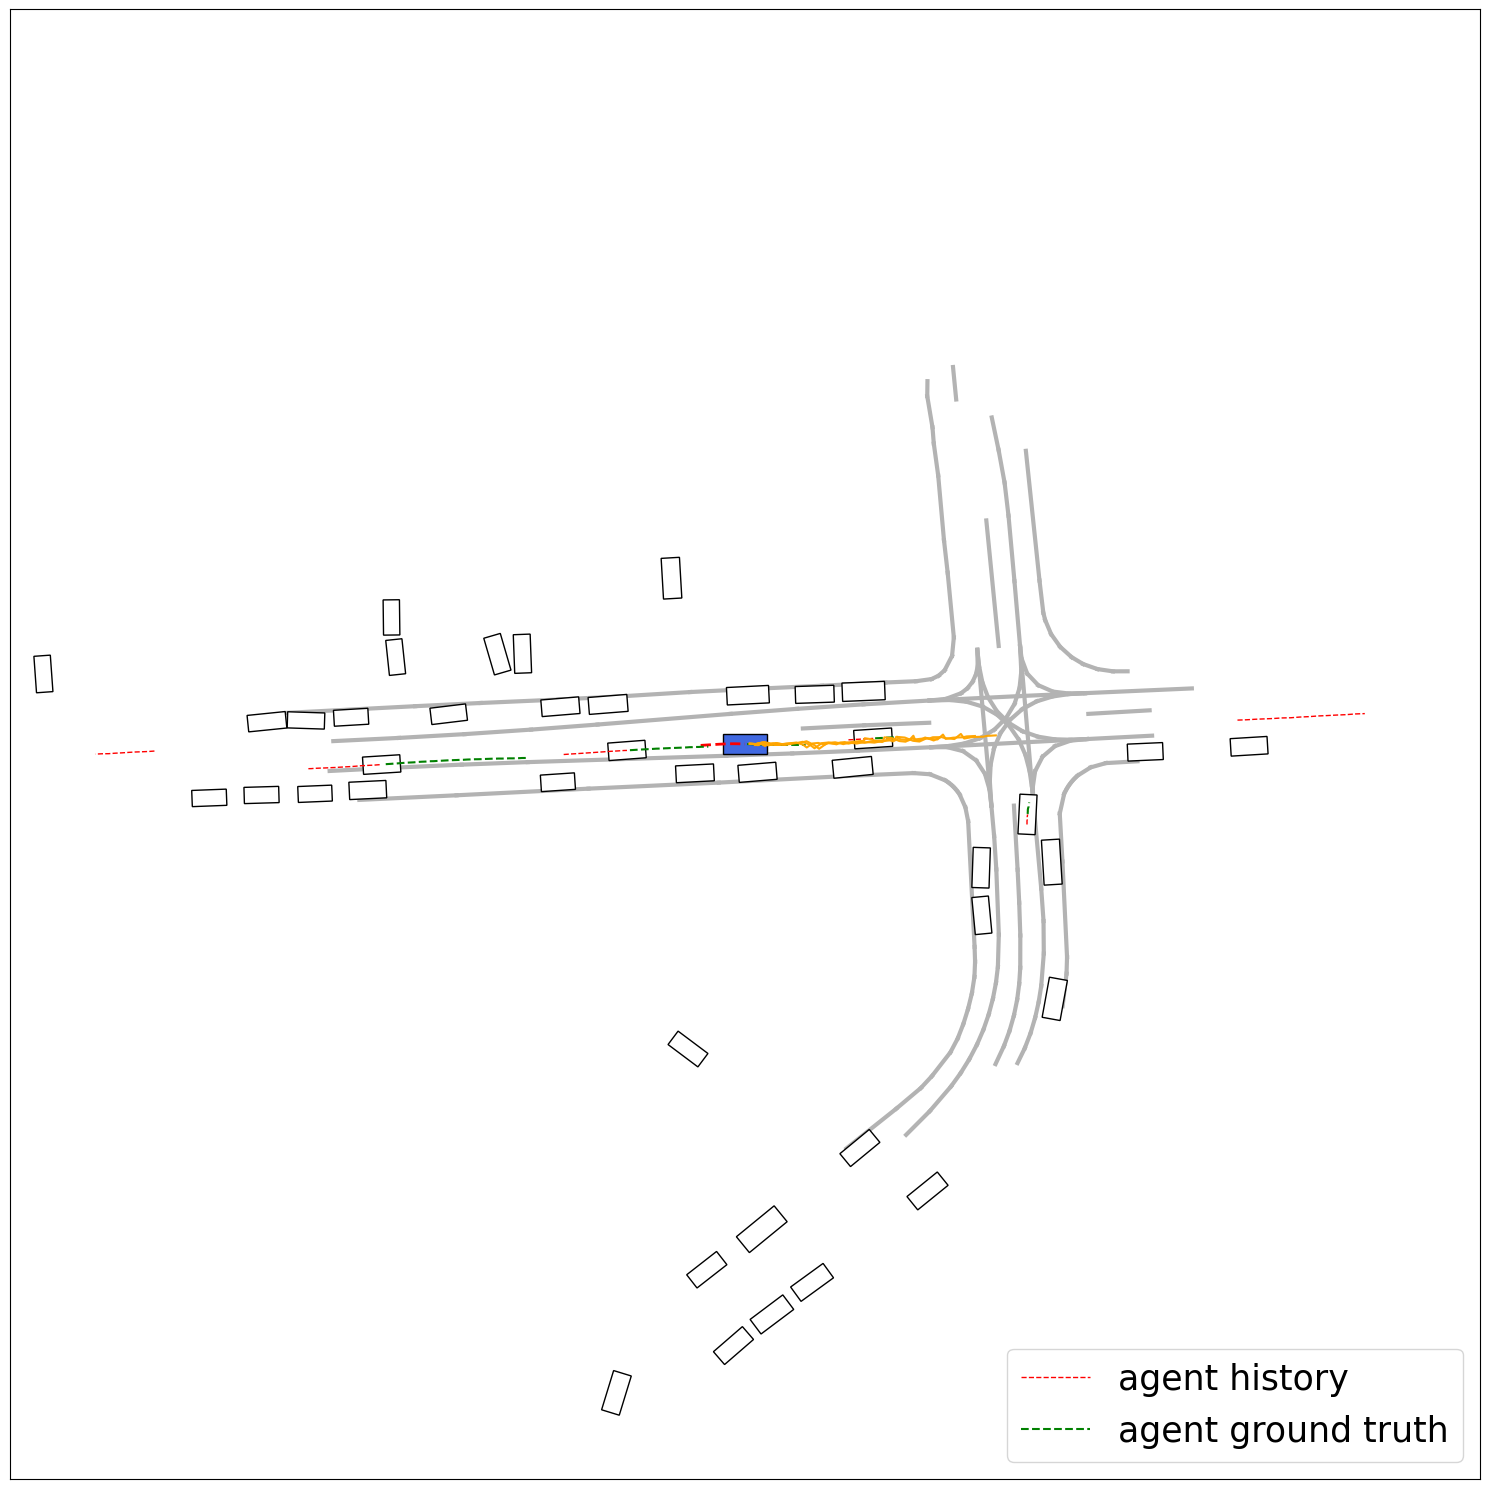

100%|██████████| 100/100 [00:10<00:00,  9.74it/s]
INFO:root:Epoch: 10, Last loss: 2.9485127925872803


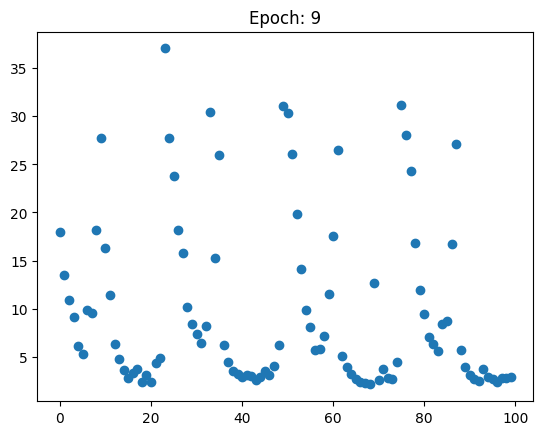

In [151]:
# Reset the iterators
traj_data_loader = TrajectoryIterator(env, data_loader, cmtr=True, waymo_dataset=waymo_dataset, prior_frame=20, future_frame=40, simple=False)
train_iterator = iter(DataLoader(traj_data_loader, batch_size=2, collate_fn=traj_data_loader.collate_batch))

MODEL_DEVICE = "cuda:1"
model_cfg = config.MODEL
model_cfg.CONTEXT_ENCODER.NUM_INPUT_ATTR_AGENT = 38
model_cfg.CONTEXT_ENCODER.NUM_ATTN_LAYERS = 1
model_cfg.CONTEXT_ENCODER.NUM_CHANNEL_IN_MLP_AGENT = 64
model_cfg.MOTION_DECODER.NUM_DECODER_LAYERS = 1
model_cfg.MOTION_DECODER.NUM_FUTURE_FRAMES = 40
model = model_utils.MotionTransformer(config=model_cfg).to(MODEL_DEVICE)

NUM_BATCH = 100
NUM_EPOCH = 10
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()
batch_dicts = []

for epoch in range(NUM_EPOCH): 
    model.set_epoch(epoch)
    for batch_idx in tqdm(range(NUM_BATCH)): 
        batch_dict, actions, _, _ = next(train_iterator)
        loss, tb_dict, disp_dict, batch_dict = model(batch_dict)
        loss = loss_fn(batch_dict['pred_list'][-1][1][:, 0, :, :2], batch_dict['input_dict']['center_gt_trajs'][..., :2].cuda())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_dicts.append((loss.detach(), [batch_dict['pred_list'][-1][1][:, 0, :, :2].detach(), batch_dict['input_dict']['center_gt_trajs'][..., :2]]))
        if (batch_idx == NUM_BATCH-1): 
            plot_scenario(
                input_dict=batch_dict['input_dict'],
                forward_ret_dict=batch_dict['forward_ret_dict'],
                num_samples=5,
                plot_object_history=True, 
                plot_object_gt_future=True,
                plot_ego_object_pred_future=True,
            )
            plt.show()

    logging.info(f"Epoch: {epoch + 1}, Last loss: {batch_dicts[-1][0].item()}")
    plt.title(f"Epoch: {epoch}")
    plt.scatter(np.arange(NUM_BATCH), [i[0].cpu() for i in batch_dicts[-NUM_BATCH:]])
    plt.show()